# Try to classify contigs as prokaryotic or eukaryotic just from the alignment

General idea: eukaryotic contigs, compared with prokaryotic contigs, should have relatively high amounts of positions with variants around 50% frequency (representing diploidy).

In [2]:
%run "Header.ipynb"

In [3]:
import math
import json
import time
import skbio
import pysam
import pysamstats

In [4]:
# No edges with length < this will be considered here
MIN_SEQ_LEN = 5000

# Minimum coverage for positions where we want to look for ~50% mutation rates.
# This is purposefully low so as to cast a wide net.
MIN_COV = 5

# Both of these are inclusive. We'll accept positions (with at least MIN_COV aligned (mis)matches)
# where the maximum-frequency alternate nucleotide's frequency (divided by total # of aligned (mis)matches)
# is within this inclusive range.
#
# ...So, for a position with exactly 5x (mis)match coverage, we'd accept a max-freq alt nucleotide freq of
# [2, 3] but not 1, 4, or 5.
MIN_DIPLOID_MAXALT_FREQ = 0.4
MAX_DIPLOID_MAXALT_FREQ = 0.6

In [4]:
bf = pysam.AlignmentFile("../main-workflow/output/fully-filtered-and-sorted-aln.bam", "rb")

## Get a mapping of sequence (edge) name to sequence length

stolen from the diversity index notebook; should merge these into a single function

also the div index notebook version of this accidentally trumps the `seq2len` variable defined in the header notebook... should fix that, but not super impt

In [13]:
edge2len = {}
edgename = None
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            edgename = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if edgename is None:
                raise ValueError("No sequence name set yet?")
            edge2len[edgename] = len(line.strip())
            edgename = None

print(f"edge2len contains {len(edge2len):,} entries. The length of edge_1 is {edge2len['edge_1']:,} bp.")

edge2len contains 78,793 entries. The length of edge_1 is 39,565 bp.


In [14]:
long_enough_seqs = []
for edge in edge2len:
    if edge2len[edge] >= MIN_SEQ_LEN:
        long_enough_seqs.append(edge)
        
pct = 100 * (len(long_enough_seqs) / len(edge2len))
print(f"{len(long_enough_seqs):,} / {len(edge2len):,} ({pct:.2f}%) edges have a length of at least {MIN_SEQ_LEN:,.0f} bp.")

43,562 / 78,793 (55.29%) edges have a length of at least 5,000 bp.


## Go through the alignment; count the number of positions with ~50% max-frequency alternate nucleotide mismatches

Parts of this (e.g. processing each record in the pileup) could be abstracted to code that's shared between here, the diversity index ntbk, and the bam2pileup script I wrote for the three "selected" MAGs.

**NOTE: This takes quite a while to run (as of writing, it took about 18.4 hours to complete).**

In [7]:
edge2num_mincov_positions = {}
edge2num_mincov_positions_with_at_least_one_mismatch = {}
edge2num_mincov_putatively_diploid_positions = {}
edge2meancov = {}

num_seqs = len(long_enough_seqs)

t1 = time.time()

for si, seq in enumerate(long_enough_seqs, 1):
    pct = 100 * (si / num_seqs)
    print(f"On seq {seq} ({si:,} / {num_seqs:,}) ({pct:.2f}%).", end=" ", flush=True)   
    print(f"{edge2len[seq]:,} bp long.", end=" ", flush=True)
    print(f"Runtime: ~{time.time() - t1:,.0f} sec.", end=" ", flush=True)
    
    one_tenth_len = math.floor(edge2len[seq] / 10)
    
    num_mincov_positions = 0
    num_mincov_positions_with_at_least_one_mismatch = 0
    num_mincov_putatively_diploid_positions = 0
    
    total_cov = 0
    
    # Go through each position in the sequence's pileup (even including relatively low-coverage positions).
    # See bam-to-jsons.py for a description of why these params are useful.
    # Also, note that pysam coords are 0-indexed!
    for ri, rec in enumerate(
        pysamstats.stat_variation(
            bf, chrom=seq, fafile="../main-workflow/output/all_edges.fasta", start=0, end=edge2len[seq],
            truncate=True, pad=True, max_depth=1e6
        ),
        1
    ):
        # very simple progress bar for my own sake. might miss a few dots here and there
        if ri % one_tenth_len == 0:
            print("=", end="", flush=True)
            
        matches = rec["matches"]
        mismatches = rec["mismatches"]
        # NOTE: As with "coverage" in the coverage plots, this doesn't take into account deletions at a
        # given position. That info is available through pysamstats so we could use it here if desired.
        cov = matches + mismatches
        
        total_cov += cov
        
        #print(f"Pos {ri}... Matches: {matches} / Mismatches: {mismatches} / cov: {cov}")
        
        if cov > MIN_COV:
            num_mincov_positions += 1
            # Rather than looking at (mismatches / cov), we instead look at each alternate non-matching nucleotide
            # individually.
            nonmatches = set("ACGT") - set(rec["ref"])
            max_alt_nt_freq = max(rec[alt_nt] for alt_nt in nonmatches)
            max_alt_nt_relfreq = max_alt_nt_freq / cov
            
            # Keep track of # (min-cov) positions that have at least one mismatch; could be useful to know
            if max_alt_nt_freq >= 1:
                num_mincov_positions_with_at_least_one_mismatch += 1
                #print("\tHas at least 1 mismatch!")
                
            # The meat of this: see if this position "counts" as putatively diploid due to having a ~50%
            # mutation rate
            if max_alt_nt_relfreq >= MIN_DIPLOID_MAXALT_FREQ and max_alt_nt_relfreq <= MAX_DIPLOID_MAXALT_FREQ:
                num_mincov_putatively_diploid_positions += 1
                #print(f"\tPutatively diploid! rel freq = {max_alt_nt_relfreq}")
    
    assert ri == edge2len[seq]
    meancov = total_cov / ri
    
    # Save info for each edge
    edge2num_mincov_positions[seq] = num_mincov_positions
    edge2num_mincov_positions_with_at_least_one_mismatch[seq] = num_mincov_positions_with_at_least_one_mismatch
    edge2num_mincov_putatively_diploid_positions[seq] = num_mincov_putatively_diploid_positions
    edge2meancov[seq] = meancov
    
    # Move print info to a new line
    print(f"\n\t{num_mincov_positions:,} pos w/ cov >= {MIN_COV}x;", end=" ")
    print(f"{num_mincov_positions_with_at_least_one_mismatch:,} MCP w/ >= 1 mismatch;", end=" ")
    print(f"{num_mincov_putatively_diploid_positions:,} 'diploid' MCP;", end=" ")
    print(f"mean cov = {meancov:,.2f}x")

On seq edge_1 (1 / 43,562) (0.00%). 39,565 bp long. Runtime: ~0 sec. ==========
	39,558 pos w/ cov >= 5x; 6,310 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 460.40x
On seq edge_3 (2 / 43,562) (0.00%). 38,161 bp long. Runtime: ~2 sec. ==========
	36,963 pos w/ cov >= 5x; 3,805 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 258.76x
On seq edge_5 (3 / 43,562) (0.01%). 32,079 bp long. Runtime: ~3 sec. ==========
	5,867 pos w/ cov >= 5x; 104 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.36x
On seq edge_6 (4 / 43,562) (0.01%). 6,738 bp long. Runtime: ~3 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_8 (5 / 43,562) (0.01%). 1,710,962 bp long. Runtime: ~4 sec. ==========
	1,710,962 pos w/ cov >= 5x; 53,743 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 111.64x
On seq edge_9 (6 / 43,562) (0.01%). 91,227 bp long. Runtime: ~33 sec. ==========
	23,068 pos w/ cov >= 5x; 691 MCP w/ >= 1 mismatch; 197 'diploid' MCP; mean c

On seq edge_62 (49 / 43,562) (0.11%). 106,456 bp long. Runtime: ~333 sec. ==========
	16,847 pos w/ cov >= 5x; 101 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_63 (50 / 43,562) (0.11%). 100,190 bp long. Runtime: ~334 sec. ==========
	59,525 pos w/ cov >= 5x; 435 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.21x
On seq edge_64 (51 / 43,562) (0.12%). 33,880 bp long. Runtime: ~335 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.49x
On seq edge_65 (52 / 43,562) (0.12%). 115,982 bp long. Runtime: ~336 sec. ==========
	78,700 pos w/ cov >= 5x; 479 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.63x
On seq edge_66 (53 / 43,562) (0.12%). 489,223 bp long. Runtime: ~337 sec. ==========
	484,854 pos w/ cov >= 5x; 5,552 MCP w/ >= 1 mismatch; 79 'diploid' MCP; mean cov = 32.32x
On seq edge_67 (54 / 43,562) (0.12%). 517,533 bp long. Runtime: ~344 sec. ==========
	405,195 pos w/ cov >= 5x; 5,724 MCP w/ >= 1 mismatch; 14 'dipl

On seq edge_122 (97 / 43,562) (0.22%). 220,154 bp long. Runtime: ~575 sec. ==========
	152,982 pos w/ cov >= 5x; 3,319 MCP w/ >= 1 mismatch; 567 'diploid' MCP; mean cov = 8.51x
On seq edge_123 (98 / 43,562) (0.22%). 5,325 bp long. Runtime: ~577 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_124 (99 / 43,562) (0.23%). 59,708 bp long. Runtime: ~578 sec. ==========
	29,830 pos w/ cov >= 5x; 809 MCP w/ >= 1 mismatch; 101 'diploid' MCP; mean cov = 4.87x
On seq edge_125 (100 / 43,562) (0.23%). 29,673 bp long. Runtime: ~578 sec. ==========
	29,667 pos w/ cov >= 5x; 2,618 MCP w/ >= 1 mismatch; 216 'diploid' MCP; mean cov = 61.96x
On seq edge_126 (101 / 43,562) (0.23%). 15,732 bp long. Runtime: ~579 sec. ==========
	7,969 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.82x
On seq edge_127 (102 / 43,562) (0.23%). 980,049 bp long. Runtime: ~579 sec. ==========
	940,578 pos w/ cov >= 5x; 22,210 MCP w/ >= 1 mismatch

On seq edge_998 (190 / 43,562) (0.44%). 116,268 bp long. Runtime: ~1,170 sec. ==========
	81,300 pos w/ cov >= 5x; 341 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.34x
On seq edge_1001 (191 / 43,562) (0.44%). 1,489,937 bp long. Runtime: ~1,172 sec. ==========
	1,461,860 pos w/ cov >= 5x; 11,504 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 13.45x
On seq edge_1016 (192 / 43,562) (0.44%). 2,125,735 bp long. Runtime: ~1,190 sec. ==========
	2,125,735 pos w/ cov >= 5x; 83,384 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 178.19x
On seq edge_1021 (193 / 43,562) (0.44%). 16,699 bp long. Runtime: ~1,233 sec. ==========
	7,907 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.14x
On seq edge_1028 (194 / 43,562) (0.45%). 15,215 bp long. Runtime: ~1,233 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_1037 (195 / 43,562) (0.45%). 12,294 bp long. Runtime: ~1,233 sec. ==========
	8,490 pos w/ cov >= 5x; 

On seq edge_1316 (282 / 43,562) (0.65%). 542,654 bp long. Runtime: ~2,058 sec. ==========
	525,259 pos w/ cov >= 5x; 2,048 MCP w/ >= 1 mismatch; 72 'diploid' MCP; mean cov = 12.81x
On seq edge_1322 (283 / 43,562) (0.65%). 146,466 bp long. Runtime: ~2,064 sec. ==========
	110,958 pos w/ cov >= 5x; 20,083 MCP w/ >= 1 mismatch; 608 'diploid' MCP; mean cov = 554.35x
On seq edge_1323 (284 / 43,562) (0.65%). 53,877 bp long. Runtime: ~2,071 sec. ==========
	27,127 pos w/ cov >= 5x; 2,781 MCP w/ >= 1 mismatch; 391 'diploid' MCP; mean cov = 5.53x
On seq edge_1324 (285 / 43,562) (0.65%). 82,561 bp long. Runtime: ~2,072 sec. ==========
	79,940 pos w/ cov >= 5x; 896 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 45.50x
On seq edge_1328 (286 / 43,562) (0.66%). 78,344 bp long. Runtime: ~2,073 sec. ==========
	21,868 pos w/ cov >= 5x; 43 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.20x
On seq edge_1333 (287 / 43,562) (0.66%). 419,646 bp long. Runtime: ~2,074 sec. ==========
	246,991 pos w/ 

On seq edge_1383 (328 / 43,562) (0.75%). 617,647 bp long. Runtime: ~2,611 sec. ==========
	615,260 pos w/ cov >= 5x; 17,090 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 24.99x
On seq edge_1385 (329 / 43,562) (0.76%). 250,976 bp long. Runtime: ~2,619 sec. ==========
	250,976 pos w/ cov >= 5x; 6,674 MCP w/ >= 1 mismatch; 100 'diploid' MCP; mean cov = 83.73x
On seq edge_1386 (330 / 43,562) (0.76%). 120,695 bp long. Runtime: ~2,622 sec. ==========
	118,878 pos w/ cov >= 5x; 12,766 MCP w/ >= 1 mismatch; 1,189 'diploid' MCP; mean cov = 91.23x
On seq edge_1387 (331 / 43,562) (0.76%). 2,893,861 bp long. Runtime: ~2,625 sec. ==========
	2,860,282 pos w/ cov >= 5x; 523,165 MCP w/ >= 1 mismatch; 323 'diploid' MCP; mean cov = 765.43x
On seq edge_1389 (332 / 43,562) (0.76%). 671,136 bp long. Runtime: ~2,787 sec. ==========
	593,674 pos w/ cov >= 5x; 2,378 MCP w/ >= 1 mismatch; 163 'diploid' MCP; mean cov = 9.48x
On seq edge_1391 (333 / 43,562) (0.76%). 35,389 bp long. Runtime: ~2,794 sec. ===

On seq edge_1525 (420 / 43,562) (0.96%). 626,289 bp long. Runtime: ~3,333 sec. ==========
	626,277 pos w/ cov >= 5x; 14,196 MCP w/ >= 1 mismatch; 304 'diploid' MCP; mean cov = 60.56x
On seq edge_1526 (421 / 43,562) (0.97%). 2,338,731 bp long. Runtime: ~3,341 sec. ==========
	2,316,947 pos w/ cov >= 5x; 288,744 MCP w/ >= 1 mismatch; 300 'diploid' MCP; mean cov = 518.16x
On seq edge_1527 (422 / 43,562) (0.97%). 1,581,694 bp long. Runtime: ~3,426 sec. ==========
	1,359,663 pos w/ cov >= 5x; 7,474 MCP w/ >= 1 mismatch; 81 'diploid' MCP; mean cov = 8.67x
On seq edge_1528 (423 / 43,562) (0.97%). 247,049 bp long. Runtime: ~3,444 sec. ==========
	211,652 pos w/ cov >= 5x; 415 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.66x
On seq edge_1529 (424 / 43,562) (0.97%). 273,236 bp long. Runtime: ~3,447 sec. ==========
	165,607 pos w/ cov >= 5x; 6,914 MCP w/ >= 1 mismatch; 653 'diploid' MCP; mean cov = 6.22x
On seq edge_1530 (425 / 43,562) (0.98%). 2,378,270 bp long. Runtime: ~3,450 sec. =====

On seq edge_1648 (512 / 43,562) (1.18%). 76,420 bp long. Runtime: ~3,916 sec. ==========
	49,341 pos w/ cov >= 5x; 1,389 MCP w/ >= 1 mismatch; 30 'diploid' MCP; mean cov = 34.05x
On seq edge_1650 (513 / 43,562) (1.18%). 1,766,870 bp long. Runtime: ~3,917 sec. ==========
	1,236,231 pos w/ cov >= 5x; 14,575 MCP w/ >= 1 mismatch; 2,359 'diploid' MCP; mean cov = 7.79x
On seq edge_1651 (514 / 43,562) (1.18%). 582,376 bp long. Runtime: ~3,935 sec. ==========
	568,844 pos w/ cov >= 5x; 15,526 MCP w/ >= 1 mismatch; 767 'diploid' MCP; mean cov = 20.17x
On seq edge_1653 (515 / 43,562) (1.18%). 957,334 bp long. Runtime: ~3,942 sec. ==========
	941,495 pos w/ cov >= 5x; 13,701 MCP w/ >= 1 mismatch; 187 'diploid' MCP; mean cov = 15.49x
On seq edge_1654 (516 / 43,562) (1.18%). 551,980 bp long. Runtime: ~3,952 sec. ==========
	538,848 pos w/ cov >= 5x; 3,619 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 18.90x
On seq edge_1655 (517 / 43,562) (1.19%). 18,513 bp long. Runtime: ~3,959 sec. =========

On seq edge_1706 (558 / 43,562) (1.28%). 28,510 bp long. Runtime: ~4,327 sec. ==========
	28,510 pos w/ cov >= 5x; 3,984 MCP w/ >= 1 mismatch; 121 'diploid' MCP; mean cov = 205.55x
On seq edge_1709 (559 / 43,562) (1.28%). 10,154 bp long. Runtime: ~4,328 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_1710 (560 / 43,562) (1.29%). 271,085 bp long. Runtime: ~4,328 sec. ==========
	271,081 pos w/ cov >= 5x; 48,670 MCP w/ >= 1 mismatch; 164 'diploid' MCP; mean cov = 593.25x
On seq edge_1711 (561 / 43,562) (1.29%). 26,535 bp long. Runtime: ~4,339 sec. ==========
	12,118 pos w/ cov >= 5x; 338 MCP w/ >= 1 mismatch; 130 'diploid' MCP; mean cov = 13.58x
On seq edge_1712 (562 / 43,562) (1.29%). 25,044 bp long. Runtime: ~4,339 sec. ==========
	25,044 pos w/ cov >= 5x; 939 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 75.28x
On seq edge_1713 (563 / 43,562) (1.29%). 98,570 bp long. Runtime: ~4,340 sec. ==========
	98,570 pos w/ cov >= 5x

On seq edge_1767 (604 / 43,562) (1.39%). 97,091 bp long. Runtime: ~4,670 sec. ==========
	94,163 pos w/ cov >= 5x; 1,509 MCP w/ >= 1 mismatch; 175 'diploid' MCP; mean cov = 17.05x
On seq edge_1768 (605 / 43,562) (1.39%). 18,139 bp long. Runtime: ~4,672 sec. ==========
	12,907 pos w/ cov >= 5x; 925 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 154.73x
On seq edge_1769 (606 / 43,562) (1.39%). 14,340 bp long. Runtime: ~4,672 sec. ==========
	14,339 pos w/ cov >= 5x; 434 MCP w/ >= 1 mismatch; 195 'diploid' MCP; mean cov = 64.02x
On seq edge_1770 (607 / 43,562) (1.39%). 1,048,294 bp long. Runtime: ~4,672 sec. ==========
	1,046,827 pos w/ cov >= 5x; 7,891 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 21.24x
On seq edge_1772 (608 / 43,562) (1.40%). 126,937 bp long. Runtime: ~4,684 sec. ==========
	83,362 pos w/ cov >= 5x; 5,005 MCP w/ >= 1 mismatch; 395 'diploid' MCP; mean cov = 6.41x
On seq edge_1773 (609 / 43,562) (1.40%). 566,730 bp long. Runtime: ~4,686 sec. ==========
	554,788 p

On seq edge_1897 (697 / 43,562) (1.60%). 854,600 bp long. Runtime: ~5,074 sec. ==========
	804,598 pos w/ cov >= 5x; 4,804 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 10.67x
On seq edge_1898 (698 / 43,562) (1.60%). 206,721 bp long. Runtime: ~5,083 sec. ==========
	127,812 pos w/ cov >= 5x; 240 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.72x
On seq edge_1900 (699 / 43,562) (1.60%). 61,380 bp long. Runtime: ~5,085 sec. ==========
	60,908 pos w/ cov >= 5x; 6,986 MCP w/ >= 1 mismatch; 751 'diploid' MCP; mean cov = 106.16x
On seq edge_1901 (700 / 43,562) (1.61%). 9,377 bp long. Runtime: ~5,086 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.34x
On seq edge_1902 (701 / 43,562) (1.61%). 1,319,888 bp long. Runtime: ~5,087 sec. ==========
	1,314,284 pos w/ cov >= 5x; 4,745 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 16.47x
On seq edge_1904 (702 / 43,562) (1.61%). 5,363 bp long. Runtime: ~5,101 sec. ==========
	0 pos w/ cov >= 5x; 0 

On seq edge_2011 (789 / 43,562) (1.81%). 17,377 bp long. Runtime: ~5,484 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.32x
On seq edge_2013 (790 / 43,562) (1.81%). 907,873 bp long. Runtime: ~5,484 sec. ==========
	550,787 pos w/ cov >= 5x; 949 MCP w/ >= 1 mismatch; 20 'diploid' MCP; mean cov = 6.31x
On seq edge_2014 (791 / 43,562) (1.82%). 364,462 bp long. Runtime: ~5,493 sec. ==========
	283,496 pos w/ cov >= 5x; 1,036 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.90x
On seq edge_2015 (792 / 43,562) (1.82%). 350,891 bp long. Runtime: ~5,497 sec. ==========
	347,982 pos w/ cov >= 5x; 10,064 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.52x
On seq edge_2016 (793 / 43,562) (1.82%). 676,857 bp long. Runtime: ~5,501 sec. ==========
	673,810 pos w/ cov >= 5x; 32,282 MCP w/ >= 1 mismatch; 749 'diploid' MCP; mean cov = 22.56x
On seq edge_2017 (794 / 43,562) (1.82%). 7,711 bp long. Runtime: ~5,509 sec. ==========
	0 pos w/ cov >= 5x; 0 

On seq edge_2124 (881 / 43,562) (2.02%). 23,681 bp long. Runtime: ~6,005 sec. ==========
	20,088 pos w/ cov >= 5x; 531 MCP w/ >= 1 mismatch; 58 'diploid' MCP; mean cov = 15.68x
On seq edge_2125 (882 / 43,562) (2.02%). 2,279,210 bp long. Runtime: ~6,005 sec. ==========
	2,262,012 pos w/ cov >= 5x; 151,227 MCP w/ >= 1 mismatch; 536 'diploid' MCP; mean cov = 170.50x
On seq edge_2126 (883 / 43,562) (2.03%). 21,989 bp long. Runtime: ~6,045 sec. ==========
	15,041 pos w/ cov >= 5x; 444 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.03x
On seq edge_2127 (884 / 43,562) (2.03%). 17,681 bp long. Runtime: ~6,046 sec. ==========
	3,133 pos w/ cov >= 5x; 24 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_2128 (885 / 43,562) (2.03%). 49,736 bp long. Runtime: ~6,046 sec. ==========
	35,013 pos w/ cov >= 5x; 96 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.03x
On seq edge_2129 (886 / 43,562) (2.03%). 174,798 bp long. Runtime: ~6,047 sec. ==========
	149,779 pos w/ cov >=

On seq edge_2182 (927 / 43,562) (2.13%). 22,442 bp long. Runtime: ~6,329 sec. ==========
	22,319 pos w/ cov >= 5x; 277 MCP w/ >= 1 mismatch; 8 'diploid' MCP; mean cov = 12.61x
On seq edge_2183 (928 / 43,562) (2.13%). 10,618 bp long. Runtime: ~6,329 sec. ==========
	10,618 pos w/ cov >= 5x; 83 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 33.77x
On seq edge_2185 (929 / 43,562) (2.13%). 12,301 bp long. Runtime: ~6,330 sec. ==========
	7,682 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.30x
On seq edge_2186 (930 / 43,562) (2.13%). 16,222 bp long. Runtime: ~6,330 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.58x
On seq edge_2187 (931 / 43,562) (2.14%). 19,255 bp long. Runtime: ~6,330 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_2188 (932 / 43,562) (2.14%). 55,015 bp long. Runtime: ~6,331 sec. ==========
	7,443 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 

On seq edge_2298 (1,019 / 43,562) (2.34%). 1,018,142 bp long. Runtime: ~6,624 sec. ==========
	964,006 pos w/ cov >= 5x; 73,852 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 365.26x
On seq edge_2299 (1,020 / 43,562) (2.34%). 86,740 bp long. Runtime: ~6,650 sec. ==========
	30,198 pos w/ cov >= 5x; 85 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.71x
On seq edge_2300 (1,021 / 43,562) (2.34%). 436,023 bp long. Runtime: ~6,651 sec. ==========
	435,932 pos w/ cov >= 5x; 10,447 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 43.06x
On seq edge_2301 (1,022 / 43,562) (2.35%). 39,624 bp long. Runtime: ~6,656 sec. ==========
	16,142 pos w/ cov >= 5x; 938 MCP w/ >= 1 mismatch; 89 'diploid' MCP; mean cov = 6.47x
On seq edge_2302 (1,023 / 43,562) (2.35%). 13,563 bp long. Runtime: ~6,657 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2303 (1,024 / 43,562) (2.35%). 659,093 bp long. Runtime: ~6,657 sec. ==========
	503,863 pos w/

On seq edge_2362 (1,065 / 43,562) (2.44%). 2,071,753 bp long. Runtime: ~7,766 sec. ==========
	2,059,178 pos w/ cov >= 5x; 7,900 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.67x
On seq edge_2363 (1,066 / 43,562) (2.45%). 16,314 bp long. Runtime: ~7,789 sec. ==========
	10,710 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.91x
On seq edge_2365 (1,067 / 43,562) (2.45%). 10,163 bp long. Runtime: ~7,789 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.89x
On seq edge_2366 (1,068 / 43,562) (2.45%). 43,663 bp long. Runtime: ~7,790 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.45x
On seq edge_2367 (1,069 / 43,562) (2.45%). 31,876 bp long. Runtime: ~7,790 sec. ==========
	28,034 pos w/ cov >= 5x; 2,731 MCP w/ >= 1 mismatch; 68 'diploid' MCP; mean cov = 96.60x
On seq edge_2368 (1,070 / 43,562) (2.46%). 475,973 bp long. Runtime: ~7,791 sec. ==========
	474,329 pos w/ cov >= 5x;

On seq edge_2422 (1,111 / 43,562) (2.55%). 5,830 bp long. Runtime: ~8,001 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2424 (1,112 / 43,562) (2.55%). 5,629 bp long. Runtime: ~8,001 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_2425 (1,113 / 43,562) (2.55%). 1,549,951 bp long. Runtime: ~8,001 sec. ==========
	1,549,946 pos w/ cov >= 5x; 7,543 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.50x
On seq edge_2427 (1,114 / 43,562) (2.56%). 664,054 bp long. Runtime: ~8,019 sec. ==========
	660,794 pos w/ cov >= 5x; 2,651 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 16.80x
On seq edge_2428 (1,115 / 43,562) (2.56%). 460,960 bp long. Runtime: ~8,026 sec. ==========
	308,556 pos w/ cov >= 5x; 3,405 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 7.70x
On seq edge_2429 (1,116 / 43,562) (2.56%). 5,584 bp long. Runtime: ~8,031 sec. ==========
	0 pos w/ cov >= 5x; 0 

On seq edge_2481 (1,157 / 43,562) (2.66%). 94,359 bp long. Runtime: ~8,289 sec. ==========
	94,358 pos w/ cov >= 5x; 2,465 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.51x
On seq edge_2482 (1,158 / 43,562) (2.66%). 195,807 bp long. Runtime: ~8,291 sec. ==========
	194,895 pos w/ cov >= 5x; 10,142 MCP w/ >= 1 mismatch; 1,433 'diploid' MCP; mean cov = 45.42x
On seq edge_2483 (1,159 / 43,562) (2.66%). 200,911 bp long. Runtime: ~8,295 sec. ==========
	29,329 pos w/ cov >= 5x; 676 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.75x
On seq edge_2484 (1,160 / 43,562) (2.66%). 170,133 bp long. Runtime: ~8,297 sec. ==========
	132,623 pos w/ cov >= 5x; 2,791 MCP w/ >= 1 mismatch; 475 'diploid' MCP; mean cov = 9.40x
On seq edge_2485 (1,161 / 43,562) (2.67%). 353,411 bp long. Runtime: ~8,300 sec. ==========
	352,422 pos w/ cov >= 5x; 2,444 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 29.70x
On seq edge_2486 (1,162 / 43,562) (2.67%). 26,169 bp long. Runtime: ~8,306 sec. ==========

On seq edge_2593 (1,249 / 43,562) (2.87%). 52,117 bp long. Runtime: ~8,704 sec. ==========
	13,031 pos w/ cov >= 5x; 688 MCP w/ >= 1 mismatch; 65 'diploid' MCP; mean cov = 3.62x
On seq edge_2594 (1,250 / 43,562) (2.87%). 78,833 bp long. Runtime: ~8,704 sec. ==========
	78,831 pos w/ cov >= 5x; 957 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 51.43x
On seq edge_2595 (1,251 / 43,562) (2.87%). 124,522 bp long. Runtime: ~8,706 sec. ==========
	124,507 pos w/ cov >= 5x; 5,849 MCP w/ >= 1 mismatch; 44 'diploid' MCP; mean cov = 105.60x
On seq edge_2596 (1,252 / 43,562) (2.87%). 103,071 bp long. Runtime: ~8,708 sec. ==========
	94,065 pos w/ cov >= 5x; 2,090 MCP w/ >= 1 mismatch; 76 'diploid' MCP; mean cov = 11.57x
On seq edge_2597 (1,253 / 43,562) (2.88%). 9,951 bp long. Runtime: ~8,709 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_2598 (1,254 / 43,562) (2.88%). 7,460 bp long. Runtime: ~8,710 sec. ==========
	0 pos w/ cov >= 5x

On seq edge_2653 (1,295 / 43,562) (2.97%). 82,255 bp long. Runtime: ~8,865 sec. ==========
	65,910 pos w/ cov >= 5x; 905 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.76x
On seq edge_2654 (1,296 / 43,562) (2.98%). 9,005 bp long. Runtime: ~8,866 sec. ==========
	2,787 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_2656 (1,297 / 43,562) (2.98%). 5,558 bp long. Runtime: ~8,866 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_2657 (1,298 / 43,562) (2.98%). 62,146 bp long. Runtime: ~8,867 sec. ==========
	11,543 pos w/ cov >= 5x; 47 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_2658 (1,299 / 43,562) (2.98%). 708,805 bp long. Runtime: ~8,868 sec. ==========
	497,158 pos w/ cov >= 5x; 5,827 MCP w/ >= 1 mismatch; 514 'diploid' MCP; mean cov = 7.95x
On seq edge_2659 (1,300 / 43,562) (2.98%). 362,507 bp long. Runtime: ~8,875 sec. ==========
	292,000 pos w/ cov >= 5x; 4,2

On seq edge_2712 (1,341 / 43,562) (3.08%). 8,801 bp long. Runtime: ~9,013 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.37x
On seq edge_2713 (1,342 / 43,562) (3.08%). 17,507 bp long. Runtime: ~9,013 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.27x
On seq edge_2714 (1,343 / 43,562) (3.08%). 51,520 bp long. Runtime: ~9,014 sec. ==========
	10,663 pos w/ cov >= 5x; 78 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.04x
On seq edge_2715 (1,344 / 43,562) (3.09%). 523,471 bp long. Runtime: ~9,015 sec. ==========
	500,403 pos w/ cov >= 5x; 8,483 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.40x
On seq edge_2716 (1,345 / 43,562) (3.09%). 3,679,062 bp long. Runtime: ~9,021 sec. ==========
	3,679,062 pos w/ cov >= 5x; 82,050 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 100.04x
On seq edge_2717 (1,346 / 43,562) (3.09%). 2,190,406 bp long. Runtime: ~9,080 sec. ==========
	2,190,362 pos w/ cov

On seq edge_2766 (1,387 / 43,562) (3.18%). 3,531,919 bp long. Runtime: ~9,378 sec. ==========
	3,531,918 pos w/ cov >= 5x; 26,343 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 33.75x
On seq edge_2767 (1,388 / 43,562) (3.19%). 68,914 bp long. Runtime: ~9,422 sec. ==========
	66,073 pos w/ cov >= 5x; 4,296 MCP w/ >= 1 mismatch; 375 'diploid' MCP; mean cov = 12.94x
On seq edge_2768 (1,389 / 43,562) (3.19%). 10,128 bp long. Runtime: ~9,423 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.19x
On seq edge_2769 (1,390 / 43,562) (3.19%). 39,992 bp long. Runtime: ~9,424 sec. ==========
	39,532 pos w/ cov >= 5x; 761 MCP w/ >= 1 mismatch; 44 'diploid' MCP; mean cov = 22.35x
On seq edge_2771 (1,391 / 43,562) (3.19%). 133,086 bp long. Runtime: ~9,424 sec. ==========
	44,967 pos w/ cov >= 5x; 2,788 MCP w/ >= 1 mismatch; 667 'diploid' MCP; mean cov = 4.76x
On seq edge_2772 (1,392 / 43,562) (3.20%). 20,229 bp long. Runtime: ~9,426 sec. ==========
	8,884 po

On seq edge_2879 (1,479 / 43,562) (3.40%). 62,244 bp long. Runtime: ~9,700 sec. ==========
	49,672 pos w/ cov >= 5x; 672 MCP w/ >= 1 mismatch; 223 'diploid' MCP; mean cov = 9.59x
On seq edge_2880 (1,480 / 43,562) (3.40%). 70,913 bp long. Runtime: ~9,701 sec. ==========
	15,862 pos w/ cov >= 5x; 29 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_2881 (1,481 / 43,562) (3.40%). 25,023 bp long. Runtime: ~9,702 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_2882 (1,482 / 43,562) (3.40%). 48,680 bp long. Runtime: ~9,702 sec. ==========
	20,380 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.86x
On seq edge_2884 (1,483 / 43,562) (3.40%). 33,694 bp long. Runtime: ~9,703 sec. ==========
	360 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_2885 (1,484 / 43,562) (3.41%). 409,447 bp long. Runtime: ~9,704 sec. ==========
	322,247 pos w/ cov >= 5x; 9,366 MC

On seq edge_2991 (1,571 / 43,562) (3.61%). 411,550 bp long. Runtime: ~10,025 sec. ==========
	299,799 pos w/ cov >= 5x; 9,062 MCP w/ >= 1 mismatch; 1,199 'diploid' MCP; mean cov = 7.86x
On seq edge_2992 (1,572 / 43,562) (3.61%). 47,676 bp long. Runtime: ~10,031 sec. ==========
	43,395 pos w/ cov >= 5x; 321 MCP w/ >= 1 mismatch; 130 'diploid' MCP; mean cov = 14.79x
On seq edge_2993 (1,573 / 43,562) (3.61%). 13,763 bp long. Runtime: ~10,032 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.77x
On seq edge_2995 (1,574 / 43,562) (3.61%). 12,619 bp long. Runtime: ~10,032 sec. ==========
	12,619 pos w/ cov >= 5x; 57 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 42.57x
On seq edge_2997 (1,575 / 43,562) (3.62%). 23,972 bp long. Runtime: ~10,033 sec. ==========
	23,972 pos w/ cov >= 5x; 706 MCP w/ >= 1 mismatch; 35 'diploid' MCP; mean cov = 46.87x
On seq edge_2998 (1,576 / 43,562) (3.62%). 41,173 bp long. Runtime: ~10,034 sec. ==========
	21,962 pos 

On seq edge_3044 (1,617 / 43,562) (3.71%). 583,024 bp long. Runtime: ~10,460 sec. ==========
	400,614 pos w/ cov >= 5x; 7,391 MCP w/ >= 1 mismatch; 664 'diploid' MCP; mean cov = 6.82x
On seq edge_3045 (1,618 / 43,562) (3.71%). 21,509 bp long. Runtime: ~10,467 sec. ==========
	13,233 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.62x
On seq edge_3046 (1,619 / 43,562) (3.72%). 273,663 bp long. Runtime: ~10,468 sec. ==========
	208,605 pos w/ cov >= 5x; 11,276 MCP w/ >= 1 mismatch; 1,405 'diploid' MCP; mean cov = 10.42x
On seq edge_3047 (1,620 / 43,562) (3.72%). 17,287 bp long. Runtime: ~10,472 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_3050 (1,621 / 43,562) (3.72%). 970,538 bp long. Runtime: ~10,472 sec. ==========
	970,537 pos w/ cov >= 5x; 13,380 MCP w/ >= 1 mismatch; 251 'diploid' MCP; mean cov = 31.19x
On seq edge_3051 (1,622 / 43,562) (3.72%). 75,133 bp long. Runtime: ~10,487 sec. ==========
	16

On seq edge_3098 (1,663 / 43,562) (3.82%). 16,935 bp long. Runtime: ~10,596 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.34x
On seq edge_3099 (1,664 / 43,562) (3.82%). 69,864 bp long. Runtime: ~10,596 sec. ==========
	35,855 pos w/ cov >= 5x; 364 MCP w/ >= 1 mismatch; 59 'diploid' MCP; mean cov = 5.22x
On seq edge_3100 (1,665 / 43,562) (3.82%). 2,295,600 bp long. Runtime: ~10,597 sec. ==========
	2,251,895 pos w/ cov >= 5x; 32,544 MCP w/ >= 1 mismatch; 996 'diploid' MCP; mean cov = 18.15x
On seq edge_3103 (1,666 / 43,562) (3.82%). 6,347 bp long. Runtime: ~10,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3104 (1,667 / 43,562) (3.83%). 8,337 bp long. Runtime: ~10,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.94x
On seq edge_3105 (1,668 / 43,562) (3.83%). 335,671 bp long. Runtime: ~10,625 sec. ==========
	241,923 pos w/ cov >= 5x; 

On seq edge_3154 (1,709 / 43,562) (3.92%). 160,714 bp long. Runtime: ~10,723 sec. ==========
	160,714 pos w/ cov >= 5x; 15,208 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 424.89x
On seq edge_3155 (1,710 / 43,562) (3.93%). 15,296 bp long. Runtime: ~10,728 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.24x
On seq edge_3156 (1,711 / 43,562) (3.93%). 238,683 bp long. Runtime: ~10,729 sec. ==========
	76,919 pos w/ cov >= 5x; 714 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.62x
On seq edge_3157 (1,712 / 43,562) (3.93%). 15,028 bp long. Runtime: ~10,731 sec. ==========
	14,976 pos w/ cov >= 5x; 277 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.14x
On seq edge_3158 (1,713 / 43,562) (3.93%). 1,424,391 bp long. Runtime: ~10,732 sec. ==========
	1,386,798 pos w/ cov >= 5x; 24,370 MCP w/ >= 1 mismatch; 241 'diploid' MCP; mean cov = 31.01x
On seq edge_3160 (1,714 / 43,562) (3.93%). 29,317 bp long. Runtime: ~10,750 sec. ==========
	29,

On seq edge_3266 (1,800 / 43,562) (4.13%). 29,031 bp long. Runtime: ~11,272 sec. ==========
	7,385 pos w/ cov >= 5x; 519 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 3.59x
On seq edge_3267 (1,801 / 43,562) (4.13%). 106,534 bp long. Runtime: ~11,273 sec. ==========
	13,112 pos w/ cov >= 5x; 15 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_3268 (1,802 / 43,562) (4.14%). 581,896 bp long. Runtime: ~11,274 sec. ==========
	200,740 pos w/ cov >= 5x; 281 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.67x
On seq edge_3270 (1,803 / 43,562) (4.14%). 35,273 bp long. Runtime: ~11,281 sec. ==========
	33,616 pos w/ cov >= 5x; 486 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 16.78x
On seq edge_3271 (1,804 / 43,562) (4.14%). 369,067 bp long. Runtime: ~11,282 sec. ==========
	363,749 pos w/ cov >= 5x; 23,574 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 91.04x
On seq edge_3272 (1,805 / 43,562) (4.14%). 614,719 bp long. Runtime: ~11,289 sec. ==========
	531,585

On seq edge_3318 (1,846 / 43,562) (4.24%). 10,162 bp long. Runtime: ~11,501 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_3319 (1,847 / 43,562) (4.24%). 85,286 bp long. Runtime: ~11,501 sec. ==========
	67,083 pos w/ cov >= 5x; 98 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.10x
On seq edge_3321 (1,848 / 43,562) (4.24%). 1,852,421 bp long. Runtime: ~11,503 sec. ==========
	1,850,084 pos w/ cov >= 5x; 12,805 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 27.66x
On seq edge_3322 (1,849 / 43,562) (4.24%). 20,440 bp long. Runtime: ~11,531 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.29x
On seq edge_3323 (1,850 / 43,562) (4.25%). 8,867 bp long. Runtime: ~11,531 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.30x
On seq edge_3324 (1,851 / 43,562) (4.25%). 217,164 bp long. Runtime: ~11,532 sec. ==========
	188,964 pos w/ cov >= 5x; 9,5

On seq edge_3367 (1,892 / 43,562) (4.34%). 326,022 bp long. Runtime: ~11,828 sec. ==========
	257,266 pos w/ cov >= 5x; 7,780 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 72.48x
On seq edge_3368 (1,893 / 43,562) (4.35%). 6,370 bp long. Runtime: ~11,834 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3371 (1,894 / 43,562) (4.35%). 23,204 bp long. Runtime: ~11,834 sec. ==========
	21,290 pos w/ cov >= 5x; 52 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.70x
On seq edge_3373 (1,895 / 43,562) (4.35%). 193,736 bp long. Runtime: ~11,835 sec. ==========
	117,610 pos w/ cov >= 5x; 181 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.57x
On seq edge_3374 (1,896 / 43,562) (4.35%). 895,907 bp long. Runtime: ~11,837 sec. ==========
	665,200 pos w/ cov >= 5x; 2,972 MCP w/ >= 1 mismatch; 109 'diploid' MCP; mean cov = 7.40x
On seq edge_3375 (1,897 / 43,562) (4.35%). 150,966 bp long. Runtime: ~11,850 sec. ==========
	21,650 pos 

On seq edge_3431 (1,938 / 43,562) (4.45%). 1,273,190 bp long. Runtime: ~12,219 sec. ==========
	1,186,221 pos w/ cov >= 5x; 14,213 MCP w/ >= 1 mismatch; 3,397 'diploid' MCP; mean cov = 10.73x
On seq edge_3432 (1,939 / 43,562) (4.45%). 456,400 bp long. Runtime: ~12,234 sec. ==========
	391,678 pos w/ cov >= 5x; 5,273 MCP w/ >= 1 mismatch; 32 'diploid' MCP; mean cov = 22.48x
On seq edge_3433 (1,940 / 43,562) (4.45%). 63,345 bp long. Runtime: ~12,240 sec. ==========
	25,316 pos w/ cov >= 5x; 651 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.67x
On seq edge_3434 (1,941 / 43,562) (4.46%). 1,976,500 bp long. Runtime: ~12,241 sec. ==========
	1,933,764 pos w/ cov >= 5x; 17,532 MCP w/ >= 1 mismatch; 3,156 'diploid' MCP; mean cov = 15.01x
On seq edge_3436 (1,942 / 43,562) (4.46%). 39,653 bp long. Runtime: ~12,266 sec. ==========
	16,563 pos w/ cov >= 5x; 68 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.02x
On seq edge_3438 (1,943 / 43,562) (4.46%). 12,592 bp long. Runtime: ~12,266 s

On seq edge_3487 (1,984 / 43,562) (4.55%). 8,346 bp long. Runtime: ~12,399 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3488 (1,985 / 43,562) (4.56%). 110,075 bp long. Runtime: ~12,400 sec. ==========
	30,094 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.89x
On seq edge_3489 (1,986 / 43,562) (4.56%). 95,711 bp long. Runtime: ~12,401 sec. ==========
	16,665 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.83x
On seq edge_3490 (1,987 / 43,562) (4.56%). 155,354 bp long. Runtime: ~12,403 sec. ==========
	152,320 pos w/ cov >= 5x; 3,175 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.44x
On seq edge_3492 (1,988 / 43,562) (4.56%). 58,002 bp long. Runtime: ~12,405 sec. ==========
	56,873 pos w/ cov >= 5x; 306 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.37x
On seq edge_3493 (1,989 / 43,562) (4.57%). 1,894,496 bp long. Runtime: ~12,406 sec. ==========
	1,894,489 pos w/ 

On seq edge_3541 (2,030 / 43,562) (4.66%). 118,877 bp long. Runtime: ~12,650 sec. ==========
	25,782 pos w/ cov >= 5x; 769 MCP w/ >= 1 mismatch; 111 'diploid' MCP; mean cov = 4.04x
On seq edge_3542 (2,031 / 43,562) (4.66%). 5,447 bp long. Runtime: ~12,652 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3543 (2,032 / 43,562) (4.66%). 51,575 bp long. Runtime: ~12,652 sec. ==========
	45,294 pos w/ cov >= 5x; 80 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.97x
On seq edge_3546 (2,033 / 43,562) (4.67%). 189,608 bp long. Runtime: ~12,653 sec. ==========
	61,601 pos w/ cov >= 5x; 125 MCP w/ >= 1 mismatch; 5 'diploid' MCP; mean cov = 4.57x
On seq edge_3547 (2,034 / 43,562) (4.67%). 1,654,495 bp long. Runtime: ~12,656 sec. ==========
	1,651,600 pos w/ cov >= 5x; 15,642 MCP w/ >= 1 mismatch; 136 'diploid' MCP; mean cov = 30.18x
On seq edge_3548 (2,035 / 43,562) (4.67%). 439,435 bp long. Runtime: ~12,681 sec. ==========
	392,644 p

On seq edge_3596 (2,076 / 43,562) (4.77%). 226,603 bp long. Runtime: ~12,840 sec. ==========
	223,511 pos w/ cov >= 5x; 3,992 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 22.84x
On seq edge_3597 (2,077 / 43,562) (4.77%). 240,069 bp long. Runtime: ~12,844 sec. ==========
	154,529 pos w/ cov >= 5x; 7,368 MCP w/ >= 1 mismatch; 943 'diploid' MCP; mean cov = 7.13x
On seq edge_3598 (2,078 / 43,562) (4.77%). 19,046 bp long. Runtime: ~12,847 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.49x
On seq edge_3599 (2,079 / 43,562) (4.77%). 61,681 bp long. Runtime: ~12,848 sec. ==========
	60,513 pos w/ cov >= 5x; 1,397 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 36.08x
On seq edge_3600 (2,080 / 43,562) (4.77%). 24,447 bp long. Runtime: ~12,849 sec. ==========
	18,812 pos w/ cov >= 5x; 408 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.96x
On seq edge_3602 (2,081 / 43,562) (4.78%). 662,777 bp long. Runtime: ~12,849 sec. ==========
	628,557 

On seq edge_3651 (2,122 / 43,562) (4.87%). 8,316 bp long. Runtime: ~13,005 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_3652 (2,123 / 43,562) (4.87%). 74,256 bp long. Runtime: ~13,005 sec. ==========
	61,380 pos w/ cov >= 5x; 2,234 MCP w/ >= 1 mismatch; 233 'diploid' MCP; mean cov = 14.63x
On seq edge_3653 (2,124 / 43,562) (4.88%). 87,728 bp long. Runtime: ~13,007 sec. ==========
	3,968 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_3654 (2,125 / 43,562) (4.88%). 39,587 bp long. Runtime: ~13,008 sec. ==========
	15,804 pos w/ cov >= 5x; 42 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.51x
On seq edge_3655 (2,126 / 43,562) (4.88%). 34,734 bp long. Runtime: ~13,009 sec. ==========
	28,245 pos w/ cov >= 5x; 80 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.73x
On seq edge_3656 (2,127 / 43,562) (4.88%). 360,531 bp long. Runtime: ~13,009 sec. ==========
	341,568 pos w/ cov >= 

On seq edge_3762 (2,214 / 43,562) (5.08%). 25,388 bp long. Runtime: ~13,245 sec. ==========
	5,264 pos w/ cov >= 5x; 47 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_3763 (2,215 / 43,562) (5.08%). 24,041 bp long. Runtime: ~13,246 sec. ==========
	23,037 pos w/ cov >= 5x; 79 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 25.13x
On seq edge_3764 (2,216 / 43,562) (5.09%). 11,570 bp long. Runtime: ~13,247 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_3765 (2,217 / 43,562) (5.09%). 104,845 bp long. Runtime: ~13,247 sec. ==========
	93,438 pos w/ cov >= 5x; 1,246 MCP w/ >= 1 mismatch; 293 'diploid' MCP; mean cov = 16.69x
On seq edge_3768 (2,218 / 43,562) (5.09%). 35,369 bp long. Runtime: ~13,249 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_3769 (2,219 / 43,562) (5.09%). 40,962 bp long. Runtime: ~13,249 sec. ==========
	24,648 pos w/ cov >= 5x; 2,

On seq edge_3815 (2,260 / 43,562) (5.19%). 51,434 bp long. Runtime: ~13,434 sec. ==========
	43,765 pos w/ cov >= 5x; 167 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.77x
On seq edge_3816 (2,261 / 43,562) (5.19%). 278,280 bp long. Runtime: ~13,435 sec. ==========
	276,017 pos w/ cov >= 5x; 1,535 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 18.78x
On seq edge_3817 (2,262 / 43,562) (5.19%). 230,785 bp long. Runtime: ~13,440 sec. ==========
	218,481 pos w/ cov >= 5x; 3,001 MCP w/ >= 1 mismatch; 224 'diploid' MCP; mean cov = 12.51x
On seq edge_3818 (2,263 / 43,562) (5.19%). 30,822 bp long. Runtime: ~13,443 sec. ==========
	12,177 pos w/ cov >= 5x; 41 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 4.70x
On seq edge_3819 (2,264 / 43,562) (5.20%). 146,173 bp long. Runtime: ~13,444 sec. ==========
	95,842 pos w/ cov >= 5x; 7,637 MCP w/ >= 1 mismatch; 516 'diploid' MCP; mean cov = 8.20x
On seq edge_3820 (2,265 / 43,562) (5.20%). 35,943 bp long. Runtime: ~13,446 sec. ==========
	

On seq edge_3930 (2,352 / 43,562) (5.40%). 19,028 bp long. Runtime: ~13,644 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.31x
On seq edge_3933 (2,353 / 43,562) (5.40%). 32,566 bp long. Runtime: ~13,644 sec. ==========
	31,894 pos w/ cov >= 5x; 2,235 MCP w/ >= 1 mismatch; 412 'diploid' MCP; mean cov = 47.58x
On seq edge_3934 (2,354 / 43,562) (5.40%). 27,614 bp long. Runtime: ~13,645 sec. ==========
	21,213 pos w/ cov >= 5x; 995 MCP w/ >= 1 mismatch; 41 'diploid' MCP; mean cov = 9.40x
On seq edge_3937 (2,355 / 43,562) (5.41%). 100,851 bp long. Runtime: ~13,646 sec. ==========
	100,518 pos w/ cov >= 5x; 13,778 MCP w/ >= 1 mismatch; 199 'diploid' MCP; mean cov = 357.48x
On seq edge_3938 (2,356 / 43,562) (5.41%). 34,830 bp long. Runtime: ~13,649 sec. ==========
	24,773 pos w/ cov >= 5x; 370 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 8.55x
On seq edge_3942 (2,357 / 43,562) (5.41%). 24,604 bp long. Runtime: ~13,649 sec. ==========
	24,604 p

On seq edge_4060 (2,398 / 43,562) (5.50%). 36,156 bp long. Runtime: ~13,717 sec. ==========
	31,435 pos w/ cov >= 5x; 2,511 MCP w/ >= 1 mismatch; 71 'diploid' MCP; mean cov = 18.77x
On seq edge_4061 (2,399 / 43,562) (5.51%). 13,296 bp long. Runtime: ~13,718 sec. ==========
	10,177 pos w/ cov >= 5x; 959 MCP w/ >= 1 mismatch; 144 'diploid' MCP; mean cov = 14.90x
On seq edge_4062 (2,400 / 43,562) (5.51%). 32,107 bp long. Runtime: ~13,718 sec. ==========
	24,301 pos w/ cov >= 5x; 2,880 MCP w/ >= 1 mismatch; 244 'diploid' MCP; mean cov = 17.14x
On seq edge_4063 (2,401 / 43,562) (5.51%). 30,221 bp long. Runtime: ~13,719 sec. ==========
	26,097 pos w/ cov >= 5x; 2,667 MCP w/ >= 1 mismatch; 265 'diploid' MCP; mean cov = 19.59x
On seq edge_4064 (2,402 / 43,562) (5.51%). 36,801 bp long. Runtime: ~13,719 sec. ==========
	18,308 pos w/ cov >= 5x; 756 MCP w/ >= 1 mismatch; 35 'diploid' MCP; mean cov = 6.22x
On seq edge_4066 (2,403 / 43,562) (5.52%). 36,446 bp long. Runtime: ~13,720 sec. ==========


On seq edge_4465 (2,489 / 43,562) (5.71%). 5,197 bp long. Runtime: ~14,469 sec. ==========
	5,196 pos w/ cov >= 5x; 89 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.70x
On seq edge_4466 (2,490 / 43,562) (5.72%). 11,320 bp long. Runtime: ~14,469 sec. ==========
	11,320 pos w/ cov >= 5x; 781 MCP w/ >= 1 mismatch; 26 'diploid' MCP; mean cov = 177.19x
On seq edge_4468 (2,491 / 43,562) (5.72%). 24,500 bp long. Runtime: ~14,470 sec. ==========
	23,207 pos w/ cov >= 5x; 1,712 MCP w/ >= 1 mismatch; 25 'diploid' MCP; mean cov = 38.44x
On seq edge_4469 (2,492 / 43,562) (5.72%). 275,997 bp long. Runtime: ~14,471 sec. ==========
	272,808 pos w/ cov >= 5x; 7,314 MCP w/ >= 1 mismatch; 221 'diploid' MCP; mean cov = 33.64x
On seq edge_4470 (2,493 / 43,562) (5.72%). 121,229 bp long. Runtime: ~14,475 sec. ==========
	121,222 pos w/ cov >= 5x; 2,805 MCP w/ >= 1 mismatch; 147 'diploid' MCP; mean cov = 32.27x
On seq edge_4471 (2,494 / 43,562) (5.73%). 10,299 bp long. Runtime: ~14,477 sec. ==========

On seq edge_4656 (2,581 / 43,562) (5.92%). 9,926 bp long. Runtime: ~14,643 sec. ==========
	4,372 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.74x
On seq edge_4658 (2,582 / 43,562) (5.93%). 772,565 bp long. Runtime: ~14,643 sec. ==========
	771,207 pos w/ cov >= 5x; 35,085 MCP w/ >= 1 mismatch; 2,739 'diploid' MCP; mean cov = 121.10x
On seq edge_4661 (2,583 / 43,562) (5.93%). 5,159 bp long. Runtime: ~14,659 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_4662 (2,584 / 43,562) (5.93%). 5,495 bp long. Runtime: ~14,659 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_4663 (2,585 / 43,562) (5.93%). 31,422 bp long. Runtime: ~14,660 sec. ==========
	19,166 pos w/ cov >= 5x; 15 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.08x
On seq edge_4665 (2,586 / 43,562) (5.94%). 92,863 bp long. Runtime: ~14,660 sec. ==========
	92,122 pos w/ cov >= 5x; 7

On seq edge_4772 (2,627 / 43,562) (6.03%). 17,657 bp long. Runtime: ~15,004 sec. ==========
	3,844 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_4773 (2,628 / 43,562) (6.03%). 1,371,455 bp long. Runtime: ~15,005 sec. ==========
	1,363,835 pos w/ cov >= 5x; 314,930 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1,176.44x
On seq edge_4774 (2,629 / 43,562) (6.04%). 12,206 bp long. Runtime: ~15,143 sec. ==========
	12,206 pos w/ cov >= 5x; 325 MCP w/ >= 1 mismatch; 15 'diploid' MCP; mean cov = 157.64x
On seq edge_4779 (2,630 / 43,562) (6.04%). 19,018 bp long. Runtime: ~15,143 sec. ==========
	9,925 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.07x
On seq edge_4780 (2,631 / 43,562) (6.04%). 377,368 bp long. Runtime: ~15,144 sec. ==========
	373,473 pos w/ cov >= 5x; 18,910 MCP w/ >= 1 mismatch; 129 'diploid' MCP; mean cov = 149.93x
On seq edge_4781 (2,632 / 43,562) (6.04%). 12,937 bp long. Runtime: ~15,152 sec. =======

On seq edge_4898 (2,717 / 43,562) (6.24%). 36,634 bp long. Runtime: ~15,756 sec. ==========
	9,671 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.14x
On seq edge_4899 (2,718 / 43,562) (6.24%). 6,058 bp long. Runtime: ~15,756 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_4901 (2,719 / 43,562) (6.24%). 1,167,034 bp long. Runtime: ~15,756 sec. ==========
	1,022,307 pos w/ cov >= 5x; 4,757 MCP w/ >= 1 mismatch; 80 'diploid' MCP; mean cov = 8.60x
On seq edge_4902 (2,720 / 43,562) (6.24%). 273,466 bp long. Runtime: ~15,772 sec. ==========
	160,914 pos w/ cov >= 5x; 496 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 6.32x
On seq edge_4903 (2,721 / 43,562) (6.25%). 33,356 bp long. Runtime: ~15,776 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.18x
On seq edge_4904 (2,722 / 43,562) (6.25%). 259,432 bp long. Runtime: ~15,777 sec. ==========
	252,880 pos w/ cov >= 5

On seq edge_4984 (2,763 / 43,562) (6.34%). 8,089 bp long. Runtime: ~16,002 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_4985 (2,764 / 43,562) (6.34%). 7,313 bp long. Runtime: ~16,003 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.42x
On seq edge_4989 (2,765 / 43,562) (6.35%). 5,824 bp long. Runtime: ~16,003 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_5000 (2,766 / 43,562) (6.35%). 5,370 bp long. Runtime: ~16,003 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_5004 (2,767 / 43,562) (6.35%). 13,095 bp long. Runtime: ~16,004 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.31x
On seq edge_5006 (2,768 / 43,562) (6.35%). 8,153 bp long. Runtime: ~16,004 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' M

On seq edge_5193 (2,855 / 43,562) (6.55%). 208,860 bp long. Runtime: ~16,499 sec. ==========
	79,796 pos w/ cov >= 5x; 2,452 MCP w/ >= 1 mismatch; 235 'diploid' MCP; mean cov = 5.15x
On seq edge_5194 (2,856 / 43,562) (6.56%). 34,478 bp long. Runtime: ~16,502 sec. ==========
	34,465 pos w/ cov >= 5x; 3,190 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.20x
On seq edge_5195 (2,857 / 43,562) (6.56%). 18,907 bp long. Runtime: ~16,503 sec. ==========
	2,655 pos w/ cov >= 5x; 283 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_5196 (2,858 / 43,562) (6.56%). 237,327 bp long. Runtime: ~16,503 sec. ==========
	100,033 pos w/ cov >= 5x; 8,486 MCP w/ >= 1 mismatch; 915 'diploid' MCP; mean cov = 4.97x
On seq edge_5197 (2,859 / 43,562) (6.56%). 74,903 bp long. Runtime: ~16,506 sec. ==========
	41,534 pos w/ cov >= 5x; 6,496 MCP w/ >= 1 mismatch; 1,613 'diploid' MCP; mean cov = 7.91x
On seq edge_5198 (2,860 / 43,562) (6.57%). 25,148 bp long. Runtime: ~16,507 sec. ==========

On seq edge_5280 (2,901 / 43,562) (6.66%). 266,536 bp long. Runtime: ~16,714 sec. ==========
	141,869 pos w/ cov >= 5x; 461 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.49x
On seq edge_5281 (2,902 / 43,562) (6.66%). 6,077 bp long. Runtime: ~16,718 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_5282 (2,903 / 43,562) (6.66%). 23,413 bp long. Runtime: ~16,718 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.28x
On seq edge_5283 (2,904 / 43,562) (6.67%). 526,319 bp long. Runtime: ~16,719 sec. ==========
	525,646 pos w/ cov >= 5x; 37,721 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 153.62x
On seq edge_5284 (2,905 / 43,562) (6.67%). 71,410 bp long. Runtime: ~16,730 sec. ==========
	49,200 pos w/ cov >= 5x; 358 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 6.91x
On seq edge_5285 (2,906 / 43,562) (6.67%). 224,999 bp long. Runtime: ~16,731 sec. ==========
	213,237 pos w/ cov >

On seq edge_5364 (2,947 / 43,562) (6.77%). 16,614 bp long. Runtime: ~16,938 sec. ==========
	12,029 pos w/ cov >= 5x; 114 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.19x
On seq edge_5365 (2,948 / 43,562) (6.77%). 6,500 bp long. Runtime: ~16,939 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5366 (2,949 / 43,562) (6.77%). 438,568 bp long. Runtime: ~16,939 sec. ==========
	427,078 pos w/ cov >= 5x; 1,999 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 12.30x
On seq edge_5367 (2,950 / 43,562) (6.77%). 1,021,210 bp long. Runtime: ~16,945 sec. ==========
	986,694 pos w/ cov >= 5x; 2,693 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 12.37x
On seq edge_5368 (2,951 / 43,562) (6.77%). 859,340 bp long. Runtime: ~16,960 sec. ==========
	821,943 pos w/ cov >= 5x; 4,361 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.55x
On seq edge_5369 (2,952 / 43,562) (6.78%). 35,176 bp long. Runtime: ~16,972 sec. ==========
	35,176 

On seq edge_5433 (2,993 / 43,562) (6.87%). 30,033 bp long. Runtime: ~17,087 sec. ==========
	29,162 pos w/ cov >= 5x; 1,082 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.54x
On seq edge_5435 (2,994 / 43,562) (6.87%). 16,498 bp long. Runtime: ~17,088 sec. ==========
	10,966 pos w/ cov >= 5x; 34 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.57x
On seq edge_5436 (2,995 / 43,562) (6.88%). 21,949 bp long. Runtime: ~17,088 sec. ==========
	18,799 pos w/ cov >= 5x; 46 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.12x
On seq edge_5443 (2,996 / 43,562) (6.88%). 58,620 bp long. Runtime: ~17,089 sec. ==========
	25,345 pos w/ cov >= 5x; 258 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.79x
On seq edge_5444 (2,997 / 43,562) (6.88%). 169,126 bp long. Runtime: ~17,090 sec. ==========
	169,119 pos w/ cov >= 5x; 30,056 MCP w/ >= 1 mismatch; 705 'diploid' MCP; mean cov = 457.30x
On seq edge_5446 (2,998 / 43,562) (6.88%). 29,920 bp long. Runtime: ~17,097 sec. ==========
	26,411

On seq edge_5496 (3,039 / 43,562) (6.98%). 186,890 bp long. Runtime: ~17,243 sec. ==========
	184,224 pos w/ cov >= 5x; 3,411 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.94x
On seq edge_5497 (3,040 / 43,562) (6.98%). 19,947 bp long. Runtime: ~17,246 sec. ==========
	12,580 pos w/ cov >= 5x; 142 MCP w/ >= 1 mismatch; 30 'diploid' MCP; mean cov = 7.14x
On seq edge_5498 (3,041 / 43,562) (6.98%). 34,209 bp long. Runtime: ~17,247 sec. ==========
	34,209 pos w/ cov >= 5x; 206 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.80x
On seq edge_5499 (3,042 / 43,562) (6.98%). 24,789 bp long. Runtime: ~17,248 sec. ==========
	3,416 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.68x
On seq edge_5500 (3,043 / 43,562) (6.99%). 525,870 bp long. Runtime: ~17,248 sec. ==========
	505,184 pos w/ cov >= 5x; 40,182 MCP w/ >= 1 mismatch; 164 'diploid' MCP; mean cov = 83.43x
On seq edge_5501 (3,044 / 43,562) (6.99%). 9,083 bp long. Runtime: ~17,258 sec. ==========
	0 pos

On seq edge_5594 (3,085 / 43,562) (7.08%). 32,329 bp long. Runtime: ~17,359 sec. ==========
	8,288 pos w/ cov >= 5x; 407 MCP w/ >= 1 mismatch; 75 'diploid' MCP; mean cov = 4.25x
On seq edge_5596 (3,086 / 43,562) (7.08%). 12,619 bp long. Runtime: ~17,360 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5598 (3,087 / 43,562) (7.09%). 8,477 bp long. Runtime: ~17,360 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_5599 (3,088 / 43,562) (7.09%). 8,517 bp long. Runtime: ~17,360 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_5605 (3,089 / 43,562) (7.09%). 55,437 bp long. Runtime: ~17,361 sec. ==========
	37,141 pos w/ cov >= 5x; 1,700 MCP w/ >= 1 mismatch; 469 'diploid' MCP; mean cov = 8.13x
On seq edge_5606 (3,090 / 43,562) (7.09%). 15,191 bp long. Runtime: ~17,362 sec. ==========
	11,318 pos w/ cov >= 5x; 107 MCP w/ 

On seq edge_5804 (3,177 / 43,562) (7.29%). 572,665 bp long. Runtime: ~17,589 sec. ==========
	572,665 pos w/ cov >= 5x; 7,931 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 52.14x
On seq edge_5805 (3,178 / 43,562) (7.30%). 1,950,417 bp long. Runtime: ~17,599 sec. ==========
	1,943,784 pos w/ cov >= 5x; 43,081 MCP w/ >= 1 mismatch; 99 'diploid' MCP; mean cov = 48.74x
On seq edge_5806 (3,179 / 43,562) (7.30%). 483,144 bp long. Runtime: ~17,630 sec. ==========
	446,584 pos w/ cov >= 5x; 7,426 MCP w/ >= 1 mismatch; 286 'diploid' MCP; mean cov = 20.81x
On seq edge_5807 (3,180 / 43,562) (7.30%). 39,103 bp long. Runtime: ~17,637 sec. ==========
	32,826 pos w/ cov >= 5x; 287 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.58x
On seq edge_5808 (3,181 / 43,562) (7.30%). 11,053 bp long. Runtime: ~17,638 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_5809 (3,182 / 43,562) (7.30%). 10,173 bp long. Runtime: ~17,638 sec. ==========
	

On seq edge_5932 (3,269 / 43,562) (7.50%). 6,295 bp long. Runtime: ~17,778 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.22x
On seq edge_5933 (3,270 / 43,562) (7.51%). 9,101 bp long. Runtime: ~17,778 sec. ==========
	8,396 pos w/ cov >= 5x; 194 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.69x
On seq edge_5934 (3,271 / 43,562) (7.51%). 16,379 bp long. Runtime: ~17,778 sec. ==========
	8,796 pos w/ cov >= 5x; 82 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.41x
On seq edge_5935 (3,272 / 43,562) (7.51%). 74,471 bp long. Runtime: ~17,779 sec. ==========
	74,471 pos w/ cov >= 5x; 10,178 MCP w/ >= 1 mismatch; 499 'diploid' MCP; mean cov = 207.99x
On seq edge_5937 (3,273 / 43,562) (7.51%). 11,366 bp long. Runtime: ~17,781 sec. ==========
	8,007 pos w/ cov >= 5x; 152 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 5.90x
On seq edge_5938 (3,274 / 43,562) (7.52%). 187,879 bp long. Runtime: ~17,781 sec. ==========
	187,879 pos w/ cov >= 

On seq edge_6015 (3,315 / 43,562) (7.61%). 228,237 bp long. Runtime: ~17,923 sec. ==========
	51,636 pos w/ cov >= 5x; 87 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.18x
On seq edge_6016 (3,316 / 43,562) (7.61%). 413,262 bp long. Runtime: ~17,926 sec. ==========
	213,636 pos w/ cov >= 5x; 846 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 5.78x
On seq edge_6017 (3,317 / 43,562) (7.61%). 194,694 bp long. Runtime: ~17,931 sec. ==========
	80,505 pos w/ cov >= 5x; 267 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.11x
On seq edge_6018 (3,318 / 43,562) (7.62%). 256,554 bp long. Runtime: ~17,933 sec. ==========
	200,770 pos w/ cov >= 5x; 6,855 MCP w/ >= 1 mismatch; 905 'diploid' MCP; mean cov = 7.84x
On seq edge_6021 (3,319 / 43,562) (7.62%). 7,729 bp long. Runtime: ~17,937 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_6022 (3,320 / 43,562) (7.62%). 77,869 bp long. Runtime: ~17,938 sec. ==========
	14,096 pos w/ co

On seq edge_6169 (3,407 / 43,562) (7.82%). 55,358 bp long. Runtime: ~18,951 sec. ==========
	25,044 pos w/ cov >= 5x; 472 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.50x
On seq edge_6171 (3,408 / 43,562) (7.82%). 14,244 bp long. Runtime: ~18,952 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_6172 (3,409 / 43,562) (7.83%). 9,239 bp long. Runtime: ~18,952 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_6174 (3,410 / 43,562) (7.83%). 43,416 bp long. Runtime: ~18,953 sec. ==========
	7,862 pos w/ cov >= 5x; 138 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 3.85x
On seq edge_6177 (3,411 / 43,562) (7.83%). 119,750 bp long. Runtime: ~18,953 sec. ==========
	119,750 pos w/ cov >= 5x; 7,125 MCP w/ >= 1 mismatch; 12 'diploid' MCP; mean cov = 38.26x
On seq edge_6178 (3,412 / 43,562) (7.83%). 22,937 bp long. Runtime: ~18,955 sec. ==========
	4,182 pos w/ cov >= 5x; 20

On seq edge_6236 (3,453 / 43,562) (7.93%). 389,243 bp long. Runtime: ~19,040 sec. ==========
	380,742 pos w/ cov >= 5x; 4,875 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 36.71x
On seq edge_6237 (3,454 / 43,562) (7.93%). 196,836 bp long. Runtime: ~19,046 sec. ==========
	196,836 pos w/ cov >= 5x; 12,575 MCP w/ >= 1 mismatch; 418 'diploid' MCP; mean cov = 207.68x
On seq edge_6239 (3,455 / 43,562) (7.93%). 464,272 bp long. Runtime: ~19,051 sec. ==========
	464,267 pos w/ cov >= 5x; 19,634 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 78.30x
On seq edge_6241 (3,456 / 43,562) (7.93%). 58,512 bp long. Runtime: ~19,059 sec. ==========
	58,404 pos w/ cov >= 5x; 616 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 60.61x
On seq edge_6242 (3,457 / 43,562) (7.94%). 383,309 bp long. Runtime: ~19,061 sec. ==========
	379,846 pos w/ cov >= 5x; 11,388 MCP w/ >= 1 mismatch; 322 'diploid' MCP; mean cov = 58.25x
On seq edge_6243 (3,458 / 43,562) (7.94%). 8,321 bp long. Runtime: ~19,067 sec. =

On seq edge_6562 (3,544 / 43,562) (8.14%). 32,507 bp long. Runtime: ~19,479 sec. ==========
	29,229 pos w/ cov >= 5x; 966 MCP w/ >= 1 mismatch; 126 'diploid' MCP; mean cov = 21.23x
On seq edge_6563 (3,545 / 43,562) (8.14%). 179,075 bp long. Runtime: ~19,480 sec. ==========
	175,160 pos w/ cov >= 5x; 3,601 MCP w/ >= 1 mismatch; 356 'diploid' MCP; mean cov = 19.17x
On seq edge_6565 (3,546 / 43,562) (8.14%). 39,710 bp long. Runtime: ~19,483 sec. ==========
	38,615 pos w/ cov >= 5x; 2,602 MCP w/ >= 1 mismatch; 229 'diploid' MCP; mean cov = 67.84x
On seq edge_6566 (3,547 / 43,562) (8.14%). 9,426 bp long. Runtime: ~19,484 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_6568 (3,548 / 43,562) (8.14%). 75,738 bp long. Runtime: ~19,484 sec. ==========
	72,939 pos w/ cov >= 5x; 4,049 MCP w/ >= 1 mismatch; 310 'diploid' MCP; mean cov = 28.87x
On seq edge_6569 (3,549 / 43,562) (8.15%). 6,409 bp long. Runtime: ~19,486 sec. ==========
	0 pos 

On seq edge_6833 (3,636 / 43,562) (8.35%). 13,694 bp long. Runtime: ~19,585 sec. ==========
	13,055 pos w/ cov >= 5x; 591 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.80x
On seq edge_6838 (3,637 / 43,562) (8.35%). 5,125 bp long. Runtime: ~19,585 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.18x
On seq edge_6839 (3,638 / 43,562) (8.35%). 29,249 bp long. Runtime: ~19,585 sec. ==========
	27,760 pos w/ cov >= 5x; 4,055 MCP w/ >= 1 mismatch; 21 'diploid' MCP; mean cov = 263.04x
On seq edge_6840 (3,639 / 43,562) (8.35%). 13,466 bp long. Runtime: ~19,586 sec. ==========
	12,731 pos w/ cov >= 5x; 1,004 MCP w/ >= 1 mismatch; 125 'diploid' MCP; mean cov = 11.10x
On seq edge_6841 (3,640 / 43,562) (8.36%). 12,617 bp long. Runtime: ~19,587 sec. ==========
	12,617 pos w/ cov >= 5x; 1,158 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 75.94x
On seq edge_6842 (3,641 / 43,562) (8.36%). 288,735 bp long. Runtime: ~19,587 sec. ==========
	288,089 po

On seq edge_7070 (3,728 / 43,562) (8.56%). 759,992 bp long. Runtime: ~19,663 sec. ==========
	712,919 pos w/ cov >= 5x; 16,908 MCP w/ >= 1 mismatch; 1,453 'diploid' MCP; mean cov = 19.46x
On seq edge_7071 (3,729 / 43,562) (8.56%). 62,966 bp long. Runtime: ~19,676 sec. ==========
	58,431 pos w/ cov >= 5x; 4,738 MCP w/ >= 1 mismatch; 196 'diploid' MCP; mean cov = 115.04x
On seq edge_7072 (3,730 / 43,562) (8.56%). 42,786 bp long. Runtime: ~19,678 sec. ==========
	41,552 pos w/ cov >= 5x; 886 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 59.10x
On seq edge_7073 (3,731 / 43,562) (8.56%). 22,638 bp long. Runtime: ~19,679 sec. ==========
	2,246 pos w/ cov >= 5x; 187 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 3.09x
On seq edge_7074 (3,732 / 43,562) (8.57%). 7,135 bp long. Runtime: ~19,679 sec. ==========
	7,135 pos w/ cov >= 5x; 120 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 71.44x
On seq edge_7075 (3,733 / 43,562) (8.57%). 2,010,580 bp long. Runtime: ~19,679 sec. ==========


On seq edge_7313 (3,821 / 43,562) (8.77%). 11,092 bp long. Runtime: ~19,878 sec. ==========
	1,721 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_7314 (3,822 / 43,562) (8.77%). 36,095 bp long. Runtime: ~19,878 sec. ==========
	36,022 pos w/ cov >= 5x; 15,752 MCP w/ >= 1 mismatch; 249 'diploid' MCP; mean cov = 2,720.68x
On seq edge_7319 (3,823 / 43,562) (8.78%). 266,639 bp long. Runtime: ~19,889 sec. ==========
	188,903 pos w/ cov >= 5x; 1,392 MCP w/ >= 1 mismatch; 24 'diploid' MCP; mean cov = 7.05x
On seq edge_7320 (3,824 / 43,562) (8.78%). 496,819 bp long. Runtime: ~19,893 sec. ==========
	406,200 pos w/ cov >= 5x; 4,300 MCP w/ >= 1 mismatch; 133 'diploid' MCP; mean cov = 8.43x
On seq edge_7323 (3,825 / 43,562) (8.78%). 346,227 bp long. Runtime: ~19,900 sec. ==========
	345,594 pos w/ cov >= 5x; 9,926 MCP w/ >= 1 mismatch; 555 'diploid' MCP; mean cov = 86.60x
On seq edge_7325 (3,826 / 43,562) (8.78%). 3,473,306 bp long. Runtime: ~19,907 sec. ==

On seq edge_7445 (3,912 / 43,562) (8.98%). 1,032,931 bp long. Runtime: ~20,645 sec. ==========
	988,312 pos w/ cov >= 5x; 17,288 MCP w/ >= 1 mismatch; 2,013 'diploid' MCP; mean cov = 15.11x
On seq edge_7447 (3,913 / 43,562) (8.98%). 251,677 bp long. Runtime: ~20,660 sec. ==========
	117,339 pos w/ cov >= 5x; 176 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.31x
On seq edge_7449 (3,914 / 43,562) (8.98%). 20,771 bp long. Runtime: ~20,663 sec. ==========
	7,282 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.34x
On seq edge_7450 (3,915 / 43,562) (8.99%). 7,241 bp long. Runtime: ~20,664 sec. ==========
	7,241 pos w/ cov >= 5x; 271 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 150.56x
On seq edge_7451 (3,916 / 43,562) (8.99%). 1,087,993 bp long. Runtime: ~20,664 sec. ==========
	1,087,993 pos w/ cov >= 5x; 53,174 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 177.06x
On seq edge_7452 (3,917 / 43,562) (8.99%). 59,097 bp long. Runtime: ~20,690 sec. =======

On seq edge_7679 (4,003 / 43,562) (9.19%). 22,379 bp long. Runtime: ~20,877 sec. ==========
	22,379 pos w/ cov >= 5x; 3,092 MCP w/ >= 1 mismatch; 85 'diploid' MCP; mean cov = 520.00x
On seq edge_7680 (4,004 / 43,562) (9.19%). 5,752 bp long. Runtime: ~20,878 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_7681 (4,005 / 43,562) (9.19%). 13,173 bp long. Runtime: ~20,879 sec. ==========
	12,466 pos w/ cov >= 5x; 814 MCP w/ >= 1 mismatch; 21 'diploid' MCP; mean cov = 25.77x
On seq edge_7682 (4,006 / 43,562) (9.20%). 78,291 bp long. Runtime: ~20,879 sec. ==========
	76,981 pos w/ cov >= 5x; 4,049 MCP w/ >= 1 mismatch; 120 'diploid' MCP; mean cov = 102.31x
On seq edge_7683 (4,007 / 43,562) (9.20%). 78,482 bp long. Runtime: ~20,881 sec. ==========
	12,081 pos w/ cov >= 5x; 524 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_7684 (4,008 / 43,562) (9.20%). 68,109 bp long. Runtime: ~20,882 sec. ==========
	66,851 pos w

On seq edge_7886 (4,095 / 43,562) (9.40%). 22,074 bp long. Runtime: ~20,975 sec. ==========
	8,918 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.69x
On seq edge_7887 (4,096 / 43,562) (9.40%). 18,081 bp long. Runtime: ~20,976 sec. ==========
	11,378 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.89x
On seq edge_7889 (4,097 / 43,562) (9.40%). 8,435 bp long. Runtime: ~20,977 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7890 (4,098 / 43,562) (9.41%). 11,086 bp long. Runtime: ~20,977 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7891 (4,099 / 43,562) (9.41%). 6,121 bp long. Runtime: ~20,977 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_7892 (4,100 / 43,562) (9.41%). 5,407 bp long. Runtime: ~20,978 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 

On seq edge_8141 (4,187 / 43,562) (9.61%). 73,273 bp long. Runtime: ~21,135 sec. ==========
	41,973 pos w/ cov >= 5x; 1,581 MCP w/ >= 1 mismatch; 32 'diploid' MCP; mean cov = 9.72x
On seq edge_8142 (4,188 / 43,562) (9.61%). 13,184 bp long. Runtime: ~21,136 sec. ==========
	13,169 pos w/ cov >= 5x; 66 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.42x
On seq edge_8143 (4,189 / 43,562) (9.62%). 8,746 bp long. Runtime: ~21,136 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_8144 (4,190 / 43,562) (9.62%). 10,128 bp long. Runtime: ~21,137 sec. ==========
	10,128 pos w/ cov >= 5x; 188 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 29.16x
On seq edge_8147 (4,191 / 43,562) (9.62%). 16,050 bp long. Runtime: ~21,137 sec. ==========
	14,844 pos w/ cov >= 5x; 976 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 22.40x
On seq edge_8149 (4,192 / 43,562) (9.62%). 20,189 bp long. Runtime: ~21,138 sec. ==========
	19,798 pos w/ cov >=

On seq edge_8347 (4,279 / 43,562) (9.82%). 9,294 bp long. Runtime: ~21,248 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_8379 (4,280 / 43,562) (9.83%). 368,493 bp long. Runtime: ~21,249 sec. ==========
	368,416 pos w/ cov >= 5x; 11,673 MCP w/ >= 1 mismatch; 461 'diploid' MCP; mean cov = 106.64x
On seq edge_8380 (4,281 / 43,562) (9.83%). 129,375 bp long. Runtime: ~21,256 sec. ==========
	119,710 pos w/ cov >= 5x; 3,060 MCP w/ >= 1 mismatch; 200 'diploid' MCP; mean cov = 47.50x
On seq edge_8381 (4,282 / 43,562) (9.83%). 10,001 bp long. Runtime: ~21,258 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.30x
On seq edge_8382 (4,283 / 43,562) (9.83%). 23,601 bp long. Runtime: ~21,259 sec. ==========
	21,947 pos w/ cov >= 5x; 1,088 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 23.07x
On seq edge_8383 (4,284 / 43,562) (9.83%). 10,113 bp long. Runtime: ~21,259 sec. ==========
	0 pos w/ cov 

On seq edge_8483 (4,325 / 43,562) (9.93%). 6,560 bp long. Runtime: ~21,304 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_8484 (4,326 / 43,562) (9.93%). 25,012 bp long. Runtime: ~21,304 sec. ==========
	3,744 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.86x
On seq edge_8485 (4,327 / 43,562) (9.93%). 53,062 bp long. Runtime: ~21,305 sec. ==========
	43,452 pos w/ cov >= 5x; 3,840 MCP w/ >= 1 mismatch; 292 'diploid' MCP; mean cov = 39.66x
On seq edge_8487 (4,328 / 43,562) (9.94%). 24,449 bp long. Runtime: ~21,306 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.17x
On seq edge_8490 (4,329 / 43,562) (9.94%). 8,047 bp long. Runtime: ~21,306 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_8491 (4,330 / 43,562) (9.94%). 35,840 bp long. Runtime: ~21,307 sec. ==========
	18,510 pos w/ cov >= 5x; 2,136 MCP w/ 

On seq edge_8760 (4,416 / 43,562) (10.14%). 11,947 bp long. Runtime: ~21,492 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.57x
On seq edge_8761 (4,417 / 43,562) (10.14%). 43,479 bp long. Runtime: ~21,493 sec. ==========
	38,101 pos w/ cov >= 5x; 1,892 MCP w/ >= 1 mismatch; 248 'diploid' MCP; mean cov = 17.31x
On seq edge_8762 (4,418 / 43,562) (10.14%). 15,214 bp long. Runtime: ~21,494 sec. ==========
	8,146 pos w/ cov >= 5x; 666 MCP w/ >= 1 mismatch; 99 'diploid' MCP; mean cov = 7.22x
On seq edge_8763 (4,419 / 43,562) (10.14%). 20,049 bp long. Runtime: ~21,494 sec. ==========
	5,321 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.81x
On seq edge_8764 (4,420 / 43,562) (10.15%). 22,877 bp long. Runtime: ~21,495 sec. ==========
	16,991 pos w/ cov >= 5x; 145 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 9.23x
On seq edge_8766 (4,421 / 43,562) (10.15%). 74,427 bp long. Runtime: ~21,495 sec. ==========
	42,136 pos w/ c

On seq edge_8977 (4,508 / 43,562) (10.35%). 44,874 bp long. Runtime: ~21,617 sec. ==========
	44,872 pos w/ cov >= 5x; 4,070 MCP w/ >= 1 mismatch; 216 'diploid' MCP; mean cov = 183.66x
On seq edge_8989 (4,509 / 43,562) (10.35%). 31,209 bp long. Runtime: ~21,618 sec. ==========
	23,792 pos w/ cov >= 5x; 127 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.91x
On seq edge_8991 (4,510 / 43,562) (10.35%). 58,437 bp long. Runtime: ~21,619 sec. ==========
	21,987 pos w/ cov >= 5x; 488 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 4.93x
On seq edge_8995 (4,511 / 43,562) (10.36%). 14,645 bp long. Runtime: ~21,620 sec. ==========
	7,294 pos w/ cov >= 5x; 172 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_8998 (4,512 / 43,562) (10.36%). 6,069 bp long. Runtime: ~21,620 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_8999 (4,513 / 43,562) (10.36%). 5,541 bp long. Runtime: ~21,620 sec. ==========
	0 pos w/ cov >

On seq edge_9143 (4,555 / 43,562) (10.46%). 26,209 bp long. Runtime: ~21,641 sec. ==========
	6,375 pos w/ cov >= 5x; 55 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.87x
On seq edge_9144 (4,556 / 43,562) (10.46%). 19,502 bp long. Runtime: ~21,642 sec. ==========
	15,741 pos w/ cov >= 5x; 119 MCP w/ >= 1 mismatch; 19 'diploid' MCP; mean cov = 8.52x
On seq edge_9147 (4,557 / 43,562) (10.46%). 9,997 bp long. Runtime: ~21,642 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.87x
On seq edge_9148 (4,558 / 43,562) (10.46%). 5,786 bp long. Runtime: ~21,643 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9151 (4,559 / 43,562) (10.47%). 7,883 bp long. Runtime: ~21,643 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9157 (4,560 / 43,562) (10.47%). 28,630 bp long. Runtime: ~21,643 sec. ==========
	25,745 pos w/ cov >= 5x; 3,043 MCP w

On seq edge_9377 (4,646 / 43,562) (10.67%). 582,212 bp long. Runtime: ~21,967 sec. ==========
	519,513 pos w/ cov >= 5x; 9,572 MCP w/ >= 1 mismatch; 478 'diploid' MCP; mean cov = 9.96x
On seq edge_9378 (4,647 / 43,562) (10.67%). 17,593 bp long. Runtime: ~21,975 sec. ==========
	11,400 pos w/ cov >= 5x; 278 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.43x
On seq edge_9379 (4,648 / 43,562) (10.67%). 130,416 bp long. Runtime: ~21,975 sec. ==========
	128,093 pos w/ cov >= 5x; 5,103 MCP w/ >= 1 mismatch; 534 'diploid' MCP; mean cov = 20.25x
On seq edge_9380 (4,649 / 43,562) (10.67%). 153,327 bp long. Runtime: ~21,977 sec. ==========
	144,896 pos w/ cov >= 5x; 4,906 MCP w/ >= 1 mismatch; 833 'diploid' MCP; mean cov = 18.30x
On seq edge_9381 (4,650 / 43,562) (10.67%). 54,998 bp long. Runtime: ~21,980 sec. ==========
	54,997 pos w/ cov >= 5x; 1,268 MCP w/ >= 1 mismatch; 50 'diploid' MCP; mean cov = 21.29x
On seq edge_9384 (4,651 / 43,562) (10.68%). 20,486 bp long. Runtime: ~21,981 sec.

On seq edge_9433 (4,692 / 43,562) (10.77%). 19,702 bp long. Runtime: ~22,063 sec. ==========
	3,227 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.50x
On seq edge_9434 (4,693 / 43,562) (10.77%). 15,272 bp long. Runtime: ~22,063 sec. ==========
	9,061 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.64x
On seq edge_9435 (4,694 / 43,562) (10.78%). 12,672 bp long. Runtime: ~22,064 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9438 (4,695 / 43,562) (10.78%). 8,929 bp long. Runtime: ~22,064 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9439 (4,696 / 43,562) (10.78%). 8,939 bp long. Runtime: ~22,064 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9440 (4,697 / 43,562) (10.78%). 8,270 bp long. Runtime: ~22,065 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatc

On seq edge_9495 (4,739 / 43,562) (10.88%). 268,261 bp long. Runtime: ~22,106 sec. ==========
	268,018 pos w/ cov >= 5x; 23,953 MCP w/ >= 1 mismatch; 1,262 'diploid' MCP; mean cov = 73.53x
On seq edge_9497 (4,740 / 43,562) (10.88%). 123,264 bp long. Runtime: ~22,111 sec. ==========
	113,735 pos w/ cov >= 5x; 4,753 MCP w/ >= 1 mismatch; 327 'diploid' MCP; mean cov = 78.69x
On seq edge_9502 (4,741 / 43,562) (10.88%). 41,948 bp long. Runtime: ~22,114 sec. ==========
	41,946 pos w/ cov >= 5x; 2,239 MCP w/ >= 1 mismatch; 229 'diploid' MCP; mean cov = 65.26x
On seq edge_9503 (4,742 / 43,562) (10.89%). 24,373 bp long. Runtime: ~22,115 sec. ==========
	24,373 pos w/ cov >= 5x; 490 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 27.09x
On seq edge_9504 (4,743 / 43,562) (10.89%). 176,569 bp long. Runtime: ~22,115 sec. ==========
	176,348 pos w/ cov >= 5x; 2,327 MCP w/ >= 1 mismatch; 137 'diploid' MCP; mean cov = 24.96x
On seq edge_9505 (4,744 / 43,562) (10.89%). 68,902 bp long. Runtime: ~22,11

On seq edge_9669 (4,831 / 43,562) (11.09%). 8,160 bp long. Runtime: ~22,287 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9670 (4,832 / 43,562) (11.09%). 66,453 bp long. Runtime: ~22,287 sec. ==========
	65,846 pos w/ cov >= 5x; 4,212 MCP w/ >= 1 mismatch; 428 'diploid' MCP; mean cov = 80.09x
On seq edge_9672 (4,833 / 43,562) (11.09%). 10,350 bp long. Runtime: ~22,288 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.60x
On seq edge_9673 (4,834 / 43,562) (11.10%). 5,177 bp long. Runtime: ~22,289 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.52x
On seq edge_9674 (4,835 / 43,562) (11.10%). 5,390 bp long. Runtime: ~22,289 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9675 (4,836 / 43,562) (11.10%). 5,508 bp long. Runtime: ~22,289 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mism

On seq edge_9765 (4,877 / 43,562) (11.20%). 57,065 bp long. Runtime: ~22,420 sec. ==========
	57,050 pos w/ cov >= 5x; 17,194 MCP w/ >= 1 mismatch; 47 'diploid' MCP; mean cov = 2,215.37x
On seq edge_9770 (4,878 / 43,562) (11.20%). 5,191 bp long. Runtime: ~22,434 sec. ==========
	5,186 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 27.54x
On seq edge_9772 (4,879 / 43,562) (11.20%). 219,428 bp long. Runtime: ~22,434 sec. ==========
	218,287 pos w/ cov >= 5x; 12,528 MCP w/ >= 1 mismatch; 226 'diploid' MCP; mean cov = 90.45x
On seq edge_9773 (4,880 / 43,562) (11.20%). 9,948 bp long. Runtime: ~22,439 sec. ==========
	9,883 pos w/ cov >= 5x; 457 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 26.37x
On seq edge_9774 (4,881 / 43,562) (11.20%). 36,786 bp long. Runtime: ~22,439 sec. ==========
	11,340 pos w/ cov >= 5x; 70 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.80x
On seq edge_9775 (4,882 / 43,562) (11.21%). 194,312 bp long. Runtime: ~22,440 sec. =========

On seq edge_9896 (4,923 / 43,562) (11.30%). 18,983 bp long. Runtime: ~22,494 sec. ==========
	11,677 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.24x
On seq edge_9898 (4,924 / 43,562) (11.30%). 5,058 bp long. Runtime: ~22,495 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_9900 (4,925 / 43,562) (11.31%). 9,135 bp long. Runtime: ~22,495 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.71x
On seq edge_9903 (4,926 / 43,562) (11.31%). 27,999 bp long. Runtime: ~22,495 sec. ==========
	272 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.82x
On seq edge_9905 (4,927 / 43,562) (11.31%). 7,632 bp long. Runtime: ~22,496 sec. ==========
	7,632 pos w/ cov >= 5x; 1,234 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1,096.72x
On seq edge_9906 (4,928 / 43,562) (11.31%). 5,373 bp long. Runtime: ~22,497 sec. ==========
	5,373 pos w/ cov >= 5x; 2,222 M

On seq edge_9992 (4,969 / 43,562) (11.41%). 59,922 bp long. Runtime: ~22,562 sec. ==========
	59,896 pos w/ cov >= 5x; 4,260 MCP w/ >= 1 mismatch; 422 'diploid' MCP; mean cov = 86.24x
On seq edge_9993 (4,970 / 43,562) (11.41%). 7,556 bp long. Runtime: ~22,563 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.54x
On seq edge_10006 (4,971 / 43,562) (11.41%). 66,360 bp long. Runtime: ~22,563 sec. ==========
	64,300 pos w/ cov >= 5x; 6,931 MCP w/ >= 1 mismatch; 402 'diploid' MCP; mean cov = 99.61x
On seq edge_10018 (4,972 / 43,562) (11.41%). 10,698 bp long. Runtime: ~22,565 sec. ==========
	2,124 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 4.12x
On seq edge_10023 (4,973 / 43,562) (11.42%). 7,113 bp long. Runtime: ~22,565 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10024 (4,974 / 43,562) (11.42%). 6,065 bp long. Runtime: ~22,565 sec. ==========
	0 pos w/ cov >= 

On seq edge_10209 (5,060 / 43,562) (11.62%). 20,919 bp long. Runtime: ~22,764 sec. ==========
	20,919 pos w/ cov >= 5x; 104 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.82x
On seq edge_10210 (5,061 / 43,562) (11.62%). 593,410 bp long. Runtime: ~22,764 sec. ==========
	282,377 pos w/ cov >= 5x; 3,961 MCP w/ >= 1 mismatch; 971 'diploid' MCP; mean cov = 5.53x
On seq edge_10211 (5,062 / 43,562) (11.62%). 23,199 bp long. Runtime: ~22,772 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_10212 (5,063 / 43,562) (11.62%). 289,364 bp long. Runtime: ~22,772 sec. ==========
	186,848 pos w/ cov >= 5x; 2,126 MCP w/ >= 1 mismatch; 497 'diploid' MCP; mean cov = 6.42x
On seq edge_10215 (5,064 / 43,562) (11.62%). 727,735 bp long. Runtime: ~22,776 sec. ==========
	722,976 pos w/ cov >= 5x; 22,583 MCP w/ >= 1 mismatch; 283 'diploid' MCP; mean cov = 79.91x
On seq edge_10216 (5,065 / 43,562) (11.63%). 20,851 bp long. Runtime: ~22,789 sec. ===

On seq edge_10341 (5,106 / 43,562) (11.72%). 8,095 bp long. Runtime: ~22,846 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_10342 (5,107 / 43,562) (11.72%). 35,000 bp long. Runtime: ~22,846 sec. ==========
	34,605 pos w/ cov >= 5x; 2,538 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 216.51x
On seq edge_10346 (5,108 / 43,562) (11.73%). 8,671 bp long. Runtime: ~22,847 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.72x
On seq edge_10352 (5,109 / 43,562) (11.73%). 284,931 bp long. Runtime: ~22,848 sec. ==========
	280,219 pos w/ cov >= 5x; 18,681 MCP w/ >= 1 mismatch; 1,604 'diploid' MCP; mean cov = 90.78x
On seq edge_10356 (5,110 / 43,562) (11.73%). 19,435 bp long. Runtime: ~22,853 sec. ==========
	13,130 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.27x
On seq edge_10360 (5,111 / 43,562) (11.73%). 5,574 bp long. Runtime: ~22,854 sec. ==========
	0 pos w/

On seq edge_10521 (5,196 / 43,562) (11.93%). 136,358 bp long. Runtime: ~23,095 sec. ==========
	124,773 pos w/ cov >= 5x; 4,323 MCP w/ >= 1 mismatch; 528 'diploid' MCP; mean cov = 26.84x
On seq edge_10523 (5,197 / 43,562) (11.93%). 153,813 bp long. Runtime: ~23,097 sec. ==========
	138,392 pos w/ cov >= 5x; 1,560 MCP w/ >= 1 mismatch; 271 'diploid' MCP; mean cov = 16.31x
On seq edge_10524 (5,198 / 43,562) (11.93%). 20,238 bp long. Runtime: ~23,100 sec. ==========
	8,651 pos w/ cov >= 5x; 267 MCP w/ >= 1 mismatch; 46 'diploid' MCP; mean cov = 4.40x
On seq edge_10525 (5,199 / 43,562) (11.93%). 26,432 bp long. Runtime: ~23,100 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.30x
On seq edge_10526 (5,200 / 43,562) (11.94%). 126,148 bp long. Runtime: ~23,101 sec. ==========
	7,063 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.10x
On seq edge_10527 (5,201 / 43,562) (11.94%). 47,775 bp long. Runtime: ~23,102 sec. ==========
	

On seq edge_10590 (5,242 / 43,562) (12.03%). 9,018 bp long. Runtime: ~23,163 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.13x
On seq edge_10591 (5,243 / 43,562) (12.04%). 8,737 bp long. Runtime: ~23,163 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10593 (5,244 / 43,562) (12.04%). 19,258 bp long. Runtime: ~23,164 sec. ==========
	1,845 pos w/ cov >= 5x; 62 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_10594 (5,245 / 43,562) (12.04%). 24,053 bp long. Runtime: ~23,164 sec. ==========
	18,592 pos w/ cov >= 5x; 381 MCP w/ >= 1 mismatch; 23 'diploid' MCP; mean cov = 6.48x
On seq edge_10595 (5,246 / 43,562) (12.04%). 22,731 bp long. Runtime: ~23,165 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.51x
On seq edge_10598 (5,247 / 43,562) (12.04%). 28,522 bp long. Runtime: ~23,165 sec. ==========
	27,608 pos w/ cov >= 5x; 146 

On seq edge_10660 (5,288 / 43,562) (12.14%). 13,717 bp long. Runtime: ~23,220 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_10675 (5,289 / 43,562) (12.14%). 438,558 bp long. Runtime: ~23,221 sec. ==========
	332,761 pos w/ cov >= 5x; 6,378 MCP w/ >= 1 mismatch; 873 'diploid' MCP; mean cov = 13.01x
On seq edge_10685 (5,290 / 43,562) (12.14%). 67,025 bp long. Runtime: ~23,227 sec. ==========
	67,020 pos w/ cov >= 5x; 2,503 MCP w/ >= 1 mismatch; 175 'diploid' MCP; mean cov = 58.52x
On seq edge_10686 (5,291 / 43,562) (12.15%). 281,389 bp long. Runtime: ~23,228 sec. ==========
	250,615 pos w/ cov >= 5x; 6,760 MCP w/ >= 1 mismatch; 525 'diploid' MCP; mean cov = 44.02x
On seq edge_10687 (5,292 / 43,562) (12.15%). 5,990 bp long. Runtime: ~23,233 sec. ==========
	5,990 pos w/ cov >= 5x; 422 MCP w/ >= 1 mismatch; 12 'diploid' MCP; mean cov = 81.83x
On seq edge_10690 (5,293 / 43,562) (12.15%). 5,266 bp long. Runtime: ~23,233 sec. ======

On seq edge_10756 (5,334 / 43,562) (12.24%). 13,669 bp long. Runtime: ~23,281 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_10761 (5,335 / 43,562) (12.25%). 5,757 bp long. Runtime: ~23,281 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10763 (5,336 / 43,562) (12.25%). 7,719 bp long. Runtime: ~23,281 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_10764 (5,337 / 43,562) (12.25%). 20,168 bp long. Runtime: ~23,282 sec. ==========
	16,377 pos w/ cov >= 5x; 1,022 MCP w/ >= 1 mismatch; 107 'diploid' MCP; mean cov = 42.95x
On seq edge_10766 (5,338 / 43,562) (12.25%). 224,106 bp long. Runtime: ~23,282 sec. ==========
	198,135 pos w/ cov >= 5x; 681 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.04x
On seq edge_10768 (5,339 / 43,562) (12.26%). 8,502 bp long. Runtime: ~23,286 sec. ==========
	868 pos w/ cov >= 5x; 

On seq edge_10976 (5,425 / 43,562) (12.45%). 5,301 bp long. Runtime: ~23,444 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10977 (5,426 / 43,562) (12.46%). 396,374 bp long. Runtime: ~23,444 sec. ==========
	392,312 pos w/ cov >= 5x; 23,064 MCP w/ >= 1 mismatch; 2,243 'diploid' MCP; mean cov = 22.55x
On seq edge_10982 (5,427 / 43,562) (12.46%). 10,425 bp long. Runtime: ~23,450 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_10983 (5,428 / 43,562) (12.46%). 8,171 bp long. Runtime: ~23,451 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_10984 (5,429 / 43,562) (12.46%). 43,456 bp long. Runtime: ~23,451 sec. ==========
	15,278 pos w/ cov >= 5x; 509 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 5.01x
On seq edge_10991 (5,430 / 43,562) (12.46%). 21,852 bp long. Runtime: ~23,452 sec. ==========
	14,951 pos w/ cov

On seq edge_11069 (5,472 / 43,562) (12.56%). 758,344 bp long. Runtime: ~23,522 sec. ==========
	485,686 pos w/ cov >= 5x; 1,335 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.44x
On seq edge_11070 (5,473 / 43,562) (12.56%). 33,055 bp long. Runtime: ~23,532 sec. ==========
	7,364 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.95x
On seq edge_11071 (5,474 / 43,562) (12.57%). 10,698 bp long. Runtime: ~23,533 sec. ==========
	10,698 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.68x
On seq edge_11072 (5,475 / 43,562) (12.57%). 273,532 bp long. Runtime: ~23,533 sec. ==========
	152,778 pos w/ cov >= 5x; 239 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.24x
On seq edge_11084 (5,476 / 43,562) (12.57%). 37,191 bp long. Runtime: ~23,537 sec. ==========
	32,878 pos w/ cov >= 5x; 621 MCP w/ >= 1 mismatch; 71 'diploid' MCP; mean cov = 13.17x
On seq edge_11089 (5,477 / 43,562) (12.57%). 150,139 bp long. Runtime: ~23,537 sec. ==========


On seq edge_11145 (5,517 / 43,562) (12.66%). 26,974 bp long. Runtime: ~23,718 sec. ==========
	26,974 pos w/ cov >= 5x; 2,151 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 350.24x
On seq edge_11146 (5,518 / 43,562) (12.67%). 16,167 bp long. Runtime: ~23,719 sec. ==========
	16,161 pos w/ cov >= 5x; 575 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 80.07x
On seq edge_11147 (5,519 / 43,562) (12.67%). 7,630 bp long. Runtime: ~23,720 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.52x
On seq edge_11149 (5,520 / 43,562) (12.67%). 26,715 bp long. Runtime: ~23,720 sec. ==========
	26,715 pos w/ cov >= 5x; 1,329 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 167.77x
On seq edge_11150 (5,521 / 43,562) (12.67%). 15,309 bp long. Runtime: ~23,721 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_11151 (5,522 / 43,562) (12.68%). 7,556 bp long. Runtime: ~23,721 sec. ==========
	0 pos w/ cov

On seq edge_11232 (5,563 / 43,562) (12.77%). 66,098 bp long. Runtime: ~23,789 sec. ==========
	65,314 pos w/ cov >= 5x; 3,098 MCP w/ >= 1 mismatch; 385 'diploid' MCP; mean cov = 58.76x
On seq edge_11236 (5,564 / 43,562) (12.77%). 58,892 bp long. Runtime: ~23,790 sec. ==========
	8,251 pos w/ cov >= 5x; 75 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 3.14x
On seq edge_11239 (5,565 / 43,562) (12.77%). 1,045,396 bp long. Runtime: ~23,791 sec. ==========
	1,022,078 pos w/ cov >= 5x; 8,010 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.08x
On seq edge_11240 (5,566 / 43,562) (12.78%). 1,500,697 bp long. Runtime: ~23,807 sec. ==========
	1,357,919 pos w/ cov >= 5x; 6,994 MCP w/ >= 1 mismatch; 32 'diploid' MCP; mean cov = 11.99x
On seq edge_11241 (5,567 / 43,562) (12.78%). 1,229,176 bp long. Runtime: ~23,829 sec. ==========
	1,219,849 pos w/ cov >= 5x; 9,935 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.87x
On seq edge_11242 (5,568 / 43,562) (12.78%). 50,457 bp long. Runtime

On seq edge_11428 (5,653 / 43,562) (12.98%). 30,263 bp long. Runtime: ~24,173 sec. ==========
	30,263 pos w/ cov >= 5x; 2,678 MCP w/ >= 1 mismatch; 195 'diploid' MCP; mean cov = 113.22x
On seq edge_11430 (5,654 / 43,562) (12.98%). 5,345 bp long. Runtime: ~24,174 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11431 (5,655 / 43,562) (12.98%). 40,289 bp long. Runtime: ~24,174 sec. ==========
	37,111 pos w/ cov >= 5x; 4,818 MCP w/ >= 1 mismatch; 294 'diploid' MCP; mean cov = 191.74x
On seq edge_11435 (5,656 / 43,562) (12.98%). 9,575 bp long. Runtime: ~24,175 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_11438 (5,657 / 43,562) (12.99%). 21,555 bp long. Runtime: ~24,175 sec. ==========
	21,555 pos w/ cov >= 5x; 1,534 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 125.14x
On seq edge_11439 (5,658 / 43,562) (12.99%). 104,880 bp long. Runtime: ~24,176 sec. ==========
	104,

On seq edge_11676 (5,744 / 43,562) (13.19%). 168,286 bp long. Runtime: ~24,250 sec. ==========
	107,739 pos w/ cov >= 5x; 5,214 MCP w/ >= 1 mismatch; 998 'diploid' MCP; mean cov = 7.18x
On seq edge_11677 (5,745 / 43,562) (13.19%). 19,802 bp long. Runtime: ~24,252 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.15x
On seq edge_11678 (5,746 / 43,562) (13.19%). 800,250 bp long. Runtime: ~24,253 sec. ==========
	658,237 pos w/ cov >= 5x; 15,682 MCP w/ >= 1 mismatch; 1,879 'diploid' MCP; mean cov = 9.28x
On seq edge_11681 (5,747 / 43,562) (13.19%). 7,694 bp long. Runtime: ~24,264 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.09x
On seq edge_11682 (5,748 / 43,562) (13.19%). 2,134,732 bp long. Runtime: ~24,264 sec. ==========
	2,133,764 pos w/ cov >= 5x; 32,398 MCP w/ >= 1 mismatch; 212 'diploid' MCP; mean cov = 32.64x
On seq edge_11683 (5,749 / 43,562) (13.20%). 39,548 bp long. Runtime: ~24,296 sec. =====

On seq edge_11841 (5,836 / 43,562) (13.40%). 8,387 bp long. Runtime: ~24,382 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_11842 (5,837 / 43,562) (13.40%). 130,576 bp long. Runtime: ~24,383 sec. ==========
	130,311 pos w/ cov >= 5x; 3,165 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 55.77x
On seq edge_11859 (5,838 / 43,562) (13.40%). 5,397 bp long. Runtime: ~24,385 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11860 (5,839 / 43,562) (13.40%). 417,384 bp long. Runtime: ~24,385 sec. ==========
	417,379 pos w/ cov >= 5x; 50,865 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 538.99x
On seq edge_11861 (5,840 / 43,562) (13.41%). 6,219 bp long. Runtime: ~24,406 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_11863 (5,841 / 43,562) (13.41%). 2,597,011 bp long. Runtime: ~24,407 sec. ==========
	2,568,555 pos

On seq edge_12072 (5,926 / 43,562) (13.60%). 77,894 bp long. Runtime: ~24,817 sec. ==========
	33,994 pos w/ cov >= 5x; 1,342 MCP w/ >= 1 mismatch; 59 'diploid' MCP; mean cov = 6.02x
On seq edge_12073 (5,927 / 43,562) (13.61%). 71,282 bp long. Runtime: ~24,819 sec. ==========
	66,659 pos w/ cov >= 5x; 1,528 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.10x
On seq edge_12074 (5,928 / 43,562) (13.61%). 35,221 bp long. Runtime: ~24,820 sec. ==========
	24,328 pos w/ cov >= 5x; 38 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.07x
On seq edge_12075 (5,929 / 43,562) (13.61%). 5,068 bp long. Runtime: ~24,821 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.25x
On seq edge_12076 (5,930 / 43,562) (13.61%). 298,079 bp long. Runtime: ~24,821 sec. ==========
	230,741 pos w/ cov >= 5x; 4,227 MCP w/ >= 1 mismatch; 967 'diploid' MCP; mean cov = 8.34x
On seq edge_12079 (5,931 / 43,562) (13.62%). 113,174 bp long. Runtime: ~24,825 sec. ==========
	3

On seq edge_12281 (6,017 / 43,562) (13.81%). 427,739 bp long. Runtime: ~24,946 sec. ==========
	427,730 pos w/ cov >= 5x; 5,870 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 27.69x
On seq edge_12282 (6,018 / 43,562) (13.81%). 17,401 bp long. Runtime: ~24,952 sec. ==========
	13,743 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.14x
On seq edge_12283 (6,019 / 43,562) (13.82%). 17,637 bp long. Runtime: ~24,952 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.75x
On seq edge_12284 (6,020 / 43,562) (13.82%). 16,515 bp long. Runtime: ~24,953 sec. ==========
	12,562 pos w/ cov >= 5x; 49 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.63x
On seq edge_12285 (6,021 / 43,562) (13.82%). 437,818 bp long. Runtime: ~24,953 sec. ==========
	437,818 pos w/ cov >= 5x; 11,161 MCP w/ >= 1 mismatch; 227 'diploid' MCP; mean cov = 62.57x
On seq edge_12286 (6,022 / 43,562) (13.82%). 10,140 bp long. Runtime: ~24,960 sec. ==========
	1

On seq edge_12355 (6,063 / 43,562) (13.92%). 21,904 bp long. Runtime: ~25,036 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.01x
On seq edge_12356 (6,064 / 43,562) (13.92%). 5,889 bp long. Runtime: ~25,036 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_12358 (6,065 / 43,562) (13.92%). 5,368 bp long. Runtime: ~25,036 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12360 (6,066 / 43,562) (13.92%). 38,395 bp long. Runtime: ~25,037 sec. ==========
	19,923 pos w/ cov >= 5x; 573 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.00x
On seq edge_12362 (6,067 / 43,562) (13.93%). 14,364 bp long. Runtime: ~25,037 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.44x
On seq edge_12365 (6,068 / 43,562) (13.93%). 27,431 bp long. Runtime: ~25,038 sec. ==========
	24,633 pos w/ cov >= 5x; 277 MCP w/

On seq edge_12436 (6,109 / 43,562) (14.02%). 32,250 bp long. Runtime: ~25,139 sec. ==========
	14,793 pos w/ cov >= 5x; 550 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 4.62x
On seq edge_12437 (6,110 / 43,562) (14.03%). 8,009 bp long. Runtime: ~25,140 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12438 (6,111 / 43,562) (14.03%). 11,646 bp long. Runtime: ~25,140 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.76x
On seq edge_12439 (6,112 / 43,562) (14.03%). 5,070 bp long. Runtime: ~25,140 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_12441 (6,113 / 43,562) (14.03%). 25,353 bp long. Runtime: ~25,141 sec. ==========
	18,670 pos w/ cov >= 5x; 741 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.46x
On seq edge_12442 (6,114 / 43,562) (14.04%). 19,388 bp long. Runtime: ~25,141 sec. ==========
	8,615 pos w/ cov >= 5x; 333 

On seq edge_12680 (6,200 / 43,562) (14.23%). 27,679 bp long. Runtime: ~25,286 sec. ==========
	27,679 pos w/ cov >= 5x; 910 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 56.14x
On seq edge_12682 (6,201 / 43,562) (14.23%). 71,189 bp long. Runtime: ~25,287 sec. ==========
	71,189 pos w/ cov >= 5x; 2,563 MCP w/ >= 1 mismatch; 148 'diploid' MCP; mean cov = 52.12x
On seq edge_12683 (6,202 / 43,562) (14.24%). 42,237 bp long. Runtime: ~25,288 sec. ==========
	33,913 pos w/ cov >= 5x; 429 MCP w/ >= 1 mismatch; 124 'diploid' MCP; mean cov = 13.36x
On seq edge_12689 (6,203 / 43,562) (14.24%). 52,682 bp long. Runtime: ~25,289 sec. ==========
	52,567 pos w/ cov >= 5x; 898 MCP w/ >= 1 mismatch; 42 'diploid' MCP; mean cov = 35.15x
On seq edge_12691 (6,204 / 43,562) (14.24%). 39,996 bp long. Runtime: ~25,290 sec. ==========
	39,996 pos w/ cov >= 5x; 1,404 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 58.26x
On seq edge_12693 (6,205 / 43,562) (14.24%). 21,572 bp long. Runtime: ~25,291 sec. ===

On seq edge_12794 (6,246 / 43,562) (14.34%). 42,782 bp long. Runtime: ~25,320 sec. ==========
	33,093 pos w/ cov >= 5x; 1,206 MCP w/ >= 1 mismatch; 81 'diploid' MCP; mean cov = 43.29x
On seq edge_12796 (6,247 / 43,562) (14.34%). 84,765 bp long. Runtime: ~25,321 sec. ==========
	81,919 pos w/ cov >= 5x; 1,605 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 29.45x
On seq edge_12800 (6,248 / 43,562) (14.34%). 43,033 bp long. Runtime: ~25,323 sec. ==========
	43,033 pos w/ cov >= 5x; 1,142 MCP w/ >= 1 mismatch; 70 'diploid' MCP; mean cov = 48.62x
On seq edge_12801 (6,249 / 43,562) (14.35%). 9,912 bp long. Runtime: ~25,324 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_12803 (6,250 / 43,562) (14.35%). 22,026 bp long. Runtime: ~25,324 sec. ==========
	18,494 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.95x
On seq edge_12804 (6,251 / 43,562) (14.35%). 6,089 bp long. Runtime: ~25,325 sec. ==========
	0 p

On seq edge_13039 (6,338 / 43,562) (14.55%). 5,766 bp long. Runtime: ~25,382 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13042 (6,339 / 43,562) (14.55%). 50,258 bp long. Runtime: ~25,382 sec. ==========
	50,257 pos w/ cov >= 5x; 3,865 MCP w/ >= 1 mismatch; 647 'diploid' MCP; mean cov = 87.45x
On seq edge_13043 (6,340 / 43,562) (14.55%). 10,734 bp long. Runtime: ~25,383 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.38x
On seq edge_13046 (6,341 / 43,562) (14.56%). 9,298 bp long. Runtime: ~25,383 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13047 (6,342 / 43,562) (14.56%). 6,468 bp long. Runtime: ~25,384 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_13049 (6,343 / 43,562) (14.56%). 22,856 bp long. Runtime: ~25,384 sec. ==========
	21,874 pos w/ cov >= 5x; 352 MC

On seq edge_13312 (6,429 / 43,562) (14.76%). 6,737 bp long. Runtime: ~25,447 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13316 (6,430 / 43,562) (14.76%). 28,347 bp long. Runtime: ~25,447 sec. ==========
	25,797 pos w/ cov >= 5x; 1,340 MCP w/ >= 1 mismatch; 171 'diploid' MCP; mean cov = 87.01x
On seq edge_13317 (6,431 / 43,562) (14.76%). 9,945 bp long. Runtime: ~25,448 sec. ==========
	9,447 pos w/ cov >= 5x; 624 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 24.89x
On seq edge_13322 (6,432 / 43,562) (14.77%). 10,680 bp long. Runtime: ~25,449 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_13323 (6,433 / 43,562) (14.77%). 5,470 bp long. Runtime: ~25,449 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_13329 (6,434 / 43,562) (14.77%). 7,001 bp long. Runtime: ~25,449 sec. ==========
	7,001 pos w/ cov >= 5x; 4

On seq edge_13465 (6,475 / 43,562) (14.86%). 34,623 bp long. Runtime: ~25,472 sec. ==========
	34,255 pos w/ cov >= 5x; 262 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 33.96x
On seq edge_13466 (6,476 / 43,562) (14.87%). 27,823 bp long. Runtime: ~25,473 sec. ==========
	27,182 pos w/ cov >= 5x; 585 MCP w/ >= 1 mismatch; 102 'diploid' MCP; mean cov = 28.01x
On seq edge_13467 (6,477 / 43,562) (14.87%). 23,736 bp long. Runtime: ~25,473 sec. ==========
	23,735 pos w/ cov >= 5x; 253 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.32x
On seq edge_13469 (6,478 / 43,562) (14.87%). 12,805 bp long. Runtime: ~25,474 sec. ==========
	1,651 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.96x
On seq edge_13470 (6,479 / 43,562) (14.87%). 15,405 bp long. Runtime: ~25,474 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.00x
On seq edge_13471 (6,480 / 43,562) (14.88%). 28,106 bp long. Runtime: ~25,475 sec. ==========
	28,104 p

On seq edge_13676 (6,566 / 43,562) (15.07%). 245,725 bp long. Runtime: ~25,568 sec. ==========
	245,725 pos w/ cov >= 5x; 10,594 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 119.41x
On seq edge_13677 (6,567 / 43,562) (15.08%). 107,596 bp long. Runtime: ~25,572 sec. ==========
	99,651 pos w/ cov >= 5x; 1,088 MCP w/ >= 1 mismatch; 186 'diploid' MCP; mean cov = 16.05x
On seq edge_13678 (6,568 / 43,562) (15.08%). 126,008 bp long. Runtime: ~25,573 sec. ==========
	73,404 pos w/ cov >= 5x; 941 MCP w/ >= 1 mismatch; 58 'diploid' MCP; mean cov = 6.48x
On seq edge_13679 (6,569 / 43,562) (15.08%). 31,535 bp long. Runtime: ~25,575 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_13680 (6,570 / 43,562) (15.08%). 185,370 bp long. Runtime: ~25,575 sec. ==========
	185,370 pos w/ cov >= 5x; 6,561 MCP w/ >= 1 mismatch; 70 'diploid' MCP; mean cov = 83.15x
On seq edge_13681 (6,571 / 43,562) (15.08%). 92,541 bp long. Runtime: ~25,578 sec. ===

On seq edge_13744 (6,612 / 43,562) (15.18%). 15,251 bp long. Runtime: ~25,623 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.41x
On seq edge_13748 (6,613 / 43,562) (15.18%). 6,598 bp long. Runtime: ~25,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13749 (6,614 / 43,562) (15.18%). 8,543 bp long. Runtime: ~25,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_13750 (6,615 / 43,562) (15.19%). 6,738 bp long. Runtime: ~25,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13751 (6,616 / 43,562) (15.19%). 7,996 bp long. Runtime: ~25,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13752 (6,617 / 43,562) (15.19%). 9,375 bp long. Runtime: ~25,625 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0

On seq edge_13868 (6,704 / 43,562) (15.39%). 20,379 bp long. Runtime: ~25,755 sec. ==========
	18,884 pos w/ cov >= 5x; 651 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 31.73x
On seq edge_13869 (6,705 / 43,562) (15.39%). 10,677 bp long. Runtime: ~25,755 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.33x
On seq edge_13870 (6,706 / 43,562) (15.39%). 149,693 bp long. Runtime: ~25,756 sec. ==========
	149,649 pos w/ cov >= 5x; 12,413 MCP w/ >= 1 mismatch; 27 'diploid' MCP; mean cov = 127.50x
On seq edge_13871 (6,707 / 43,562) (15.40%). 19,883 bp long. Runtime: ~25,759 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_13874 (6,708 / 43,562) (15.40%). 5,906 bp long. Runtime: ~25,759 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13875 (6,709 / 43,562) (15.40%). 9,265 bp long. Runtime: ~25,760 sec. ==========
	0 pos w/ cov >= 5x;

On seq edge_13931 (6,750 / 43,562) (15.50%). 49,077 bp long. Runtime: ~25,885 sec. ==========
	11,284 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.83x
On seq edge_13935 (6,751 / 43,562) (15.50%). 23,892 bp long. Runtime: ~25,886 sec. ==========
	19,098 pos w/ cov >= 5x; 922 MCP w/ >= 1 mismatch; 67 'diploid' MCP; mean cov = 17.16x
On seq edge_13936 (6,752 / 43,562) (15.50%). 9,644 bp long. Runtime: ~25,887 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_13937 (6,753 / 43,562) (15.50%). 40,043 bp long. Runtime: ~25,887 sec. ==========
	40,043 pos w/ cov >= 5x; 1,434 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 53.85x
On seq edge_13938 (6,754 / 43,562) (15.50%). 10,461 bp long. Runtime: ~25,888 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.12x
On seq edge_13940 (6,755 / 43,562) (15.51%). 9,372 bp long. Runtime: ~25,888 sec. ==========
	0 pos w/ cov >= 5

On seq edge_14123 (6,841 / 43,562) (15.70%). 114,962 bp long. Runtime: ~26,059 sec. ==========
	89,114 pos w/ cov >= 5x; 1,885 MCP w/ >= 1 mismatch; 469 'diploid' MCP; mean cov = 8.90x
On seq edge_14135 (6,842 / 43,562) (15.71%). 115,406 bp long. Runtime: ~26,061 sec. ==========
	106,491 pos w/ cov >= 5x; 4,266 MCP w/ >= 1 mismatch; 365 'diploid' MCP; mean cov = 20.47x
On seq edge_14146 (6,843 / 43,562) (15.71%). 8,681 bp long. Runtime: ~26,063 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_14148 (6,844 / 43,562) (15.71%). 16,421 bp long. Runtime: ~26,063 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.89x
On seq edge_14149 (6,845 / 43,562) (15.71%). 10,252 bp long. Runtime: ~26,064 sec. ==========
	3,759 pos w/ cov >= 5x; 126 MCP w/ >= 1 mismatch; 44 'diploid' MCP; mean cov = 3.63x
On seq edge_14150 (6,846 / 43,562) (15.72%). 37,144 bp long. Runtime: ~26,064 sec. ==========
	17,992 p

On seq edge_14265 (6,887 / 43,562) (15.81%). 10,448 bp long. Runtime: ~26,119 sec. ==========
	10,448 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.70x
On seq edge_14266 (6,888 / 43,562) (15.81%). 5,957 bp long. Runtime: ~26,119 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.44x
On seq edge_14267 (6,889 / 43,562) (15.81%). 102,785 bp long. Runtime: ~26,120 sec. ==========
	100,226 pos w/ cov >= 5x; 1,797 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.39x
On seq edge_14268 (6,890 / 43,562) (15.82%). 7,101 bp long. Runtime: ~26,122 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_14269 (6,891 / 43,562) (15.82%). 258,131 bp long. Runtime: ~26,122 sec. ==========
	177,027 pos w/ cov >= 5x; 1,432 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 6.43x
On seq edge_14270 (6,892 / 43,562) (15.82%). 16,434 bp long. Runtime: ~26,126 sec. ==========
	0 pos w/ cov

On seq edge_14318 (6,933 / 43,562) (15.92%). 21,188 bp long. Runtime: ~26,216 sec. ==========
	19,848 pos w/ cov >= 5x; 75 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.60x
On seq edge_14319 (6,934 / 43,562) (15.92%). 23,551 bp long. Runtime: ~26,217 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.16x
On seq edge_14321 (6,935 / 43,562) (15.92%). 49,599 bp long. Runtime: ~26,217 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_14322 (6,936 / 43,562) (15.92%). 126,102 bp long. Runtime: ~26,218 sec. ==========
	72,137 pos w/ cov >= 5x; 5,725 MCP w/ >= 1 mismatch; 1,070 'diploid' MCP; mean cov = 6.91x
On seq edge_14325 (6,937 / 43,562) (15.92%). 9,726 bp long. Runtime: ~26,220 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_14326 (6,938 / 43,562) (15.93%). 38,654 bp long. Runtime: ~26,220 sec. ==========
	19,527 pos w/ cov >=

On seq edge_14512 (7,024 / 43,562) (16.12%). 749,540 bp long. Runtime: ~26,443 sec. ==========
	745,093 pos w/ cov >= 5x; 3,803 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.33x
On seq edge_14513 (7,025 / 43,562) (16.13%). 33,917 bp long. Runtime: ~26,456 sec. ==========
	29,152 pos w/ cov >= 5x; 65 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.90x
On seq edge_14514 (7,026 / 43,562) (16.13%). 81,486 bp long. Runtime: ~26,457 sec. ==========
	58,180 pos w/ cov >= 5x; 255 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.32x
On seq edge_14515 (7,027 / 43,562) (16.13%). 36,647 bp long. Runtime: ~26,458 sec. ==========
	32,653 pos w/ cov >= 5x; 2,422 MCP w/ >= 1 mismatch; 88 'diploid' MCP; mean cov = 109.91x
On seq edge_14516 (7,028 / 43,562) (16.13%). 39,997 bp long. Runtime: ~26,459 sec. ==========
	37,663 pos w/ cov >= 5x; 91 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.33x
On seq edge_14517 (7,029 / 43,562) (16.14%). 248,908 bp long. Runtime: ~26,460 sec. =======

On seq edge_14700 (7,114 / 43,562) (16.33%). 136,673 bp long. Runtime: ~26,620 sec. ==========
	45,389 pos w/ cov >= 5x; 110 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_14701 (7,115 / 43,562) (16.33%). 34,266 bp long. Runtime: ~26,622 sec. ==========
	10,825 pos w/ cov >= 5x; 55 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.45x
On seq edge_14703 (7,116 / 43,562) (16.34%). 357,474 bp long. Runtime: ~26,623 sec. ==========
	249,512 pos w/ cov >= 5x; 783 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.86x
On seq edge_14704 (7,117 / 43,562) (16.34%). 159,721 bp long. Runtime: ~26,628 sec. ==========
	79,450 pos w/ cov >= 5x; 98 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.09x
On seq edge_14708 (7,118 / 43,562) (16.34%). 5,327 bp long. Runtime: ~26,631 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_14717 (7,119 / 43,562) (16.34%). 6,106 bp long. Runtime: ~26,631 sec. ==========
	0 pos w/ cov

On seq edge_14823 (7,160 / 43,562) (16.44%). 5,275 bp long. Runtime: ~26,691 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.20x
On seq edge_14824 (7,161 / 43,562) (16.44%). 45,333 bp long. Runtime: ~26,691 sec. ==========
	45,333 pos w/ cov >= 5x; 2,499 MCP w/ >= 1 mismatch; 205 'diploid' MCP; mean cov = 46.98x
On seq edge_14825 (7,162 / 43,562) (16.44%). 7,638 bp long. Runtime: ~26,692 sec. ==========
	7,638 pos w/ cov >= 5x; 191 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 33.88x
On seq edge_14832 (7,163 / 43,562) (16.44%). 31,286 bp long. Runtime: ~26,693 sec. ==========
	31,286 pos w/ cov >= 5x; 2,199 MCP w/ >= 1 mismatch; 202 'diploid' MCP; mean cov = 85.96x
On seq edge_14833 (7,164 / 43,562) (16.45%). 60,062 bp long. Runtime: ~26,694 sec. ==========
	60,041 pos w/ cov >= 5x; 3,732 MCP w/ >= 1 mismatch; 158 'diploid' MCP; mean cov = 38.35x
On seq edge_14840 (7,165 / 43,562) (16.45%). 6,004 bp long. Runtime: ~26,695 sec. ==========
	

On seq edge_15028 (7,252 / 43,562) (16.65%). 6,358 bp long. Runtime: ~26,799 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_15029 (7,253 / 43,562) (16.65%). 5,238 bp long. Runtime: ~26,799 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15030 (7,254 / 43,562) (16.65%). 11,863 bp long. Runtime: ~26,799 sec. ==========
	11,832 pos w/ cov >= 5x; 1,188 MCP w/ >= 1 mismatch; 92 'diploid' MCP; mean cov = 77.12x
On seq edge_15040 (7,255 / 43,562) (16.65%). 5,174 bp long. Runtime: ~26,800 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.41x
On seq edge_15042 (7,256 / 43,562) (16.66%). 7,459 bp long. Runtime: ~26,800 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.15x
On seq edge_15051 (7,257 / 43,562) (16.66%). 103,192 bp long. Runtime: ~26,801 sec. ==========
	103,192 pos w/ cov >= 5x; 5,987 

On seq edge_15135 (7,298 / 43,562) (16.75%). 29,539 bp long. Runtime: ~26,838 sec. ==========
	26,648 pos w/ cov >= 5x; 1,152 MCP w/ >= 1 mismatch; 84 'diploid' MCP; mean cov = 10.45x
On seq edge_15138 (7,299 / 43,562) (16.76%). 22,503 bp long. Runtime: ~26,839 sec. ==========
	15,505 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.80x
On seq edge_15139 (7,300 / 43,562) (16.76%). 16,598 bp long. Runtime: ~26,839 sec. ==========
	16,598 pos w/ cov >= 5x; 1,747 MCP w/ >= 1 mismatch; 127 'diploid' MCP; mean cov = 155.90x
On seq edge_15140 (7,301 / 43,562) (16.76%). 6,104 bp long. Runtime: ~26,840 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15141 (7,302 / 43,562) (16.76%). 6,189 bp long. Runtime: ~26,840 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_15147 (7,303 / 43,562) (16.76%). 6,277 bp long. Runtime: ~26,840 sec. ==========
	0 pos w/ cov 

On seq edge_15283 (7,389 / 43,562) (16.96%). 278,277 bp long. Runtime: ~26,921 sec. ==========
	207,898 pos w/ cov >= 5x; 6,001 MCP w/ >= 1 mismatch; 445 'diploid' MCP; mean cov = 7.61x
On seq edge_15285 (7,390 / 43,562) (16.96%). 28,521 bp long. Runtime: ~26,924 sec. ==========
	5,706 pos w/ cov >= 5x; 189 MCP w/ >= 1 mismatch; 84 'diploid' MCP; mean cov = 2.99x
On seq edge_15287 (7,391 / 43,562) (16.97%). 15,722 bp long. Runtime: ~26,925 sec. ==========
	13,598 pos w/ cov >= 5x; 108 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.40x
On seq edge_15288 (7,392 / 43,562) (16.97%). 12,167 bp long. Runtime: ~26,925 sec. ==========
	1,305 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.51x
On seq edge_15290 (7,393 / 43,562) (16.97%). 10,894 bp long. Runtime: ~26,926 sec. ==========
	642 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.48x
On seq edge_15291 (7,394 / 43,562) (16.97%). 40,120 bp long. Runtime: ~26,926 sec. ==========
	37,300

On seq edge_15375 (7,435 / 43,562) (17.07%). 19,872 bp long. Runtime: ~26,962 sec. ==========
	13,143 pos w/ cov >= 5x; 69 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.80x
On seq edge_15376 (7,436 / 43,562) (17.07%). 10,798 bp long. Runtime: ~26,962 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15378 (7,437 / 43,562) (17.07%). 36,096 bp long. Runtime: ~26,962 sec. ==========
	13,651 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.91x
On seq edge_15379 (7,438 / 43,562) (17.07%). 13,777 bp long. Runtime: ~26,963 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.02x
On seq edge_15380 (7,439 / 43,562) (17.08%). 400,115 bp long. Runtime: ~26,963 sec. ==========
	366,041 pos w/ cov >= 5x; 11,962 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 18.07x
On seq edge_15381 (7,440 / 43,562) (17.08%). 444,765 bp long. Runtime: ~26,969 sec. ==========
	437,862 pos w/

On seq edge_15539 (7,527 / 43,562) (17.28%). 8,624 bp long. Runtime: ~27,052 sec. ==========
	7,322 pos w/ cov >= 5x; 431 MCP w/ >= 1 mismatch; 74 'diploid' MCP; mean cov = 8.48x
On seq edge_15541 (7,528 / 43,562) (17.28%). 11,701 bp long. Runtime: ~27,052 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_15542 (7,529 / 43,562) (17.28%). 23,731 bp long. Runtime: ~27,053 sec. ==========
	235 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.42x
On seq edge_15543 (7,530 / 43,562) (17.29%). 11,882 bp long. Runtime: ~27,053 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.57x
On seq edge_15546 (7,531 / 43,562) (17.29%). 9,704 bp long. Runtime: ~27,054 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_15549 (7,532 / 43,562) (17.29%). 28,166 bp long. Runtime: ~27,054 sec. ==========
	27,657 pos w/ cov >= 5x; 453 MCP 

On seq edge_15651 (7,573 / 43,562) (17.38%). 46,308 bp long. Runtime: ~27,119 sec. ==========
	6,302 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_15652 (7,574 / 43,562) (17.39%). 114,368 bp long. Runtime: ~27,120 sec. ==========
	27,405 pos w/ cov >= 5x; 33 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.87x
On seq edge_15653 (7,575 / 43,562) (17.39%). 84,541 bp long. Runtime: ~27,121 sec. ==========
	43,256 pos w/ cov >= 5x; 156 MCP w/ >= 1 mismatch; 27 'diploid' MCP; mean cov = 6.25x
On seq edge_15655 (7,576 / 43,562) (17.39%). 29,908 bp long. Runtime: ~27,123 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.56x
On seq edge_15656 (7,577 / 43,562) (17.39%). 12,763 bp long. Runtime: ~27,124 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.68x
On seq edge_15657 (7,578 / 43,562) (17.40%). 29,129 bp long. Runtime: ~27,124 sec. ==========
	203 pos w/ cov >= 5x

On seq edge_15748 (7,619 / 43,562) (17.49%). 88,514 bp long. Runtime: ~27,264 sec. ==========
	87,539 pos w/ cov >= 5x; 2,953 MCP w/ >= 1 mismatch; 73 'diploid' MCP; mean cov = 43.06x
On seq edge_15749 (7,620 / 43,562) (17.49%). 31,284 bp long. Runtime: ~27,265 sec. ==========
	31,259 pos w/ cov >= 5x; 880 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 35.92x
On seq edge_15750 (7,621 / 43,562) (17.49%). 26,496 bp long. Runtime: ~27,266 sec. ==========
	18,154 pos w/ cov >= 5x; 502 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.11x
On seq edge_15751 (7,622 / 43,562) (17.50%). 29,092 bp long. Runtime: ~27,267 sec. ==========
	29,051 pos w/ cov >= 5x; 2,457 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 322.19x
On seq edge_15753 (7,623 / 43,562) (17.50%). 5,261 bp long. Runtime: ~27,268 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_15759 (7,624 / 43,562) (17.50%). 32,370 bp long. Runtime: ~27,268 sec. ==========
	30,

On seq edge_15839 (7,665 / 43,562) (17.60%). 94,319 bp long. Runtime: ~27,322 sec. ==========
	6,595 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 3.21x
On seq edge_15840 (7,666 / 43,562) (17.60%). 117,058 bp long. Runtime: ~27,323 sec. ==========
	113,413 pos w/ cov >= 5x; 9,522 MCP w/ >= 1 mismatch; 65 'diploid' MCP; mean cov = 78.30x
On seq edge_15841 (7,667 / 43,562) (17.60%). 5,417 bp long. Runtime: ~27,325 sec. ==========
	2,077 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 5.08x
On seq edge_15842 (7,668 / 43,562) (17.60%). 409,507 bp long. Runtime: ~27,325 sec. ==========
	229,940 pos w/ cov >= 5x; 3,700 MCP w/ >= 1 mismatch; 528 'diploid' MCP; mean cov = 6.04x
On seq edge_15843 (7,669 / 43,562) (17.60%). 140,700 bp long. Runtime: ~27,330 sec. ==========
	64,081 pos w/ cov >= 5x; 667 MCP w/ >= 1 mismatch; 96 'diploid' MCP; mean cov = 5.53x
On seq edge_15844 (7,670 / 43,562) (17.61%). 9,401 bp long. Runtime: ~27,332 sec. =======

On seq edge_15915 (7,711 / 43,562) (17.70%). 23,310 bp long. Runtime: ~27,400 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.16x
On seq edge_15916 (7,712 / 43,562) (17.70%). 250,395 bp long. Runtime: ~27,400 sec. ==========
	250,394 pos w/ cov >= 5x; 10,591 MCP w/ >= 1 mismatch; 647 'diploid' MCP; mean cov = 78.80x
On seq edge_15918 (7,713 / 43,562) (17.71%). 229,771 bp long. Runtime: ~27,404 sec. ==========
	229,770 pos w/ cov >= 5x; 17,739 MCP w/ >= 1 mismatch; 1,136 'diploid' MCP; mean cov = 128.23x
On seq edge_15919 (7,714 / 43,562) (17.71%). 16,771 bp long. Runtime: ~27,409 sec. ==========
	16,771 pos w/ cov >= 5x; 564 MCP w/ >= 1 mismatch; 87 'diploid' MCP; mean cov = 27.62x
On seq edge_15920 (7,715 / 43,562) (17.71%). 233,331 bp long. Runtime: ~27,409 sec. ==========
	220,313 pos w/ cov >= 5x; 9,621 MCP w/ >= 1 mismatch; 1,391 'diploid' MCP; mean cov = 21.50x
On seq edge_15922 (7,716 / 43,562) (17.71%). 9,525 bp long. Runtime: ~27,412 

On seq edge_16077 (7,803 / 43,562) (17.91%). 55,463 bp long. Runtime: ~27,564 sec. ==========
	55,463 pos w/ cov >= 5x; 1,130 MCP w/ >= 1 mismatch; 149 'diploid' MCP; mean cov = 21.93x
On seq edge_16078 (7,804 / 43,562) (17.91%). 68,319 bp long. Runtime: ~27,565 sec. ==========
	68,166 pos w/ cov >= 5x; 220 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.97x
On seq edge_16079 (7,805 / 43,562) (17.92%). 80,559 bp long. Runtime: ~27,566 sec. ==========
	80,559 pos w/ cov >= 5x; 309 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.64x
On seq edge_16080 (7,806 / 43,562) (17.92%). 37,629 bp long. Runtime: ~27,568 sec. ==========
	37,629 pos w/ cov >= 5x; 73 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.35x
On seq edge_16081 (7,807 / 43,562) (17.92%). 147,927 bp long. Runtime: ~27,569 sec. ==========
	68,766 pos w/ cov >= 5x; 636 MCP w/ >= 1 mismatch; 56 'diploid' MCP; mean cov = 5.38x
On seq edge_16082 (7,808 / 43,562) (17.92%). 17,186 bp long. Runtime: ~27,571 sec. =========

On seq edge_16154 (7,849 / 43,562) (18.02%). 79,897 bp long. Runtime: ~27,629 sec. ==========
	75,763 pos w/ cov >= 5x; 3,372 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 24.83x
On seq edge_16155 (7,850 / 43,562) (18.02%). 5,424 bp long. Runtime: ~27,631 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16156 (7,851 / 43,562) (18.02%). 43,898 bp long. Runtime: ~27,631 sec. ==========
	42,238 pos w/ cov >= 5x; 1,188 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 17.07x
On seq edge_16157 (7,852 / 43,562) (18.02%). 1,522,273 bp long. Runtime: ~27,632 sec. ==========
	1,291,093 pos w/ cov >= 5x; 17,226 MCP w/ >= 1 mismatch; 692 'diploid' MCP; mean cov = 8.93x
On seq edge_16159 (7,853 / 43,562) (18.03%). 20,454 bp long. Runtime: ~27,655 sec. ==========
	658 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.63x
On seq edge_16160 (7,854 / 43,562) (18.03%). 636,151 bp long. Runtime: ~27,655 sec. ==========


On seq edge_16264 (7,895 / 43,562) (18.12%). 135,518 bp long. Runtime: ~28,036 sec. ==========
	131,100 pos w/ cov >= 5x; 3,415 MCP w/ >= 1 mismatch; 162 'diploid' MCP; mean cov = 17.31x
On seq edge_16265 (7,896 / 43,562) (18.13%). 25,009 bp long. Runtime: ~28,038 sec. ==========
	13,076 pos w/ cov >= 5x; 38 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.72x
On seq edge_16267 (7,897 / 43,562) (18.13%). 25,863 bp long. Runtime: ~28,039 sec. ==========
	11,716 pos w/ cov >= 5x; 77 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.03x
On seq edge_16268 (7,898 / 43,562) (18.13%). 11,850 bp long. Runtime: ~28,040 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_16269 (7,899 / 43,562) (18.13%). 15,292 bp long. Runtime: ~28,040 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.68x
On seq edge_16271 (7,900 / 43,562) (18.14%). 18,087 bp long. Runtime: ~28,041 sec. ==========
	8,804 pos w/ c

On seq edge_16335 (7,941 / 43,562) (18.23%). 14,718 bp long. Runtime: ~28,076 sec. ==========
	14,718 pos w/ cov >= 5x; 498 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 37.64x
On seq edge_16336 (7,942 / 43,562) (18.23%). 9,695 bp long. Runtime: ~28,076 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16337 (7,943 / 43,562) (18.23%). 13,710 bp long. Runtime: ~28,076 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.62x
On seq edge_16340 (7,944 / 43,562) (18.24%). 37,321 bp long. Runtime: ~28,077 sec. ==========
	18,683 pos w/ cov >= 5x; 655 MCP w/ >= 1 mismatch; 206 'diploid' MCP; mean cov = 6.88x
On seq edge_16342 (7,945 / 43,562) (18.24%). 11,670 bp long. Runtime: ~28,078 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16343 (7,946 / 43,562) (18.24%). 155,155 bp long. Runtime: ~28,078 sec. ==========
	143,782 pos w/ cov >= 5

On seq edge_16397 (7,987 / 43,562) (18.33%). 23,868 bp long. Runtime: ~28,132 sec. ==========
	21,739 pos w/ cov >= 5x; 283 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.72x
On seq edge_16398 (7,988 / 43,562) (18.34%). 5,042 bp long. Runtime: ~28,133 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_16399 (7,989 / 43,562) (18.34%). 19,033 bp long. Runtime: ~28,133 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.57x
On seq edge_16400 (7,990 / 43,562) (18.34%). 37,510 bp long. Runtime: ~28,134 sec. ==========
	3,592 pos w/ cov >= 5x; 34 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_16402 (7,991 / 43,562) (18.34%). 18,347 bp long. Runtime: ~28,135 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_16404 (7,992 / 43,562) (18.35%). 8,798 bp long. Runtime: ~28,135 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ 

On seq edge_16524 (8,079 / 43,562) (18.55%). 27,145 bp long. Runtime: ~28,224 sec. ==========
	21,686 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.43x
On seq edge_16527 (8,080 / 43,562) (18.55%). 12,910 bp long. Runtime: ~28,224 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16528 (8,081 / 43,562) (18.55%). 16,760 bp long. Runtime: ~28,225 sec. ==========
	12,782 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.62x
On seq edge_16529 (8,082 / 43,562) (18.55%). 322,038 bp long. Runtime: ~28,225 sec. ==========
	299,351 pos w/ cov >= 5x; 4,436 MCP w/ >= 1 mismatch; 258 'diploid' MCP; mean cov = 18.08x
On seq edge_16530 (8,083 / 43,562) (18.56%). 257,623 bp long. Runtime: ~28,230 sec. ==========
	237,570 pos w/ cov >= 5x; 2,933 MCP w/ >= 1 mismatch; 231 'diploid' MCP; mean cov = 16.91x
On seq edge_16533 (8,084 / 43,562) (18.56%). 230,114 bp long. Runtime: ~28,235 sec. ==========


On seq edge_16598 (8,125 / 43,562) (18.65%). 8,521 bp long. Runtime: ~28,308 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_16599 (8,126 / 43,562) (18.65%). 6,364 bp long. Runtime: ~28,309 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16601 (8,127 / 43,562) (18.66%). 190,489 bp long. Runtime: ~28,309 sec. ==========
	189,832 pos w/ cov >= 5x; 6,388 MCP w/ >= 1 mismatch; 1,552 'diploid' MCP; mean cov = 17.86x
On seq edge_16603 (8,128 / 43,562) (18.66%). 9,790 bp long. Runtime: ~28,312 sec. ==========
	1,918 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_16606 (8,129 / 43,562) (18.66%). 373,559 bp long. Runtime: ~28,313 sec. ==========
	327,525 pos w/ cov >= 5x; 10,161 MCP w/ >= 1 mismatch; 1,692 'diploid' MCP; mean cov = 14.21x
On seq edge_16607 (8,130 / 43,562) (18.66%). 5,253 bp long. Runtime: ~28,319 sec. ==========
	0 pos w

On seq edge_16757 (8,217 / 43,562) (18.86%). 36,617 bp long. Runtime: ~28,410 sec. ==========
	36,617 pos w/ cov >= 5x; 574 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.41x
On seq edge_16759 (8,218 / 43,562) (18.87%). 27,049 bp long. Runtime: ~28,410 sec. ==========
	7,637 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.30x
On seq edge_16760 (8,219 / 43,562) (18.87%). 52,482 bp long. Runtime: ~28,411 sec. ==========
	20,478 pos w/ cov >= 5x; 1,893 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 4.57x
On seq edge_16761 (8,220 / 43,562) (18.87%). 86,190 bp long. Runtime: ~28,412 sec. ==========
	74,777 pos w/ cov >= 5x; 3,185 MCP w/ >= 1 mismatch; 293 'diploid' MCP; mean cov = 12.53x
On seq edge_16764 (8,221 / 43,562) (18.87%). 7,024 bp long. Runtime: ~28,413 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16765 (8,222 / 43,562) (18.87%). 7,461 bp long. Runtime: ~28,413 sec. ==========
	0 pos w/

On seq edge_16833 (8,263 / 43,562) (18.97%). 200,594 bp long. Runtime: ~28,611 sec. ==========
	8,616 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_16834 (8,264 / 43,562) (18.97%). 27,975 bp long. Runtime: ~28,614 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_16835 (8,265 / 43,562) (18.97%). 227,957 bp long. Runtime: ~28,615 sec. ==========
	227,957 pos w/ cov >= 5x; 28,084 MCP w/ >= 1 mismatch; 685 'diploid' MCP; mean cov = 307.26x
On seq edge_16839 (8,266 / 43,562) (18.98%). 7,832 bp long. Runtime: ~28,621 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.32x
On seq edge_16841 (8,267 / 43,562) (18.98%). 9,212 bp long. Runtime: ~28,621 sec. ==========
	2,413 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.97x
On seq edge_16843 (8,268 / 43,562) (18.98%). 5,753 bp long. Runtime: ~28,621 sec. ==========
	0 pos w/ cov >= 5

On seq edge_16924 (8,309 / 43,562) (19.07%). 6,393 bp long. Runtime: ~28,667 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.70x
On seq edge_16927 (8,310 / 43,562) (19.08%). 36,375 bp long. Runtime: ~28,667 sec. ==========
	26,058 pos w/ cov >= 5x; 603 MCP w/ >= 1 mismatch; 128 'diploid' MCP; mean cov = 7.95x
On seq edge_16929 (8,311 / 43,562) (19.08%). 6,956 bp long. Runtime: ~28,668 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.47x
On seq edge_16933 (8,312 / 43,562) (19.08%). 38,267 bp long. Runtime: ~28,668 sec. ==========
	23,307 pos w/ cov >= 5x; 281 MCP w/ >= 1 mismatch; 68 'diploid' MCP; mean cov = 5.86x
On seq edge_16934 (8,313 / 43,562) (19.08%). 7,727 bp long. Runtime: ~28,669 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_16936 (8,314 / 43,562) (19.09%). 5,442 bp long. Runtime: ~28,670 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w

On seq edge_17068 (8,400 / 43,562) (19.28%). 20,335 bp long. Runtime: ~28,954 sec. ==========
	19,046 pos w/ cov >= 5x; 956 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.08x
On seq edge_17070 (8,401 / 43,562) (19.29%). 6,355 bp long. Runtime: ~28,954 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17072 (8,402 / 43,562) (19.29%). 19,175 bp long. Runtime: ~28,955 sec. ==========
	19,152 pos w/ cov >= 5x; 1,886 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 43.47x
On seq edge_17074 (8,403 / 43,562) (19.29%). 13,809 bp long. Runtime: ~28,955 sec. ==========
	9,376 pos w/ cov >= 5x; 576 MCP w/ >= 1 mismatch; 95 'diploid' MCP; mean cov = 7.10x
On seq edge_17077 (8,404 / 43,562) (19.29%). 6,801 bp long. Runtime: ~28,956 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17079 (8,405 / 43,562) (19.29%). 6,216 bp long. Runtime: ~28,956 sec. ==========
	0 pos w/ cov >= 5x

On seq edge_17152 (8,446 / 43,562) (19.39%). 87,153 bp long. Runtime: ~28,999 sec. ==========
	87,152 pos w/ cov >= 5x; 4,964 MCP w/ >= 1 mismatch; 967 'diploid' MCP; mean cov = 28.43x
On seq edge_17159 (8,447 / 43,562) (19.39%). 6,411 bp long. Runtime: ~29,001 sec. ==========
	6,411 pos w/ cov >= 5x; 124 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.75x
On seq edge_17160 (8,448 / 43,562) (19.39%). 5,929 bp long. Runtime: ~29,001 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_17162 (8,449 / 43,562) (19.40%). 10,370 bp long. Runtime: ~29,002 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.80x
On seq edge_17163 (8,450 / 43,562) (19.40%). 405,109 bp long. Runtime: ~29,002 sec. ==========
	404,733 pos w/ cov >= 5x; 17,739 MCP w/ >= 1 mismatch; 2,735 'diploid' MCP; mean cov = 29.91x
On seq edge_17165 (8,451 / 43,562) (19.40%). 9,624 bp long. Runtime: ~29,009 sec. ==========
	0 pos w

On seq edge_17247 (8,492 / 43,562) (19.49%). 8,405 bp long. Runtime: ~29,066 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.76x
On seq edge_17248 (8,493 / 43,562) (19.50%). 9,787 bp long. Runtime: ~29,067 sec. ==========
	4,754 pos w/ cov >= 5x; 97 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.53x
On seq edge_17249 (8,494 / 43,562) (19.50%). 5,722 bp long. Runtime: ~29,067 sec. ==========
	4,961 pos w/ cov >= 5x; 86 MCP w/ >= 1 mismatch; 27 'diploid' MCP; mean cov = 10.72x
On seq edge_17252 (8,495 / 43,562) (19.50%). 14,751 bp long. Runtime: ~29,068 sec. ==========
	10,627 pos w/ cov >= 5x; 781 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.33x
On seq edge_17253 (8,496 / 43,562) (19.50%). 5,944 bp long. Runtime: ~29,068 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17255 (8,497 / 43,562) (19.51%). 8,499 bp long. Runtime: ~29,068 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP 

On seq edge_17350 (8,538 / 43,562) (19.60%). 35,678 bp long. Runtime: ~29,098 sec. ==========
	35,678 pos w/ cov >= 5x; 2,055 MCP w/ >= 1 mismatch; 159 'diploid' MCP; mean cov = 79.25x
On seq edge_17358 (8,539 / 43,562) (19.60%). 42,516 bp long. Runtime: ~29,099 sec. ==========
	42,516 pos w/ cov >= 5x; 946 MCP w/ >= 1 mismatch; 134 'diploid' MCP; mean cov = 22.80x
On seq edge_17359 (8,540 / 43,562) (19.60%). 33,349 bp long. Runtime: ~29,100 sec. ==========
	32,724 pos w/ cov >= 5x; 1,442 MCP w/ >= 1 mismatch; 76 'diploid' MCP; mean cov = 32.36x
On seq edge_17364 (8,541 / 43,562) (19.61%). 9,437 bp long. Runtime: ~29,100 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17365 (8,542 / 43,562) (19.61%). 6,624 bp long. Runtime: ~29,101 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.17x
On seq edge_17367 (8,543 / 43,562) (19.61%). 5,356 bp long. Runtime: ~29,101 sec. ==========
	0 pos w/ c

On seq edge_17497 (8,584 / 43,562) (19.71%). 92,522 bp long. Runtime: ~29,125 sec. ==========
	23,521 pos w/ cov >= 5x; 61 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.13x
On seq edge_17498 (8,585 / 43,562) (19.71%). 27,197 bp long. Runtime: ~29,126 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_17499 (8,586 / 43,562) (19.71%). 11,323 bp long. Runtime: ~29,127 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_17500 (8,587 / 43,562) (19.71%). 6,903 bp long. Runtime: ~29,127 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17501 (8,588 / 43,562) (19.71%). 10,353 bp long. Runtime: ~29,127 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.69x
On seq edge_17502 (8,589 / 43,562) (19.72%). 79,676 bp long. Runtime: ~29,127 sec. ==========
	55,263 pos w/ cov >= 5x; 1,589 MCP 

On seq edge_17689 (8,675 / 43,562) (19.91%). 122,555 bp long. Runtime: ~29,297 sec. ==========
	122,553 pos w/ cov >= 5x; 4,614 MCP w/ >= 1 mismatch; 227 'diploid' MCP; mean cov = 83.38x
On seq edge_17690 (8,676 / 43,562) (19.92%). 29,392 bp long. Runtime: ~29,299 sec. ==========
	6,871 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.33x
On seq edge_17691 (8,677 / 43,562) (19.92%). 35,992 bp long. Runtime: ~29,299 sec. ==========
	29,951 pos w/ cov >= 5x; 372 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.86x
On seq edge_17692 (8,678 / 43,562) (19.92%). 15,388 bp long. Runtime: ~29,300 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.29x
On seq edge_17693 (8,679 / 43,562) (19.92%). 15,490 bp long. Runtime: ~29,300 sec. ==========
	15,490 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 37.30x
On seq edge_17694 (8,680 / 43,562) (19.93%). 10,705 bp long. Runtime: ~29,301 sec. ==========
	0 pos w

On seq edge_17844 (8,767 / 43,562) (20.13%). 10,576 bp long. Runtime: ~29,712 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_17845 (8,768 / 43,562) (20.13%). 14,988 bp long. Runtime: ~29,713 sec. ==========
	12,295 pos w/ cov >= 5x; 89 MCP w/ >= 1 mismatch; 44 'diploid' MCP; mean cov = 9.18x
On seq edge_17846 (8,769 / 43,562) (20.13%). 19,224 bp long. Runtime: ~29,713 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.38x
On seq edge_17847 (8,770 / 43,562) (20.13%). 28,219 bp long. Runtime: ~29,714 sec. ==========
	24,406 pos w/ cov >= 5x; 1,515 MCP w/ >= 1 mismatch; 225 'diploid' MCP; mean cov = 10.63x
On seq edge_17852 (8,771 / 43,562) (20.13%). 47,963 bp long. Runtime: ~29,714 sec. ==========
	15,762 pos w/ cov >= 5x; 29 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.74x
On seq edge_17853 (8,772 / 43,562) (20.14%). 1,663,335 bp long. Runtime: ~29,715 sec. ==========
	1,663,335 po

On seq edge_17910 (8,813 / 43,562) (20.23%). 94,566 bp long. Runtime: ~29,811 sec. ==========
	87,058 pos w/ cov >= 5x; 3,890 MCP w/ >= 1 mismatch; 182 'diploid' MCP; mean cov = 61.73x
On seq edge_17911 (8,814 / 43,562) (20.23%). 6,617 bp long. Runtime: ~29,813 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17912 (8,815 / 43,562) (20.24%). 178,021 bp long. Runtime: ~29,813 sec. ==========
	150,459 pos w/ cov >= 5x; 364 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.30x
On seq edge_17914 (8,816 / 43,562) (20.24%). 8,094 bp long. Runtime: ~29,816 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_17918 (8,817 / 43,562) (20.24%). 86,436 bp long. Runtime: ~29,817 sec. ==========
	12,722 pos w/ cov >= 5x; 28 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_17927 (8,818 / 43,562) (20.24%). 957,855 bp long. Runtime: ~29,818 sec. ==========
	763,692 pos w/

On seq edge_18159 (8,903 / 43,562) (20.44%). 34,356 bp long. Runtime: ~29,999 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_18160 (8,904 / 43,562) (20.44%). 310,806 bp long. Runtime: ~29,999 sec. ==========
	84,304 pos w/ cov >= 5x; 124 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.32x
On seq edge_18161 (8,905 / 43,562) (20.44%). 36,080 bp long. Runtime: ~30,002 sec. ==========
	36,080 pos w/ cov >= 5x; 1,513 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 131.02x
On seq edge_18162 (8,906 / 43,562) (20.44%). 64,525 bp long. Runtime: ~30,003 sec. ==========
	64,511 pos w/ cov >= 5x; 8,167 MCP w/ >= 1 mismatch; 78 'diploid' MCP; mean cov = 277.92x
On seq edge_18163 (8,907 / 43,562) (20.45%). 246,297 bp long. Runtime: ~30,005 sec. ==========
	246,297 pos w/ cov >= 5x; 35,012 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 395.83x
On seq edge_18164 (8,908 / 43,562) (20.45%). 14,660 bp long. Runtime: ~30,013 sec. =======

On seq edge_18456 (8,995 / 43,562) (20.65%). 16,062 bp long. Runtime: ~30,083 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_18457 (8,996 / 43,562) (20.65%). 34,555 bp long. Runtime: ~30,083 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.52x
On seq edge_18458 (8,997 / 43,562) (20.65%). 109,458 bp long. Runtime: ~30,084 sec. ==========
	55,728 pos w/ cov >= 5x; 2,208 MCP w/ >= 1 mismatch; 153 'diploid' MCP; mean cov = 5.60x
On seq edge_18459 (8,998 / 43,562) (20.66%). 399,399 bp long. Runtime: ~30,085 sec. ==========
	314,386 pos w/ cov >= 5x; 1,000 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.89x
On seq edge_18460 (8,999 / 43,562) (20.66%). 368,237 bp long. Runtime: ~30,091 sec. ==========
	368,232 pos w/ cov >= 5x; 11,765 MCP w/ >= 1 mismatch; 1,762 'diploid' MCP; mean cov = 62.09x
On seq edge_18461 (9,000 / 43,562) (20.66%). 143,780 bp long. Runtime: ~30,098 sec. ==========


On seq edge_18633 (9,085 / 43,562) (20.86%). 90,371 bp long. Runtime: ~30,326 sec. ==========
	89,322 pos w/ cov >= 5x; 3,412 MCP w/ >= 1 mismatch; 241 'diploid' MCP; mean cov = 55.05x
On seq edge_18634 (9,086 / 43,562) (20.86%). 6,836 bp long. Runtime: ~30,328 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18635 (9,087 / 43,562) (20.86%). 6,999 bp long. Runtime: ~30,328 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.23x
On seq edge_18636 (9,088 / 43,562) (20.86%). 9,656 bp long. Runtime: ~30,329 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18639 (9,089 / 43,562) (20.86%). 8,366 bp long. Runtime: ~30,329 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.48x
On seq edge_18640 (9,090 / 43,562) (20.87%). 5,476 bp long. Runtime: ~30,329 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1

On seq edge_18694 (9,131 / 43,562) (20.96%). 16,351 bp long. Runtime: ~30,459 sec. ==========
	3,080 pos w/ cov >= 5x; 143 MCP w/ >= 1 mismatch; 30 'diploid' MCP; mean cov = 3.79x
On seq edge_18695 (9,132 / 43,562) (20.96%). 5,859 bp long. Runtime: ~30,459 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_18696 (9,133 / 43,562) (20.97%). 14,533 bp long. Runtime: ~30,460 sec. ==========
	14,533 pos w/ cov >= 5x; 454 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 32.76x
On seq edge_18697 (9,134 / 43,562) (20.97%). 37,228 bp long. Runtime: ~30,460 sec. ==========
	5,290 pos w/ cov >= 5x; 66 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.65x
On seq edge_18698 (9,135 / 43,562) (20.97%). 12,131 bp long. Runtime: ~30,461 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.94x
On seq edge_18699 (9,136 / 43,562) (20.97%). 21,067 bp long. Runtime: ~30,461 sec. ==========
	10,579 pos w/ cov >= 

On seq edge_18798 (9,177 / 43,562) (21.07%). 10,280 bp long. Runtime: ~30,506 sec. ==========
	8,118 pos w/ cov >= 5x; 280 MCP w/ >= 1 mismatch; 5 'diploid' MCP; mean cov = 12.66x
On seq edge_18805 (9,178 / 43,562) (21.07%). 54,548 bp long. Runtime: ~30,506 sec. ==========
	54,548 pos w/ cov >= 5x; 7,955 MCP w/ >= 1 mismatch; 68 'diploid' MCP; mean cov = 277.72x
On seq edge_18806 (9,179 / 43,562) (21.07%). 13,925 bp long. Runtime: ~30,508 sec. ==========
	12,255 pos w/ cov >= 5x; 813 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 25.77x
On seq edge_18807 (9,180 / 43,562) (21.07%). 17,634 bp long. Runtime: ~30,508 sec. ==========
	14,467 pos w/ cov >= 5x; 418 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 48.95x
On seq edge_18810 (9,181 / 43,562) (21.08%). 6,737 bp long. Runtime: ~30,509 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.51x
On seq edge_18811 (9,182 / 43,562) (21.08%). 5,789 bp long. Runtime: ~30,509 sec. ==========
	0 pos w

On seq edge_18943 (9,269 / 43,562) (21.28%). 33,129 bp long. Runtime: ~30,569 sec. ==========
	5,280 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_18944 (9,270 / 43,562) (21.28%). 114,122 bp long. Runtime: ~30,570 sec. ==========
	78,081 pos w/ cov >= 5x; 2,287 MCP w/ >= 1 mismatch; 506 'diploid' MCP; mean cov = 8.27x
On seq edge_18945 (9,271 / 43,562) (21.28%). 42,059 bp long. Runtime: ~30,571 sec. ==========
	41,018 pos w/ cov >= 5x; 2,723 MCP w/ >= 1 mismatch; 457 'diploid' MCP; mean cov = 14.62x
On seq edge_18947 (9,272 / 43,562) (21.28%). 22,553 bp long. Runtime: ~30,572 sec. ==========
	16,107 pos w/ cov >= 5x; 405 MCP w/ >= 1 mismatch; 124 'diploid' MCP; mean cov = 6.43x
On seq edge_18948 (9,273 / 43,562) (21.29%). 8,603 bp long. Runtime: ~30,572 sec. ==========
	8,575 pos w/ cov >= 5x; 209 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 59.71x
On seq edge_18949 (9,274 / 43,562) (21.29%). 7,049 bp long. Runtime: ~30,573 sec. ==========

On seq edge_19093 (9,361 / 43,562) (21.49%). 226,369 bp long. Runtime: ~30,636 sec. ==========
	145,569 pos w/ cov >= 5x; 3,675 MCP w/ >= 1 mismatch; 500 'diploid' MCP; mean cov = 6.87x
On seq edge_19096 (9,362 / 43,562) (21.49%). 18,171 bp long. Runtime: ~30,640 sec. ==========
	1,364 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_19097 (9,363 / 43,562) (21.49%). 17,409 bp long. Runtime: ~30,640 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_19099 (9,364 / 43,562) (21.50%). 12,131 bp long. Runtime: ~30,641 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_19101 (9,365 / 43,562) (21.50%). 14,109 bp long. Runtime: ~30,641 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.44x
On seq edge_19102 (9,366 / 43,562) (21.50%). 22,856 bp long. Runtime: ~30,642 sec. ==========
	0 pos w/ cov >= 5x; 0 M

On seq edge_19253 (9,453 / 43,562) (21.70%). 7,546 bp long. Runtime: ~30,705 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.33x
On seq edge_19263 (9,454 / 43,562) (21.70%). 5,715 bp long. Runtime: ~30,705 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19264 (9,455 / 43,562) (21.70%). 6,884 bp long. Runtime: ~30,706 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_19267 (9,456 / 43,562) (21.71%). 19,318 bp long. Runtime: ~30,706 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_19270 (9,457 / 43,562) (21.71%). 19,604 bp long. Runtime: ~30,707 sec. ==========
	12,836 pos w/ cov >= 5x; 41 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.32x
On seq edge_19271 (9,458 / 43,562) (21.71%). 18,987 bp long. Runtime: ~30,707 sec. ==========
	17,178 pos w/ cov >= 5x; 109 MCP w/ >

On seq edge_19429 (9,545 / 43,562) (21.91%). 26,791 bp long. Runtime: ~30,826 sec. ==========
	23,594 pos w/ cov >= 5x; 198 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.57x
On seq edge_19430 (9,546 / 43,562) (21.91%). 23,227 bp long. Runtime: ~30,827 sec. ==========
	23,227 pos w/ cov >= 5x; 97 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.44x
On seq edge_19431 (9,547 / 43,562) (21.92%). 30,931 bp long. Runtime: ~30,827 sec. ==========
	29,286 pos w/ cov >= 5x; 400 MCP w/ >= 1 mismatch; 5 'diploid' MCP; mean cov = 14.25x
On seq edge_19435 (9,548 / 43,562) (21.92%). 37,266 bp long. Runtime: ~30,828 sec. ==========
	21,661 pos w/ cov >= 5x; 48 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.28x
On seq edge_19438 (9,549 / 43,562) (21.92%). 5,798 bp long. Runtime: ~30,829 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.46x
On seq edge_19441 (9,550 / 43,562) (21.92%). 8,547 bp long. Runtime: ~30,829 sec. ==========
	0 pos w/ cov 

On seq edge_19525 (9,591 / 43,562) (22.02%). 10,442 bp long. Runtime: ~30,903 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_19529 (9,592 / 43,562) (22.02%). 8,250 bp long. Runtime: ~30,903 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19530 (9,593 / 43,562) (22.02%). 8,317 bp long. Runtime: ~30,904 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19531 (9,594 / 43,562) (22.02%). 22,599 bp long. Runtime: ~30,904 sec. ==========
	13,170 pos w/ cov >= 5x; 96 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 5.35x
On seq edge_19532 (9,595 / 43,562) (22.03%). 21,633 bp long. Runtime: ~30,905 sec. ==========
	17,556 pos w/ cov >= 5x; 150 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 7.61x
On seq edge_19533 (9,596 / 43,562) (22.03%). 7,698 bp long. Runtime: ~30,905 sec. ==========
	4,303 pos w/ cov >= 5x; 8 MCP

On seq edge_19623 (9,637 / 43,562) (22.12%). 18,371 bp long. Runtime: ~30,958 sec. ==========
	18,371 pos w/ cov >= 5x; 1,223 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 51.40x
On seq edge_19625 (9,638 / 43,562) (22.12%). 16,498 bp long. Runtime: ~30,958 sec. ==========
	15,346 pos w/ cov >= 5x; 881 MCP w/ >= 1 mismatch; 30 'diploid' MCP; mean cov = 25.51x
On seq edge_19644 (9,639 / 43,562) (22.13%). 9,234 bp long. Runtime: ~30,959 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19646 (9,640 / 43,562) (22.13%). 23,399 bp long. Runtime: ~30,959 sec. ==========
	18,034 pos w/ cov >= 5x; 603 MCP w/ >= 1 mismatch; 86 'diploid' MCP; mean cov = 20.49x
On seq edge_19649 (9,641 / 43,562) (22.13%). 10,046 bp long. Runtime: ~30,960 sec. ==========
	10,046 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.52x
On seq edge_19651 (9,642 / 43,562) (22.13%). 61,921 bp long. Runtime: ~30,960 sec. ==========
	61,919

On seq edge_19942 (9,729 / 43,562) (22.33%). 12,043 bp long. Runtime: ~31,024 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.54x
On seq edge_19945 (9,730 / 43,562) (22.34%). 5,713 bp long. Runtime: ~31,025 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_19946 (9,731 / 43,562) (22.34%). 19,409 bp long. Runtime: ~31,025 sec. ==========
	19,162 pos w/ cov >= 5x; 1,288 MCP w/ >= 1 mismatch; 146 'diploid' MCP; mean cov = 51.75x
On seq edge_19948 (9,732 / 43,562) (22.34%). 5,765 bp long. Runtime: ~31,026 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_19954 (9,733 / 43,562) (22.34%). 6,431 bp long. Runtime: ~31,026 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.37x
On seq edge_19955 (9,734 / 43,562) (22.35%). 10,783 bp long. Runtime: ~31,026 sec. ==========
	9,915 pos w/ cov >= 5x; 302 MCP

On seq edge_20013 (9,775 / 43,562) (22.44%). 16,503 bp long. Runtime: ~31,062 sec. ==========
	16,502 pos w/ cov >= 5x; 580 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 25.42x
On seq edge_20015 (9,776 / 43,562) (22.44%). 28,490 bp long. Runtime: ~31,062 sec. ==========
	25,599 pos w/ cov >= 5x; 183 MCP w/ >= 1 mismatch; 25 'diploid' MCP; mean cov = 9.85x
On seq edge_20016 (9,777 / 43,562) (22.44%). 48,380 bp long. Runtime: ~31,063 sec. ==========
	47,730 pos w/ cov >= 5x; 2,702 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 39.67x
On seq edge_20018 (9,778 / 43,562) (22.45%). 7,472 bp long. Runtime: ~31,064 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.69x
On seq edge_20019 (9,779 / 43,562) (22.45%). 52,603 bp long. Runtime: ~31,064 sec. ==========
	48,232 pos w/ cov >= 5x; 2,356 MCP w/ >= 1 mismatch; 280 'diploid' MCP; mean cov = 22.86x
On seq edge_20020 (9,780 / 43,562) (22.45%). 7,095 bp long. Runtime: ~31,065 sec. ==========
	7,0

On seq edge_20200 (9,867 / 43,562) (22.65%). 47,985 bp long. Runtime: ~31,180 sec. ==========
	22,115 pos w/ cov >= 5x; 415 MCP w/ >= 1 mismatch; 60 'diploid' MCP; mean cov = 4.99x
On seq edge_20202 (9,868 / 43,562) (22.65%). 13,264 bp long. Runtime: ~31,181 sec. ==========
	13,264 pos w/ cov >= 5x; 140 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 53.46x
On seq edge_20205 (9,869 / 43,562) (22.66%). 35,619 bp long. Runtime: ~31,181 sec. ==========
	5,634 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_20206 (9,870 / 43,562) (22.66%). 390,171 bp long. Runtime: ~31,182 sec. ==========
	366,831 pos w/ cov >= 5x; 31,276 MCP w/ >= 1 mismatch; 1,015 'diploid' MCP; mean cov = 247.85x
On seq edge_20214 (9,871 / 43,562) (22.66%). 75,251 bp long. Runtime: ~31,194 sec. ==========
	42,233 pos w/ cov >= 5x; 203 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.88x
On seq edge_20215 (9,872 / 43,562) (22.66%). 785,244 bp long. Runtime: ~31,195 sec. =====

On seq edge_20359 (9,958 / 43,562) (22.86%). 905,855 bp long. Runtime: ~31,338 sec. ==========
	905,855 pos w/ cov >= 5x; 36,351 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 138.12x
On seq edge_20360 (9,959 / 43,562) (22.86%). 9,144 bp long. Runtime: ~31,354 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_20362 (9,960 / 43,562) (22.86%). 173,919 bp long. Runtime: ~31,354 sec. ==========
	122,897 pos w/ cov >= 5x; 9,524 MCP w/ >= 1 mismatch; 1,551 'diploid' MCP; mean cov = 10.27x
On seq edge_20363 (9,961 / 43,562) (22.87%). 378,678 bp long. Runtime: ~31,356 sec. ==========
	352,288 pos w/ cov >= 5x; 6,590 MCP w/ >= 1 mismatch; 119 'diploid' MCP; mean cov = 12.53x
On seq edge_20365 (9,962 / 43,562) (22.87%). 622,442 bp long. Runtime: ~31,361 sec. ==========
	622,442 pos w/ cov >= 5x; 9,128 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 42.55x
On seq edge_20366 (9,963 / 43,562) (22.87%). 130,246 bp long. Runtime: ~31,369 s

On seq edge_20577 (10,048 / 43,562) (23.07%). 369,904 bp long. Runtime: ~31,555 sec. ==========
	94,477 pos w/ cov >= 5x; 198 MCP w/ >= 1 mismatch; 38 'diploid' MCP; mean cov = 4.21x
On seq edge_20578 (10,049 / 43,562) (23.07%). 10,595 bp long. Runtime: ~31,560 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_20579 (10,050 / 43,562) (23.07%). 8,728 bp long. Runtime: ~31,560 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.33x
On seq edge_20580 (10,051 / 43,562) (23.07%). 450,128 bp long. Runtime: ~31,561 sec. ==========
	192,373 pos w/ cov >= 5x; 844 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.45x
On seq edge_20581 (10,052 / 43,562) (23.08%). 7,180 bp long. Runtime: ~31,567 sec. ==========
	571 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_20582 (10,053 / 43,562) (23.08%). 92,644 bp long. Runtime: ~31,568 sec. ==========
	59,541 pos w/ co

On seq edge_20657 (10,094 / 43,562) (23.17%). 17,890 bp long. Runtime: ~31,626 sec. ==========
	14,750 pos w/ cov >= 5x; 42 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.86x
On seq edge_20658 (10,095 / 43,562) (23.17%). 59,735 bp long. Runtime: ~31,627 sec. ==========
	59,283 pos w/ cov >= 5x; 1,156 MCP w/ >= 1 mismatch; 307 'diploid' MCP; mean cov = 19.99x
On seq edge_20659 (10,096 / 43,562) (23.18%). 443,807 bp long. Runtime: ~31,628 sec. ==========
	378,495 pos w/ cov >= 5x; 8,873 MCP w/ >= 1 mismatch; 2,298 'diploid' MCP; mean cov = 11.94x
On seq edge_20660 (10,097 / 43,562) (23.18%). 91,554 bp long. Runtime: ~31,635 sec. ==========
	91,527 pos w/ cov >= 5x; 329 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.50x
On seq edge_20661 (10,098 / 43,562) (23.18%). 112,152 bp long. Runtime: ~31,637 sec. ==========
	11,083 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_20663 (10,099 / 43,562) (23.18%). 11,873 bp long. Runtime: ~31,638 se

On seq edge_20837 (10,185 / 43,562) (23.38%). 39,116 bp long. Runtime: ~31,758 sec. ==========
	30,759 pos w/ cov >= 5x; 417 MCP w/ >= 1 mismatch; 182 'diploid' MCP; mean cov = 7.10x
On seq edge_20838 (10,186 / 43,562) (23.38%). 103,649 bp long. Runtime: ~31,759 sec. ==========
	93,555 pos w/ cov >= 5x; 2,460 MCP w/ >= 1 mismatch; 38 'diploid' MCP; mean cov = 21.80x
On seq edge_20839 (10,187 / 43,562) (23.39%). 10,545 bp long. Runtime: ~31,760 sec. ==========
	2,362 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.06x
On seq edge_20840 (10,188 / 43,562) (23.39%). 22,161 bp long. Runtime: ~31,760 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_20842 (10,189 / 43,562) (23.39%). 28,948 bp long. Runtime: ~31,761 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_20843 (10,190 / 43,562) (23.39%). 79,694 bp long. Runtime: ~31,761 sec. ==========
	17,307 po

On seq edge_20989 (10,231 / 43,562) (23.49%). 55,738 bp long. Runtime: ~31,796 sec. ==========
	1,554 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_20992 (10,232 / 43,562) (23.49%). 7,613 bp long. Runtime: ~31,797 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.14x
On seq edge_20995 (10,233 / 43,562) (23.49%). 13,547 bp long. Runtime: ~31,797 sec. ==========
	13,195 pos w/ cov >= 5x; 1,106 MCP w/ >= 1 mismatch; 181 'diploid' MCP; mean cov = 33.03x
On seq edge_20999 (10,234 / 43,562) (23.49%). 9,964 bp long. Runtime: ~31,797 sec. ==========
	8,682 pos w/ cov >= 5x; 741 MCP w/ >= 1 mismatch; 214 'diploid' MCP; mean cov = 18.14x
On seq edge_21003 (10,235 / 43,562) (23.50%). 22,101 bp long. Runtime: ~31,798 sec. ==========
	21,754 pos w/ cov >= 5x; 1,286 MCP w/ >= 1 mismatch; 107 'diploid' MCP; mean cov = 50.74x
On seq edge_21008 (10,236 / 43,562) (23.50%). 7,115 bp long. Runtime: ~31,798 sec. ==========
	

On seq edge_21283 (10,322 / 43,562) (23.69%). 22,272 bp long. Runtime: ~31,871 sec. ==========
	11,825 pos w/ cov >= 5x; 726 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.65x
On seq edge_21290 (10,323 / 43,562) (23.70%). 5,601 bp long. Runtime: ~31,871 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21296 (10,324 / 43,562) (23.70%). 26,946 bp long. Runtime: ~31,872 sec. ==========
	26,946 pos w/ cov >= 5x; 1,882 MCP w/ >= 1 mismatch; 153 'diploid' MCP; mean cov = 72.52x
On seq edge_21301 (10,325 / 43,562) (23.70%). 5,839 bp long. Runtime: ~31,872 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21303 (10,326 / 43,562) (23.70%). 6,178 bp long. Runtime: ~31,873 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.38x
On seq edge_21312 (10,327 / 43,562) (23.71%). 18,263 bp long. Runtime: ~31,873 sec. ==========
	18,263 pos w/ cov 

On seq edge_21532 (10,412 / 43,562) (23.90%). 603,860 bp long. Runtime: ~31,984 sec. ==========
	594,303 pos w/ cov >= 5x; 39,308 MCP w/ >= 1 mismatch; 495 'diploid' MCP; mean cov = 188.02x
On seq edge_21533 (10,413 / 43,562) (23.90%). 18,899 bp long. Runtime: ~32,000 sec. ==========
	18,899 pos w/ cov >= 5x; 1,483 MCP w/ >= 1 mismatch; 62 'diploid' MCP; mean cov = 262.55x
On seq edge_21534 (10,414 / 43,562) (23.91%). 13,450 bp long. Runtime: ~32,001 sec. ==========
	13,085 pos w/ cov >= 5x; 239 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.05x
On seq edge_21535 (10,415 / 43,562) (23.91%). 13,406 bp long. Runtime: ~32,001 sec. ==========
	12,251 pos w/ cov >= 5x; 64 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.62x
On seq edge_21536 (10,416 / 43,562) (23.91%). 10,222 bp long. Runtime: ~32,002 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21537 (10,417 / 43,562) (23.91%). 10,178 bp long. Runtime: ~32,002 sec. ===

On seq edge_21600 (10,457 / 43,562) (24.00%). 211,692 bp long. Runtime: ~32,115 sec. ==========
	211,692 pos w/ cov >= 5x; 7,246 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 48.66x
On seq edge_21601 (10,458 / 43,562) (24.01%). 25,003 bp long. Runtime: ~32,119 sec. ==========
	22,181 pos w/ cov >= 5x; 469 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.64x
On seq edge_21602 (10,459 / 43,562) (24.01%). 264,151 bp long. Runtime: ~32,119 sec. ==========
	260,117 pos w/ cov >= 5x; 8,720 MCP w/ >= 1 mismatch; 589 'diploid' MCP; mean cov = 15.46x
On seq edge_21603 (10,460 / 43,562) (24.01%). 17,051 bp long. Runtime: ~32,124 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.67x
On seq edge_21604 (10,461 / 43,562) (24.01%). 9,703 bp long. Runtime: ~32,124 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_21605 (10,462 / 43,562) (24.02%). 52,552 bp long. Runtime: ~32,125 sec. ==========
	4

On seq edge_21689 (10,503 / 43,562) (24.11%). 27,358 bp long. Runtime: ~32,163 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_21690 (10,504 / 43,562) (24.11%). 23,154 bp long. Runtime: ~32,163 sec. ==========
	13,254 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.86x
On seq edge_21693 (10,505 / 43,562) (24.12%). 15,673 bp long. Runtime: ~32,164 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.47x
On seq edge_21694 (10,506 / 43,562) (24.12%). 7,655 bp long. Runtime: ~32,164 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_21698 (10,507 / 43,562) (24.12%). 399,598 bp long. Runtime: ~32,165 sec. ==========
	307,200 pos w/ cov >= 5x; 4,439 MCP w/ >= 1 mismatch; 1,619 'diploid' MCP; mean cov = 9.02x
On seq edge_21699 (10,508 / 43,562) (24.12%). 22,990 bp long. Runtime: ~32,171 sec. ==========
	2,285 pos w/ c

On seq edge_21846 (10,594 / 43,562) (24.32%). 36,130 bp long. Runtime: ~32,286 sec. ==========
	36,130 pos w/ cov >= 5x; 4,333 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 456.65x
On seq edge_21847 (10,595 / 43,562) (24.32%). 44,132 bp long. Runtime: ~32,287 sec. ==========
	44,132 pos w/ cov >= 5x; 8,798 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 979.40x
On seq edge_21849 (10,596 / 43,562) (24.32%). 6,318 bp long. Runtime: ~32,291 sec. ==========
	6,318 pos w/ cov >= 5x; 100 MCP w/ >= 1 mismatch; 55 'diploid' MCP; mean cov = 29.52x
On seq edge_21858 (10,597 / 43,562) (24.33%). 39,898 bp long. Runtime: ~32,291 sec. ==========
	36,904 pos w/ cov >= 5x; 246 MCP w/ >= 1 mismatch; 76 'diploid' MCP; mean cov = 13.09x
On seq edge_21859 (10,598 / 43,562) (24.33%). 93,749 bp long. Runtime: ~32,291 sec. ==========
	90,010 pos w/ cov >= 5x; 352 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.80x
On seq edge_21860 (10,599 / 43,562) (24.33%). 13,642 bp long. Runtime: ~32,293 sec. 

On seq edge_22033 (10,640 / 43,562) (24.42%). 19,387 bp long. Runtime: ~32,326 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.24x
On seq edge_22034 (10,641 / 43,562) (24.43%). 17,604 bp long. Runtime: ~32,326 sec. ==========
	13,452 pos w/ cov >= 5x; 110 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.22x
On seq edge_22035 (10,642 / 43,562) (24.43%). 48,686 bp long. Runtime: ~32,326 sec. ==========
	48,455 pos w/ cov >= 5x; 1,487 MCP w/ >= 1 mismatch; 204 'diploid' MCP; mean cov = 25.24x
On seq edge_22036 (10,643 / 43,562) (24.43%). 14,445 bp long. Runtime: ~32,327 sec. ==========
	4,887 pos w/ cov >= 5x; 241 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.16x
On seq edge_22038 (10,644 / 43,562) (24.43%). 32,610 bp long. Runtime: ~32,328 sec. ==========
	6,759 pos w/ cov >= 5x; 89 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_22039 (10,645 / 43,562) (24.44%). 27,905 bp long. Runtime: ~32,328 sec. ==========
	18,

On seq edge_22097 (10,686 / 43,562) (24.53%). 43,761 bp long. Runtime: ~32,410 sec. ==========
	43,753 pos w/ cov >= 5x; 2,190 MCP w/ >= 1 mismatch; 159 'diploid' MCP; mean cov = 58.55x
On seq edge_22098 (10,687 / 43,562) (24.53%). 7,748 bp long. Runtime: ~32,411 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_22099 (10,688 / 43,562) (24.54%). 106,778 bp long. Runtime: ~32,412 sec. ==========
	105,469 pos w/ cov >= 5x; 5,138 MCP w/ >= 1 mismatch; 183 'diploid' MCP; mean cov = 46.19x
On seq edge_22101 (10,689 / 43,562) (24.54%). 50,474 bp long. Runtime: ~32,414 sec. ==========
	50,474 pos w/ cov >= 5x; 3,030 MCP w/ >= 1 mismatch; 77 'diploid' MCP; mean cov = 62.28x
On seq edge_22104 (10,690 / 43,562) (24.54%). 7,612 bp long. Runtime: ~32,415 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22106 (10,691 / 43,562) (24.54%). 12,164 bp long. Runtime: ~32,415 sec. ==========


On seq edge_22178 (10,732 / 43,562) (24.64%). 40,155 bp long. Runtime: ~32,458 sec. ==========
	20,558 pos w/ cov >= 5x; 1,381 MCP w/ >= 1 mismatch; 204 'diploid' MCP; mean cov = 9.93x
On seq edge_22179 (10,733 / 43,562) (24.64%). 11,076 bp long. Runtime: ~32,459 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.84x
On seq edge_22180 (10,734 / 43,562) (24.64%). 13,598 bp long. Runtime: ~32,459 sec. ==========
	13,598 pos w/ cov >= 5x; 485 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 44.36x
On seq edge_22182 (10,735 / 43,562) (24.64%). 49,812 bp long. Runtime: ~32,460 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.90x
On seq edge_22184 (10,736 / 43,562) (24.65%). 130,680 bp long. Runtime: ~32,461 sec. ==========
	30,434 pos w/ cov >= 5x; 1,308 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 4.32x
On seq edge_22185 (10,737 / 43,562) (24.65%). 25,340 bp long. Runtime: ~32,463 sec. ==========
	8,203

On seq edge_22249 (10,778 / 43,562) (24.74%). 8,300 bp long. Runtime: ~32,497 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_22251 (10,779 / 43,562) (24.74%). 88,048 bp long. Runtime: ~32,497 sec. ==========
	86,750 pos w/ cov >= 5x; 196 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.65x
On seq edge_22252 (10,780 / 43,562) (24.75%). 54,476 bp long. Runtime: ~32,499 sec. ==========
	53,387 pos w/ cov >= 5x; 360 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.35x
On seq edge_22253 (10,781 / 43,562) (24.75%). 12,809 bp long. Runtime: ~32,500 sec. ==========
	10,347 pos w/ cov >= 5x; 270 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.78x
On seq edge_22255 (10,782 / 43,562) (24.75%). 6,426 bp long. Runtime: ~32,500 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22256 (10,783 / 43,562) (24.75%). 10,987 bp long. Runtime: ~32,501 sec. ==========
	6,915 pos w/ 

On seq edge_22361 (10,868 / 43,562) (24.95%). 8,141 bp long. Runtime: ~32,606 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_22362 (10,869 / 43,562) (24.95%). 27,675 bp long. Runtime: ~32,607 sec. ==========
	27,041 pos w/ cov >= 5x; 580 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 54.55x
On seq edge_22364 (10,870 / 43,562) (24.95%). 10,325 bp long. Runtime: ~32,607 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.95x
On seq edge_22365 (10,871 / 43,562) (24.96%). 65,115 bp long. Runtime: ~32,608 sec. ==========
	21,912 pos w/ cov >= 5x; 389 MCP w/ >= 1 mismatch; 150 'diploid' MCP; mean cov = 4.96x
On seq edge_22367 (10,872 / 43,562) (24.96%). 26,494 bp long. Runtime: ~32,608 sec. ==========
	22,808 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.97x
On seq edge_22368 (10,873 / 43,562) (24.96%). 55,949 bp long. Runtime: ~32,609 sec. ==========
	22,169 pos 

On seq edge_22493 (10,959 / 43,562) (25.16%). 6,452 bp long. Runtime: ~32,709 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.60x
On seq edge_22494 (10,960 / 43,562) (25.16%). 8,194 bp long. Runtime: ~32,709 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.42x
On seq edge_22495 (10,961 / 43,562) (25.16%). 50,362 bp long. Runtime: ~32,709 sec. ==========
	50,362 pos w/ cov >= 5x; 1,420 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 38.75x
On seq edge_22496 (10,962 / 43,562) (25.16%). 13,438 bp long. Runtime: ~32,711 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22497 (10,963 / 43,562) (25.17%). 165,257 bp long. Runtime: ~32,711 sec. ==========
	164,796 pos w/ cov >= 5x; 8,942 MCP w/ >= 1 mismatch; 579 'diploid' MCP; mean cov = 60.15x
On seq edge_22499 (10,964 / 43,562) (25.17%). 8,205 bp long. Runtime: ~32,714 sec. ==========
	0 pos w/ cov 

On seq edge_22624 (11,050 / 43,562) (25.37%). 19,518 bp long. Runtime: ~32,845 sec. ==========
	17,310 pos w/ cov >= 5x; 55 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 18.25x
On seq edge_22625 (11,051 / 43,562) (25.37%). 23,720 bp long. Runtime: ~32,845 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.19x
On seq edge_22626 (11,052 / 43,562) (25.37%). 47,408 bp long. Runtime: ~32,846 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.26x
On seq edge_22627 (11,053 / 43,562) (25.37%). 15,778 bp long. Runtime: ~32,846 sec. ==========
	6,559 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.58x
On seq edge_22628 (11,054 / 43,562) (25.38%). 16,441 bp long. Runtime: ~32,847 sec. ==========
	11,871 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.67x
On seq edge_22629 (11,055 / 43,562) (25.38%). 76,253 bp long. Runtime: ~32,847 sec. ==========
	58,197 pos w/ cov 

On seq edge_22783 (11,096 / 43,562) (25.47%). 6,465 bp long. Runtime: ~32,917 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22785 (11,097 / 43,562) (25.47%). 5,911 bp long. Runtime: ~32,918 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.43x
On seq edge_22792 (11,098 / 43,562) (25.48%). 5,687 bp long. Runtime: ~32,918 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.08x
On seq edge_22794 (11,099 / 43,562) (25.48%). 5,743 bp long. Runtime: ~32,918 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22795 (11,100 / 43,562) (25.48%). 5,303 bp long. Runtime: ~32,919 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_22797 (11,101 / 43,562) (25.48%). 6,510 bp long. Runtime: ~32,919 sec. ==========
	6,510 pos w/ cov >= 5x; 200 MCP w/ >= 1 

On seq edge_22887 (11,142 / 43,562) (25.58%). 432,802 bp long. Runtime: ~32,964 sec. ==========
	428,876 pos w/ cov >= 5x; 24,691 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 45.16x
On seq edge_22888 (11,143 / 43,562) (25.58%). 39,929 bp long. Runtime: ~32,972 sec. ==========
	39,705 pos w/ cov >= 5x; 363 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 46.91x
On seq edge_22890 (11,144 / 43,562) (25.58%). 495,249 bp long. Runtime: ~32,973 sec. ==========
	486,371 pos w/ cov >= 5x; 11,089 MCP w/ >= 1 mismatch; 1,163 'diploid' MCP; mean cov = 19.94x
On seq edge_22891 (11,145 / 43,562) (25.58%). 19,210 bp long. Runtime: ~32,981 sec. ==========
	12,376 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.72x
On seq edge_22892 (11,146 / 43,562) (25.59%). 18,557 bp long. Runtime: ~32,982 sec. ==========
	14,080 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.01x
On seq edge_22895 (11,147 / 43,562) (25.59%). 180,978 bp long. Runtime: ~32,982

On seq edge_23041 (11,188 / 43,562) (25.68%). 33,790 bp long. Runtime: ~33,035 sec. ==========
	33,052 pos w/ cov >= 5x; 579 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 49.18x
On seq edge_23043 (11,189 / 43,562) (25.69%). 13,555 bp long. Runtime: ~33,036 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_23054 (11,190 / 43,562) (25.69%). 11,635 bp long. Runtime: ~33,037 sec. ==========
	11,635 pos w/ cov >= 5x; 1,184 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 241.30x
On seq edge_23055 (11,191 / 43,562) (25.69%). 15,651 bp long. Runtime: ~33,037 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_23056 (11,192 / 43,562) (25.69%). 5,180 bp long. Runtime: ~33,038 sec. ==========
	5,180 pos w/ cov >= 5x; 162 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 149.82x
On seq edge_23060 (11,193 / 43,562) (25.69%). 39,873 bp long. Runtime: ~33,038 sec. ==========
	39,873 p

On seq edge_23273 (11,279 / 43,562) (25.89%). 87,606 bp long. Runtime: ~33,195 sec. ==========
	77,064 pos w/ cov >= 5x; 1,878 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 12.59x
On seq edge_23274 (11,280 / 43,562) (25.89%). 322,434 bp long. Runtime: ~33,197 sec. ==========
	305,451 pos w/ cov >= 5x; 2,109 MCP w/ >= 1 mismatch; 88 'diploid' MCP; mean cov = 10.87x
On seq edge_23275 (11,281 / 43,562) (25.90%). 2,343,541 bp long. Runtime: ~33,201 sec. ==========
	2,162,098 pos w/ cov >= 5x; 5,900 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 9.97x
On seq edge_23276 (11,282 / 43,562) (25.90%). 970,299 bp long. Runtime: ~33,234 sec. ==========
	940,230 pos w/ cov >= 5x; 8,272 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 11.59x
On seq edge_23277 (11,283 / 43,562) (25.90%). 46,713 bp long. Runtime: ~33,247 sec. ==========
	20,461 pos w/ cov >= 5x; 36 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.96x
On seq edge_23278 (11,284 / 43,562) (25.90%). 303,719 bp long. Runtime: 

On seq edge_23338 (11,325 / 43,562) (26.00%). 97,765 bp long. Runtime: ~33,298 sec. ==========
	86,487 pos w/ cov >= 5x; 988 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 10.16x
On seq edge_23339 (11,326 / 43,562) (26.00%). 6,537 bp long. Runtime: ~33,300 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_23340 (11,327 / 43,562) (26.00%). 325,831 bp long. Runtime: ~33,300 sec. ==========
	102,320 pos w/ cov >= 5x; 2,765 MCP w/ >= 1 mismatch; 632 'diploid' MCP; mean cov = 4.58x
On seq edge_23341 (11,328 / 43,562) (26.00%). 113,830 bp long. Runtime: ~33,305 sec. ==========
	16,533 pos w/ cov >= 5x; 622 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 4.13x
On seq edge_23342 (11,329 / 43,562) (26.01%). 129,645 bp long. Runtime: ~33,306 sec. ==========
	61,490 pos w/ cov >= 5x; 3,486 MCP w/ >= 1 mismatch; 779 'diploid' MCP; mean cov = 5.65x
On seq edge_23343 (11,330 / 43,562) (26.01%). 10,482 bp long. Runtime: ~33,309 sec. =====

On seq edge_23537 (11,416 / 43,562) (26.21%). 20,962 bp long. Runtime: ~33,419 sec. ==========
	16,665 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.79x
On seq edge_23538 (11,417 / 43,562) (26.21%). 6,352 bp long. Runtime: ~33,419 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.22x
On seq edge_23539 (11,418 / 43,562) (26.21%). 18,416 bp long. Runtime: ~33,420 sec. ==========
	17,918 pos w/ cov >= 5x; 330 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 38.71x
On seq edge_23541 (11,419 / 43,562) (26.21%). 9,006 bp long. Runtime: ~33,420 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_23545 (11,420 / 43,562) (26.22%). 11,822 bp long. Runtime: ~33,420 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.35x
On seq edge_23548 (11,421 / 43,562) (26.22%). 19,636 bp long. Runtime: ~33,421 sec. ==========
	0 pos w/ cov >= 5x; 0

On seq edge_23622 (11,462 / 43,562) (26.31%). 71,818 bp long. Runtime: ~33,480 sec. ==========
	47,942 pos w/ cov >= 5x; 763 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.44x
On seq edge_23623 (11,463 / 43,562) (26.31%). 101,875 bp long. Runtime: ~33,481 sec. ==========
	101,875 pos w/ cov >= 5x; 958 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 29.83x
On seq edge_23624 (11,464 / 43,562) (26.32%). 5,245 bp long. Runtime: ~33,483 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_23629 (11,465 / 43,562) (26.32%). 63,606 bp long. Runtime: ~33,483 sec. ==========
	51,695 pos w/ cov >= 5x; 1,561 MCP w/ >= 1 mismatch; 49 'diploid' MCP; mean cov = 10.21x
On seq edge_23630 (11,466 / 43,562) (26.32%). 6,237 bp long. Runtime: ~33,484 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_23631 (11,467 / 43,562) (26.32%). 7,468 bp long. Runtime: ~33,485 sec. ==========
	0 pos w/ 

On seq edge_23774 (11,553 / 43,562) (26.52%). 12,245 bp long. Runtime: ~33,572 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.40x
On seq edge_23779 (11,554 / 43,562) (26.52%). 14,375 bp long. Runtime: ~33,572 sec. ==========
	10,466 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.93x
On seq edge_23780 (11,555 / 43,562) (26.53%). 14,735 bp long. Runtime: ~33,572 sec. ==========
	11,656 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.08x
On seq edge_23781 (11,556 / 43,562) (26.53%). 13,668 bp long. Runtime: ~33,573 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_23782 (11,557 / 43,562) (26.53%). 6,065 bp long. Runtime: ~33,573 sec. ==========
	3,932 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.84x
On seq edge_23784 (11,558 / 43,562) (26.53%). 12,955 bp long. Runtime: ~33,573 sec. ==========
	9,730 pos w/ cov >=

On seq edge_23925 (11,643 / 43,562) (26.73%). 10,243 bp long. Runtime: ~33,892 sec. ==========
	6,972 pos w/ cov >= 5x; 498 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 11.19x
On seq edge_23926 (11,644 / 43,562) (26.73%). 334,512 bp long. Runtime: ~33,893 sec. ==========
	295,374 pos w/ cov >= 5x; 5,971 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 53.61x
On seq edge_23928 (11,645 / 43,562) (26.73%). 10,128 bp long. Runtime: ~33,899 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_23929 (11,646 / 43,562) (26.73%). 13,533 bp long. Runtime: ~33,899 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.44x
On seq edge_23930 (11,647 / 43,562) (26.74%). 121,529 bp long. Runtime: ~33,900 sec. ==========
	66,461 pos w/ cov >= 5x; 3,031 MCP w/ >= 1 mismatch; 679 'diploid' MCP; mean cov = 6.03x
On seq edge_23931 (11,648 / 43,562) (26.74%). 82,300 bp long. Runtime: ~33,902 sec. ==========
	1

On seq edge_24013 (11,689 / 43,562) (26.83%). 15,923 bp long. Runtime: ~33,943 sec. ==========
	15,673 pos w/ cov >= 5x; 1,170 MCP w/ >= 1 mismatch; 110 'diploid' MCP; mean cov = 46.68x
On seq edge_24015 (11,690 / 43,562) (26.84%). 111,094 bp long. Runtime: ~33,944 sec. ==========
	92,720 pos w/ cov >= 5x; 6,176 MCP w/ >= 1 mismatch; 394 'diploid' MCP; mean cov = 81.63x
On seq edge_24016 (11,691 / 43,562) (26.84%). 6,509 bp long. Runtime: ~33,946 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24020 (11,692 / 43,562) (26.84%). 5,216 bp long. Runtime: ~33,946 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24027 (11,693 / 43,562) (26.84%). 25,778 bp long. Runtime: ~33,947 sec. ==========
	25,778 pos w/ cov >= 5x; 515 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 33.79x
On seq edge_24028 (11,694 / 43,562) (26.84%). 8,508 bp long. Runtime: ~33,947 sec. ==========
	0 po

On seq edge_24178 (11,780 / 43,562) (27.04%). 35,175 bp long. Runtime: ~34,081 sec. ==========
	31,932 pos w/ cov >= 5x; 2,822 MCP w/ >= 1 mismatch; 322 'diploid' MCP; mean cov = 9.16x
On seq edge_24180 (11,781 / 43,562) (27.04%). 9,435 bp long. Runtime: ~34,082 sec. ==========
	7,504 pos w/ cov >= 5x; 268 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.97x
On seq edge_24186 (11,782 / 43,562) (27.05%). 7,646 bp long. Runtime: ~34,082 sec. ==========
	7,383 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.72x
On seq edge_24189 (11,783 / 43,562) (27.05%). 29,662 bp long. Runtime: ~34,082 sec. ==========
	8,934 pos w/ cov >= 5x; 409 MCP w/ >= 1 mismatch; 294 'diploid' MCP; mean cov = 4.56x
On seq edge_24192 (11,784 / 43,562) (27.05%). 7,251 bp long. Runtime: ~34,083 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.65x
On seq edge_24194 (11,785 / 43,562) (27.05%). 22,488 bp long. Runtime: ~34,083 sec. ==========
	22,269 

On seq edge_24284 (11,826 / 43,562) (27.15%). 6,260 bp long. Runtime: ~34,125 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24292 (11,827 / 43,562) (27.15%). 8,863 bp long. Runtime: ~34,125 sec. ==========
	8,856 pos w/ cov >= 5x; 292 MCP w/ >= 1 mismatch; 108 'diploid' MCP; mean cov = 25.03x
On seq edge_24296 (11,828 / 43,562) (27.15%). 17,086 bp long. Runtime: ~34,125 sec. ==========
	17,086 pos w/ cov >= 5x; 1,289 MCP w/ >= 1 mismatch; 187 'diploid' MCP; mean cov = 163.08x
On seq edge_24301 (11,829 / 43,562) (27.15%). 12,606 bp long. Runtime: ~34,126 sec. ==========
	12,301 pos w/ cov >= 5x; 658 MCP w/ >= 1 mismatch; 119 'diploid' MCP; mean cov = 27.11x
On seq edge_24302 (11,830 / 43,562) (27.16%). 7,533 bp long. Runtime: ~34,127 sec. ==========
	7,532 pos w/ cov >= 5x; 181 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 19.01x
On seq edge_24304 (11,831 / 43,562) (27.16%). 8,907 bp long. Runtime: ~34,127 sec. ==========


On seq edge_24520 (11,917 / 43,562) (27.36%). 106,462 bp long. Runtime: ~34,240 sec. ==========
	30,369 pos w/ cov >= 5x; 2,138 MCP w/ >= 1 mismatch; 120 'diploid' MCP; mean cov = 4.63x
On seq edge_24521 (11,918 / 43,562) (27.36%). 33,564 bp long. Runtime: ~34,242 sec. ==========
	9,688 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_24522 (11,919 / 43,562) (27.36%). 18,168 bp long. Runtime: ~34,243 sec. ==========
	18,168 pos w/ cov >= 5x; 154 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 82.30x
On seq edge_24523 (11,920 / 43,562) (27.36%). 31,626 bp long. Runtime: ~34,243 sec. ==========
	31,626 pos w/ cov >= 5x; 499 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 35.86x
On seq edge_24524 (11,921 / 43,562) (27.37%). 32,409 bp long. Runtime: ~34,244 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.61x
On seq edge_24526 (11,922 / 43,562) (27.37%). 13,328 bp long. Runtime: ~34,245 sec. ==========
	1

On seq edge_24594 (11,963 / 43,562) (27.46%). 5,560 bp long. Runtime: ~34,316 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24595 (11,964 / 43,562) (27.46%). 10,433 bp long. Runtime: ~34,316 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.18x
On seq edge_24596 (11,965 / 43,562) (27.47%). 149,269 bp long. Runtime: ~34,317 sec. ==========
	141,137 pos w/ cov >= 5x; 5,615 MCP w/ >= 1 mismatch; 888 'diploid' MCP; mean cov = 17.11x
On seq edge_24597 (11,966 / 43,562) (27.47%). 127,392 bp long. Runtime: ~34,319 sec. ==========
	67,277 pos w/ cov >= 5x; 148 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.54x
On seq edge_24598 (11,967 / 43,562) (27.47%). 31,252 bp long. Runtime: ~34,321 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_24599 (11,968 / 43,562) (27.47%). 10,027 bp long. Runtime: ~34,322 sec. ==========
	0 pos w/ cov 

On seq edge_24733 (12,009 / 43,562) (27.57%). 969,312 bp long. Runtime: ~34,412 sec. ==========
	963,214 pos w/ cov >= 5x; 38,040 MCP w/ >= 1 mismatch; 3,381 'diploid' MCP; mean cov = 65.58x
On seq edge_24739 (12,010 / 43,562) (27.57%). 5,575 bp long. Runtime: ~34,430 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24740 (12,011 / 43,562) (27.57%). 44,461 bp long. Runtime: ~34,431 sec. ==========
	44,461 pos w/ cov >= 5x; 608 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 59.22x
On seq edge_24743 (12,012 / 43,562) (27.57%). 344,244 bp long. Runtime: ~34,432 sec. ==========
	344,244 pos w/ cov >= 5x; 14,590 MCP w/ >= 1 mismatch; 101 'diploid' MCP; mean cov = 172.19x
On seq edge_24744 (12,013 / 43,562) (27.58%). 6,770 bp long. Runtime: ~34,441 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.85x
On seq edge_24747 (12,014 / 43,562) (27.58%). 181,853 bp long. Runtime: ~34,441 sec. ======

On seq edge_24853 (12,055 / 43,562) (27.67%). 6,022 bp long. Runtime: ~34,492 sec. ==========
	4,171 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 8.10x
On seq edge_24854 (12,056 / 43,562) (27.68%). 7,965 bp long. Runtime: ~34,493 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_24855 (12,057 / 43,562) (27.68%). 19,905 bp long. Runtime: ~34,493 sec. ==========
	17,540 pos w/ cov >= 5x; 203 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.53x
On seq edge_24863 (12,058 / 43,562) (27.68%). 13,563 bp long. Runtime: ~34,494 sec. ==========
	9,686 pos w/ cov >= 5x; 508 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.90x
On seq edge_24884 (12,059 / 43,562) (27.68%). 604,106 bp long. Runtime: ~34,494 sec. ==========
	598,634 pos w/ cov >= 5x; 28,103 MCP w/ >= 1 mismatch; 3,012 'diploid' MCP; mean cov = 23.75x
On seq edge_24885 (12,060 / 43,562) (27.68%). 8,433 bp long. Runtime: ~34,504 sec. ==========
	0

On seq edge_25082 (12,145 / 43,562) (27.88%). 92,483 bp long. Runtime: ~34,662 sec. ==========
	92,462 pos w/ cov >= 5x; 3,321 MCP w/ >= 1 mismatch; 650 'diploid' MCP; mean cov = 37.75x
On seq edge_25086 (12,146 / 43,562) (27.88%). 7,327 bp long. Runtime: ~34,663 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.84x
On seq edge_25087 (12,147 / 43,562) (27.88%). 5,453 bp long. Runtime: ~34,664 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25088 (12,148 / 43,562) (27.89%). 254,522 bp long. Runtime: ~34,664 sec. ==========
	250,391 pos w/ cov >= 5x; 24,482 MCP w/ >= 1 mismatch; 1,320 'diploid' MCP; mean cov = 104.99x
On seq edge_25091 (12,149 / 43,562) (27.89%). 6,431 bp long. Runtime: ~34,668 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25095 (12,150 / 43,562) (27.89%). 7,686 bp long. Runtime: ~34,668 sec. ==========
	0 pos w/

On seq edge_25164 (12,191 / 43,562) (27.99%). 6,490 bp long. Runtime: ~34,704 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_25165 (12,192 / 43,562) (27.99%). 12,390 bp long. Runtime: ~34,705 sec. ==========
	9,871 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.94x
On seq edge_25166 (12,193 / 43,562) (27.99%). 12,257 bp long. Runtime: ~34,705 sec. ==========
	10,427 pos w/ cov >= 5x; 403 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.27x
On seq edge_25167 (12,194 / 43,562) (27.99%). 9,762 bp long. Runtime: ~34,705 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.98x
On seq edge_25168 (12,195 / 43,562) (27.99%). 319,299 bp long. Runtime: ~34,706 sec. ==========
	177,767 pos w/ cov >= 5x; 440 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.09x
On seq edge_25169 (12,196 / 43,562) (28.00%). 35,943 bp long. Runtime: ~34,709 sec. ==========
	0 pos w/ cov >= 

On seq edge_25259 (12,237 / 43,562) (28.09%). 15,145 bp long. Runtime: ~34,891 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.85x
On seq edge_25260 (12,238 / 43,562) (28.09%). 116,475 bp long. Runtime: ~34,891 sec. ==========
	70,738 pos w/ cov >= 5x; 6,107 MCP w/ >= 1 mismatch; 202 'diploid' MCP; mean cov = 8.33x
On seq edge_25261 (12,239 / 43,562) (28.10%). 8,014 bp long. Runtime: ~34,893 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.13x
On seq edge_25264 (12,240 / 43,562) (28.10%). 51,930 bp long. Runtime: ~34,893 sec. ==========
	9,167 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_25265 (12,241 / 43,562) (28.10%). 8,687 bp long. Runtime: ~34,894 sec. ==========
	8,687 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.10x
On seq edge_25266 (12,242 / 43,562) (28.10%). 9,970 bp long. Runtime: ~34,894 sec. ==========
	0 pos w/ cov >=

On seq edge_25325 (12,283 / 43,562) (28.20%). 13,686 bp long. Runtime: ~34,965 sec. ==========
	12,958 pos w/ cov >= 5x; 29 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.05x
On seq edge_25326 (12,284 / 43,562) (28.20%). 14,363 bp long. Runtime: ~34,966 sec. ==========
	14,225 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.09x
On seq edge_25327 (12,285 / 43,562) (28.20%). 17,621 bp long. Runtime: ~34,966 sec. ==========
	17,621 pos w/ cov >= 5x; 261 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 49.98x
On seq edge_25330 (12,286 / 43,562) (28.20%). 13,859 bp long. Runtime: ~34,967 sec. ==========
	13,859 pos w/ cov >= 5x; 46 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.63x
On seq edge_25332 (12,287 / 43,562) (28.21%). 6,052 bp long. Runtime: ~34,967 sec. ==========
	5,327 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.53x
On seq edge_25334 (12,288 / 43,562) (28.21%). 6,638 bp long. Runtime: ~34,968 sec. ==========
	0 p

On seq edge_25475 (12,373 / 43,562) (28.40%). 527,113 bp long. Runtime: ~35,177 sec. ==========
	524,390 pos w/ cov >= 5x; 12,521 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 76.36x
On seq edge_25476 (12,374 / 43,562) (28.41%). 9,044 bp long. Runtime: ~35,185 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.60x
On seq edge_25481 (12,375 / 43,562) (28.41%). 17,833 bp long. Runtime: ~35,186 sec. ==========
	13,426 pos w/ cov >= 5x; 477 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.79x
On seq edge_25483 (12,376 / 43,562) (28.41%). 5,941 bp long. Runtime: ~35,186 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25495 (12,377 / 43,562) (28.41%). 7,372 bp long. Runtime: ~35,186 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25496 (12,378 / 43,562) (28.41%). 6,718 bp long. Runtime: ~35,186 sec. ==========
	0 pos w/ cov >= 5x

On seq edge_25606 (12,419 / 43,562) (28.51%). 118,196 bp long. Runtime: ~35,268 sec. ==========
	113,916 pos w/ cov >= 5x; 1,923 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 19.19x
On seq edge_25609 (12,420 / 43,562) (28.51%). 178,320 bp long. Runtime: ~35,270 sec. ==========
	176,461 pos w/ cov >= 5x; 3,886 MCP w/ >= 1 mismatch; 138 'diploid' MCP; mean cov = 20.92x
On seq edge_25610 (12,421 / 43,562) (28.51%). 33,072 bp long. Runtime: ~35,272 sec. ==========
	7,515 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.50x
On seq edge_25611 (12,422 / 43,562) (28.52%). 55,706 bp long. Runtime: ~35,273 sec. ==========
	44,106 pos w/ cov >= 5x; 71 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.14x
On seq edge_25612 (12,423 / 43,562) (28.52%). 55,041 bp long. Runtime: ~35,274 sec. ==========
	12,932 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_25613 (12,424 / 43,562) (28.52%). 112,952 bp long. Runtime: ~35,274 sec. ====

On seq edge_25696 (12,465 / 43,562) (28.61%). 8,065 bp long. Runtime: ~35,346 sec. ==========
	8,065 pos w/ cov >= 5x; 254 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 84.47x
On seq edge_25697 (12,466 / 43,562) (28.62%). 13,916 bp long. Runtime: ~35,347 sec. ==========
	11,007 pos w/ cov >= 5x; 252 MCP w/ >= 1 mismatch; 99 'diploid' MCP; mean cov = 10.77x
On seq edge_25699 (12,467 / 43,562) (28.62%). 47,514 bp long. Runtime: ~35,347 sec. ==========
	47,514 pos w/ cov >= 5x; 4,804 MCP w/ >= 1 mismatch; 183 'diploid' MCP; mean cov = 74.59x
On seq edge_25700 (12,468 / 43,562) (28.62%). 12,637 bp long. Runtime: ~35,348 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.73x
On seq edge_25701 (12,469 / 43,562) (28.62%). 6,823 bp long. Runtime: ~35,348 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_25702 (12,470 / 43,562) (28.63%). 6,380 bp long. Runtime: ~35,349 sec. ==========
	0 pos w/ 

On seq edge_25908 (12,556 / 43,562) (28.82%). 5,880 bp long. Runtime: ~35,400 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_25912 (12,557 / 43,562) (28.83%). 5,777 bp long. Runtime: ~35,401 sec. ==========
	5,772 pos w/ cov >= 5x; 189 MCP w/ >= 1 mismatch; 38 'diploid' MCP; mean cov = 12.53x
On seq edge_25915 (12,558 / 43,562) (28.83%). 43,684 bp long. Runtime: ~35,401 sec. ==========
	43,673 pos w/ cov >= 5x; 1,251 MCP w/ >= 1 mismatch; 221 'diploid' MCP; mean cov = 34.36x
On seq edge_25921 (12,559 / 43,562) (28.83%). 19,668 bp long. Runtime: ~35,402 sec. ==========
	16,011 pos w/ cov >= 5x; 32 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.33x
On seq edge_25925 (12,560 / 43,562) (28.83%). 40,195 bp long. Runtime: ~35,402 sec. ==========
	38,174 pos w/ cov >= 5x; 85 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.20x
On seq edge_25926 (12,561 / 43,562) (28.83%). 62,661 bp long. Runtime: ~35,403 sec. ==========
	62

On seq edge_25998 (12,602 / 43,562) (28.93%). 6,348 bp long. Runtime: ~35,453 sec. ==========
	1,103 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.29x
On seq edge_25999 (12,603 / 43,562) (28.93%). 33,892 bp long. Runtime: ~35,454 sec. ==========
	33,407 pos w/ cov >= 5x; 1,260 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.70x
On seq edge_26000 (12,604 / 43,562) (28.93%). 19,223 bp long. Runtime: ~35,454 sec. ==========
	19,223 pos w/ cov >= 5x; 792 MCP w/ >= 1 mismatch; 12 'diploid' MCP; mean cov = 48.37x
On seq edge_26004 (12,605 / 43,562) (28.94%). 41,298 bp long. Runtime: ~35,455 sec. ==========
	6,265 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.34x
On seq edge_26005 (12,606 / 43,562) (28.94%). 25,776 bp long. Runtime: ~35,455 sec. ==========
	25,776 pos w/ cov >= 5x; 301 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 55.97x
On seq edge_26007 (12,607 / 43,562) (28.94%). 34,669 bp long. Runtime: ~35,456 sec. ==========


On seq edge_26160 (12,692 / 43,562) (29.14%). 13,006 bp long. Runtime: ~35,573 sec. ==========
	6,068 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.78x
On seq edge_26162 (12,693 / 43,562) (29.14%). 13,134 bp long. Runtime: ~35,573 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_26165 (12,694 / 43,562) (29.14%). 7,859 bp long. Runtime: ~35,574 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_26166 (12,695 / 43,562) (29.14%). 7,563 bp long. Runtime: ~35,574 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26167 (12,696 / 43,562) (29.14%). 63,540 bp long. Runtime: ~35,574 sec. ==========
	56,990 pos w/ cov >= 5x; 987 MCP w/ >= 1 mismatch; 171 'diploid' MCP; mean cov = 16.21x
On seq edge_26168 (12,697 / 43,562) (29.15%). 108,900 bp long. Runtime: ~35,575 sec. ==========
	103,944 pos w/ cov >=

On seq edge_26230 (12,738 / 43,562) (29.24%). 43,418 bp long. Runtime: ~35,636 sec. ==========
	34,023 pos w/ cov >= 5x; 126 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.04x
On seq edge_26231 (12,739 / 43,562) (29.24%). 26,635 bp long. Runtime: ~35,636 sec. ==========
	19,469 pos w/ cov >= 5x; 28 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.98x
On seq edge_26232 (12,740 / 43,562) (29.25%). 1,108,799 bp long. Runtime: ~35,637 sec. ==========
	1,056,194 pos w/ cov >= 5x; 7,270 MCP w/ >= 1 mismatch; 717 'diploid' MCP; mean cov = 14.30x
On seq edge_26233 (12,741 / 43,562) (29.25%). 6,140 bp long. Runtime: ~35,649 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26234 (12,742 / 43,562) (29.25%). 42,076 bp long. Runtime: ~35,650 sec. ==========
	34,092 pos w/ cov >= 5x; 113 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.26x
On seq edge_26237 (12,743 / 43,562) (29.25%). 7,240 bp long. Runtime: ~35,650 sec. =========

On seq edge_26301 (12,784 / 43,562) (29.35%). 52,377 bp long. Runtime: ~35,682 sec. ==========
	52,377 pos w/ cov >= 5x; 654 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 45.10x
On seq edge_26302 (12,785 / 43,562) (29.35%). 26,491 bp long. Runtime: ~35,683 sec. ==========
	16,202 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.57x
On seq edge_26303 (12,786 / 43,562) (29.35%). 116,668 bp long. Runtime: ~35,683 sec. ==========
	35,044 pos w/ cov >= 5x; 951 MCP w/ >= 1 mismatch; 64 'diploid' MCP; mean cov = 5.37x
On seq edge_26304 (12,787 / 43,562) (29.35%). 22,883 bp long. Runtime: ~35,685 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_26308 (12,788 / 43,562) (29.36%). 39,768 bp long. Runtime: ~35,685 sec. ==========
	39,768 pos w/ cov >= 5x; 1,133 MCP w/ >= 1 mismatch; 466 'diploid' MCP; mean cov = 17.70x
On seq edge_26309 (12,789 / 43,562) (29.36%). 58,721 bp long. Runtime: ~35,686 sec. ==========
	

On seq edge_26361 (12,830 / 43,562) (29.45%). 1,610,674 bp long. Runtime: ~35,736 sec. ==========
	1,604,521 pos w/ cov >= 5x; 30,436 MCP w/ >= 1 mismatch; 291 'diploid' MCP; mean cov = 33.93x
On seq edge_26362 (12,831 / 43,562) (29.45%). 6,441 bp long. Runtime: ~35,756 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.77x
On seq edge_26363 (12,832 / 43,562) (29.46%). 84,672 bp long. Runtime: ~35,757 sec. ==========
	15,777 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.14x
On seq edge_26369 (12,833 / 43,562) (29.46%). 25,801 bp long. Runtime: ~35,758 sec. ==========
	25,801 pos w/ cov >= 5x; 2,860 MCP w/ >= 1 mismatch; 75 'diploid' MCP; mean cov = 235.10x
On seq edge_26373 (12,834 / 43,562) (29.46%). 237,844 bp long. Runtime: ~35,759 sec. ==========
	212,073 pos w/ cov >= 5x; 4,183 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.25x
On seq edge_26379 (12,835 / 43,562) (29.46%). 10,875 bp long. Runtime: ~35,761 sec. 

On seq edge_26561 (12,920 / 43,562) (29.66%). 5,204 bp long. Runtime: ~35,897 sec. ==========
	227 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_26564 (12,921 / 43,562) (29.66%). 9,224 bp long. Runtime: ~35,897 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.79x
On seq edge_26567 (12,922 / 43,562) (29.66%). 42,329 bp long. Runtime: ~35,898 sec. ==========
	26,945 pos w/ cov >= 5x; 40 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.40x
On seq edge_26568 (12,923 / 43,562) (29.67%). 128,717 bp long. Runtime: ~35,898 sec. ==========
	67,626 pos w/ cov >= 5x; 78 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.54x
On seq edge_26569 (12,924 / 43,562) (29.67%). 308,203 bp long. Runtime: ~35,900 sec. ==========
	207,645 pos w/ cov >= 5x; 3,353 MCP w/ >= 1 mismatch; 587 'diploid' MCP; mean cov = 7.03x
On seq edge_26570 (12,925 / 43,562) (29.67%). 11,936 bp long. Runtime: ~35,903 sec. ==========
	0 pos w/

On seq edge_26641 (12,966 / 43,562) (29.76%). 11,614 bp long. Runtime: ~35,936 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26642 (12,967 / 43,562) (29.77%). 9,988 bp long. Runtime: ~35,937 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.63x
On seq edge_26646 (12,968 / 43,562) (29.77%). 9,344 bp long. Runtime: ~35,937 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26648 (12,969 / 43,562) (29.77%). 56,448 bp long. Runtime: ~35,937 sec. ==========
	37,220 pos w/ cov >= 5x; 94 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.45x
On seq edge_26649 (12,970 / 43,562) (29.77%). 22,612 bp long. Runtime: ~35,938 sec. ==========
	20,825 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 6.99x
On seq edge_26650 (12,971 / 43,562) (29.78%). 8,802 bp long. Runtime: ~35,938 sec. ==========
	8,285 pos w/ cov >= 5x; 5

On seq edge_26843 (13,057 / 43,562) (29.97%). 13,156 bp long. Runtime: ~36,075 sec. ==========
	6,419 pos w/ cov >= 5x; 271 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 4.27x
On seq edge_26846 (13,058 / 43,562) (29.98%). 5,129 bp long. Runtime: ~36,075 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26847 (13,059 / 43,562) (29.98%). 29,625 bp long. Runtime: ~36,075 sec. ==========
	11,361 pos w/ cov >= 5x; 1,837 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 4.33x
On seq edge_26855 (13,060 / 43,562) (29.98%). 263,920 bp long. Runtime: ~36,076 sec. ==========
	262,653 pos w/ cov >= 5x; 17,121 MCP w/ >= 1 mismatch; 1,412 'diploid' MCP; mean cov = 135.61x
On seq edge_26858 (13,061 / 43,562) (29.98%). 9,788 bp long. Runtime: ~36,080 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_26859 (13,062 / 43,562) (29.98%). 160,593 bp long. Runtime: ~36,081 sec. ==========
	

On seq edge_27015 (13,148 / 43,562) (30.18%). 285,878 bp long. Runtime: ~36,189 sec. ==========
	252,249 pos w/ cov >= 5x; 9,470 MCP w/ >= 1 mismatch; 602 'diploid' MCP; mean cov = 29.50x
On seq edge_27021 (13,149 / 43,562) (30.18%). 9,474 bp long. Runtime: ~36,193 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27022 (13,150 / 43,562) (30.19%). 176,323 bp long. Runtime: ~36,193 sec. ==========
	27,059 pos w/ cov >= 5x; 56 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.45x
On seq edge_27023 (13,151 / 43,562) (30.19%). 226,141 bp long. Runtime: ~36,195 sec. ==========
	20,119 pos w/ cov >= 5x; 32 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.58x
On seq edge_27024 (13,152 / 43,562) (30.19%). 5,021 bp long. Runtime: ~36,197 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27025 (13,153 / 43,562) (30.19%). 36,552 bp long. Runtime: ~36,198 sec. ==========
	28,690 p

On seq edge_27232 (13,238 / 43,562) (30.39%). 172,138 bp long. Runtime: ~36,337 sec. ==========
	139,672 pos w/ cov >= 5x; 10,421 MCP w/ >= 1 mismatch; 1,383 'diploid' MCP; mean cov = 12.13x
On seq edge_27233 (13,239 / 43,562) (30.39%). 39,824 bp long. Runtime: ~36,339 sec. ==========
	39,824 pos w/ cov >= 5x; 898 MCP w/ >= 1 mismatch; 113 'diploid' MCP; mean cov = 39.82x
On seq edge_27234 (13,240 / 43,562) (30.39%). 36,234 bp long. Runtime: ~36,340 sec. ==========
	32,424 pos w/ cov >= 5x; 1,279 MCP w/ >= 1 mismatch; 471 'diploid' MCP; mean cov = 26.46x
On seq edge_27235 (13,241 / 43,562) (30.40%). 8,398 bp long. Runtime: ~36,341 sec. ==========
	7,782 pos w/ cov >= 5x; 119 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 26.04x
On seq edge_27243 (13,242 / 43,562) (30.40%). 35,157 bp long. Runtime: ~36,341 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.14x
On seq edge_27244 (13,243 / 43,562) (30.40%). 131,763 bp long. Runtime: ~36,342 sec.

On seq edge_27377 (13,328 / 43,562) (30.60%). 7,418 bp long. Runtime: ~36,422 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27378 (13,329 / 43,562) (30.60%). 15,292 bp long. Runtime: ~36,423 sec. ==========
	13,481 pos w/ cov >= 5x; 576 MCP w/ >= 1 mismatch; 25 'diploid' MCP; mean cov = 31.89x
On seq edge_27379 (13,330 / 43,562) (30.60%). 19,112 bp long. Runtime: ~36,423 sec. ==========
	18,416 pos w/ cov >= 5x; 1,385 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 156.05x
On seq edge_27380 (13,331 / 43,562) (30.60%). 5,573 bp long. Runtime: ~36,424 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.48x
On seq edge_27381 (13,332 / 43,562) (30.60%). 5,214 bp long. Runtime: ~36,424 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_27383 (13,333 / 43,562) (30.61%). 6,673 bp long. Runtime: ~36,424 sec. ==========
	0 pos w/ cov >= 5x

On seq edge_27559 (13,419 / 43,562) (30.80%). 34,597 bp long. Runtime: ~36,518 sec. ==========
	25,963 pos w/ cov >= 5x; 482 MCP w/ >= 1 mismatch; 100 'diploid' MCP; mean cov = 7.67x
On seq edge_27560 (13,420 / 43,562) (30.81%). 65,324 bp long. Runtime: ~36,519 sec. ==========
	29,261 pos w/ cov >= 5x; 462 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.50x
On seq edge_27561 (13,421 / 43,562) (30.81%). 149,018 bp long. Runtime: ~36,520 sec. ==========
	91,511 pos w/ cov >= 5x; 2,861 MCP w/ >= 1 mismatch; 60 'diploid' MCP; mean cov = 6.38x
On seq edge_27562 (13,422 / 43,562) (30.81%). 13,127 bp long. Runtime: ~36,521 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.09x
On seq edge_27563 (13,423 / 43,562) (30.81%). 63,478 bp long. Runtime: ~36,522 sec. ==========
	15,975 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.52x
On seq edge_27568 (13,424 / 43,562) (30.82%). 46,305 bp long. Runtime: ~36,523 sec. ==========
	4

On seq edge_27643 (13,465 / 43,562) (30.91%). 21,704 bp long. Runtime: ~36,561 sec. ==========
	21,704 pos w/ cov >= 5x; 3,766 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 648.76x
On seq edge_27644 (13,466 / 43,562) (30.91%). 8,626 bp long. Runtime: ~36,563 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27647 (13,467 / 43,562) (30.91%). 440,783 bp long. Runtime: ~36,563 sec. ==========
	273,674 pos w/ cov >= 5x; 908 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.70x
On seq edge_27648 (13,468 / 43,562) (30.92%). 431,783 bp long. Runtime: ~36,568 sec. ==========
	396,219 pos w/ cov >= 5x; 9,197 MCP w/ >= 1 mismatch; 1,875 'diploid' MCP; mean cov = 9.86x
On seq edge_27650 (13,469 / 43,562) (30.92%). 69,821 bp long. Runtime: ~36,573 sec. ==========
	13,498 pos w/ cov >= 5x; 842 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 4.04x
On seq edge_27651 (13,470 / 43,562) (30.92%). 31,789 bp long. Runtime: ~36,574 sec. =====

On seq edge_27727 (13,511 / 43,562) (31.02%). 7,243 bp long. Runtime: ~36,607 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_27728 (13,512 / 43,562) (31.02%). 10,535 bp long. Runtime: ~36,607 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_27729 (13,513 / 43,562) (31.02%). 20,685 bp long. Runtime: ~36,607 sec. ==========
	15,517 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.91x
On seq edge_27730 (13,514 / 43,562) (31.02%). 20,795 bp long. Runtime: ~36,608 sec. ==========
	18,029 pos w/ cov >= 5x; 420 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.72x
On seq edge_27734 (13,515 / 43,562) (31.02%). 39,041 bp long. Runtime: ~36,608 sec. ==========
	32,875 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.21x
On seq edge_27736 (13,516 / 43,562) (31.03%). 282,398 bp long. Runtime: ~36,609 sec. ==========
	282,398 pos w

On seq edge_27821 (13,557 / 43,562) (31.12%). 19,370 bp long. Runtime: ~36,648 sec. ==========
	13,035 pos w/ cov >= 5x; 378 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 9.37x
On seq edge_27823 (13,558 / 43,562) (31.12%). 43,066 bp long. Runtime: ~36,649 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.26x
On seq edge_27825 (13,559 / 43,562) (31.13%). 21,789 bp long. Runtime: ~36,649 sec. ==========
	21,785 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.80x
On seq edge_27826 (13,560 / 43,562) (31.13%). 9,631 bp long. Runtime: ~36,650 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.18x
On seq edge_27827 (13,561 / 43,562) (31.13%). 28,036 bp long. Runtime: ~36,650 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.15x
On seq edge_27828 (13,562 / 43,562) (31.13%). 371,267 bp long. Runtime: ~36,650 sec. ==========
	339,641 pos w/ cov >=

On seq edge_27981 (13,647 / 43,562) (31.33%). 16,410 bp long. Runtime: ~36,822 sec. ==========
	16,399 pos w/ cov >= 5x; 898 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 102.57x
On seq edge_27982 (13,648 / 43,562) (31.33%). 15,196 bp long. Runtime: ~36,823 sec. ==========
	15,196 pos w/ cov >= 5x; 174 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 60.84x
On seq edge_27985 (13,649 / 43,562) (31.33%). 12,924 bp long. Runtime: ~36,823 sec. ==========
	12,924 pos w/ cov >= 5x; 262 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 41.18x
On seq edge_27987 (13,650 / 43,562) (31.33%). 6,680 bp long. Runtime: ~36,824 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_27988 (13,651 / 43,562) (31.34%). 98,947 bp long. Runtime: ~36,824 sec. ==========
	48,711 pos w/ cov >= 5x; 257 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.98x
On seq edge_27989 (13,652 / 43,562) (31.34%). 43,852 bp long. Runtime: ~36,825 sec. ==========
	43,

On seq edge_28144 (13,738 / 43,562) (31.54%). 137,772 bp long. Runtime: ~36,882 sec. ==========
	47,333 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.74x
On seq edge_28145 (13,739 / 43,562) (31.54%). 35,001 bp long. Runtime: ~36,883 sec. ==========
	22,739 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.17x
On seq edge_28147 (13,740 / 43,562) (31.54%). 5,082 bp long. Runtime: ~36,884 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_28148 (13,741 / 43,562) (31.54%). 224,028 bp long. Runtime: ~36,884 sec. ==========
	219,358 pos w/ cov >= 5x; 9,406 MCP w/ >= 1 mismatch; 1,310 'diploid' MCP; mean cov = 40.73x
On seq edge_28150 (13,742 / 43,562) (31.55%). 14,898 bp long. Runtime: ~36,887 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_28160 (13,743 / 43,562) (31.55%). 18,399 bp long. Runtime: ~36,888 sec. ==========
	0 pos 

On seq edge_28221 (13,784 / 43,562) (31.64%). 14,699 bp long. Runtime: ~36,942 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.69x
On seq edge_28226 (13,785 / 43,562) (31.64%). 1,340,474 bp long. Runtime: ~36,942 sec. ==========
	949,362 pos w/ cov >= 5x; 34,117 MCP w/ >= 1 mismatch; 2,724 'diploid' MCP; mean cov = 7.63x
On seq edge_28227 (13,786 / 43,562) (31.65%). 21,585 bp long. Runtime: ~36,957 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_28228 (13,787 / 43,562) (31.65%). 5,811 bp long. Runtime: ~36,957 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_28229 (13,788 / 43,562) (31.65%). 27,112 bp long. Runtime: ~36,957 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.70x
On seq edge_28230 (13,789 / 43,562) (31.65%). 24,397 bp long. Runtime: ~36,958 sec. ==========
	0 pos w/ cov >= 5

On seq edge_28405 (13,875 / 43,562) (31.85%). 293,423 bp long. Runtime: ~37,049 sec. ==========
	106,776 pos w/ cov >= 5x; 179 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.92x
On seq edge_28406 (13,876 / 43,562) (31.85%). 48,526 bp long. Runtime: ~37,052 sec. ==========
	2,339 pos w/ cov >= 5x; 198 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.84x
On seq edge_28407 (13,877 / 43,562) (31.86%). 109,783 bp long. Runtime: ~37,052 sec. ==========
	72,962 pos w/ cov >= 5x; 4,635 MCP w/ >= 1 mismatch; 432 'diploid' MCP; mean cov = 7.93x
On seq edge_28410 (13,878 / 43,562) (31.86%). 14,550 bp long. Runtime: ~37,054 sec. ==========
	13,102 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 5 'diploid' MCP; mean cov = 6.79x
On seq edge_28411 (13,879 / 43,562) (31.86%). 9,539 bp long. Runtime: ~37,054 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_28412 (13,880 / 43,562) (31.86%). 6,700 bp long. Runtime: ~37,054 sec. ==========
	0 p

On seq edge_28496 (13,921 / 43,562) (31.96%). 54,370 bp long. Runtime: ~37,094 sec. ==========
	52,356 pos w/ cov >= 5x; 1,009 MCP w/ >= 1 mismatch; 344 'diploid' MCP; mean cov = 17.09x
On seq edge_28497 (13,922 / 43,562) (31.96%). 469,239 bp long. Runtime: ~37,095 sec. ==========
	350,070 pos w/ cov >= 5x; 11,864 MCP w/ >= 1 mismatch; 2,282 'diploid' MCP; mean cov = 7.95x
On seq edge_28498 (13,923 / 43,562) (31.96%). 21,620 bp long. Runtime: ~37,100 sec. ==========
	1,675 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_28499 (13,924 / 43,562) (31.96%). 107,127 bp long. Runtime: ~37,100 sec. ==========
	42,268 pos w/ cov >= 5x; 589 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 4.67x
On seq edge_28500 (13,925 / 43,562) (31.97%). 15,597 bp long. Runtime: ~37,102 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.15x
On seq edge_28501 (13,926 / 43,562) (31.97%). 18,977 bp long. Runtime: ~37,102 sec. =====

On seq edge_28706 (14,011 / 43,562) (32.16%). 54,322 bp long. Runtime: ~37,210 sec. ==========
	34,151 pos w/ cov >= 5x; 275 MCP w/ >= 1 mismatch; 32 'diploid' MCP; mean cov = 6.34x
On seq edge_28707 (14,012 / 43,562) (32.17%). 7,717 bp long. Runtime: ~37,211 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_28708 (14,013 / 43,562) (32.17%). 6,602 bp long. Runtime: ~37,211 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.06x
On seq edge_28710 (14,014 / 43,562) (32.17%). 6,843 bp long. Runtime: ~37,212 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_28711 (14,015 / 43,562) (32.17%). 9,623 bp long. Runtime: ~37,212 sec. ==========
	4,128 pos w/ cov >= 5x; 42 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.37x
On seq edge_28712 (14,016 / 43,562) (32.17%). 197,496 bp long. Runtime: ~37,212 sec. ==========
	187,765 pos w/ cov >= 5x

On seq edge_28923 (14,103 / 43,562) (32.37%). 10,202 bp long. Runtime: ~37,285 sec. ==========
	8,998 pos w/ cov >= 5x; 772 MCP w/ >= 1 mismatch; 126 'diploid' MCP; mean cov = 6.98x
On seq edge_28928 (14,104 / 43,562) (32.38%). 8,807 bp long. Runtime: ~37,285 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_28934 (14,105 / 43,562) (32.38%). 5,145 bp long. Runtime: ~37,286 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.10x
On seq edge_28938 (14,106 / 43,562) (32.38%). 8,232 bp long. Runtime: ~37,286 sec. ==========
	8,229 pos w/ cov >= 5x; 610 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 65.50x
On seq edge_28942 (14,107 / 43,562) (32.38%). 6,601 bp long. Runtime: ~37,286 sec. ==========
	4,248 pos w/ cov >= 5x; 131 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 5.21x
On seq edge_28973 (14,108 / 43,562) (32.39%). 6,125 bp long. Runtime: ~37,287 sec. ==========
	0 pos w/ cov >= 

On seq edge_29143 (14,149 / 43,562) (32.48%). 12,609 bp long. Runtime: ~37,313 sec. ==========
	11,644 pos w/ cov >= 5x; 593 MCP w/ >= 1 mismatch; 116 'diploid' MCP; mean cov = 20.74x
On seq edge_29144 (14,150 / 43,562) (32.48%). 8,813 bp long. Runtime: ~37,313 sec. ==========
	8,813 pos w/ cov >= 5x; 351 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.29x
On seq edge_29150 (14,151 / 43,562) (32.48%). 5,206 bp long. Runtime: ~37,314 sec. ==========
	2,683 pos w/ cov >= 5x; 204 MCP w/ >= 1 mismatch; 62 'diploid' MCP; mean cov = 12.26x
On seq edge_29170 (14,152 / 43,562) (32.49%). 24,893 bp long. Runtime: ~37,314 sec. ==========
	24,520 pos w/ cov >= 5x; 1,736 MCP w/ >= 1 mismatch; 213 'diploid' MCP; mean cov = 53.93x
On seq edge_29172 (14,153 / 43,562) (32.49%). 5,318 bp long. Runtime: ~37,314 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_29173 (14,154 / 43,562) (32.49%). 10,178 bp long. Runtime: ~37,315 sec. ==========
	

On seq edge_29390 (14,241 / 43,562) (32.69%). 33,726 bp long. Runtime: ~37,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_29391 (14,242 / 43,562) (32.69%). 8,689 bp long. Runtime: ~37,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_29394 (14,243 / 43,562) (32.70%). 21,834 bp long. Runtime: ~37,377 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_29395 (14,244 / 43,562) (32.70%). 19,478 bp long. Runtime: ~37,377 sec. ==========
	490 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.54x
On seq edge_29396 (14,245 / 43,562) (32.70%). 9,116 bp long. Runtime: ~37,377 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_29398 (14,246 / 43,562) (32.70%). 151,169 bp long. Runtime: ~37,378 sec. ==========
	69,308 pos w/ cov >= 5x; 1,207 MC

On seq edge_29541 (14,287 / 43,562) (32.80%). 548,811 bp long. Runtime: ~37,421 sec. ==========
	514,709 pos w/ cov >= 5x; 32,140 MCP w/ >= 1 mismatch; 2,588 'diploid' MCP; mean cov = 17.29x
On seq edge_29542 (14,288 / 43,562) (32.80%). 5,038 bp long. Runtime: ~37,428 sec. ==========
	5,038 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.77x
On seq edge_29544 (14,289 / 43,562) (32.80%). 247,119 bp long. Runtime: ~37,428 sec. ==========
	247,119 pos w/ cov >= 5x; 3,123 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 56.48x
On seq edge_29546 (14,290 / 43,562) (32.80%). 5,530 bp long. Runtime: ~37,432 sec. ==========
	5,527 pos w/ cov >= 5x; 155 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 61.12x
On seq edge_29547 (14,291 / 43,562) (32.81%). 121,627 bp long. Runtime: ~37,433 sec. ==========
	120,478 pos w/ cov >= 5x; 2,027 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 44.03x
On seq edge_29548 (14,292 / 43,562) (32.81%). 97,679 bp long. Runtime: ~37,435

On seq edge_29650 (14,377 / 43,562) (33.00%). 16,070 bp long. Runtime: ~37,563 sec. ==========
	14,980 pos w/ cov >= 5x; 133 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 42.08x
On seq edge_29651 (14,378 / 43,562) (33.01%). 42,897 bp long. Runtime: ~37,563 sec. ==========
	42,005 pos w/ cov >= 5x; 372 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 37.03x
On seq edge_29652 (14,379 / 43,562) (33.01%). 72,255 bp long. Runtime: ~37,564 sec. ==========
	24,994 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.28x
On seq edge_29653 (14,380 / 43,562) (33.01%). 66,974 bp long. Runtime: ~37,565 sec. ==========
	66,813 pos w/ cov >= 5x; 685 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 30.81x
On seq edge_29654 (14,381 / 43,562) (33.01%). 27,992 bp long. Runtime: ~37,566 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.27x
On seq edge_29655 (14,382 / 43,562) (33.02%). 88,671 bp long. Runtime: ~37,567 sec. ==========
	86,1

On seq edge_29754 (14,423 / 43,562) (33.11%). 11,766 bp long. Runtime: ~37,587 sec. ==========
	11,765 pos w/ cov >= 5x; 606 MCP w/ >= 1 mismatch; 65 'diploid' MCP; mean cov = 26.03x
On seq edge_29762 (14,424 / 43,562) (33.11%). 11,684 bp long. Runtime: ~37,588 sec. ==========
	10,018 pos w/ cov >= 5x; 871 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 12.11x
On seq edge_29764 (14,425 / 43,562) (33.11%). 45,132 bp long. Runtime: ~37,588 sec. ==========
	45,132 pos w/ cov >= 5x; 7,073 MCP w/ >= 1 mismatch; 251 'diploid' MCP; mean cov = 204.00x
On seq edge_29773 (14,426 / 43,562) (33.12%). 18,187 bp long. Runtime: ~37,589 sec. ==========
	17,460 pos w/ cov >= 5x; 1,058 MCP w/ >= 1 mismatch; 108 'diploid' MCP; mean cov = 37.65x
On seq edge_29774 (14,427 / 43,562) (33.12%). 6,137 bp long. Runtime: ~37,590 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_29775 (14,428 / 43,562) (33.12%). 9,909 bp long. Runtime: ~37,590 sec. ======

On seq edge_30004 (14,514 / 43,562) (33.32%). 155,350 bp long. Runtime: ~37,746 sec. ==========
	65,457 pos w/ cov >= 5x; 246 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.91x
On seq edge_30005 (14,515 / 43,562) (33.32%). 228,488 bp long. Runtime: ~37,748 sec. ==========
	144,366 pos w/ cov >= 5x; 2,952 MCP w/ >= 1 mismatch; 86 'diploid' MCP; mean cov = 6.12x
On seq edge_30006 (14,516 / 43,562) (33.32%). 307,518 bp long. Runtime: ~37,751 sec. ==========
	148,214 pos w/ cov >= 5x; 871 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.79x
On seq edge_30007 (14,517 / 43,562) (33.32%). 173,024 bp long. Runtime: ~37,755 sec. ==========
	85,327 pos w/ cov >= 5x; 1,464 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 5.76x
On seq edge_30008 (14,518 / 43,562) (33.33%). 82,432 bp long. Runtime: ~37,757 sec. ==========
	52,231 pos w/ cov >= 5x; 623 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.58x
On seq edge_30009 (14,519 / 43,562) (33.33%). 8,666 bp long. Runtime: ~37,758 sec. =

On seq edge_30079 (14,560 / 43,562) (33.42%). 41,460 bp long. Runtime: ~37,794 sec. ==========
	29,920 pos w/ cov >= 5x; 43 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.48x
On seq edge_30081 (14,561 / 43,562) (33.43%). 28,313 bp long. Runtime: ~37,794 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.05x
On seq edge_30083 (14,562 / 43,562) (33.43%). 229,097 bp long. Runtime: ~37,795 sec. ==========
	222,523 pos w/ cov >= 5x; 8,088 MCP w/ >= 1 mismatch; 21 'diploid' MCP; mean cov = 20.20x
On seq edge_30085 (14,563 / 43,562) (33.43%). 1,786,853 bp long. Runtime: ~37,798 sec. ==========
	1,705,837 pos w/ cov >= 5x; 21,661 MCP w/ >= 1 mismatch; 869 'diploid' MCP; mean cov = 11.99x
On seq edge_30090 (14,564 / 43,562) (33.43%). 87,396 bp long. Runtime: ~37,821 sec. ==========
	86,024 pos w/ cov >= 5x; 441 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 16.14x
On seq edge_30091 (14,565 / 43,562) (33.44%). 1,146,537 bp long. Runtime: ~37,823 s

On seq edge_30446 (14,651 / 43,562) (33.63%). 11,331 bp long. Runtime: ~37,913 sec. ==========
	1,483 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 2.50x
On seq edge_30447 (14,652 / 43,562) (33.63%). 5,679 bp long. Runtime: ~37,913 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.60x
On seq edge_30449 (14,653 / 43,562) (33.64%). 5,471 bp long. Runtime: ~37,913 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_30468 (14,654 / 43,562) (33.64%). 6,593 bp long. Runtime: ~37,914 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30469 (14,655 / 43,562) (33.64%). 5,097 bp long. Runtime: ~37,914 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30482 (14,656 / 43,562) (33.64%). 8,303 bp long. Runtime: ~37,914 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 

On seq edge_30843 (14,743 / 43,562) (33.84%). 17,284 bp long. Runtime: ~37,961 sec. ==========
	8,476 pos w/ cov >= 5x; 18 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.21x
On seq edge_30859 (14,744 / 43,562) (33.85%). 8,650 bp long. Runtime: ~37,962 sec. ==========
	1,362 pos w/ cov >= 5x; 55 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.13x
On seq edge_30862 (14,745 / 43,562) (33.85%). 66,586 bp long. Runtime: ~37,962 sec. ==========
	23,180 pos w/ cov >= 5x; 1,611 MCP w/ >= 1 mismatch; 178 'diploid' MCP; mean cov = 4.87x
On seq edge_30863 (14,746 / 43,562) (33.85%). 5,441 bp long. Runtime: ~37,963 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30864 (14,747 / 43,562) (33.85%). 7,054 bp long. Runtime: ~37,963 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_30865 (14,748 / 43,562) (33.86%). 72,608 bp long. Runtime: ~37,964 sec. ==========
	35,393 pos w/ co

	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.76x
On seq edge_30975 (14,834 / 43,562) (34.05%). 29,917 bp long. Runtime: ~38,045 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.10x
On seq edge_30976 (14,835 / 43,562) (34.05%). 30,418 bp long. Runtime: ~38,045 sec. ==========
	24,870 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.57x
On seq edge_30977 (14,836 / 43,562) (34.06%). 26,282 bp long. Runtime: ~38,046 sec. ==========
	19,435 pos w/ cov >= 5x; 506 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.72x
On seq edge_30979 (14,837 / 43,562) (34.06%). 46,194 bp long. Runtime: ~38,046 sec. ==========
	44,573 pos w/ cov >= 5x; 1,120 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.24x
On seq edge_30980 (14,838 / 43,562) (34.06%). 69,292 bp long. Runtime: ~38,047 sec. ==========
	52,698 pos w/ cov >= 5x; 498 MCP w/ >= 1 mismatch; 26 'diploid' MCP; mean cov = 7.43x
On seq edge_30981 (

On seq edge_31109 (14,925 / 43,562) (34.26%). 5,032 bp long. Runtime: ~38,122 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31112 (14,926 / 43,562) (34.26%). 36,869 bp long. Runtime: ~38,123 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_31113 (14,927 / 43,562) (34.27%). 9,168 bp long. Runtime: ~38,123 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_31114 (14,928 / 43,562) (34.27%). 8,539 bp long. Runtime: ~38,124 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_31117 (14,929 / 43,562) (34.27%). 37,545 bp long. Runtime: ~38,124 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.06x
On seq edge_31119 (14,930 / 43,562) (34.27%). 19,991 bp long. Runtime: ~38,125 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mis

On seq edge_31180 (14,971 / 43,562) (34.37%). 7,297 bp long. Runtime: ~38,163 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_31181 (14,972 / 43,562) (34.37%). 9,553 bp long. Runtime: ~38,163 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.65x
On seq edge_31183 (14,973 / 43,562) (34.37%). 17,394 bp long. Runtime: ~38,164 sec. ==========
	9,353 pos w/ cov >= 5x; 95 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.05x
On seq edge_31185 (14,974 / 43,562) (34.37%). 17,163 bp long. Runtime: ~38,164 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_31189 (14,975 / 43,562) (34.38%). 11,171 bp long. Runtime: ~38,165 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.70x
On seq edge_31190 (14,976 / 43,562) (34.38%). 17,664 bp long. Runtime: ~38,165 sec. ==========
	11,616 pos w/ cov >= 5x; 258 MC

On seq edge_31258 (15,017 / 43,562) (34.47%). 333,391 bp long. Runtime: ~38,216 sec. ==========
	329,436 pos w/ cov >= 5x; 12,932 MCP w/ >= 1 mismatch; 2,552 'diploid' MCP; mean cov = 84.04x
On seq edge_31259 (15,018 / 43,562) (34.48%). 6,949 bp long. Runtime: ~38,222 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.25x
On seq edge_31260 (15,019 / 43,562) (34.48%). 16,504 bp long. Runtime: ~38,222 sec. ==========
	12,789 pos w/ cov >= 5x; 55 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.62x
On seq edge_31261 (15,020 / 43,562) (34.48%). 74,345 bp long. Runtime: ~38,223 sec. ==========
	63,812 pos w/ cov >= 5x; 1,173 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.54x
On seq edge_31262 (15,021 / 43,562) (34.48%). 91,939 bp long. Runtime: ~38,224 sec. ==========
	87,769 pos w/ cov >= 5x; 442 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.65x
On seq edge_31263 (15,022 / 43,562) (34.48%). 401,405 bp long. Runtime: ~38,225 sec. =====

On seq edge_31395 (15,107 / 43,562) (34.68%). 50,744 bp long. Runtime: ~38,355 sec. ==========
	42,101 pos w/ cov >= 5x; 882 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.16x
On seq edge_31397 (15,108 / 43,562) (34.68%). 19,032 bp long. Runtime: ~38,356 sec. ==========
	19,019 pos w/ cov >= 5x; 406 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 40.05x
On seq edge_31399 (15,109 / 43,562) (34.68%). 8,684 bp long. Runtime: ~38,356 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.39x
On seq edge_31402 (15,110 / 43,562) (34.69%). 36,902 bp long. Runtime: ~38,356 sec. ==========
	26,854 pos w/ cov >= 5x; 1,410 MCP w/ >= 1 mismatch; 221 'diploid' MCP; mean cov = 7.75x
On seq edge_31407 (15,111 / 43,562) (34.69%). 15,476 bp long. Runtime: ~38,357 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.92x
On seq edge_31408 (15,112 / 43,562) (34.69%). 5,065 bp long. Runtime: ~38,357 sec. ==========
	0 pos w/ 

On seq edge_31508 (15,153 / 43,562) (34.78%). 21,197 bp long. Runtime: ~38,391 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_31509 (15,154 / 43,562) (34.79%). 25,043 bp long. Runtime: ~38,392 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.58x
On seq edge_31510 (15,155 / 43,562) (34.79%). 17,342 bp long. Runtime: ~38,392 sec. ==========
	15,294 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.83x
On seq edge_31512 (15,156 / 43,562) (34.79%). 5,936 bp long. Runtime: ~38,393 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31517 (15,157 / 43,562) (34.79%). 16,391 bp long. Runtime: ~38,393 sec. ==========
	9,605 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.94x
On seq edge_31518 (15,158 / 43,562) (34.80%). 16,172 bp long. Runtime: ~38,393 sec. ==========
	14,086 pos w/ cov >= 5x;

On seq edge_31575 (15,199 / 43,562) (34.89%). 16,962 bp long. Runtime: ~38,426 sec. ==========
	12,254 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.45x
On seq edge_31577 (15,200 / 43,562) (34.89%). 13,181 bp long. Runtime: ~38,427 sec. ==========
	8,033 pos w/ cov >= 5x; 51 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.74x
On seq edge_31578 (15,201 / 43,562) (34.90%). 30,815 bp long. Runtime: ~38,427 sec. ==========
	26,424 pos w/ cov >= 5x; 76 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.31x
On seq edge_31580 (15,202 / 43,562) (34.90%). 24,703 bp long. Runtime: ~38,428 sec. ==========
	18,766 pos w/ cov >= 5x; 98 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.30x
On seq edge_31581 (15,203 / 43,562) (34.90%). 26,375 bp long. Runtime: ~38,428 sec. ==========
	24,226 pos w/ cov >= 5x; 38 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.73x
On seq edge_31582 (15,204 / 43,562) (34.90%). 8,044 bp long. Runtime: ~38,429 sec. ==========
	8,04

On seq edge_31639 (15,245 / 43,562) (35.00%). 56,519 bp long. Runtime: ~38,466 sec. ==========
	56,519 pos w/ cov >= 5x; 7,799 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 648.90x
On seq edge_31640 (15,246 / 43,562) (35.00%). 6,419 bp long. Runtime: ~38,469 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31641 (15,247 / 43,562) (35.00%). 93,898 bp long. Runtime: ~38,469 sec. ==========
	57,653 pos w/ cov >= 5x; 2,128 MCP w/ >= 1 mismatch; 271 'diploid' MCP; mean cov = 10.08x
On seq edge_31642 (15,248 / 43,562) (35.00%). 123,974 bp long. Runtime: ~38,470 sec. ==========
	123,974 pos w/ cov >= 5x; 16,755 MCP w/ >= 1 mismatch; 177 'diploid' MCP; mean cov = 650.00x
On seq edge_31643 (15,249 / 43,562) (35.01%). 5,792 bp long. Runtime: ~38,477 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.25x
On seq edge_31644 (15,250 / 43,562) (35.01%). 5,810 bp long. Runtime: ~38,477 sec. ==========

On seq edge_31699 (15,291 / 43,562) (35.10%). 681,032 bp long. Runtime: ~38,541 sec. ==========
	654,486 pos w/ cov >= 5x; 8,546 MCP w/ >= 1 mismatch; 495 'diploid' MCP; mean cov = 11.94x
On seq edge_31700 (15,292 / 43,562) (35.10%). 146,786 bp long. Runtime: ~38,550 sec. ==========
	33,986 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.55x
On seq edge_31701 (15,293 / 43,562) (35.11%). 58,551 bp long. Runtime: ~38,552 sec. ==========
	38,134 pos w/ cov >= 5x; 83 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.76x
On seq edge_31705 (15,294 / 43,562) (35.11%). 824,732 bp long. Runtime: ~38,553 sec. ==========
	797,606 pos w/ cov >= 5x; 5,873 MCP w/ >= 1 mismatch; 257 'diploid' MCP; mean cov = 11.77x
On seq edge_31708 (15,295 / 43,562) (35.11%). 240,954 bp long. Runtime: ~38,564 sec. ==========
	169,816 pos w/ cov >= 5x; 3,743 MCP w/ >= 1 mismatch; 1,274 'diploid' MCP; mean cov = 8.04x
On seq edge_31709 (15,296 / 43,562) (35.11%). 344,870 bp long. Runtime: ~3

On seq edge_31774 (15,337 / 43,562) (35.21%). 62,468 bp long. Runtime: ~38,601 sec. ==========
	23,510 pos w/ cov >= 5x; 1,338 MCP w/ >= 1 mismatch; 212 'diploid' MCP; mean cov = 4.74x
On seq edge_31779 (15,338 / 43,562) (35.21%). 9,189 bp long. Runtime: ~38,602 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.91x
On seq edge_31781 (15,339 / 43,562) (35.21%). 8,948 bp long. Runtime: ~38,602 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31782 (15,340 / 43,562) (35.21%). 583,919 bp long. Runtime: ~38,603 sec. ==========
	540,637 pos w/ cov >= 5x; 7,779 MCP w/ >= 1 mismatch; 242 'diploid' MCP; mean cov = 20.56x
On seq edge_31783 (15,341 / 43,562) (35.22%). 28,276 bp long. Runtime: ~38,610 sec. ==========
	23,116 pos w/ cov >= 5x; 104 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.86x
On seq edge_31784 (15,342 / 43,562) (35.22%). 25,047 bp long. Runtime: ~38,611 sec. ==========
	4,5

On seq edge_31921 (15,427 / 43,562) (35.41%). 920,001 bp long. Runtime: ~38,807 sec. ==========
	679,392 pos w/ cov >= 5x; 20,001 MCP w/ >= 1 mismatch; 2,530 'diploid' MCP; mean cov = 7.70x
On seq edge_31922 (15,428 / 43,562) (35.42%). 34,287 bp long. Runtime: ~38,817 sec. ==========
	34,287 pos w/ cov >= 5x; 4,392 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 591.10x
On seq edge_31923 (15,429 / 43,562) (35.42%). 9,866 bp long. Runtime: ~38,819 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_31924 (15,430 / 43,562) (35.42%). 129,217 bp long. Runtime: ~38,820 sec. ==========
	109,965 pos w/ cov >= 5x; 4,186 MCP w/ >= 1 mismatch; 107 'diploid' MCP; mean cov = 20.97x
On seq edge_31925 (15,431 / 43,562) (35.42%). 13,526 bp long. Runtime: ~38,821 sec. ==========
	11,176 pos w/ cov >= 5x; 341 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 55.36x
On seq edge_31926 (15,432 / 43,562) (35.43%). 10,795 bp long. Runtime: ~38,822 sec

On seq edge_31986 (15,473 / 43,562) (35.52%). 10,875 bp long. Runtime: ~38,858 sec. ==========
	10,875 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.44x
On seq edge_31987 (15,474 / 43,562) (35.52%). 24,516 bp long. Runtime: ~38,858 sec. ==========
	4,767 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_31988 (15,475 / 43,562) (35.52%). 13,027 bp long. Runtime: ~38,858 sec. ==========
	12,183 pos w/ cov >= 5x; 58 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 37.82x
On seq edge_31989 (15,476 / 43,562) (35.53%). 11,462 bp long. Runtime: ~38,859 sec. ==========
	10,940 pos w/ cov >= 5x; 39 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.46x
On seq edge_31990 (15,477 / 43,562) (35.53%). 8,619 bp long. Runtime: ~38,859 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.38x
On seq edge_31991 (15,478 / 43,562) (35.53%). 11,517 bp long. Runtime: ~38,859 sec. ==========
	11,517 pos

On seq edge_32138 (15,563 / 43,562) (35.73%). 25,765 bp long. Runtime: ~38,968 sec. ==========
	21,320 pos w/ cov >= 5x; 808 MCP w/ >= 1 mismatch; 199 'diploid' MCP; mean cov = 15.56x
On seq edge_32141 (15,564 / 43,562) (35.73%). 21,778 bp long. Runtime: ~38,969 sec. ==========
	5,522 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.54x
On seq edge_32142 (15,565 / 43,562) (35.73%). 18,682 bp long. Runtime: ~38,969 sec. ==========
	6,830 pos w/ cov >= 5x; 213 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_32143 (15,566 / 43,562) (35.73%). 13,109 bp long. Runtime: ~38,970 sec. ==========
	11,320 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.32x
On seq edge_32144 (15,567 / 43,562) (35.74%). 14,781 bp long. Runtime: ~38,970 sec. ==========
	10,711 pos w/ cov >= 5x; 83 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.69x
On seq edge_32146 (15,568 / 43,562) (35.74%). 44,654 bp long. Runtime: ~38,971 sec. ==========
	41

On seq edge_32226 (15,609 / 43,562) (35.83%). 43,885 bp long. Runtime: ~39,015 sec. ==========
	3,286 pos w/ cov >= 5x; 33 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.42x
On seq edge_32227 (15,610 / 43,562) (35.83%). 12,962 bp long. Runtime: ~39,016 sec. ==========
	4,124 pos w/ cov >= 5x; 395 MCP w/ >= 1 mismatch; 56 'diploid' MCP; mean cov = 3.37x
On seq edge_32228 (15,611 / 43,562) (35.84%). 71,291 bp long. Runtime: ~39,016 sec. ==========
	69,863 pos w/ cov >= 5x; 433 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.85x
On seq edge_32229 (15,612 / 43,562) (35.84%). 22,880 bp long. Runtime: ~39,017 sec. ==========
	21,505 pos w/ cov >= 5x; 825 MCP w/ >= 1 mismatch; 157 'diploid' MCP; mean cov = 15.38x
On seq edge_32230 (15,613 / 43,562) (35.84%). 59,654 bp long. Runtime: ~39,017 sec. ==========
	59,626 pos w/ cov >= 5x; 1,369 MCP w/ >= 1 mismatch; 134 'diploid' MCP; mean cov = 9.92x
On seq edge_32233 (15,614 / 43,562) (35.84%). 9,093 bp long. Runtime: ~39,018 sec. ======

On seq edge_32385 (15,699 / 43,562) (36.04%). 9,790 bp long. Runtime: ~39,140 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_32386 (15,700 / 43,562) (36.04%). 5,406 bp long. Runtime: ~39,140 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32387 (15,701 / 43,562) (36.04%). 130,086 bp long. Runtime: ~39,140 sec. ==========
	128,564 pos w/ cov >= 5x; 3,916 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 57.67x
On seq edge_32391 (15,702 / 43,562) (36.05%). 13,982 bp long. Runtime: ~39,142 sec. ==========
	13,982 pos w/ cov >= 5x; 715 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 65.97x
On seq edge_32393 (15,703 / 43,562) (36.05%). 130,142 bp long. Runtime: ~39,143 sec. ==========
	129,787 pos w/ cov >= 5x; 3,899 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 62.21x
On seq edge_32394 (15,704 / 43,562) (36.05%). 29,521 bp long. Runtime: ~39,145 sec. ==========
	28,

On seq edge_32533 (15,790 / 43,562) (36.25%). 16,042 bp long. Runtime: ~39,226 sec. ==========
	10,420 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.61x
On seq edge_32534 (15,791 / 43,562) (36.25%). 11,695 bp long. Runtime: ~39,226 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32535 (15,792 / 43,562) (36.25%). 14,526 bp long. Runtime: ~39,226 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_32536 (15,793 / 43,562) (36.25%). 10,846 bp long. Runtime: ~39,227 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32537 (15,794 / 43,562) (36.26%). 8,323 bp long. Runtime: ~39,227 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32538 (15,795 / 43,562) (36.26%). 17,566 bp long. Runtime: ~39,227 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >

On seq edge_32632 (15,836 / 43,562) (36.35%). 5,479 bp long. Runtime: ~39,278 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32633 (15,837 / 43,562) (36.36%). 875,464 bp long. Runtime: ~39,278 sec. ==========
	658,765 pos w/ cov >= 5x; 2,894 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.96x
On seq edge_32634 (15,838 / 43,562) (36.36%). 13,097 bp long. Runtime: ~39,288 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.19x
On seq edge_32637 (15,839 / 43,562) (36.36%). 6,514 bp long. Runtime: ~39,289 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32638 (15,840 / 43,562) (36.36%). 17,924 bp long. Runtime: ~39,289 sec. ==========
	17,866 pos w/ cov >= 5x; 690 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 21.38x
On seq edge_32643 (15,841 / 43,562) (36.36%). 322,764 bp long. Runtime: ~39,289 sec. ==========
	192,398 pos w/ c

On seq edge_32716 (15,882 / 43,562) (36.46%). 7,221 bp long. Runtime: ~39,330 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.82x
On seq edge_32721 (15,883 / 43,562) (36.46%). 56,315 bp long. Runtime: ~39,331 sec. ==========
	56,315 pos w/ cov >= 5x; 4,618 MCP w/ >= 1 mismatch; 184 'diploid' MCP; mean cov = 228.62x
On seq edge_32722 (15,884 / 43,562) (36.46%). 37,801 bp long. Runtime: ~39,332 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_32726 (15,885 / 43,562) (36.47%). 5,054 bp long. Runtime: ~39,333 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32730 (15,886 / 43,562) (36.47%). 570,089 bp long. Runtime: ~39,333 sec. ==========
	568,726 pos w/ cov >= 5x; 22,374 MCP w/ >= 1 mismatch; 2,347 'diploid' MCP; mean cov = 58.44x
On seq edge_32742 (15,887 / 43,562) (36.47%). 39,140 bp long. Runtime: ~39,341 sec. ==========
	35,429

On seq edge_32811 (15,928 / 43,562) (36.56%). 10,812 bp long. Runtime: ~39,392 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.91x
On seq edge_32812 (15,929 / 43,562) (36.57%). 14,914 bp long. Runtime: ~39,392 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_32816 (15,930 / 43,562) (36.57%). 21,638 bp long. Runtime: ~39,393 sec. ==========
	18,225 pos w/ cov >= 5x; 996 MCP w/ >= 1 mismatch; 186 'diploid' MCP; mean cov = 10.49x
On seq edge_32820 (15,931 / 43,562) (36.57%). 5,169 bp long. Runtime: ~39,393 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_32821 (15,932 / 43,562) (36.57%). 9,932 bp long. Runtime: ~39,393 sec. ==========
	8,082 pos w/ cov >= 5x; 371 MCP w/ >= 1 mismatch; 23 'diploid' MCP; mean cov = 5.58x
On seq edge_32826 (15,933 / 43,562) (36.58%). 7,386 bp long. Runtime: ~39,394 sec. ==========
	0 pos w/ cov >= 5x; 

On seq edge_32979 (16,020 / 43,562) (36.78%). 34,176 bp long. Runtime: ~39,463 sec. ==========
	15,251 pos w/ cov >= 5x; 805 MCP w/ >= 1 mismatch; 132 'diploid' MCP; mean cov = 5.28x
On seq edge_32980 (16,021 / 43,562) (36.78%). 32,562 bp long. Runtime: ~39,464 sec. ==========
	32,562 pos w/ cov >= 5x; 554 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 61.73x
On seq edge_32982 (16,022 / 43,562) (36.78%). 59,495 bp long. Runtime: ~39,465 sec. ==========
	50,661 pos w/ cov >= 5x; 1,980 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 8.07x
On seq edge_32984 (16,023 / 43,562) (36.78%). 8,518 bp long. Runtime: ~39,466 sec. ==========
	8,513 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 9.13x
On seq edge_32986 (16,024 / 43,562) (36.78%). 19,169 bp long. Runtime: ~39,466 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_32987 (16,025 / 43,562) (36.79%). 276,909 bp long. Runtime: ~39,466 sec. ==========
	276

On seq edge_33053 (16,066 / 43,562) (36.88%). 28,967 bp long. Runtime: ~39,509 sec. ==========
	21,217 pos w/ cov >= 5x; 480 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.02x
On seq edge_33054 (16,067 / 43,562) (36.88%). 5,493 bp long. Runtime: ~39,510 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33057 (16,068 / 43,562) (36.89%). 130,663 bp long. Runtime: ~39,510 sec. ==========
	130,659 pos w/ cov >= 5x; 7,945 MCP w/ >= 1 mismatch; 40 'diploid' MCP; mean cov = 150.71x
On seq edge_33059 (16,069 / 43,562) (36.89%). 14,162 bp long. Runtime: ~39,513 sec. ==========
	8,037 pos w/ cov >= 5x; 206 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.21x
On seq edge_33060 (16,070 / 43,562) (36.89%). 132,129 bp long. Runtime: ~39,513 sec. ==========
	51,026 pos w/ cov >= 5x; 331 MCP w/ >= 1 mismatch; 139 'diploid' MCP; mean cov = 4.51x
On seq edge_33063 (16,071 / 43,562) (36.89%). 33,700 bp long. Runtime: ~39,515 sec. ==========

On seq edge_33182 (16,157 / 43,562) (37.09%). 7,146 bp long. Runtime: ~39,602 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.36x
On seq edge_33185 (16,158 / 43,562) (37.09%). 13,555 bp long. Runtime: ~39,602 sec. ==========
	13,460 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.67x
On seq edge_33188 (16,159 / 43,562) (37.09%). 15,365 bp long. Runtime: ~39,602 sec. ==========
	15,060 pos w/ cov >= 5x; 1,022 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 117.93x
On seq edge_33189 (16,160 / 43,562) (37.10%). 12,302 bp long. Runtime: ~39,603 sec. ==========
	12,302 pos w/ cov >= 5x; 313 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 27.96x
On seq edge_33190 (16,161 / 43,562) (37.10%). 10,816 bp long. Runtime: ~39,603 sec. ==========
	10,633 pos w/ cov >= 5x; 172 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 38.89x
On seq edge_33194 (16,162 / 43,562) (37.10%). 10,239 bp long. Runtime: ~39,604 sec. ==========
	2,0

On seq edge_33353 (16,248 / 43,562) (37.30%). 11,221 bp long. Runtime: ~39,655 sec. ==========
	1,694 pos w/ cov >= 5x; 41 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_33354 (16,249 / 43,562) (37.30%). 59,220 bp long. Runtime: ~39,656 sec. ==========
	58,742 pos w/ cov >= 5x; 1,797 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 53.05x
On seq edge_33355 (16,250 / 43,562) (37.30%). 5,648 bp long. Runtime: ~39,657 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_33356 (16,251 / 43,562) (37.31%). 65,463 bp long. Runtime: ~39,657 sec. ==========
	64,637 pos w/ cov >= 5x; 616 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 31.72x
On seq edge_33357 (16,252 / 43,562) (37.31%). 53,676 bp long. Runtime: ~39,658 sec. ==========
	43,330 pos w/ cov >= 5x; 1,617 MCP w/ >= 1 mismatch; 633 'diploid' MCP; mean cov = 17.65x
On seq edge_33365 (16,253 / 43,562) (37.31%). 18,175 bp long. Runtime: ~39,659 sec. ==========
	

On seq edge_33480 (16,294 / 43,562) (37.40%). 23,441 bp long. Runtime: ~39,679 sec. ==========
	23,422 pos w/ cov >= 5x; 1,616 MCP w/ >= 1 mismatch; 161 'diploid' MCP; mean cov = 91.55x
On seq edge_33492 (16,295 / 43,562) (37.41%). 17,617 bp long. Runtime: ~39,680 sec. ==========
	17,617 pos w/ cov >= 5x; 553 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.38x
On seq edge_33494 (16,296 / 43,562) (37.41%). 8,248 bp long. Runtime: ~39,680 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.50x
On seq edge_33495 (16,297 / 43,562) (37.41%). 61,746 bp long. Runtime: ~39,681 sec. ==========
	60,246 pos w/ cov >= 5x; 2,523 MCP w/ >= 1 mismatch; 151 'diploid' MCP; mean cov = 56.02x
On seq edge_33496 (16,298 / 43,562) (37.41%). 11,767 bp long. Runtime: ~39,682 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_33497 (16,299 / 43,562) (37.42%). 14,847 bp long. Runtime: ~39,682 sec. ==========
	0 p

On seq edge_33556 (16,340 / 43,562) (37.51%). 19,559 bp long. Runtime: ~39,726 sec. ==========
	8,114 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.29x
On seq edge_33557 (16,341 / 43,562) (37.51%). 72,089 bp long. Runtime: ~39,727 sec. ==========
	61,210 pos w/ cov >= 5x; 339 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 9.34x
On seq edge_33559 (16,342 / 43,562) (37.51%). 6,256 bp long. Runtime: ~39,728 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.54x
On seq edge_33562 (16,343 / 43,562) (37.52%). 12,229 bp long. Runtime: ~39,728 sec. ==========
	11,493 pos w/ cov >= 5x; 432 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.36x
On seq edge_33565 (16,344 / 43,562) (37.52%). 5,675 bp long. Runtime: ~39,728 sec. ==========
	5,667 pos w/ cov >= 5x; 48 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 14.59x
On seq edge_33566 (16,345 / 43,562) (37.52%). 37,977 bp long. Runtime: ~39,729 sec. ==========
	36,191 pos 

On seq edge_33649 (16,386 / 43,562) (37.62%). 5,690 bp long. Runtime: ~39,782 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33651 (16,387 / 43,562) (37.62%). 20,893 bp long. Runtime: ~39,782 sec. ==========
	10,133 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.34x
On seq edge_33653 (16,388 / 43,562) (37.62%). 5,906 bp long. Runtime: ~39,782 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33657 (16,389 / 43,562) (37.62%). 6,681 bp long. Runtime: ~39,783 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_33658 (16,390 / 43,562) (37.62%). 7,236 bp long. Runtime: ~39,783 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33661 (16,391 / 43,562) (37.63%). 15,482 bp long. Runtime: ~39,783 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1

On seq edge_33739 (16,432 / 43,562) (37.72%). 8,661 bp long. Runtime: ~39,826 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.29x
On seq edge_33741 (16,433 / 43,562) (37.72%). 7,654 bp long. Runtime: ~39,827 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_33743 (16,434 / 43,562) (37.73%). 49,169 bp long. Runtime: ~39,827 sec. ==========
	30,141 pos w/ cov >= 5x; 719 MCP w/ >= 1 mismatch; 312 'diploid' MCP; mean cov = 5.90x
On seq edge_33745 (16,435 / 43,562) (37.73%). 7,903 bp long. Runtime: ~39,828 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_33747 (16,436 / 43,562) (37.73%). 15,269 bp long. Runtime: ~39,828 sec. ==========
	13,880 pos w/ cov >= 5x; 87 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 13.80x
On seq edge_33748 (16,437 / 43,562) (37.73%). 14,023 bp long. Runtime: ~39,828 sec. ==========
	0 pos w/ cov >= 5x; 0

On seq edge_33824 (16,478 / 43,562) (37.83%). 163,166 bp long. Runtime: ~39,877 sec. ==========
	66,691 pos w/ cov >= 5x; 229 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 5.31x
On seq edge_33825 (16,479 / 43,562) (37.83%). 9,391 bp long. Runtime: ~39,879 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_33826 (16,480 / 43,562) (37.83%). 135,549 bp long. Runtime: ~39,879 sec. ==========
	68,588 pos w/ cov >= 5x; 1,631 MCP w/ >= 1 mismatch; 147 'diploid' MCP; mean cov = 5.37x
On seq edge_33827 (16,481 / 43,562) (37.83%). 41,122 bp long. Runtime: ~39,881 sec. ==========
	16,796 pos w/ cov >= 5x; 115 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.81x
On seq edge_33828 (16,482 / 43,562) (37.84%). 42,458 bp long. Runtime: ~39,882 sec. ==========
	10,549 pos w/ cov >= 5x; 189 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 3.78x
On seq edge_33829 (16,483 / 43,562) (37.84%). 9,543 bp long. Runtime: ~39,882 sec. ==========
	0 

On seq edge_33890 (16,524 / 43,562) (37.93%). 16,733 bp long. Runtime: ~39,934 sec. ==========
	1,366 pos w/ cov >= 5x; 32 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.48x
On seq edge_33891 (16,525 / 43,562) (37.93%). 15,073 bp long. Runtime: ~39,934 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_33892 (16,526 / 43,562) (37.94%). 48,296 bp long. Runtime: ~39,935 sec. ==========
	4,173 pos w/ cov >= 5x; 57 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 3.53x
On seq edge_33900 (16,527 / 43,562) (37.94%). 19,698 bp long. Runtime: ~39,935 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.42x
On seq edge_33906 (16,528 / 43,562) (37.94%). 19,213 bp long. Runtime: ~39,936 sec. ==========
	3,417 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.00x
On seq edge_33916 (16,529 / 43,562) (37.94%). 51,352 bp long. Runtime: ~39,936 sec. ==========
	43,837 pos w/ cov >

On seq edge_34119 (16,616 / 43,562) (38.14%). 254,985 bp long. Runtime: ~39,995 sec. ==========
	199,564 pos w/ cov >= 5x; 11,461 MCP w/ >= 1 mismatch; 613 'diploid' MCP; mean cov = 9.37x
On seq edge_34121 (16,617 / 43,562) (38.15%). 108,253 bp long. Runtime: ~39,998 sec. ==========
	108,253 pos w/ cov >= 5x; 4,423 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 43.35x
On seq edge_34122 (16,618 / 43,562) (38.15%). 13,857 bp long. Runtime: ~40,000 sec. ==========
	11,018 pos w/ cov >= 5x; 592 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.75x
On seq edge_34123 (16,619 / 43,562) (38.15%). 707,307 bp long. Runtime: ~40,000 sec. ==========
	623,536 pos w/ cov >= 5x; 18,503 MCP w/ >= 1 mismatch; 2,248 'diploid' MCP; mean cov = 10.25x
On seq edge_34125 (16,620 / 43,562) (38.15%). 18,270 bp long. Runtime: ~40,009 sec. ==========
	18,270 pos w/ cov >= 5x; 644 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 46.68x
On seq edge_34126 (16,621 / 43,562) (38.15%). 39,363 bp long. Runtime: ~

On seq edge_34266 (16,706 / 43,562) (38.35%). 77,636 bp long. Runtime: ~40,095 sec. ==========
	77,636 pos w/ cov >= 5x; 2,052 MCP w/ >= 1 mismatch; 28 'diploid' MCP; mean cov = 22.30x
On seq edge_34272 (16,707 / 43,562) (38.35%). 83,663 bp long. Runtime: ~40,096 sec. ==========
	83,663 pos w/ cov >= 5x; 10,164 MCP w/ >= 1 mismatch; 346 'diploid' MCP; mean cov = 314.11x
On seq edge_34275 (16,708 / 43,562) (38.35%). 362,404 bp long. Runtime: ~40,099 sec. ==========
	307,921 pos w/ cov >= 5x; 10,873 MCP w/ >= 1 mismatch; 2,333 'diploid' MCP; mean cov = 9.73x
On seq edge_34277 (16,709 / 43,562) (38.36%). 7,765 bp long. Runtime: ~40,103 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34278 (16,710 / 43,562) (38.36%). 5,389 bp long. Runtime: ~40,103 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34280 (16,711 / 43,562) (38.36%). 96,065 bp long. Runtime: ~40,104 sec. =======

On seq edge_34417 (16,796 / 43,562) (38.56%). 13,974 bp long. Runtime: ~40,224 sec. ==========
	13,096 pos w/ cov >= 5x; 76 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.05x
On seq edge_34420 (16,797 / 43,562) (38.56%). 284,673 bp long. Runtime: ~40,224 sec. ==========
	284,578 pos w/ cov >= 5x; 9,246 MCP w/ >= 1 mismatch; 419 'diploid' MCP; mean cov = 65.32x
On seq edge_34421 (16,798 / 43,562) (38.56%). 46,560 bp long. Runtime: ~40,228 sec. ==========
	18,691 pos w/ cov >= 5x; 529 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.10x
On seq edge_34422 (16,799 / 43,562) (38.56%). 9,498 bp long. Runtime: ~40,229 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34423 (16,800 / 43,562) (38.57%). 243,367 bp long. Runtime: ~40,229 sec. ==========
	198,292 pos w/ cov >= 5x; 10,740 MCP w/ >= 1 mismatch; 601 'diploid' MCP; mean cov = 8.37x
On seq edge_34424 (16,801 / 43,562) (38.57%). 6,755 bp long. Runtime: ~40,232 sec. ======

On seq edge_34591 (16,887 / 43,562) (38.77%). 9,955 bp long. Runtime: ~40,391 sec. ==========
	7,526 pos w/ cov >= 5x; 261 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 7.59x
On seq edge_34602 (16,888 / 43,562) (38.77%). 13,334 bp long. Runtime: ~40,391 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.12x
On seq edge_34603 (16,889 / 43,562) (38.77%). 6,830 bp long. Runtime: ~40,391 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34606 (16,890 / 43,562) (38.77%). 6,942 bp long. Runtime: ~40,392 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34612 (16,891 / 43,562) (38.77%). 9,483 bp long. Runtime: ~40,392 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.38x
On seq edge_34613 (16,892 / 43,562) (38.78%). 8,284 bp long. Runtime: ~40,392 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1

On seq edge_34694 (16,933 / 43,562) (38.87%). 250,869 bp long. Runtime: ~40,434 sec. ==========
	63,988 pos w/ cov >= 5x; 376 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.13x
On seq edge_34695 (16,934 / 43,562) (38.87%). 57,942 bp long. Runtime: ~40,437 sec. ==========
	42,607 pos w/ cov >= 5x; 218 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.59x
On seq edge_34696 (16,935 / 43,562) (38.88%). 237,565 bp long. Runtime: ~40,438 sec. ==========
	232,617 pos w/ cov >= 5x; 2,193 MCP w/ >= 1 mismatch; 309 'diploid' MCP; mean cov = 12.36x
On seq edge_34697 (16,936 / 43,562) (38.88%). 12,066 bp long. Runtime: ~40,441 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34698 (16,937 / 43,562) (38.88%). 37,790 bp long. Runtime: ~40,441 sec. ==========
	5,845 pos w/ cov >= 5x; 87 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.34x
On seq edge_34699 (16,938 / 43,562) (38.88%). 40,068 bp long. Runtime: ~40,442 sec. ==========
	

On seq edge_34902 (17,024 / 43,562) (39.08%). 19,169 bp long. Runtime: ~40,582 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_34903 (17,025 / 43,562) (39.08%). 25,460 bp long. Runtime: ~40,582 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_34904 (17,026 / 43,562) (39.08%). 1,578,623 bp long. Runtime: ~40,583 sec. ==========
	1,532,172 pos w/ cov >= 5x; 49,908 MCP w/ >= 1 mismatch; 153 'diploid' MCP; mean cov = 34.94x
On seq edge_34905 (17,027 / 43,562) (39.09%). 6,847 bp long. Runtime: ~40,603 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_34906 (17,028 / 43,562) (39.09%). 933,055 bp long. Runtime: ~40,604 sec. ==========
	908,114 pos w/ cov >= 5x; 25,250 MCP w/ >= 1 mismatch; 45 'diploid' MCP; mean cov = 26.39x
On seq edge_34907 (17,029 / 43,562) (39.09%). 9,904 bp long. Runtime: ~40,616 sec. ==========
	0 p

On seq edge_35083 (17,116 / 43,562) (39.29%). 13,211 bp long. Runtime: ~40,684 sec. ==========
	13,211 pos w/ cov >= 5x; 489 MCP w/ >= 1 mismatch; 61 'diploid' MCP; mean cov = 18.88x
On seq edge_35093 (17,117 / 43,562) (39.29%). 12,885 bp long. Runtime: ~40,684 sec. ==========
	12,684 pos w/ cov >= 5x; 40 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.52x
On seq edge_35097 (17,118 / 43,562) (39.30%). 10,332 bp long. Runtime: ~40,685 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_35098 (17,119 / 43,562) (39.30%). 6,169 bp long. Runtime: ~40,685 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35099 (17,120 / 43,562) (39.30%). 10,544 bp long. Runtime: ~40,685 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.71x
On seq edge_35102 (17,121 / 43,562) (39.30%). 56,863 bp long. Runtime: ~40,685 sec. ==========
	0 pos w/ cov >= 5x;

On seq edge_35157 (17,162 / 43,562) (39.40%). 5,365 bp long. Runtime: ~40,749 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35158 (17,163 / 43,562) (39.40%). 15,595 bp long. Runtime: ~40,749 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35159 (17,164 / 43,562) (39.40%). 6,786 bp long. Runtime: ~40,750 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35161 (17,165 / 43,562) (39.40%). 23,269 bp long. Runtime: ~40,750 sec. ==========
	12,463 pos w/ cov >= 5x; 1,497 MCP w/ >= 1 mismatch; 175 'diploid' MCP; mean cov = 7.01x
On seq edge_35163 (17,166 / 43,562) (39.41%). 10,544 bp long. Runtime: ~40,750 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.93x
On seq edge_35168 (17,167 / 43,562) (39.41%). 326,576 bp long. Runtime: ~40,751 sec. ==========
	230,338 pos w/ cov >= 5x

On seq edge_35272 (17,208 / 43,562) (39.50%). 10,354 bp long. Runtime: ~40,791 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.26x
On seq edge_35273 (17,209 / 43,562) (39.50%). 151,589 bp long. Runtime: ~40,791 sec. ==========
	151,588 pos w/ cov >= 5x; 10,861 MCP w/ >= 1 mismatch; 840 'diploid' MCP; mean cov = 95.94x
On seq edge_35281 (17,210 / 43,562) (39.51%). 60,074 bp long. Runtime: ~40,794 sec. ==========
	60,074 pos w/ cov >= 5x; 2,224 MCP w/ >= 1 mismatch; 76 'diploid' MCP; mean cov = 50.89x
On seq edge_35283 (17,211 / 43,562) (39.51%). 75,313 bp long. Runtime: ~40,795 sec. ==========
	75,312 pos w/ cov >= 5x; 1,197 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 50.22x
On seq edge_35284 (17,212 / 43,562) (39.51%). 8,374 bp long. Runtime: ~40,796 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35286 (17,213 / 43,562) (39.51%). 58,670 bp long. Runtime: ~40,796 sec. ==========


On seq edge_35473 (17,299 / 43,562) (39.71%). 18,545 bp long. Runtime: ~40,891 sec. ==========
	13,982 pos w/ cov >= 5x; 90 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.47x
On seq edge_35474 (17,300 / 43,562) (39.71%). 5,146 bp long. Runtime: ~40,892 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.09x
On seq edge_35475 (17,301 / 43,562) (39.72%). 75,627 bp long. Runtime: ~40,892 sec. ==========
	12,052 pos w/ cov >= 5x; 689 MCP w/ >= 1 mismatch; 122 'diploid' MCP; mean cov = 2.89x
On seq edge_35476 (17,302 / 43,562) (39.72%). 61,617 bp long. Runtime: ~40,893 sec. ==========
	9,884 pos w/ cov >= 5x; 48 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.91x
On seq edge_35477 (17,303 / 43,562) (39.72%). 11,398 bp long. Runtime: ~40,894 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35478 (17,304 / 43,562) (39.72%). 54,513 bp long. Runtime: ~40,894 sec. ==========
	27,644 pos w/ c

On seq edge_35564 (17,345 / 43,562) (39.82%). 12,895 bp long. Runtime: ~40,940 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35565 (17,346 / 43,562) (39.82%). 200,415 bp long. Runtime: ~40,940 sec. ==========
	129,585 pos w/ cov >= 5x; 8,878 MCP w/ >= 1 mismatch; 1,526 'diploid' MCP; mean cov = 10.21x
On seq edge_35568 (17,347 / 43,562) (39.82%). 16,371 bp long. Runtime: ~40,942 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_35569 (17,348 / 43,562) (39.82%). 7,778 bp long. Runtime: ~40,943 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35573 (17,349 / 43,562) (39.83%). 5,240 bp long. Runtime: ~40,943 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35575 (17,350 / 43,562) (39.83%). 54,842 bp long. Runtime: ~40,943 sec. ==========
	14,699 pos w/ cov >=

On seq edge_35646 (17,391 / 43,562) (39.92%). 8,070 bp long. Runtime: ~40,969 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.88x
On seq edge_35648 (17,392 / 43,562) (39.92%). 58,619 bp long. Runtime: ~40,970 sec. ==========
	58,619 pos w/ cov >= 5x; 4,442 MCP w/ >= 1 mismatch; 267 'diploid' MCP; mean cov = 230.77x
On seq edge_35652 (17,393 / 43,562) (39.93%). 7,252 bp long. Runtime: ~40,971 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35653 (17,394 / 43,562) (39.93%). 22,225 bp long. Runtime: ~40,971 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.47x
On seq edge_35654 (17,395 / 43,562) (39.93%). 21,549 bp long. Runtime: ~40,972 sec. ==========
	15,320 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.79x
On seq edge_35657 (17,396 / 43,562) (39.93%). 57,158 bp long. Runtime: ~40,972 sec. ==========
	29,872 pos w/ cov 

On seq edge_35781 (17,481 / 43,562) (40.13%). 125,878 bp long. Runtime: ~41,126 sec. ==========
	125,878 pos w/ cov >= 5x; 9,972 MCP w/ >= 1 mismatch; 252 'diploid' MCP; mean cov = 260.83x
On seq edge_35782 (17,482 / 43,562) (40.13%). 65,286 bp long. Runtime: ~41,129 sec. ==========
	17,852 pos w/ cov >= 5x; 29 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.05x
On seq edge_35783 (17,483 / 43,562) (40.13%). 10,591 bp long. Runtime: ~41,130 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.75x
On seq edge_35785 (17,484 / 43,562) (40.14%). 6,585 bp long. Runtime: ~41,130 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35786 (17,485 / 43,562) (40.14%). 111,503 bp long. Runtime: ~41,130 sec. ==========
	46,478 pos w/ cov >= 5x; 117 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.98x
On seq edge_35788 (17,486 / 43,562) (40.14%). 139,580 bp long. Runtime: ~41,132 sec. ==========
	44,86

On seq edge_35878 (17,527 / 43,562) (40.23%). 5,070 bp long. Runtime: ~41,158 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35880 (17,528 / 43,562) (40.24%). 9,198 bp long. Runtime: ~41,158 sec. ==========
	4,711 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.85x
On seq edge_35881 (17,529 / 43,562) (40.24%). 8,701 bp long. Runtime: ~41,158 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.49x
On seq edge_35884 (17,530 / 43,562) (40.24%). 5,093 bp long. Runtime: ~41,158 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_35903 (17,531 / 43,562) (40.24%). 11,930 bp long. Runtime: ~41,159 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_35904 (17,532 / 43,562) (40.25%). 8,389 bp long. Runtime: ~41,159 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 m

On seq edge_35974 (17,573 / 43,562) (40.34%). 28,047 bp long. Runtime: ~41,237 sec. ==========
	28,047 pos w/ cov >= 5x; 1,425 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.31x
On seq edge_35977 (17,574 / 43,562) (40.34%). 11,762 bp long. Runtime: ~41,237 sec. ==========
	7,115 pos w/ cov >= 5x; 164 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.89x
On seq edge_35978 (17,575 / 43,562) (40.34%). 14,836 bp long. Runtime: ~41,238 sec. ==========
	13,093 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.07x
On seq edge_35984 (17,576 / 43,562) (40.35%). 112,973 bp long. Runtime: ~41,238 sec. ==========
	108,286 pos w/ cov >= 5x; 7,049 MCP w/ >= 1 mismatch; 330 'diploid' MCP; mean cov = 12.12x
On seq edge_35985 (17,577 / 43,562) (40.35%). 312,135 bp long. Runtime: ~41,240 sec. ==========
	266,013 pos w/ cov >= 5x; 18,111 MCP w/ >= 1 mismatch; 1,686 'diploid' MCP; mean cov = 9.90x
On seq edge_35986 (17,578 / 43,562) (40.35%). 10,975 bp long. Runtime: ~41,244

On seq edge_36039 (17,619 / 43,562) (40.45%). 228,132 bp long. Runtime: ~41,293 sec. ==========
	77,639 pos w/ cov >= 5x; 267 MCP w/ >= 1 mismatch; 71 'diploid' MCP; mean cov = 4.96x
On seq edge_36041 (17,620 / 43,562) (40.45%). 76,799 bp long. Runtime: ~41,296 sec. ==========
	30,237 pos w/ cov >= 5x; 168 MCP w/ >= 1 mismatch; 63 'diploid' MCP; mean cov = 4.46x
On seq edge_36042 (17,621 / 43,562) (40.45%). 20,069 bp long. Runtime: ~41,297 sec. ==========
	20,069 pos w/ cov >= 5x; 1,351 MCP w/ >= 1 mismatch; 130 'diploid' MCP; mean cov = 51.70x
On seq edge_36046 (17,622 / 43,562) (40.45%). 8,458 bp long. Runtime: ~41,298 sec. ==========
	8,458 pos w/ cov >= 5x; 108 MCP w/ >= 1 mismatch; 75 'diploid' MCP; mean cov = 16.31x
On seq edge_36047 (17,623 / 43,562) (40.45%). 11,294 bp long. Runtime: ~41,298 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_36058 (17,624 / 43,562) (40.46%). 118,531 bp long. Runtime: ~41,298 sec. =========

On seq edge_36146 (17,665 / 43,562) (40.55%). 140,614 bp long. Runtime: ~41,343 sec. ==========
	104,646 pos w/ cov >= 5x; 1,054 MCP w/ >= 1 mismatch; 275 'diploid' MCP; mean cov = 7.46x
On seq edge_36147 (17,666 / 43,562) (40.55%). 703,229 bp long. Runtime: ~41,345 sec. ==========
	684,750 pos w/ cov >= 5x; 17,100 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 25.05x
On seq edge_36148 (17,667 / 43,562) (40.56%). 10,969 bp long. Runtime: ~41,354 sec. ==========
	5,181 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.42x
On seq edge_36149 (17,668 / 43,562) (40.56%). 46,834 bp long. Runtime: ~41,354 sec. ==========
	46,295 pos w/ cov >= 5x; 1,923 MCP w/ >= 1 mismatch; 113 'diploid' MCP; mean cov = 19.73x
On seq edge_36155 (17,669 / 43,562) (40.56%). 46,829 bp long. Runtime: ~41,355 sec. ==========
	11,644 pos w/ cov >= 5x; 331 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.59x
On seq edge_36162 (17,670 / 43,562) (40.56%). 6,686 bp long. Runtime: ~41,356 s

On seq edge_36246 (17,711 / 43,562) (40.66%). 30,886 bp long. Runtime: ~41,396 sec. ==========
	30,826 pos w/ cov >= 5x; 4,580 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 786.69x
On seq edge_36247 (17,712 / 43,562) (40.66%). 143,640 bp long. Runtime: ~41,398 sec. ==========
	20,814 pos w/ cov >= 5x; 33 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_36254 (17,713 / 43,562) (40.66%). 11,866 bp long. Runtime: ~41,400 sec. ==========
	8,418 pos w/ cov >= 5x; 316 MCP w/ >= 1 mismatch; 19 'diploid' MCP; mean cov = 26.98x
On seq edge_36255 (17,714 / 43,562) (40.66%). 28,014 bp long. Runtime: ~41,400 sec. ==========
	28,014 pos w/ cov >= 5x; 1,184 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 180.30x
On seq edge_36258 (17,715 / 43,562) (40.67%). 7,215 bp long. Runtime: ~41,401 sec. ==========
	7,215 pos w/ cov >= 5x; 330 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 38.69x
On seq edge_36262 (17,716 / 43,562) (40.67%). 200,144 bp long. Runtime: ~41,401 sec. =

On seq edge_36352 (17,757 / 43,562) (40.76%). 35,975 bp long. Runtime: ~41,502 sec. ==========
	27,475 pos w/ cov >= 5x; 1,207 MCP w/ >= 1 mismatch; 58 'diploid' MCP; mean cov = 11.28x
On seq edge_36354 (17,758 / 43,562) (40.76%). 71,938 bp long. Runtime: ~41,503 sec. ==========
	57,436 pos w/ cov >= 5x; 1,710 MCP w/ >= 1 mismatch; 58 'diploid' MCP; mean cov = 18.25x
On seq edge_36356 (17,759 / 43,562) (40.77%). 6,074 bp long. Runtime: ~41,504 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36360 (17,760 / 43,562) (40.77%). 231,736 bp long. Runtime: ~41,504 sec. ==========
	231,736 pos w/ cov >= 5x; 7,015 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 96.23x
On seq edge_36361 (17,761 / 43,562) (40.77%). 152,680 bp long. Runtime: ~41,508 sec. ==========
	56,007 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.75x
On seq edge_36362 (17,762 / 43,562) (40.77%). 55,163 bp long. Runtime: ~41,510 sec. ======

On seq edge_36438 (17,803 / 43,562) (40.87%). 8,561 bp long. Runtime: ~41,543 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36441 (17,804 / 43,562) (40.87%). 5,319 bp long. Runtime: ~41,544 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36442 (17,805 / 43,562) (40.87%). 93,805 bp long. Runtime: ~41,544 sec. ==========
	16,988 pos w/ cov >= 5x; 51 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.11x
On seq edge_36443 (17,806 / 43,562) (40.88%). 11,377 bp long. Runtime: ~41,545 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_36445 (17,807 / 43,562) (40.88%). 42,336 bp long. Runtime: ~41,545 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_36452 (17,808 / 43,562) (40.88%). 42,903 bp long. Runtime: ~41,546 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >

On seq edge_36516 (17,849 / 43,562) (40.97%). 33,864 bp long. Runtime: ~41,586 sec. ==========
	19,150 pos w/ cov >= 5x; 424 MCP w/ >= 1 mismatch; 81 'diploid' MCP; mean cov = 10.77x
On seq edge_36517 (17,850 / 43,562) (40.98%). 431,733 bp long. Runtime: ~41,587 sec. ==========
	201,614 pos w/ cov >= 5x; 2,657 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 5.62x
On seq edge_36518 (17,851 / 43,562) (40.98%). 28,872 bp long. Runtime: ~41,591 sec. ==========
	15,650 pos w/ cov >= 5x; 423 MCP w/ >= 1 mismatch; 199 'diploid' MCP; mean cov = 4.84x
On seq edge_36519 (17,852 / 43,562) (40.98%). 78,590 bp long. Runtime: ~41,592 sec. ==========
	47,898 pos w/ cov >= 5x; 262 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.96x
On seq edge_36520 (17,853 / 43,562) (40.98%). 37,952 bp long. Runtime: ~41,593 sec. ==========
	35,490 pos w/ cov >= 5x; 210 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.21x
On seq edge_36526 (17,854 / 43,562) (40.99%). 5,651 bp long. Runtime: ~41,594 sec. ==

On seq edge_36672 (17,941 / 43,562) (41.18%). 7,518 bp long. Runtime: ~41,653 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.48x
On seq edge_36673 (17,942 / 43,562) (41.19%). 15,385 bp long. Runtime: ~41,654 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.79x
On seq edge_36675 (17,943 / 43,562) (41.19%). 74,794 bp long. Runtime: ~41,654 sec. ==========
	30,115 pos w/ cov >= 5x; 373 MCP w/ >= 1 mismatch; 50 'diploid' MCP; mean cov = 4.99x
On seq edge_36676 (17,944 / 43,562) (41.19%). 16,533 bp long. Runtime: ~41,655 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.24x
On seq edge_36677 (17,945 / 43,562) (41.19%). 56,676 bp long. Runtime: ~41,655 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.48x
On seq edge_36678 (17,946 / 43,562) (41.20%). 8,471 bp long. Runtime: ~41,656 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/

On seq edge_36843 (18,032 / 43,562) (41.39%). 14,681 bp long. Runtime: ~41,730 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_36844 (18,033 / 43,562) (41.40%). 6,606 bp long. Runtime: ~41,730 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36845 (18,034 / 43,562) (41.40%). 25,338 bp long. Runtime: ~41,730 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.44x
On seq edge_36847 (18,035 / 43,562) (41.40%). 5,759 bp long. Runtime: ~41,731 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36848 (18,036 / 43,562) (41.40%). 5,726 bp long. Runtime: ~41,731 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_36849 (18,037 / 43,562) (41.41%). 35,364 bp long. Runtime: ~41,731 sec. ==========
	34,685 pos w/ cov >= 5x; 462 MCP w/ >

On seq edge_36977 (18,124 / 43,562) (41.61%). 23,239 bp long. Runtime: ~41,787 sec. ==========
	982 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_36978 (18,125 / 43,562) (41.61%). 37,327 bp long. Runtime: ~41,787 sec. ==========
	973 pos w/ cov >= 5x; 27 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 3.59x
On seq edge_36979 (18,126 / 43,562) (41.61%). 18,688 bp long. Runtime: ~41,788 sec. ==========
	13,890 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.61x
On seq edge_36980 (18,127 / 43,562) (41.61%). 22,846 bp long. Runtime: ~41,788 sec. ==========
	10,575 pos w/ cov >= 5x; 35 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.74x
On seq edge_36981 (18,128 / 43,562) (41.61%). 32,181 bp long. Runtime: ~41,789 sec. ==========
	32,177 pos w/ cov >= 5x; 1,024 MCP w/ >= 1 mismatch; 363 'diploid' MCP; mean cov = 27.47x
On seq edge_36982 (18,129 / 43,562) (41.62%). 99,604 bp long. Runtime: ~41,790 sec. ==========
	99,60

On seq edge_37061 (18,170 / 43,562) (41.71%). 12,563 bp long. Runtime: ~41,850 sec. ==========
	7,737 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.47x
On seq edge_37062 (18,171 / 43,562) (41.71%). 32,327 bp long. Runtime: ~41,850 sec. ==========
	4,829 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.72x
On seq edge_37063 (18,172 / 43,562) (41.72%). 14,023 bp long. Runtime: ~41,850 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_37065 (18,173 / 43,562) (41.72%). 41,777 bp long. Runtime: ~41,851 sec. ==========
	24,030 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.08x
On seq edge_37066 (18,174 / 43,562) (41.72%). 27,505 bp long. Runtime: ~41,852 sec. ==========
	4,909 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.17x
On seq edge_37068 (18,175 / 43,562) (41.72%). 22,973 bp long. Runtime: ~41,852 sec. ==========
	20,382 pos w/ co

On seq edge_37221 (18,261 / 43,562) (41.92%). 12,050 bp long. Runtime: ~41,935 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_37222 (18,262 / 43,562) (41.92%). 11,703 bp long. Runtime: ~41,935 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.94x
On seq edge_37224 (18,263 / 43,562) (41.92%). 10,947 bp long. Runtime: ~41,935 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37227 (18,264 / 43,562) (41.93%). 15,012 bp long. Runtime: ~41,936 sec. ==========
	15,012 pos w/ cov >= 5x; 119 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.55x
On seq edge_37228 (18,265 / 43,562) (41.93%). 5,151 bp long. Runtime: ~41,936 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37229 (18,266 / 43,562) (41.93%). 63,840 bp long. Runtime: ~41,936 sec. ==========
	63,838 pos w/ cov >= 5x; 2,

On seq edge_37317 (18,307 / 43,562) (42.03%). 51,327 bp long. Runtime: ~41,961 sec. ==========
	51,302 pos w/ cov >= 5x; 2,317 MCP w/ >= 1 mismatch; 450 'diploid' MCP; mean cov = 22.48x
On seq edge_37318 (18,308 / 43,562) (42.03%). 57,063 bp long. Runtime: ~41,962 sec. ==========
	52,580 pos w/ cov >= 5x; 1,389 MCP w/ >= 1 mismatch; 272 'diploid' MCP; mean cov = 19.89x
On seq edge_37319 (18,309 / 43,562) (42.03%). 21,282 bp long. Runtime: ~41,963 sec. ==========
	15,472 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.23x
On seq edge_37320 (18,310 / 43,562) (42.03%). 50,152 bp long. Runtime: ~41,963 sec. ==========
	50,152 pos w/ cov >= 5x; 666 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.31x
On seq edge_37333 (18,311 / 43,562) (42.03%). 27,996 bp long. Runtime: ~41,964 sec. ==========
	23,190 pos w/ cov >= 5x; 96 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.28x
On seq edge_37334 (18,312 / 43,562) (42.04%). 87,215 bp long. Runtime: ~41,965 sec. =

On seq edge_37409 (18,353 / 43,562) (42.13%). 9,554 bp long. Runtime: ~41,999 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.81x
On seq edge_37410 (18,354 / 43,562) (42.13%). 11,187 bp long. Runtime: ~41,999 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37411 (18,355 / 43,562) (42.14%). 5,132 bp long. Runtime: ~42,000 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37412 (18,356 / 43,562) (42.14%). 5,301 bp long. Runtime: ~42,000 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37413 (18,357 / 43,562) (42.14%). 21,166 bp long. Runtime: ~42,000 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_37414 (18,358 / 43,562) (42.14%). 80,668 bp long. Runtime: ~42,001 sec. ==========
	80,360 pos w/ cov >= 5x; 3,563 MCP w/

On seq edge_37503 (18,399 / 43,562) (42.24%). 9,164 bp long. Runtime: ~42,025 sec. ==========
	8,704 pos w/ cov >= 5x; 264 MCP w/ >= 1 mismatch; 127 'diploid' MCP; mean cov = 17.19x
On seq edge_37504 (18,400 / 43,562) (42.24%). 26,974 bp long. Runtime: ~42,025 sec. ==========
	23,414 pos w/ cov >= 5x; 1,112 MCP w/ >= 1 mismatch; 157 'diploid' MCP; mean cov = 41.30x
On seq edge_37505 (18,401 / 43,562) (42.24%). 5,033 bp long. Runtime: ~42,026 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.28x
On seq edge_37506 (18,402 / 43,562) (42.24%). 5,124 bp long. Runtime: ~42,026 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37507 (18,403 / 43,562) (42.25%). 7,023 bp long. Runtime: ~42,026 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37511 (18,404 / 43,562) (42.25%). 36,598 bp long. Runtime: ~42,026 sec. ==========
	11,523 pos w/ cov

On seq edge_37577 (18,445 / 43,562) (42.34%). 19,209 bp long. Runtime: ~42,077 sec. ==========
	15,499 pos w/ cov >= 5x; 813 MCP w/ >= 1 mismatch; 481 'diploid' MCP; mean cov = 10.13x
On seq edge_37578 (18,446 / 43,562) (42.34%). 7,628 bp long. Runtime: ~42,078 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37581 (18,447 / 43,562) (42.35%). 6,353 bp long. Runtime: ~42,078 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37584 (18,448 / 43,562) (42.35%). 14,515 bp long. Runtime: ~42,078 sec. ==========
	12,554 pos w/ cov >= 5x; 29 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.82x
On seq edge_37585 (18,449 / 43,562) (42.35%). 14,732 bp long. Runtime: ~42,079 sec. ==========
	13,417 pos w/ cov >= 5x; 175 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.31x
On seq edge_37586 (18,450 / 43,562) (42.35%). 6,577 bp long. Runtime: ~42,079 sec. ==========
	0 pos w/ cov

On seq edge_37653 (18,491 / 43,562) (42.45%). 32,794 bp long. Runtime: ~42,107 sec. ==========
	32,794 pos w/ cov >= 5x; 725 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 21.79x
On seq edge_37655 (18,492 / 43,562) (42.45%). 35,599 bp long. Runtime: ~42,108 sec. ==========
	33,108 pos w/ cov >= 5x; 258 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.44x
On seq edge_37656 (18,493 / 43,562) (42.45%). 67,631 bp long. Runtime: ~42,108 sec. ==========
	52,516 pos w/ cov >= 5x; 1,634 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 10.99x
On seq edge_37657 (18,494 / 43,562) (42.45%). 17,999 bp long. Runtime: ~42,109 sec. ==========
	3,975 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.33x
On seq edge_37658 (18,495 / 43,562) (42.46%). 8,068 bp long. Runtime: ~42,110 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.06x
On seq edge_37661 (18,496 / 43,562) (42.46%). 18,302 bp long. Runtime: ~42,110 sec. ==========
	0 p

On seq edge_37720 (18,537 / 43,562) (42.55%). 22,915 bp long. Runtime: ~42,159 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.63x
On seq edge_37721 (18,538 / 43,562) (42.56%). 11,811 bp long. Runtime: ~42,159 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.97x
On seq edge_37722 (18,539 / 43,562) (42.56%). 306,407 bp long. Runtime: ~42,159 sec. ==========
	138,928 pos w/ cov >= 5x; 2,345 MCP w/ >= 1 mismatch; 163 'diploid' MCP; mean cov = 5.70x
On seq edge_37723 (18,540 / 43,562) (42.56%). 7,704 bp long. Runtime: ~42,163 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_37724 (18,541 / 43,562) (42.56%). 119,316 bp long. Runtime: ~42,163 sec. ==========
	47,066 pos w/ cov >= 5x; 1,078 MCP w/ >= 1 mismatch; 138 'diploid' MCP; mean cov = 5.02x
On seq edge_37725 (18,542 / 43,562) (42.56%). 37,676 bp long. Runtime: ~42,165 sec. ==========
	5,757 pos 

On seq edge_37768 (18,583 / 43,562) (42.66%). 176,569 bp long. Runtime: ~42,203 sec. ==========
	100,174 pos w/ cov >= 5x; 224 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.04x
On seq edge_37769 (18,584 / 43,562) (42.66%). 21,616 bp long. Runtime: ~42,205 sec. ==========
	21,616 pos w/ cov >= 5x; 377 MCP w/ >= 1 mismatch; 88 'diploid' MCP; mean cov = 18.57x
On seq edge_37770 (18,585 / 43,562) (42.66%). 91,615 bp long. Runtime: ~42,205 sec. ==========
	90,248 pos w/ cov >= 5x; 942 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.21x
On seq edge_37771 (18,586 / 43,562) (42.67%). 104,629 bp long. Runtime: ~42,207 sec. ==========
	56,788 pos w/ cov >= 5x; 207 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.19x
On seq edge_37772 (18,587 / 43,562) (42.67%). 50,209 bp long. Runtime: ~42,208 sec. ==========
	17,735 pos w/ cov >= 5x; 253 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 4.82x
On seq edge_37773 (18,588 / 43,562) (42.67%). 24,600 bp long. Runtime: ~42,209 sec. =====

On seq edge_37872 (18,629 / 43,562) (42.76%). 68,103 bp long. Runtime: ~42,250 sec. ==========
	42,816 pos w/ cov >= 5x; 2,729 MCP w/ >= 1 mismatch; 64 'diploid' MCP; mean cov = 51.64x
On seq edge_37873 (18,630 / 43,562) (42.77%). 23,652 bp long. Runtime: ~42,252 sec. ==========
	23,336 pos w/ cov >= 5x; 1,901 MCP w/ >= 1 mismatch; 122 'diploid' MCP; mean cov = 59.85x
On seq edge_37874 (18,631 / 43,562) (42.77%). 52,899 bp long. Runtime: ~42,252 sec. ==========
	14,201 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.06x
On seq edge_37875 (18,632 / 43,562) (42.77%). 20,736 bp long. Runtime: ~42,253 sec. ==========
	3,557 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.97x
On seq edge_37885 (18,633 / 43,562) (42.77%). 16,300 bp long. Runtime: ~42,253 sec. ==========
	16,300 pos w/ cov >= 5x; 101 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 47.92x
On seq edge_37886 (18,634 / 43,562) (42.78%). 27,365 bp long. Runtime: ~42,254 sec. =====

On seq edge_37955 (18,675 / 43,562) (42.87%). 119,349 bp long. Runtime: ~42,280 sec. ==========
	45,267 pos w/ cov >= 5x; 980 MCP w/ >= 1 mismatch; 585 'diploid' MCP; mean cov = 5.09x
On seq edge_37956 (18,676 / 43,562) (42.87%). 7,446 bp long. Runtime: ~42,282 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37957 (18,677 / 43,562) (42.87%). 10,732 bp long. Runtime: ~42,282 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_37958 (18,678 / 43,562) (42.88%). 54,953 bp long. Runtime: ~42,282 sec. ==========
	44,823 pos w/ cov >= 5x; 903 MCP w/ >= 1 mismatch; 133 'diploid' MCP; mean cov = 12.69x
On seq edge_37959 (18,679 / 43,562) (42.88%). 126,202 bp long. Runtime: ~42,283 sec. ==========
	48,474 pos w/ cov >= 5x; 63 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.67x
On seq edge_37960 (18,680 / 43,562) (42.88%). 17,094 bp long. Runtime: ~42,285 sec. ==========
	13,662 p

On seq edge_38097 (18,766 / 43,562) (43.08%). 14,604 bp long. Runtime: ~42,357 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.05x
On seq edge_38098 (18,767 / 43,562) (43.08%). 45,304 bp long. Runtime: ~42,358 sec. ==========
	31,284 pos w/ cov >= 5x; 35 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.31x
On seq edge_38099 (18,768 / 43,562) (43.08%). 32,029 bp long. Runtime: ~42,358 sec. ==========
	13,109 pos w/ cov >= 5x; 15 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.77x
On seq edge_38102 (18,769 / 43,562) (43.09%). 225,891 bp long. Runtime: ~42,359 sec. ==========
	95,015 pos w/ cov >= 5x; 684 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.11x
On seq edge_38103 (18,770 / 43,562) (43.09%). 104,446 bp long. Runtime: ~42,361 sec. ==========
	83,102 pos w/ cov >= 5x; 598 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 6.98x
On seq edge_38104 (18,771 / 43,562) (43.09%). 30,082 bp long. Runtime: ~42,363 sec. ==========
	13,160

On seq edge_38228 (18,858 / 43,562) (43.29%). 66,800 bp long. Runtime: ~42,443 sec. ==========
	38,357 pos w/ cov >= 5x; 257 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.94x
On seq edge_38229 (18,859 / 43,562) (43.29%). 47,806 bp long. Runtime: ~42,444 sec. ==========
	13,172 pos w/ cov >= 5x; 292 MCP w/ >= 1 mismatch; 86 'diploid' MCP; mean cov = 4.87x
On seq edge_38230 (18,860 / 43,562) (43.29%). 47,940 bp long. Runtime: ~42,445 sec. ==========
	1,425 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_38231 (18,861 / 43,562) (43.30%). 10,744 bp long. Runtime: ~42,446 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.94x
On seq edge_38232 (18,862 / 43,562) (43.30%). 86,224 bp long. Runtime: ~42,446 sec. ==========
	22,562 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.14x
On seq edge_38233 (18,863 / 43,562) (43.30%). 12,690 bp long. Runtime: ~42,447 sec. ==========
	0 pos w/ 

On seq edge_38311 (18,904 / 43,562) (43.40%). 164,736 bp long. Runtime: ~42,500 sec. ==========
	109,149 pos w/ cov >= 5x; 7,957 MCP w/ >= 1 mismatch; 1,200 'diploid' MCP; mean cov = 6.81x
On seq edge_38312 (18,905 / 43,562) (43.40%). 17,902 bp long. Runtime: ~42,502 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.35x
On seq edge_38313 (18,906 / 43,562) (43.40%). 5,861 bp long. Runtime: ~42,502 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38314 (18,907 / 43,562) (43.40%). 69,083 bp long. Runtime: ~42,502 sec. ==========
	50,929 pos w/ cov >= 5x; 2,295 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.38x
On seq edge_38315 (18,908 / 43,562) (43.40%). 260,288 bp long. Runtime: ~42,503 sec. ==========
	163,614 pos w/ cov >= 5x; 1,814 MCP w/ >= 1 mismatch; 184 'diploid' MCP; mean cov = 7.10x
On seq edge_38318 (18,909 / 43,562) (43.41%). 133,223 bp long. Runtime: ~42,506 sec. =========

On seq edge_38411 (18,950 / 43,562) (43.50%). 7,769 bp long. Runtime: ~42,553 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38412 (18,951 / 43,562) (43.50%). 7,718 bp long. Runtime: ~42,554 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_38413 (18,952 / 43,562) (43.51%). 7,950 bp long. Runtime: ~42,554 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38414 (18,953 / 43,562) (43.51%). 29,517 bp long. Runtime: ~42,554 sec. ==========
	27,208 pos w/ cov >= 5x; 413 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.25x
On seq edge_38415 (18,954 / 43,562) (43.51%). 47,908 bp long. Runtime: ~42,555 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_38416 (18,955 / 43,562) (43.51%). 29,104 bp long. Runtime: ~42,555 sec. ==========
	29,104 pos w/ cov >= 5x; 284 

On seq edge_38482 (18,996 / 43,562) (43.61%). 5,143 bp long. Runtime: ~42,591 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38483 (18,997 / 43,562) (43.61%). 6,128 bp long. Runtime: ~42,591 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38484 (18,998 / 43,562) (43.61%). 149,164 bp long. Runtime: ~42,591 sec. ==========
	72,674 pos w/ cov >= 5x; 430 MCP w/ >= 1 mismatch; 16 'diploid' MCP; mean cov = 5.34x
On seq edge_38485 (18,999 / 43,562) (43.61%). 21,976 bp long. Runtime: ~42,593 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.22x
On seq edge_38486 (19,000 / 43,562) (43.62%). 11,083 bp long. Runtime: ~42,593 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.51x
On seq edge_38499 (19,001 / 43,562) (43.62%). 5,441 bp long. Runtime: ~42,594 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/

On seq edge_38584 (19,042 / 43,562) (43.71%). 9,521 bp long. Runtime: ~42,739 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_38585 (19,043 / 43,562) (43.71%). 28,906 bp long. Runtime: ~42,739 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.74x
On seq edge_38586 (19,044 / 43,562) (43.72%). 13,166 bp long. Runtime: ~42,740 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38587 (19,045 / 43,562) (43.72%). 36,079 bp long. Runtime: ~42,740 sec. ==========
	23,037 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.45x
On seq edge_38590 (19,046 / 43,562) (43.72%). 18,915 bp long. Runtime: ~42,741 sec. ==========
	12,659 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.09x
On seq edge_38591 (19,047 / 43,562) (43.72%). 25,304 bp long. Runtime: ~42,741 sec. ==========
	0 pos w/ cov >= 5x; 0 M

On seq edge_38724 (19,133 / 43,562) (43.92%). 52,874 bp long. Runtime: ~42,822 sec. ==========
	50,373 pos w/ cov >= 5x; 409 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.50x
On seq edge_38725 (19,134 / 43,562) (43.92%). 6,548 bp long. Runtime: ~42,823 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_38726 (19,135 / 43,562) (43.93%). 6,313 bp long. Runtime: ~42,823 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38730 (19,136 / 43,562) (43.93%). 8,472 bp long. Runtime: ~42,823 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38731 (19,137 / 43,562) (43.93%). 8,515 bp long. Runtime: ~42,824 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38732 (19,138 / 43,562) (43.93%). 5,893 bp long. Runtime: ~42,824 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >=

On seq edge_38938 (19,225 / 43,562) (44.13%). 172,655 bp long. Runtime: ~42,880 sec. ==========
	167,194 pos w/ cov >= 5x; 3,856 MCP w/ >= 1 mismatch; 1,520 'diploid' MCP; mean cov = 15.29x
On seq edge_38939 (19,226 / 43,562) (44.13%). 14,773 bp long. Runtime: ~42,883 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.63x
On seq edge_38940 (19,227 / 43,562) (44.14%). 31,645 bp long. Runtime: ~42,883 sec. ==========
	21,886 pos w/ cov >= 5x; 66 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.10x
On seq edge_38945 (19,228 / 43,562) (44.14%). 294,460 bp long. Runtime: ~42,884 sec. ==========
	245,400 pos w/ cov >= 5x; 3,147 MCP w/ >= 1 mismatch; 413 'diploid' MCP; mean cov = 9.19x
On seq edge_38947 (19,229 / 43,562) (44.14%). 9,103 bp long. Runtime: ~42,888 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_38948 (19,230 / 43,562) (44.14%). 10,957 bp long. Runtime: ~42,888 sec. ==========
	

On seq edge_39019 (19,271 / 43,562) (44.24%). 8,790 bp long. Runtime: ~42,941 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_39020 (19,272 / 43,562) (44.24%). 13,105 bp long. Runtime: ~42,941 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.54x
On seq edge_39023 (19,273 / 43,562) (44.24%). 117,358 bp long. Runtime: ~42,942 sec. ==========
	76,864 pos w/ cov >= 5x; 113 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.44x
On seq edge_39024 (19,274 / 43,562) (44.24%). 45,852 bp long. Runtime: ~42,944 sec. ==========
	18,305 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.06x
On seq edge_39025 (19,275 / 43,562) (44.25%). 23,282 bp long. Runtime: ~42,945 sec. ==========
	22,075 pos w/ cov >= 5x; 77 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 27.23x
On seq edge_39026 (19,276 / 43,562) (44.25%). 25,060 bp long. Runtime: ~42,945 sec. ==========
	22,730 pos w/ 

On seq edge_39163 (19,363 / 43,562) (44.45%). 34,606 bp long. Runtime: ~43,031 sec. ==========
	7,329 pos w/ cov >= 5x; 464 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_39164 (19,364 / 43,562) (44.45%). 32,076 bp long. Runtime: ~43,031 sec. ==========
	20,879 pos w/ cov >= 5x; 70 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.61x
On seq edge_39166 (19,365 / 43,562) (44.45%). 86,546 bp long. Runtime: ~43,032 sec. ==========
	4,195 pos w/ cov >= 5x; 282 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 1.97x
On seq edge_39167 (19,366 / 43,562) (44.46%). 137,435 bp long. Runtime: ~43,033 sec. ==========
	124,678 pos w/ cov >= 5x; 1,457 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.17x
On seq edge_39169 (19,367 / 43,562) (44.46%). 603,725 bp long. Runtime: ~43,035 sec. ==========
	585,717 pos w/ cov >= 5x; 22,315 MCP w/ >= 1 mismatch; 261 'diploid' MCP; mean cov = 37.05x
On seq edge_39172 (19,368 / 43,562) (44.46%). 29,603 bp long. Runtime: ~43,045 sec. 

On seq edge_39242 (19,409 / 43,562) (44.55%). 21,364 bp long. Runtime: ~43,080 sec. ==========
	4,907 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.06x
On seq edge_39243 (19,410 / 43,562) (44.56%). 8,404 bp long. Runtime: ~43,080 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39244 (19,411 / 43,562) (44.56%). 15,799 bp long. Runtime: ~43,081 sec. ==========
	5,936 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.59x
On seq edge_39246 (19,412 / 43,562) (44.56%). 77,761 bp long. Runtime: ~43,081 sec. ==========
	62,175 pos w/ cov >= 5x; 1,889 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.26x
On seq edge_39247 (19,413 / 43,562) (44.56%). 140,477 bp long. Runtime: ~43,082 sec. ==========
	136,386 pos w/ cov >= 5x; 8,141 MCP w/ >= 1 mismatch; 32 'diploid' MCP; mean cov = 164.72x
On seq edge_39248 (19,414 / 43,562) (44.57%). 5,809 bp long. Runtime: ~43,086 sec. ==========
	0 pos

On seq edge_39312 (19,455 / 43,562) (44.66%). 99,800 bp long. Runtime: ~43,128 sec. ==========
	75,810 pos w/ cov >= 5x; 3,656 MCP w/ >= 1 mismatch; 902 'diploid' MCP; mean cov = 8.42x
On seq edge_39315 (19,456 / 43,562) (44.66%). 45,952 bp long. Runtime: ~43,130 sec. ==========
	34,157 pos w/ cov >= 5x; 892 MCP w/ >= 1 mismatch; 247 'diploid' MCP; mean cov = 7.29x
On seq edge_39318 (19,457 / 43,562) (44.67%). 29,558 bp long. Runtime: ~43,131 sec. ==========
	29,261 pos w/ cov >= 5x; 1,087 MCP w/ >= 1 mismatch; 130 'diploid' MCP; mean cov = 11.12x
On seq edge_39320 (19,458 / 43,562) (44.67%). 157,173 bp long. Runtime: ~43,132 sec. ==========
	18,217 pos w/ cov >= 5x; 42 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.67x
On seq edge_39321 (19,459 / 43,562) (44.67%). 116,154 bp long. Runtime: ~43,134 sec. ==========
	11,083 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_39322 (19,460 / 43,562) (44.67%). 39,943 bp long. Runtime: ~43,135 sec. 

On seq edge_39394 (19,501 / 43,562) (44.77%). 47,036 bp long. Runtime: ~43,180 sec. ==========
	44,977 pos w/ cov >= 5x; 906 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 9.41x
On seq edge_39395 (19,502 / 43,562) (44.77%). 75,009 bp long. Runtime: ~43,181 sec. ==========
	42,933 pos w/ cov >= 5x; 1,287 MCP w/ >= 1 mismatch; 106 'diploid' MCP; mean cov = 6.28x
On seq edge_39396 (19,503 / 43,562) (44.77%). 26,898 bp long. Runtime: ~43,183 sec. ==========
	11,940 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.55x
On seq edge_39397 (19,504 / 43,562) (44.77%). 12,567 bp long. Runtime: ~43,183 sec. ==========
	3,296 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.64x
On seq edge_39398 (19,505 / 43,562) (44.78%). 330,968 bp long. Runtime: ~43,184 sec. ==========
	267,419 pos w/ cov >= 5x; 7,066 MCP w/ >= 1 mismatch; 1,167 'diploid' MCP; mean cov = 11.61x
On seq edge_39400 (19,506 / 43,562) (44.78%). 13,326 bp long. Runtime: ~43,189 sec. ==

On seq edge_39576 (19,593 / 43,562) (44.98%). 47,368 bp long. Runtime: ~43,273 sec. ==========
	30,248 pos w/ cov >= 5x; 2,054 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.21x
On seq edge_39577 (19,594 / 43,562) (44.98%). 36,623 bp long. Runtime: ~43,274 sec. ==========
	12,254 pos w/ cov >= 5x; 357 MCP w/ >= 1 mismatch; 24 'diploid' MCP; mean cov = 4.40x
On seq edge_39578 (19,595 / 43,562) (44.98%). 11,684 bp long. Runtime: ~43,275 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.31x
On seq edge_39580 (19,596 / 43,562) (44.98%). 6,485 bp long. Runtime: ~43,275 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.25x
On seq edge_39581 (19,597 / 43,562) (44.99%). 6,412 bp long. Runtime: ~43,275 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.17x
On seq edge_39582 (19,598 / 43,562) (44.99%). 15,311 bp long. Runtime: ~43,276 sec. ==========
	15,021 pos w/ cov 

On seq edge_39756 (19,685 / 43,562) (45.19%). 5,587 bp long. Runtime: ~43,394 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39757 (19,686 / 43,562) (45.19%). 22,707 bp long. Runtime: ~43,395 sec. ==========
	16,275 pos w/ cov >= 5x; 290 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.21x
On seq edge_39758 (19,687 / 43,562) (45.19%). 97,764 bp long. Runtime: ~43,395 sec. ==========
	61,378 pos w/ cov >= 5x; 302 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.03x
On seq edge_39762 (19,688 / 43,562) (45.20%). 245,739 bp long. Runtime: ~43,397 sec. ==========
	109,134 pos w/ cov >= 5x; 593 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 5.32x
On seq edge_39763 (19,689 / 43,562) (45.20%). 51,661 bp long. Runtime: ~43,400 sec. ==========
	32,901 pos w/ cov >= 5x; 211 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.55x
On seq edge_39764 (19,690 / 43,562) (45.20%). 5,924 bp long. Runtime: ~43,401 sec. ==========
	0 po

On seq edge_39820 (19,731 / 43,562) (45.29%). 7,843 bp long. Runtime: ~43,433 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.95x
On seq edge_39821 (19,732 / 43,562) (45.30%). 129,259 bp long. Runtime: ~43,433 sec. ==========
	129,214 pos w/ cov >= 5x; 1,993 MCP w/ >= 1 mismatch; 18 'diploid' MCP; mean cov = 14.01x
On seq edge_39822 (19,733 / 43,562) (45.30%). 27,860 bp long. Runtime: ~43,436 sec. ==========
	8,685 pos w/ cov >= 5x; 426 MCP w/ >= 1 mismatch; 139 'diploid' MCP; mean cov = 4.77x
On seq edge_39823 (19,734 / 43,562) (45.30%). 25,604 bp long. Runtime: ~43,436 sec. ==========
	20,650 pos w/ cov >= 5x; 303 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 8.19x
On seq edge_39824 (19,735 / 43,562) (45.30%). 5,548 bp long. Runtime: ~43,437 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_39826 (19,736 / 43,562) (45.31%). 9,167 bp long. Runtime: ~43,437 sec. ==========
	0 pos w/

On seq edge_40017 (19,823 / 43,562) (45.51%). 45,707 bp long. Runtime: ~43,507 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.88x
On seq edge_40024 (19,824 / 43,562) (45.51%). 7,926 bp long. Runtime: ~43,508 sec. ==========
	7,926 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 18.70x
On seq edge_40028 (19,825 / 43,562) (45.51%). 27,340 bp long. Runtime: ~43,508 sec. ==========
	2,880 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_40031 (19,826 / 43,562) (45.51%). 35,013 bp long. Runtime: ~43,509 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.40x
On seq edge_40033 (19,827 / 43,562) (45.51%). 19,622 bp long. Runtime: ~43,509 sec. ==========
	16,342 pos w/ cov >= 5x; 153 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.83x
On seq edge_40036 (19,828 / 43,562) (45.52%). 10,062 bp long. Runtime: ~43,510 sec. ==========
	0 pos w/ cov >= 5x

On seq edge_40236 (19,915 / 43,562) (45.72%). 34,908 bp long. Runtime: ~43,622 sec. ==========
	7,230 pos w/ cov >= 5x; 616 MCP w/ >= 1 mismatch; 80 'diploid' MCP; mean cov = 3.26x
On seq edge_40237 (19,916 / 43,562) (45.72%). 5,719 bp long. Runtime: ~43,622 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40238 (19,917 / 43,562) (45.72%). 6,303 bp long. Runtime: ~43,623 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40239 (19,918 / 43,562) (45.72%). 7,637 bp long. Runtime: ~43,623 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.41x
On seq edge_40241 (19,919 / 43,562) (45.73%). 16,077 bp long. Runtime: ~43,623 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_40242 (19,920 / 43,562) (45.73%). 6,963 bp long. Runtime: ~43,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >=

On seq edge_40395 (20,007 / 43,562) (45.93%). 7,045 bp long. Runtime: ~43,725 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_40396 (20,008 / 43,562) (45.93%). 5,862 bp long. Runtime: ~43,725 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40398 (20,009 / 43,562) (45.93%). 41,511 bp long. Runtime: ~43,725 sec. ==========
	30,300 pos w/ cov >= 5x; 128 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.50x
On seq edge_40400 (20,010 / 43,562) (45.93%). 45,017 bp long. Runtime: ~43,726 sec. ==========
	42,149 pos w/ cov >= 5x; 712 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 32.97x
On seq edge_40401 (20,011 / 43,562) (45.94%). 177,281 bp long. Runtime: ~43,727 sec. ==========
	175,276 pos w/ cov >= 5x; 3,623 MCP w/ >= 1 mismatch; 304 'diploid' MCP; mean cov = 23.82x
On seq edge_40402 (20,012 / 43,562) (45.94%). 71,545 bp long. Runtime: ~43,730 sec. ==========
	8,588 p

On seq edge_40465 (20,053 / 43,562) (46.03%). 22,143 bp long. Runtime: ~43,772 sec. ==========
	9,436 pos w/ cov >= 5x; 119 MCP w/ >= 1 mismatch; 25 'diploid' MCP; mean cov = 5.56x
On seq edge_40466 (20,054 / 43,562) (46.04%). 25,733 bp long. Runtime: ~43,773 sec. ==========
	16,366 pos w/ cov >= 5x; 373 MCP w/ >= 1 mismatch; 27 'diploid' MCP; mean cov = 13.40x
On seq edge_40468 (20,055 / 43,562) (46.04%). 8,771 bp long. Runtime: ~43,774 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.40x
On seq edge_40469 (20,056 / 43,562) (46.04%). 14,526 bp long. Runtime: ~43,774 sec. ==========
	11,268 pos w/ cov >= 5x; 174 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 7.04x
On seq edge_40470 (20,057 / 43,562) (46.04%). 16,545 bp long. Runtime: ~43,774 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.42x
On seq edge_40473 (20,058 / 43,562) (46.04%). 307,596 bp long. Runtime: ~43,775 sec. ==========
	97,532 pos 

On seq edge_40545 (20,099 / 43,562) (46.14%). 6,988 bp long. Runtime: ~43,831 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.57x
On seq edge_40546 (20,100 / 43,562) (46.14%). 21,646 bp long. Runtime: ~43,831 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.56x
On seq edge_40548 (20,101 / 43,562) (46.14%). 7,910 bp long. Runtime: ~43,832 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40550 (20,102 / 43,562) (46.15%). 9,596 bp long. Runtime: ~43,832 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40551 (20,103 / 43,562) (46.15%). 8,821 bp long. Runtime: ~43,832 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40557 (20,104 / 43,562) (46.15%). 10,461 bp long. Runtime: ~43,833 sec. ==========
	7,494 pos w/ cov >= 5x; 4 MCP w/ >= 1 

On seq edge_40697 (20,192 / 43,562) (46.35%). 12,879 bp long. Runtime: ~43,885 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_40699 (20,193 / 43,562) (46.35%). 20,131 bp long. Runtime: ~43,885 sec. ==========
	11,169 pos w/ cov >= 5x; 256 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.92x
On seq edge_40700 (20,194 / 43,562) (46.36%). 29,445 bp long. Runtime: ~43,886 sec. ==========
	4,605 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.60x
On seq edge_40704 (20,195 / 43,562) (46.36%). 45,263 bp long. Runtime: ~43,886 sec. ==========
	13,042 pos w/ cov >= 5x; 91 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.18x
On seq edge_40707 (20,196 / 43,562) (46.36%). 16,814 bp long. Runtime: ~43,887 sec. ==========
	3,322 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.72x
On seq edge_40712 (20,197 / 43,562) (46.36%). 5,894 bp long. Runtime: ~43,887 sec. ==========
	0 pos w/ cov >

On seq edge_40783 (20,238 / 43,562) (46.46%). 93,193 bp long. Runtime: ~43,929 sec. ==========
	92,837 pos w/ cov >= 5x; 567 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.51x
On seq edge_40784 (20,239 / 43,562) (46.46%). 17,207 bp long. Runtime: ~43,930 sec. ==========
	16,290 pos w/ cov >= 5x; 243 MCP w/ >= 1 mismatch; 15 'diploid' MCP; mean cov = 50.70x
On seq edge_40786 (20,240 / 43,562) (46.46%). 71,737 bp long. Runtime: ~43,931 sec. ==========
	8,345 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.69x
On seq edge_40789 (20,241 / 43,562) (46.46%). 16,867 bp long. Runtime: ~43,932 sec. ==========
	5,575 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.79x
On seq edge_40790 (20,242 / 43,562) (46.47%). 54,484 bp long. Runtime: ~43,932 sec. ==========
	25,352 pos w/ cov >= 5x; 2,546 MCP w/ >= 1 mismatch; 787 'diploid' MCP; mean cov = 6.28x
On seq edge_40791 (20,243 / 43,562) (46.47%). 357,958 bp long. Runtime: ~43,933 sec. ========

On seq edge_40943 (20,330 / 43,562) (46.67%). 5,292 bp long. Runtime: ~44,004 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_40945 (20,331 / 43,562) (46.67%). 9,230 bp long. Runtime: ~44,005 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_40946 (20,332 / 43,562) (46.67%). 9,460 bp long. Runtime: ~44,005 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_40947 (20,333 / 43,562) (46.68%). 10,757 bp long. Runtime: ~44,005 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.28x
On seq edge_40948 (20,334 / 43,562) (46.68%). 34,691 bp long. Runtime: ~44,006 sec. ==========
	20,730 pos w/ cov >= 5x; 137 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 5.34x
On seq edge_40949 (20,335 / 43,562) (46.68%). 14,988 bp long. Runtime: ~44,006 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ 

On seq edge_41011 (20,376 / 43,562) (46.77%). 13,707 bp long. Runtime: ~44,080 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.15x
On seq edge_41012 (20,377 / 43,562) (46.78%). 10,739 bp long. Runtime: ~44,080 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.43x
On seq edge_41013 (20,378 / 43,562) (46.78%). 6,673 bp long. Runtime: ~44,080 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41014 (20,379 / 43,562) (46.78%). 6,854 bp long. Runtime: ~44,081 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_41015 (20,380 / 43,562) (46.78%). 5,356 bp long. Runtime: ~44,081 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.09x
On seq edge_41027 (20,381 / 43,562) (46.79%). 7,526 bp long. Runtime: ~44,081 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mism

On seq edge_41259 (20,468 / 43,562) (46.99%). 23,900 bp long. Runtime: ~44,201 sec. ==========
	22,404 pos w/ cov >= 5x; 459 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 12.40x
On seq edge_41260 (20,469 / 43,562) (46.99%). 90,454 bp long. Runtime: ~44,202 sec. ==========
	78,326 pos w/ cov >= 5x; 776 MCP w/ >= 1 mismatch; 97 'diploid' MCP; mean cov = 11.55x
On seq edge_41263 (20,470 / 43,562) (46.99%). 5,122 bp long. Runtime: ~44,203 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_41265 (20,471 / 43,562) (46.99%). 122,404 bp long. Runtime: ~44,203 sec. ==========
	122,403 pos w/ cov >= 5x; 4,730 MCP w/ >= 1 mismatch; 460 'diploid' MCP; mean cov = 82.69x
On seq edge_41267 (20,472 / 43,562) (47.00%). 18,128 bp long. Runtime: ~44,206 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.04x
On seq edge_41268 (20,473 / 43,562) (47.00%). 8,115 bp long. Runtime: ~44,206 sec. ==========
	0 po

On seq edge_41348 (20,514 / 43,562) (47.09%). 36,382 bp long. Runtime: ~44,267 sec. ==========
	10,957 pos w/ cov >= 5x; 699 MCP w/ >= 1 mismatch; 253 'diploid' MCP; mean cov = 4.44x
On seq edge_41349 (20,515 / 43,562) (47.09%). 12,636 bp long. Runtime: ~44,268 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.12x
On seq edge_41350 (20,516 / 43,562) (47.10%). 10,818 bp long. Runtime: ~44,268 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.35x
On seq edge_41351 (20,517 / 43,562) (47.10%). 14,426 bp long. Runtime: ~44,269 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_41352 (20,518 / 43,562) (47.10%). 15,071 bp long. Runtime: ~44,269 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_41353 (20,519 / 43,562) (47.10%). 7,625 bp long. Runtime: ~44,269 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP 

On seq edge_41481 (20,605 / 43,562) (47.30%). 25,738 bp long. Runtime: ~44,358 sec. ==========
	22,122 pos w/ cov >= 5x; 142 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.96x
On seq edge_41482 (20,606 / 43,562) (47.30%). 23,492 bp long. Runtime: ~44,358 sec. ==========
	10,087 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.86x
On seq edge_41483 (20,607 / 43,562) (47.30%). 9,746 bp long. Runtime: ~44,359 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.14x
On seq edge_41484 (20,608 / 43,562) (47.31%). 348,808 bp long. Runtime: ~44,359 sec. ==========
	348,666 pos w/ cov >= 5x; 7,180 MCP w/ >= 1 mismatch; 144 'diploid' MCP; mean cov = 19.15x
On seq edge_41485 (20,609 / 43,562) (47.31%). 6,635 bp long. Runtime: ~44,365 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_41486 (20,610 / 43,562) (47.31%). 45,532 bp long. Runtime: ~44,365 sec. ==========
	27,829 po

On seq edge_41661 (20,696 / 43,562) (47.51%). 14,455 bp long. Runtime: ~44,470 sec. ==========
	14,455 pos w/ cov >= 5x; 1,612 MCP w/ >= 1 mismatch; 141 'diploid' MCP; mean cov = 405.23x
On seq edge_41662 (20,697 / 43,562) (47.51%). 35,719 bp long. Runtime: ~44,471 sec. ==========
	35,719 pos w/ cov >= 5x; 1,057 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 191.80x
On seq edge_41663 (20,698 / 43,562) (47.51%). 114,778 bp long. Runtime: ~44,472 sec. ==========
	114,778 pos w/ cov >= 5x; 8,674 MCP w/ >= 1 mismatch; 496 'diploid' MCP; mean cov = 192.86x
On seq edge_41665 (20,699 / 43,562) (47.52%). 28,117 bp long. Runtime: ~44,475 sec. ==========
	26,176 pos w/ cov >= 5x; 155 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.47x
On seq edge_41666 (20,700 / 43,562) (47.52%). 9,518 bp long. Runtime: ~44,476 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41668 (20,701 / 43,562) (47.52%). 46,877 bp long. Runtime: ~44,476 sec. =

On seq edge_41799 (20,742 / 43,562) (47.61%). 18,159 bp long. Runtime: ~44,518 sec. ==========
	10,844 pos w/ cov >= 5x; 361 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.43x
On seq edge_41804 (20,743 / 43,562) (47.62%). 11,501 bp long. Runtime: ~44,519 sec. ==========
	4,626 pos w/ cov >= 5x; 59 MCP w/ >= 1 mismatch; 20 'diploid' MCP; mean cov = 5.25x
On seq edge_41805 (20,744 / 43,562) (47.62%). 25,587 bp long. Runtime: ~44,519 sec. ==========
	24,772 pos w/ cov >= 5x; 1,218 MCP w/ >= 1 mismatch; 285 'diploid' MCP; mean cov = 10.62x
On seq edge_41807 (20,745 / 43,562) (47.62%). 297,894 bp long. Runtime: ~44,520 sec. ==========
	211,273 pos w/ cov >= 5x; 1,204 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.35x
On seq edge_41808 (20,746 / 43,562) (47.62%). 26,294 bp long. Runtime: ~44,524 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.57x
On seq edge_41809 (20,747 / 43,562) (47.63%). 25,130 bp long. Runtime: ~44,525 sec. ==========

On seq edge_41965 (20,834 / 43,562) (47.83%). 7,087 bp long. Runtime: ~44,582 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_41966 (20,835 / 43,562) (47.83%). 102,880 bp long. Runtime: ~44,582 sec. ==========
	39,664 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.86x
On seq edge_41967 (20,836 / 43,562) (47.83%). 49,077 bp long. Runtime: ~44,584 sec. ==========
	25,024 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.29x
On seq edge_41969 (20,837 / 43,562) (47.83%). 48,861 bp long. Runtime: ~44,585 sec. ==========
	48,861 pos w/ cov >= 5x; 493 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.44x
On seq edge_41970 (20,838 / 43,562) (47.84%). 62,589 bp long. Runtime: ~44,586 sec. ==========
	55,108 pos w/ cov >= 5x; 240 MCP w/ >= 1 mismatch; 8 'diploid' MCP; mean cov = 11.58x
On seq edge_41971 (20,839 / 43,562) (47.84%). 95,053 bp long. Runtime: ~44,587 sec. ==========
	94,30

On seq edge_42045 (20,880 / 43,562) (47.93%). 33,382 bp long. Runtime: ~44,629 sec. ==========
	24,398 pos w/ cov >= 5x; 125 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.30x
On seq edge_42046 (20,881 / 43,562) (47.93%). 38,584 bp long. Runtime: ~44,630 sec. ==========
	32,572 pos w/ cov >= 5x; 489 MCP w/ >= 1 mismatch; 188 'diploid' MCP; mean cov = 11.28x
On seq edge_42047 (20,882 / 43,562) (47.94%). 18,373 bp long. Runtime: ~44,631 sec. ==========
	12,902 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.05x
On seq edge_42054 (20,883 / 43,562) (47.94%). 11,666 bp long. Runtime: ~44,631 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_42055 (20,884 / 43,562) (47.94%). 17,377 bp long. Runtime: ~44,632 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.24x
On seq edge_42057 (20,885 / 43,562) (47.94%). 9,672 bp long. Runtime: ~44,632 sec. ==========
	483 pos w/ 

On seq edge_42156 (20,926 / 43,562) (48.04%). 24,029 bp long. Runtime: ~44,673 sec. ==========
	950 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.38x
On seq edge_42157 (20,927 / 43,562) (48.04%). 52,330 bp long. Runtime: ~44,673 sec. ==========
	7,178 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_42158 (20,928 / 43,562) (48.04%). 79,791 bp long. Runtime: ~44,674 sec. ==========
	16,596 pos w/ cov >= 5x; 433 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_42159 (20,929 / 43,562) (48.04%). 10,694 bp long. Runtime: ~44,676 sec. ==========
	6,524 pos w/ cov >= 5x; 122 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 6.12x
On seq edge_42162 (20,930 / 43,562) (48.05%). 7,137 bp long. Runtime: ~44,676 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42163 (20,931 / 43,562) (48.05%). 8,936 bp long. Runtime: ~44,676 sec. ==========
	0 pos w/ cov >= 

On seq edge_42239 (20,972 / 43,562) (48.14%). 82,842 bp long. Runtime: ~44,723 sec. ==========
	12,584 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_42244 (20,973 / 43,562) (48.15%). 20,123 bp long. Runtime: ~44,724 sec. ==========
	8,823 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 4.97x
On seq edge_42245 (20,974 / 43,562) (48.15%). 34,229 bp long. Runtime: ~44,724 sec. ==========
	28,185 pos w/ cov >= 5x; 131 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.67x
On seq edge_42246 (20,975 / 43,562) (48.15%). 64,112 bp long. Runtime: ~44,725 sec. ==========
	61,856 pos w/ cov >= 5x; 2,101 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 20.34x
On seq edge_42259 (20,976 / 43,562) (48.15%). 574,003 bp long. Runtime: ~44,726 sec. ==========
	560,225 pos w/ cov >= 5x; 16,383 MCP w/ >= 1 mismatch; 2,339 'diploid' MCP; mean cov = 38.25x
On seq edge_42263 (20,977 / 43,562) (48.15%). 6,651 bp long. Runtime: ~44,736 sec. =

On seq edge_42318 (21,018 / 43,562) (48.25%). 5,209 bp long. Runtime: ~44,793 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42321 (21,019 / 43,562) (48.25%). 99,368 bp long. Runtime: ~44,793 sec. ==========
	43,040 pos w/ cov >= 5x; 1,214 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 4.89x
On seq edge_42322 (21,020 / 43,562) (48.25%). 12,635 bp long. Runtime: ~44,794 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42323 (21,021 / 43,562) (48.26%). 12,720 bp long. Runtime: ~44,795 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42324 (21,022 / 43,562) (48.26%). 34,913 bp long. Runtime: ~44,795 sec. ==========
	15,416 pos w/ cov >= 5x; 695 MCP w/ >= 1 mismatch; 24 'diploid' MCP; mean cov = 5.22x
On seq edge_42325 (21,023 / 43,562) (48.26%). 55,984 bp long. Runtime: ~44,796 sec. ==========
	55,984 pos w/ cov

On seq edge_42406 (21,064 / 43,562) (48.35%). 22,958 bp long. Runtime: ~44,858 sec. ==========
	10,890 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.02x
On seq edge_42407 (21,065 / 43,562) (48.36%). 8,437 bp long. Runtime: ~44,859 sec. ==========
	8,201 pos w/ cov >= 5x; 226 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.90x
On seq edge_42408 (21,066 / 43,562) (48.36%). 8,486 bp long. Runtime: ~44,860 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.52x
On seq edge_42411 (21,067 / 43,562) (48.36%). 14,973 bp long. Runtime: ~44,860 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.01x
On seq edge_42413 (21,068 / 43,562) (48.36%). 6,978 bp long. Runtime: ~44,861 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_42414 (21,069 / 43,562) (48.37%). 142,931 bp long. Runtime: ~44,861 sec. ==========
	135,894 pos w/ cov >= 5

On seq edge_42575 (21,156 / 43,562) (48.57%). 40,669 bp long. Runtime: ~44,966 sec. ==========
	37,776 pos w/ cov >= 5x; 571 MCP w/ >= 1 mismatch; 137 'diploid' MCP; mean cov = 13.07x
On seq edge_42576 (21,157 / 43,562) (48.57%). 87,731 bp long. Runtime: ~44,967 sec. ==========
	35,344 pos w/ cov >= 5x; 1,552 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 4.91x
On seq edge_42577 (21,158 / 43,562) (48.57%). 42,498 bp long. Runtime: ~44,969 sec. ==========
	30,520 pos w/ cov >= 5x; 243 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.72x
On seq edge_42578 (21,159 / 43,562) (48.57%). 120,203 bp long. Runtime: ~44,970 sec. ==========
	117,149 pos w/ cov >= 5x; 1,048 MCP w/ >= 1 mismatch; 5 'diploid' MCP; mean cov = 18.55x
On seq edge_42579 (21,160 / 43,562) (48.57%). 76,200 bp long. Runtime: ~44,973 sec. ==========
	76,200 pos w/ cov >= 5x; 1,769 MCP w/ >= 1 mismatch; 159 'diploid' MCP; mean cov = 29.71x
On seq edge_42585 (21,161 / 43,562) (48.58%). 5,152 bp long. Runtime: ~44,975 s

On seq edge_42648 (21,202 / 43,562) (48.67%). 13,046 bp long. Runtime: ~45,010 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.54x
On seq edge_42650 (21,203 / 43,562) (48.67%). 9,810 bp long. Runtime: ~45,010 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_42651 (21,204 / 43,562) (48.68%). 9,440 bp long. Runtime: ~45,011 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.44x
On seq edge_42652 (21,205 / 43,562) (48.68%). 13,018 bp long. Runtime: ~45,011 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_42653 (21,206 / 43,562) (48.68%). 34,116 bp long. Runtime: ~45,012 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_42654 (21,207 / 43,562) (48.68%). 124,951 bp long. Runtime: ~45,012 sec. ==========
	36,613 pos w/ cov >= 5x; 760 MCP w/

On seq edge_42841 (21,294 / 43,562) (48.88%). 31,087 bp long. Runtime: ~45,111 sec. ==========
	27,673 pos w/ cov >= 5x; 145 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.74x
On seq edge_42842 (21,295 / 43,562) (48.88%). 53,272 bp long. Runtime: ~45,112 sec. ==========
	50,692 pos w/ cov >= 5x; 449 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.10x
On seq edge_42843 (21,296 / 43,562) (48.89%). 58,993 bp long. Runtime: ~45,114 sec. ==========
	58,993 pos w/ cov >= 5x; 402 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 35.54x
On seq edge_42844 (21,297 / 43,562) (48.89%). 55,233 bp long. Runtime: ~45,115 sec. ==========
	24,913 pos w/ cov >= 5x; 28 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.34x
On seq edge_42845 (21,298 / 43,562) (48.89%). 31,036 bp long. Runtime: ~45,116 sec. ==========
	11,393 pos w/ cov >= 5x; 618 MCP w/ >= 1 mismatch; 146 'diploid' MCP; mean cov = 3.94x
On seq edge_42846 (21,299 / 43,562) (48.89%). 24,413 bp long. Runtime: ~45,117 sec. =======

On seq edge_42912 (21,340 / 43,562) (48.99%). 57,879 bp long. Runtime: ~45,171 sec. ==========
	16,987 pos w/ cov >= 5x; 60 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.62x
On seq edge_42914 (21,341 / 43,562) (48.99%). 174,623 bp long. Runtime: ~45,172 sec. ==========
	90,139 pos w/ cov >= 5x; 357 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.29x
On seq edge_42915 (21,342 / 43,562) (48.99%). 17,961 bp long. Runtime: ~45,175 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_42916 (21,343 / 43,562) (48.99%). 78,182 bp long. Runtime: ~45,176 sec. ==========
	6,574 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.84x
On seq edge_42917 (21,344 / 43,562) (49.00%). 99,677 bp long. Runtime: ~45,177 sec. ==========
	30,156 pos w/ cov >= 5x; 299 MCP w/ >= 1 mismatch; 77 'diploid' MCP; mean cov = 4.46x
On seq edge_42918 (21,345 / 43,562) (49.00%). 28,274 bp long. Runtime: ~45,179 sec. ==========
	0 pos w/

On seq edge_42993 (21,386 / 43,562) (49.09%). 13,962 bp long. Runtime: ~45,233 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_42994 (21,387 / 43,562) (49.10%). 13,282 bp long. Runtime: ~45,234 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.99x
On seq edge_42997 (21,388 / 43,562) (49.10%). 7,594 bp long. Runtime: ~45,234 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_42998 (21,389 / 43,562) (49.10%). 9,661 bp long. Runtime: ~45,235 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_42999 (21,390 / 43,562) (49.10%). 10,285 bp long. Runtime: ~45,235 sec. ==========
	3,726 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.13x
On seq edge_43001 (21,391 / 43,562) (49.10%). 15,842 bp long. Runtime: ~45,235 sec. ==========
	15,842 pos w/ cov >= 5x; 325 MCP

On seq edge_43068 (21,432 / 43,562) (49.20%). 9,623 bp long. Runtime: ~45,265 sec. ==========
	9,623 pos w/ cov >= 5x; 296 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 109.24x
On seq edge_43070 (21,433 / 43,562) (49.20%). 6,070 bp long. Runtime: ~45,265 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_43071 (21,434 / 43,562) (49.20%). 6,105 bp long. Runtime: ~45,266 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43072 (21,435 / 43,562) (49.21%). 10,554 bp long. Runtime: ~45,266 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.84x
On seq edge_43073 (21,436 / 43,562) (49.21%). 10,686 bp long. Runtime: ~45,267 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.24x
On seq edge_43076 (21,437 / 43,562) (49.21%). 62,852 bp long. Runtime: ~45,267 sec. ==========
	62,852 pos w/ cov >= 5x; 3,82

On seq edge_43253 (21,523 / 43,562) (49.41%). 25,061 bp long. Runtime: ~45,395 sec. ==========
	8,009 pos w/ cov >= 5x; 39 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_43254 (21,524 / 43,562) (49.41%). 25,168 bp long. Runtime: ~45,396 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43255 (21,525 / 43,562) (49.41%). 5,434 bp long. Runtime: ~45,396 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43256 (21,526 / 43,562) (49.41%). 28,960 bp long. Runtime: ~45,396 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.85x
On seq edge_43260 (21,527 / 43,562) (49.42%). 5,462 bp long. Runtime: ~45,397 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43261 (21,528 / 43,562) (49.42%). 5,064 bp long. Runtime: ~45,398 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 

On seq edge_43419 (21,615 / 43,562) (49.62%). 27,808 bp long. Runtime: ~45,486 sec. ==========
	3,347 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.15x
On seq edge_43420 (21,616 / 43,562) (49.62%). 44,474 bp long. Runtime: ~45,487 sec. ==========
	44,469 pos w/ cov >= 5x; 1,244 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 57.65x
On seq edge_43421 (21,617 / 43,562) (49.62%). 7,592 bp long. Runtime: ~45,488 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_43422 (21,618 / 43,562) (49.63%). 58,068 bp long. Runtime: ~45,488 sec. ==========
	58,068 pos w/ cov >= 5x; 804 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 48.18x
On seq edge_43423 (21,619 / 43,562) (49.63%). 13,061 bp long. Runtime: ~45,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_43424 (21,620 / 43,562) (49.63%). 53,535 bp long. Runtime: ~45,490 sec. ==========
	38,983 pos w/

On seq edge_43572 (21,707 / 43,562) (49.83%). 340,895 bp long. Runtime: ~45,593 sec. ==========
	334,538 pos w/ cov >= 5x; 6,239 MCP w/ >= 1 mismatch; 1,099 'diploid' MCP; mean cov = 18.20x
On seq edge_43575 (21,708 / 43,562) (49.83%). 31,607 bp long. Runtime: ~45,599 sec. ==========
	2,371 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_43576 (21,709 / 43,562) (49.83%). 31,599 bp long. Runtime: ~45,600 sec. ==========
	10,809 pos w/ cov >= 5x; 50 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.80x
On seq edge_43577 (21,710 / 43,562) (49.84%). 15,356 bp long. Runtime: ~45,601 sec. ==========
	1,686 pos w/ cov >= 5x; 24 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 3.95x
On seq edge_43578 (21,711 / 43,562) (49.84%). 102,683 bp long. Runtime: ~45,601 sec. ==========
	49,900 pos w/ cov >= 5x; 1,763 MCP w/ >= 1 mismatch; 114 'diploid' MCP; mean cov = 5.49x
On seq edge_43579 (21,712 / 43,562) (49.84%). 66,571 bp long. Runtime: ~45,603 sec. ===

On seq edge_43646 (21,753 / 43,562) (49.94%). 6,120 bp long. Runtime: ~45,658 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_43648 (21,754 / 43,562) (49.94%). 7,274 bp long. Runtime: ~45,658 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43651 (21,755 / 43,562) (49.94%). 26,537 bp long. Runtime: ~45,658 sec. ==========
	26,445 pos w/ cov >= 5x; 1,471 MCP w/ >= 1 mismatch; 136 'diploid' MCP; mean cov = 41.31x
On seq edge_43657 (21,756 / 43,562) (49.94%). 57,617 bp long. Runtime: ~45,659 sec. ==========
	43,345 pos w/ cov >= 5x; 2,457 MCP w/ >= 1 mismatch; 188 'diploid' MCP; mean cov = 9.19x
On seq edge_43658 (21,757 / 43,562) (49.94%). 10,701 bp long. Runtime: ~45,661 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_43659 (21,758 / 43,562) (49.95%). 11,266 bp long. Runtime: ~45,662 sec. ==========
	0 pos w/ cov 

On seq edge_43834 (21,845 / 43,562) (50.15%). 25,963 bp long. Runtime: ~45,728 sec. ==========
	1,371 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_43835 (21,846 / 43,562) (50.15%). 5,296 bp long. Runtime: ~45,729 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.24x
On seq edge_43837 (21,847 / 43,562) (50.15%). 7,950 bp long. Runtime: ~45,729 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_43839 (21,848 / 43,562) (50.15%). 10,398 bp long. Runtime: ~45,730 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.01x
On seq edge_43840 (21,849 / 43,562) (50.16%). 23,983 bp long. Runtime: ~45,730 sec. ==========
	12,860 pos w/ cov >= 5x; 1,104 MCP w/ >= 1 mismatch; 159 'diploid' MCP; mean cov = 5.40x
On seq edge_43841 (21,850 / 43,562) (50.16%). 7,293 bp long. Runtime: ~45,731 sec. ==========
	0 pos w/ cov >= 5x; 0 

On seq edge_43910 (21,891 / 43,562) (50.25%). 175,187 bp long. Runtime: ~45,793 sec. ==========
	147,723 pos w/ cov >= 5x; 2,636 MCP w/ >= 1 mismatch; 539 'diploid' MCP; mean cov = 10.07x
On seq edge_43911 (21,892 / 43,562) (50.25%). 40,063 bp long. Runtime: ~45,796 sec. ==========
	16,514 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_43912 (21,893 / 43,562) (50.26%). 136,618 bp long. Runtime: ~45,797 sec. ==========
	15,186 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 3.80x
On seq edge_43914 (21,894 / 43,562) (50.26%). 10,172 bp long. Runtime: ~45,800 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_43916 (21,895 / 43,562) (50.26%). 18,378 bp long. Runtime: ~45,800 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_43917 (21,896 / 43,562) (50.26%). 17,801 bp long. Runtime: ~45,801 sec. ==========
	0 pos 

On seq edge_44108 (21,983 / 43,562) (50.46%). 27,115 bp long. Runtime: ~45,885 sec. ==========
	24,808 pos w/ cov >= 5x; 75 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.28x
On seq edge_44109 (21,984 / 43,562) (50.47%). 16,280 bp long. Runtime: ~45,885 sec. ==========
	16,280 pos w/ cov >= 5x; 249 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 32.59x
On seq edge_44110 (21,985 / 43,562) (50.47%). 40,309 bp long. Runtime: ~45,886 sec. ==========
	13,778 pos w/ cov >= 5x; 174 MCP w/ >= 1 mismatch; 16 'diploid' MCP; mean cov = 4.55x
On seq edge_44111 (21,986 / 43,562) (50.47%). 20,839 bp long. Runtime: ~45,887 sec. ==========
	11,842 pos w/ cov >= 5x; 498 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.37x
On seq edge_44113 (21,987 / 43,562) (50.47%). 25,666 bp long. Runtime: ~45,888 sec. ==========
	2,492 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_44114 (21,988 / 43,562) (50.48%). 7,048 bp long. Runtime: ~45,889 sec. ==========
	0

On seq edge_44193 (22,029 / 43,562) (50.57%). 33,113 bp long. Runtime: ~45,929 sec. ==========
	25,497 pos w/ cov >= 5x; 1,435 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 10.92x
On seq edge_44195 (22,030 / 43,562) (50.57%). 42,408 bp long. Runtime: ~45,930 sec. ==========
	42,408 pos w/ cov >= 5x; 4,930 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 206.72x
On seq edge_44196 (22,031 / 43,562) (50.57%). 57,481 bp long. Runtime: ~45,932 sec. ==========
	52,337 pos w/ cov >= 5x; 4,995 MCP w/ >= 1 mismatch; 568 'diploid' MCP; mean cov = 75.21x
On seq edge_44198 (22,032 / 43,562) (50.58%). 32,206 bp long. Runtime: ~45,933 sec. ==========
	31,110 pos w/ cov >= 5x; 3,194 MCP w/ >= 1 mismatch; 187 'diploid' MCP; mean cov = 66.86x
On seq edge_44200 (22,033 / 43,562) (50.58%). 14,336 bp long. Runtime: ~45,934 sec. ==========
	14,246 pos w/ cov >= 5x; 848 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 64.41x
On seq edge_44201 (22,034 / 43,562) (50.58%). 20,587 bp long. Runtime: ~45,

On seq edge_44363 (22,120 / 43,562) (50.78%). 21,115 bp long. Runtime: ~46,087 sec. ==========
	18,690 pos w/ cov >= 5x; 15 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.97x
On seq edge_44364 (22,121 / 43,562) (50.78%). 25,173 bp long. Runtime: ~46,087 sec. ==========
	17,056 pos w/ cov >= 5x; 104 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.94x
On seq edge_44368 (22,122 / 43,562) (50.78%). 38,896 bp long. Runtime: ~46,088 sec. ==========
	33,728 pos w/ cov >= 5x; 1,325 MCP w/ >= 1 mismatch; 19 'diploid' MCP; mean cov = 9.09x
On seq edge_44369 (22,123 / 43,562) (50.79%). 35,927 bp long. Runtime: ~46,089 sec. ==========
	33,927 pos w/ cov >= 5x; 132 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.10x
On seq edge_44370 (22,124 / 43,562) (50.79%). 33,418 bp long. Runtime: ~46,090 sec. ==========
	33,418 pos w/ cov >= 5x; 1,365 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 31.00x
On seq edge_44371 (22,125 / 43,562) (50.79%). 14,569 bp long. Runtime: ~46,092 sec. ====

On seq edge_44512 (22,212 / 43,562) (50.99%). 75,910 bp long. Runtime: ~46,168 sec. ==========
	69,283 pos w/ cov >= 5x; 5,212 MCP w/ >= 1 mismatch; 478 'diploid' MCP; mean cov = 75.18x
On seq edge_44513 (22,213 / 43,562) (50.99%). 6,604 bp long. Runtime: ~46,170 sec. ==========
	5,809 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.65x
On seq edge_44523 (22,214 / 43,562) (50.99%). 10,733 bp long. Runtime: ~46,171 sec. ==========
	5,998 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.39x
On seq edge_44527 (22,215 / 43,562) (51.00%). 16,330 bp long. Runtime: ~46,171 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.95x
On seq edge_44532 (22,216 / 43,562) (51.00%). 20,925 bp long. Runtime: ~46,172 sec. ==========
	9,175 pos w/ cov >= 5x; 178 MCP w/ >= 1 mismatch; 59 'diploid' MCP; mean cov = 5.25x
On seq edge_44533 (22,217 / 43,562) (51.00%). 20,228 bp long. Runtime: ~46,173 sec. ==========
	10,850

On seq edge_44688 (22,304 / 43,562) (51.20%). 45,420 bp long. Runtime: ~46,271 sec. ==========
	21,445 pos w/ cov >= 5x; 564 MCP w/ >= 1 mismatch; 228 'diploid' MCP; mean cov = 5.56x
On seq edge_44689 (22,305 / 43,562) (51.20%). 9,614 bp long. Runtime: ~46,272 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_44692 (22,306 / 43,562) (51.21%). 54,878 bp long. Runtime: ~46,272 sec. ==========
	29,167 pos w/ cov >= 5x; 506 MCP w/ >= 1 mismatch; 138 'diploid' MCP; mean cov = 5.58x
On seq edge_44693 (22,307 / 43,562) (51.21%). 10,957 bp long. Runtime: ~46,273 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.75x
On seq edge_44694 (22,308 / 43,562) (51.21%). 97,955 bp long. Runtime: ~46,274 sec. ==========
	87,290 pos w/ cov >= 5x; 484 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.36x
On seq edge_44695 (22,309 / 43,562) (51.21%). 10,030 bp long. Runtime: ~46,275 sec. ==========
	0 pos w/ 

On seq edge_44868 (22,396 / 43,562) (51.41%). 12,312 bp long. Runtime: ~46,355 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_44869 (22,397 / 43,562) (51.41%). 13,006 bp long. Runtime: ~46,355 sec. ==========
	10,807 pos w/ cov >= 5x; 52 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.27x
On seq edge_44870 (22,398 / 43,562) (51.42%). 11,392 bp long. Runtime: ~46,356 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.67x
On seq edge_44871 (22,399 / 43,562) (51.42%). 28,029 bp long. Runtime: ~46,356 sec. ==========
	15,821 pos w/ cov >= 5x; 536 MCP w/ >= 1 mismatch; 88 'diploid' MCP; mean cov = 5.59x
On seq edge_44872 (22,400 / 43,562) (51.42%). 183,398 bp long. Runtime: ~46,357 sec. ==========
	162,400 pos w/ cov >= 5x; 9,228 MCP w/ >= 1 mismatch; 594 'diploid' MCP; mean cov = 28.47x
On seq edge_44874 (22,401 / 43,562) (51.42%). 6,121 bp long. Runtime: ~46,360 sec. ==========
	0 pos 

On seq edge_45038 (22,488 / 43,562) (51.62%). 19,120 bp long. Runtime: ~46,431 sec. ==========
	7,356 pos w/ cov >= 5x; 55 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.12x
On seq edge_45039 (22,489 / 43,562) (51.63%). 17,499 bp long. Runtime: ~46,432 sec. ==========
	12,205 pos w/ cov >= 5x; 83 MCP w/ >= 1 mismatch; 19 'diploid' MCP; mean cov = 7.48x
On seq edge_45040 (22,490 / 43,562) (51.63%). 6,496 bp long. Runtime: ~46,433 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45043 (22,491 / 43,562) (51.63%). 56,192 bp long. Runtime: ~46,433 sec. ==========
	9,090 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.30x
On seq edge_45044 (22,492 / 43,562) (51.63%). 30,888 bp long. Runtime: ~46,434 sec. ==========
	21,137 pos w/ cov >= 5x; 33 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.30x
On seq edge_45045 (22,493 / 43,562) (51.63%). 1,217,264 bp long. Runtime: ~46,435 sec. ==========
	1,209,08

On seq edge_45129 (22,534 / 43,562) (51.73%). 5,704 bp long. Runtime: ~46,497 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45130 (22,535 / 43,562) (51.73%). 5,183 bp long. Runtime: ~46,498 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45131 (22,536 / 43,562) (51.73%). 32,487 bp long. Runtime: ~46,498 sec. ==========
	3,117 pos w/ cov >= 5x; 147 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.13x
On seq edge_45133 (22,537 / 43,562) (51.74%). 18,194 bp long. Runtime: ~46,499 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_45134 (22,538 / 43,562) (51.74%). 23,797 bp long. Runtime: ~46,500 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.22x
On seq edge_45135 (22,539 / 43,562) (51.74%). 6,739 bp long. Runtime: ~46,500 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >=

On seq edge_45289 (22,626 / 43,562) (51.94%). 5,856 bp long. Runtime: ~46,626 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_45290 (22,627 / 43,562) (51.94%). 29,222 bp long. Runtime: ~46,627 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.22x
On seq edge_45292 (22,628 / 43,562) (51.94%). 6,413 bp long. Runtime: ~46,627 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45294 (22,629 / 43,562) (51.95%). 6,247 bp long. Runtime: ~46,628 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45296 (22,630 / 43,562) (51.95%). 17,019 bp long. Runtime: ~46,628 sec. ==========
	2,568 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_45297 (22,631 / 43,562) (51.95%). 17,591 bp long. Runtime: ~46,629 sec. ==========
	14,012 pos w/ cov >= 5x; 379 MCP 

On seq edge_45366 (22,672 / 43,562) (52.05%). 88,576 bp long. Runtime: ~46,702 sec. ==========
	35,845 pos w/ cov >= 5x; 870 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.23x
On seq edge_45367 (22,673 / 43,562) (52.05%). 13,606 bp long. Runtime: ~46,704 sec. ==========
	13,606 pos w/ cov >= 5x; 553 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 18.12x
On seq edge_45368 (22,674 / 43,562) (52.05%). 109,326 bp long. Runtime: ~46,705 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_45369 (22,675 / 43,562) (52.05%). 57,363 bp long. Runtime: ~46,707 sec. ==========
	7,979 pos w/ cov >= 5x; 196 MCP w/ >= 1 mismatch; 15 'diploid' MCP; mean cov = 3.28x
On seq edge_45370 (22,676 / 43,562) (52.05%). 10,490 bp long. Runtime: ~46,708 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.85x
On seq edge_45371 (22,677 / 43,562) (52.06%). 25,355 bp long. Runtime: ~46,709 sec. ==========
	11,894 pos

On seq edge_45449 (22,718 / 43,562) (52.15%). 61,032 bp long. Runtime: ~46,770 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.91x
On seq edge_45450 (22,719 / 43,562) (52.15%). 40,764 bp long. Runtime: ~46,771 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.74x
On seq edge_45451 (22,720 / 43,562) (52.16%). 34,755 bp long. Runtime: ~46,771 sec. ==========
	16,355 pos w/ cov >= 5x; 329 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.19x
On seq edge_45452 (22,721 / 43,562) (52.16%). 274,163 bp long. Runtime: ~46,772 sec. ==========
	268,463 pos w/ cov >= 5x; 4,463 MCP w/ >= 1 mismatch; 413 'diploid' MCP; mean cov = 13.43x
On seq edge_45454 (22,722 / 43,562) (52.16%). 42,918 bp long. Runtime: ~46,777 sec. ==========
	28,100 pos w/ cov >= 5x; 254 MCP w/ >= 1 mismatch; 47 'diploid' MCP; mean cov = 5.90x
On seq edge_45455 (22,723 / 43,562) (52.16%). 31,308 bp long. Runtime: ~46,778 sec. ==========
	0 pos

On seq edge_45525 (22,764 / 43,562) (52.26%). 54,506 bp long. Runtime: ~46,828 sec. ==========
	51,158 pos w/ cov >= 5x; 271 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.60x
On seq edge_45526 (22,765 / 43,562) (52.26%). 11,277 bp long. Runtime: ~46,830 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_45530 (22,766 / 43,562) (52.26%). 25,513 bp long. Runtime: ~46,830 sec. ==========
	684 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_45531 (22,767 / 43,562) (52.26%). 22,584 bp long. Runtime: ~46,831 sec. ==========
	817 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.81x
On seq edge_45532 (22,768 / 43,562) (52.27%). 9,537 bp long. Runtime: ~46,832 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_45534 (22,769 / 43,562) (52.27%). 8,781 bp long. Runtime: ~46,833 sec. ==========
	0 pos w/ cov >= 5x; 0 MC

On seq edge_45677 (22,856 / 43,562) (52.47%). 36,416 bp long. Runtime: ~46,894 sec. ==========
	31,168 pos w/ cov >= 5x; 86 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.26x
On seq edge_45678 (22,857 / 43,562) (52.47%). 24,293 bp long. Runtime: ~46,894 sec. ==========
	21,969 pos w/ cov >= 5x; 657 MCP w/ >= 1 mismatch; 124 'diploid' MCP; mean cov = 17.24x
On seq edge_45679 (22,858 / 43,562) (52.47%). 19,257 bp long. Runtime: ~46,895 sec. ==========
	7,666 pos w/ cov >= 5x; 236 MCP w/ >= 1 mismatch; 188 'diploid' MCP; mean cov = 4.13x
On seq edge_45680 (22,859 / 43,562) (52.47%). 24,820 bp long. Runtime: ~46,896 sec. ==========
	22,112 pos w/ cov >= 5x; 567 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.15x
On seq edge_45681 (22,860 / 43,562) (52.48%). 14,879 bp long. Runtime: ~46,896 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.75x
On seq edge_45682 (22,861 / 43,562) (52.48%). 5,325 bp long. Runtime: ~46,897 sec. ==========
	0 

On seq edge_45892 (22,948 / 43,562) (52.68%). 529,674 bp long. Runtime: ~46,951 sec. ==========
	529,674 pos w/ cov >= 5x; 9,333 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 74.25x
On seq edge_45893 (22,949 / 43,562) (52.68%). 553,085 bp long. Runtime: ~46,961 sec. ==========
	553,085 pos w/ cov >= 5x; 20,518 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 172.04x
On seq edge_45896 (22,950 / 43,562) (52.68%). 816,506 bp long. Runtime: ~46,975 sec. ==========
	761,598 pos w/ cov >= 5x; 14,323 MCP w/ >= 1 mismatch; 2,536 'diploid' MCP; mean cov = 11.71x
On seq edge_45897 (22,951 / 43,562) (52.69%). 6,966 bp long. Runtime: ~46,987 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.55x
On seq edge_45898 (22,952 / 43,562) (52.69%). 5,225 bp long. Runtime: ~46,987 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_45900 (22,953 / 43,562) (52.69%). 10,049 bp long. Runtime: ~46,988 sec. =====

On seq edge_46084 (23,040 / 43,562) (52.89%). 6,877 bp long. Runtime: ~47,096 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46085 (23,041 / 43,562) (52.89%). 12,223 bp long. Runtime: ~47,097 sec. ==========
	12,102 pos w/ cov >= 5x; 42 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.35x
On seq edge_46086 (23,042 / 43,562) (52.89%). 7,153 bp long. Runtime: ~47,097 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_46087 (23,043 / 43,562) (52.90%). 11,768 bp long. Runtime: ~47,098 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.47x
On seq edge_46089 (23,044 / 43,562) (52.90%). 39,384 bp long. Runtime: ~47,098 sec. ==========
	8,830 pos w/ cov >= 5x; 1,052 MCP w/ >= 1 mismatch; 441 'diploid' MCP; mean cov = 3.57x
On seq edge_46090 (23,045 / 43,562) (52.90%). 37,859 bp long. Runtime: ~47,099 sec. ==========
	3,116 pos w/ cov >=

On seq edge_46235 (23,132 / 43,562) (53.10%). 14,018 bp long. Runtime: ~47,190 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_46236 (23,133 / 43,562) (53.10%). 11,599 bp long. Runtime: ~47,191 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.57x
On seq edge_46237 (23,134 / 43,562) (53.11%). 12,427 bp long. Runtime: ~47,191 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_46238 (23,135 / 43,562) (53.11%). 13,310 bp long. Runtime: ~47,191 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46239 (23,136 / 43,562) (53.11%). 14,449 bp long. Runtime: ~47,192 sec. ==========
	14,171 pos w/ cov >= 5x; 946 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 10.39x
On seq edge_46240 (23,137 / 43,562) (53.11%). 37,440 bp long. Runtime: ~47,192 sec. ==========
	37,440 pos w/ cov >= 5x; 2

On seq edge_46418 (23,224 / 43,562) (53.31%). 29,066 bp long. Runtime: ~47,282 sec. ==========
	29,065 pos w/ cov >= 5x; 736 MCP w/ >= 1 mismatch; 52 'diploid' MCP; mean cov = 29.00x
On seq edge_46419 (23,225 / 43,562) (53.31%). 5,968 bp long. Runtime: ~47,282 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_46420 (23,226 / 43,562) (53.32%). 24,260 bp long. Runtime: ~47,283 sec. ==========
	17,485 pos w/ cov >= 5x; 1,052 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 51.18x
On seq edge_46421 (23,227 / 43,562) (53.32%). 13,612 bp long. Runtime: ~47,283 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_46422 (23,228 / 43,562) (53.32%). 11,816 bp long. Runtime: ~47,284 sec. ==========
	9,250 pos w/ cov >= 5x; 388 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.44x
On seq edge_46423 (23,229 / 43,562) (53.32%). 8,954 bp long. Runtime: ~47,284 sec. ==========
	0 pos w/ c

On seq edge_46559 (23,315 / 43,562) (53.52%). 6,342 bp long. Runtime: ~47,388 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46560 (23,316 / 43,562) (53.52%). 29,796 bp long. Runtime: ~47,389 sec. ==========
	29,796 pos w/ cov >= 5x; 1,853 MCP w/ >= 1 mismatch; 116 'diploid' MCP; mean cov = 133.28x
On seq edge_46561 (23,317 / 43,562) (53.53%). 6,396 bp long. Runtime: ~47,390 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46563 (23,318 / 43,562) (53.53%). 6,685 bp long. Runtime: ~47,390 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_46564 (23,319 / 43,562) (53.53%). 11,377 bp long. Runtime: ~47,390 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.51x
On seq edge_46565 (23,320 / 43,562) (53.53%). 17,229 bp long. Runtime: ~47,391 sec. ==========
	16,686 pos w/ cov >= 5x;

On seq edge_46685 (23,406 / 43,562) (53.73%). 32,934 bp long. Runtime: ~47,469 sec. ==========
	32,169 pos w/ cov >= 5x; 440 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 77.28x
On seq edge_46686 (23,407 / 43,562) (53.73%). 13,639 bp long. Runtime: ~47,470 sec. ==========
	13,639 pos w/ cov >= 5x; 156 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 61.20x
On seq edge_46687 (23,408 / 43,562) (53.73%). 36,984 bp long. Runtime: ~47,470 sec. ==========
	27,651 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.88x
On seq edge_46688 (23,409 / 43,562) (53.74%). 43,869 bp long. Runtime: ~47,471 sec. ==========
	18,432 pos w/ cov >= 5x; 903 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 5.17x
On seq edge_46690 (23,410 / 43,562) (53.74%). 26,805 bp long. Runtime: ~47,472 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_46691 (23,411 / 43,562) (53.74%). 110,485 bp long. Runtime: ~47,472 sec. ==========
	17,1

On seq edge_46859 (23,498 / 43,562) (53.94%). 20,261 bp long. Runtime: ~47,562 sec. ==========
	4,486 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.26x
On seq edge_46860 (23,499 / 43,562) (53.94%). 36,563 bp long. Runtime: ~47,563 sec. ==========
	24,678 pos w/ cov >= 5x; 581 MCP w/ >= 1 mismatch; 95 'diploid' MCP; mean cov = 6.46x
On seq edge_46861 (23,500 / 43,562) (53.95%). 36,192 bp long. Runtime: ~47,563 sec. ==========
	11,294 pos w/ cov >= 5x; 353 MCP w/ >= 1 mismatch; 55 'diploid' MCP; mean cov = 3.34x
On seq edge_46862 (23,501 / 43,562) (53.95%). 37,600 bp long. Runtime: ~47,564 sec. ==========
	10,327 pos w/ cov >= 5x; 207 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.60x
On seq edge_46865 (23,502 / 43,562) (53.95%). 62,140 bp long. Runtime: ~47,565 sec. ==========
	53,933 pos w/ cov >= 5x; 97 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.03x
On seq edge_46867 (23,503 / 43,562) (53.95%). 49,562 bp long. Runtime: ~47,566 sec. ==========
	

On seq edge_46935 (23,544 / 43,562) (54.05%). 18,837 bp long. Runtime: ~47,607 sec. ==========
	1,259 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_46937 (23,545 / 43,562) (54.05%). 22,981 bp long. Runtime: ~47,607 sec. ==========
	13,148 pos w/ cov >= 5x; 40 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.95x
On seq edge_46938 (23,546 / 43,562) (54.05%). 35,733 bp long. Runtime: ~47,608 sec. ==========
	21,127 pos w/ cov >= 5x; 140 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.43x
On seq edge_46939 (23,547 / 43,562) (54.05%). 11,008 bp long. Runtime: ~47,608 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_46941 (23,548 / 43,562) (54.06%). 36,902 bp long. Runtime: ~47,609 sec. ==========
	25,748 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.02x
On seq edge_46942 (23,549 / 43,562) (54.06%). 18,247 bp long. Runtime: ~47,609 sec. ==========
	7,177 pos w

On seq edge_47077 (23,636 / 43,562) (54.26%). 6,414 bp long. Runtime: ~47,679 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47087 (23,637 / 43,562) (54.26%). 13,616 bp long. Runtime: ~47,679 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_47093 (23,638 / 43,562) (54.26%). 8,084 bp long. Runtime: ~47,679 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47097 (23,639 / 43,562) (54.27%). 111,910 bp long. Runtime: ~47,680 sec. ==========
	100,223 pos w/ cov >= 5x; 3,806 MCP w/ >= 1 mismatch; 382 'diploid' MCP; mean cov = 29.68x
On seq edge_47098 (23,640 / 43,562) (54.27%). 5,892 bp long. Runtime: ~47,682 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47099 (23,641 / 43,562) (54.27%). 12,540 bp long. Runtime: ~47,682 sec. ==========
	0 pos w/ cov >= 5x; 0 M

On seq edge_47224 (23,727 / 43,562) (54.47%). 35,471 bp long. Runtime: ~47,753 sec. ==========
	5,786 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_47226 (23,728 / 43,562) (54.47%). 107,782 bp long. Runtime: ~47,754 sec. ==========
	15,441 pos w/ cov >= 5x; 157 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.34x
On seq edge_47227 (23,729 / 43,562) (54.47%). 90,085 bp long. Runtime: ~47,755 sec. ==========
	28,660 pos w/ cov >= 5x; 44 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_47228 (23,730 / 43,562) (54.47%). 24,484 bp long. Runtime: ~47,756 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.03x
On seq edge_47229 (23,731 / 43,562) (54.48%). 30,727 bp long. Runtime: ~47,757 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.87x
On seq edge_47233 (23,732 / 43,562) (54.48%). 48,319 bp long. Runtime: ~47,758 sec. ==========
	18,523 pos w/ c

On seq edge_47388 (23,819 / 43,562) (54.68%). 26,794 bp long. Runtime: ~47,837 sec. ==========
	9,379 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.94x
On seq edge_47392 (23,820 / 43,562) (54.68%). 27,001 bp long. Runtime: ~47,838 sec. ==========
	14,220 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.68x
On seq edge_47396 (23,821 / 43,562) (54.68%). 5,687 bp long. Runtime: ~47,839 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.38x
On seq edge_47400 (23,822 / 43,562) (54.69%). 33,077 bp long. Runtime: ~47,839 sec. ==========
	33,077 pos w/ cov >= 5x; 15,842 MCP w/ >= 1 mismatch; 73 'diploid' MCP; mean cov = 3,068.68x
On seq edge_47411 (23,823 / 43,562) (54.69%). 37,030 bp long. Runtime: ~47,853 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.24x
On seq edge_47412 (23,824 / 43,562) (54.69%). 16,615 bp long. Runtime: ~47,854 sec. ==========
	0 pos w/ c

On seq edge_47493 (23,865 / 43,562) (54.78%). 16,393 bp long. Runtime: ~47,944 sec. ==========
	16,391 pos w/ cov >= 5x; 233 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 37.96x
On seq edge_47494 (23,866 / 43,562) (54.79%). 23,171 bp long. Runtime: ~47,945 sec. ==========
	20,148 pos w/ cov >= 5x; 111 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.02x
On seq edge_47495 (23,867 / 43,562) (54.79%). 7,258 bp long. Runtime: ~47,945 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47496 (23,868 / 43,562) (54.79%). 8,225 bp long. Runtime: ~47,946 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47503 (23,869 / 43,562) (54.79%). 45,172 bp long. Runtime: ~47,946 sec. ==========
	2,464 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.27x
On seq edge_47504 (23,870 / 43,562) (54.80%). 19,328 bp long. Runtime: ~47,947 sec. ==========
	2,835 pos w/ cov

On seq edge_47559 (23,911 / 43,562) (54.89%). 82,866 bp long. Runtime: ~47,996 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.97x
On seq edge_47560 (23,912 / 43,562) (54.89%). 7,777 bp long. Runtime: ~47,997 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_47567 (23,913 / 43,562) (54.89%). 6,691 bp long. Runtime: ~47,998 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47568 (23,914 / 43,562) (54.90%). 7,916 bp long. Runtime: ~47,998 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47569 (23,915 / 43,562) (54.90%). 24,367 bp long. Runtime: ~47,998 sec. ==========
	14,023 pos w/ cov >= 5x; 226 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.62x
On seq edge_47570 (23,916 / 43,562) (54.90%). 195,645 bp long. Runtime: ~47,999 sec. ==========
	62,136 pos w/ cov >= 5x; 118 

On seq edge_47735 (24,003 / 43,562) (55.10%). 6,598 bp long. Runtime: ~48,065 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47742 (24,004 / 43,562) (55.10%). 6,443 bp long. Runtime: ~48,065 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47744 (24,005 / 43,562) (55.11%). 6,970 bp long. Runtime: ~48,066 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_47749 (24,006 / 43,562) (55.11%). 24,231 bp long. Runtime: ~48,066 sec. ==========
	15,948 pos w/ cov >= 5x; 281 MCP w/ >= 1 mismatch; 77 'diploid' MCP; mean cov = 7.24x
On seq edge_47750 (24,007 / 43,562) (55.11%). 56,916 bp long. Runtime: ~48,067 sec. ==========
	15,273 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.38x
On seq edge_47751 (24,008 / 43,562) (55.11%). 247,428 bp long. Runtime: ~48,068 sec. ==========
	94,038 pos w/ cov >= 5

On seq edge_48014 (24,095 / 43,562) (55.31%). 5,010 bp long. Runtime: ~48,162 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48015 (24,096 / 43,562) (55.31%). 32,153 bp long. Runtime: ~48,162 sec. ==========
	15,521 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.51x
On seq edge_48016 (24,097 / 43,562) (55.32%). 430,732 bp long. Runtime: ~48,163 sec. ==========
	331,914 pos w/ cov >= 5x; 8,238 MCP w/ >= 1 mismatch; 1,069 'diploid' MCP; mean cov = 8.10x
On seq edge_48017 (24,098 / 43,562) (55.32%). 39,052 bp long. Runtime: ~48,169 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.38x
On seq edge_48018 (24,099 / 43,562) (55.32%). 350,634 bp long. Runtime: ~48,170 sec. ==========
	343,831 pos w/ cov >= 5x; 4,628 MCP w/ >= 1 mismatch; 315 'diploid' MCP; mean cov = 17.75x
On seq edge_48021 (24,100 / 43,562) (55.32%). 51,318 bp long. Runtime: ~48,175 sec. ==========
	

On seq edge_48184 (24,186 / 43,562) (55.52%). 20,167 bp long. Runtime: ~48,256 sec. ==========
	16,879 pos w/ cov >= 5x; 129 MCP w/ >= 1 mismatch; 20 'diploid' MCP; mean cov = 12.19x
On seq edge_48185 (24,187 / 43,562) (55.52%). 20,657 bp long. Runtime: ~48,257 sec. ==========
	18,335 pos w/ cov >= 5x; 393 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.79x
On seq edge_48191 (24,188 / 43,562) (55.53%). 11,998 bp long. Runtime: ~48,257 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_48193 (24,189 / 43,562) (55.53%). 89,299 bp long. Runtime: ~48,258 sec. ==========
	86,982 pos w/ cov >= 5x; 2,254 MCP w/ >= 1 mismatch; 28 'diploid' MCP; mean cov = 63.44x
On seq edge_48194 (24,190 / 43,562) (55.53%). 22,140 bp long. Runtime: ~48,260 sec. ==========
	22,140 pos w/ cov >= 5x; 1,430 MCP w/ >= 1 mismatch; 444 'diploid' MCP; mean cov = 55.70x
On seq edge_48195 (24,191 / 43,562) (55.53%). 36,508 bp long. Runtime: ~48,260 sec. ======

On seq edge_48262 (24,232 / 43,562) (55.63%). 102,198 bp long. Runtime: ~48,302 sec. ==========
	99,127 pos w/ cov >= 5x; 422 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.56x
On seq edge_48264 (24,233 / 43,562) (55.63%). 15,082 bp long. Runtime: ~48,304 sec. ==========
	9,569 pos w/ cov >= 5x; 73 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 7.63x
On seq edge_48265 (24,234 / 43,562) (55.63%). 45,122 bp long. Runtime: ~48,304 sec. ==========
	45,122 pos w/ cov >= 5x; 2,190 MCP w/ >= 1 mismatch; 437 'diploid' MCP; mean cov = 26.57x
On seq edge_48266 (24,235 / 43,562) (55.63%). 43,414 bp long. Runtime: ~48,305 sec. ==========
	34,947 pos w/ cov >= 5x; 846 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 9.35x
On seq edge_48267 (24,236 / 43,562) (55.64%). 462,848 bp long. Runtime: ~48,306 sec. ==========
	462,848 pos w/ cov >= 5x; 16,159 MCP w/ >= 1 mismatch; 115 'diploid' MCP; mean cov = 92.51x
On seq edge_48268 (24,237 / 43,562) (55.64%). 16,835 bp long. Runtime: ~48,315 s

On seq edge_48332 (24,278 / 43,562) (55.73%). 6,611 bp long. Runtime: ~48,363 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48334 (24,279 / 43,562) (55.73%). 22,662 bp long. Runtime: ~48,363 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.73x
On seq edge_48340 (24,280 / 43,562) (55.74%). 14,209 bp long. Runtime: ~48,364 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.61x
On seq edge_48341 (24,281 / 43,562) (55.74%). 13,652 bp long. Runtime: ~48,364 sec. ==========
	11,505 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.17x
On seq edge_48342 (24,282 / 43,562) (55.74%). 17,357 bp long. Runtime: ~48,364 sec. ==========
	15,017 pos w/ cov >= 5x; 38 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.60x
On seq edge_48343 (24,283 / 43,562) (55.74%). 16,574 bp long. Runtime: ~48,365 sec. ==========
	16,511 pos w/ cov >= 

On seq edge_48423 (24,324 / 43,562) (55.84%). 18,751 bp long. Runtime: ~48,407 sec. ==========
	18,601 pos w/ cov >= 5x; 60 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.85x
On seq edge_48427 (24,325 / 43,562) (55.84%). 48,475 bp long. Runtime: ~48,408 sec. ==========
	47,383 pos w/ cov >= 5x; 1,975 MCP w/ >= 1 mismatch; 81 'diploid' MCP; mean cov = 99.85x
On seq edge_48429 (24,326 / 43,562) (55.84%). 6,994 bp long. Runtime: ~48,409 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48430 (24,327 / 43,562) (55.84%). 5,316 bp long. Runtime: ~48,410 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48435 (24,328 / 43,562) (55.85%). 50,940 bp long. Runtime: ~48,410 sec. ==========
	35,271 pos w/ cov >= 5x; 270 MCP w/ >= 1 mismatch; 16 'diploid' MCP; mean cov = 5.79x
On seq edge_48436 (24,329 / 43,562) (55.85%). 5,071 bp long. Runtime: ~48,411 sec. ==========
	0 pos w/ co

On seq edge_48516 (24,370 / 43,562) (55.94%). 31,627 bp long. Runtime: ~48,438 sec. ==========
	31,627 pos w/ cov >= 5x; 2,186 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 65.66x
On seq edge_48517 (24,371 / 43,562) (55.95%). 5,889 bp long. Runtime: ~48,439 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48518 (24,372 / 43,562) (55.95%). 15,289 bp long. Runtime: ~48,439 sec. ==========
	15,289 pos w/ cov >= 5x; 888 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 49.79x
On seq edge_48519 (24,373 / 43,562) (55.95%). 11,832 bp long. Runtime: ~48,440 sec. ==========
	10,770 pos w/ cov >= 5x; 369 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.56x
On seq edge_48521 (24,374 / 43,562) (55.95%). 7,864 bp long. Runtime: ~48,440 sec. ==========
	6,416 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.41x
On seq edge_48522 (24,375 / 43,562) (55.95%). 7,749 bp long. Runtime: ~48,441 sec. ==========
	0 pos 

On seq edge_48737 (24,462 / 43,562) (56.15%). 13,684 bp long. Runtime: ~48,510 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.27x
On seq edge_48738 (24,463 / 43,562) (56.16%). 14,090 bp long. Runtime: ~48,510 sec. ==========
	13,962 pos w/ cov >= 5x; 291 MCP w/ >= 1 mismatch; 18 'diploid' MCP; mean cov = 36.67x
On seq edge_48739 (24,464 / 43,562) (56.16%). 51,131 bp long. Runtime: ~48,511 sec. ==========
	51,131 pos w/ cov >= 5x; 2,072 MCP w/ >= 1 mismatch; 48 'diploid' MCP; mean cov = 142.67x
On seq edge_48741 (24,465 / 43,562) (56.16%). 43,441 bp long. Runtime: ~48,512 sec. ==========
	40,428 pos w/ cov >= 5x; 2,540 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 127.38x
On seq edge_48742 (24,466 / 43,562) (56.16%). 55,905 bp long. Runtime: ~48,513 sec. ==========
	49,080 pos w/ cov >= 5x; 2,044 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 40.87x
On seq edge_48743 (24,467 / 43,562) (56.17%). 16,916 bp long. Runtime: ~48,514 sec. ===

On seq edge_48830 (24,508 / 43,562) (56.26%). 6,957 bp long. Runtime: ~48,563 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_48833 (24,509 / 43,562) (56.26%). 6,585 bp long. Runtime: ~48,563 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_48835 (24,510 / 43,562) (56.26%). 30,045 bp long. Runtime: ~48,564 sec. ==========
	14,786 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.39x
On seq edge_48836 (24,511 / 43,562) (56.27%). 8,031 bp long. Runtime: ~48,564 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_48837 (24,512 / 43,562) (56.27%). 5,773 bp long. Runtime: ~48,565 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48841 (24,513 / 43,562) (56.27%). 10,459 bp long. Runtime: ~48,565 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1

On seq edge_48914 (24,554 / 43,562) (56.37%). 27,609 bp long. Runtime: ~48,605 sec. ==========
	26,803 pos w/ cov >= 5x; 1,549 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 175.37x
On seq edge_48916 (24,555 / 43,562) (56.37%). 24,875 bp long. Runtime: ~48,606 sec. ==========
	24,875 pos w/ cov >= 5x; 1,083 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 173.74x
On seq edge_48917 (24,556 / 43,562) (56.37%). 27,627 bp long. Runtime: ~48,607 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.38x
On seq edge_48918 (24,557 / 43,562) (56.37%). 7,159 bp long. Runtime: ~48,608 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48919 (24,558 / 43,562) (56.37%). 9,278 bp long. Runtime: ~48,608 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_48924 (24,559 / 43,562) (56.38%). 27,159 bp long. Runtime: ~48,608 sec. ==========
	4,140 pos w/ c

On seq edge_49066 (24,646 / 43,562) (56.58%). 19,529 bp long. Runtime: ~48,712 sec. ==========
	10,151 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.43x
On seq edge_49067 (24,647 / 43,562) (56.58%). 19,288 bp long. Runtime: ~48,713 sec. ==========
	5,637 pos w/ cov >= 5x; 121 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 3.82x
On seq edge_49074 (24,648 / 43,562) (56.58%). 15,122 bp long. Runtime: ~48,713 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_49079 (24,649 / 43,562) (56.58%). 60,063 bp long. Runtime: ~48,714 sec. ==========
	60,061 pos w/ cov >= 5x; 2,430 MCP w/ >= 1 mismatch; 72 'diploid' MCP; mean cov = 126.24x
On seq edge_49082 (24,650 / 43,562) (56.59%). 56,446 bp long. Runtime: ~48,715 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.82x
On seq edge_49083 (24,651 / 43,562) (56.59%). 44,904 bp long. Runtime: ~48,716 sec. ==========
	44,472 pos 

On seq edge_49138 (24,692 / 43,562) (56.68%). 19,477 bp long. Runtime: ~48,765 sec. ==========
	19,476 pos w/ cov >= 5x; 157 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.50x
On seq edge_49139 (24,693 / 43,562) (56.68%). 26,410 bp long. Runtime: ~48,766 sec. ==========
	26,410 pos w/ cov >= 5x; 82 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.60x
On seq edge_49140 (24,694 / 43,562) (56.69%). 24,971 bp long. Runtime: ~48,766 sec. ==========
	24,969 pos w/ cov >= 5x; 81 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.42x
On seq edge_49141 (24,695 / 43,562) (56.69%). 10,383 bp long. Runtime: ~48,767 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.16x
On seq edge_49143 (24,696 / 43,562) (56.69%). 15,340 bp long. Runtime: ~48,767 sec. ==========
	2,467 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 8 'diploid' MCP; mean cov = 4.73x
On seq edge_49144 (24,697 / 43,562) (56.69%). 8,474 bp long. Runtime: ~48,768 sec. ==========
	2,296 po

On seq edge_49232 (24,738 / 43,562) (56.79%). 10,560 bp long. Runtime: ~48,800 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_49233 (24,739 / 43,562) (56.79%). 9,479 bp long. Runtime: ~48,801 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49238 (24,740 / 43,562) (56.79%). 42,592 bp long. Runtime: ~48,801 sec. ==========
	20,423 pos w/ cov >= 5x; 542 MCP w/ >= 1 mismatch; 64 'diploid' MCP; mean cov = 8.51x
On seq edge_49240 (24,741 / 43,562) (56.79%). 9,125 bp long. Runtime: ~48,802 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_49241 (24,742 / 43,562) (56.80%). 22,152 bp long. Runtime: ~48,802 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.84x
On seq edge_49242 (24,743 / 43,562) (56.80%). 22,158 bp long. Runtime: ~48,803 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/

On seq edge_49334 (24,784 / 43,562) (56.89%). 43,906 bp long. Runtime: ~48,846 sec. ==========
	768 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.91x
On seq edge_49337 (24,785 / 43,562) (56.90%). 8,306 bp long. Runtime: ~48,847 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.42x
On seq edge_49339 (24,786 / 43,562) (56.90%). 6,865 bp long. Runtime: ~48,847 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_49340 (24,787 / 43,562) (56.90%). 5,407 bp long. Runtime: ~48,848 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.00x
On seq edge_49341 (24,788 / 43,562) (56.90%). 7,455 bp long. Runtime: ~48,848 sec. ==========
	6,187 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.08x
On seq edge_49343 (24,789 / 43,562) (56.91%). 5,706 bp long. Runtime: ~48,848 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1

On seq edge_49426 (24,830 / 43,562) (57.00%). 5,568 bp long. Runtime: ~48,885 sec. ==========
	5,568 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.55x
On seq edge_49427 (24,831 / 43,562) (57.00%). 216,655 bp long. Runtime: ~48,886 sec. ==========
	216,655 pos w/ cov >= 5x; 3,428 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 59.59x
On seq edge_49428 (24,832 / 43,562) (57.00%). 2,707,140 bp long. Runtime: ~48,890 sec. ==========
	2,707,136 pos w/ cov >= 5x; 34,549 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 55.06x
On seq edge_49429 (24,833 / 43,562) (57.01%). 45,915 bp long. Runtime: ~48,937 sec. ==========
	30,524 pos w/ cov >= 5x; 430 MCP w/ >= 1 mismatch; 8 'diploid' MCP; mean cov = 7.55x
On seq edge_49431 (24,834 / 43,562) (57.01%). 10,567 bp long. Runtime: ~48,938 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_49432 (24,835 / 43,562) (57.01%). 32,092 bp long. Runtime: ~48,938 sec. =====

	20,170 pos w/ cov >= 5x; 140 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.70x
On seq edge_49617 (24,922 / 43,562) (57.21%). 18,056 bp long. Runtime: ~49,035 sec. ==========
	3,386 pos w/ cov >= 5x; 168 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 4.83x
On seq edge_49618 (24,923 / 43,562) (57.21%). 33,423 bp long. Runtime: ~49,035 sec. ==========
	33,423 pos w/ cov >= 5x; 164 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 27.81x
On seq edge_49620 (24,924 / 43,562) (57.22%). 18,530 bp long. Runtime: ~49,036 sec. ==========
	14,969 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.28x
On seq edge_49621 (24,925 / 43,562) (57.22%). 37,496 bp long. Runtime: ~49,037 sec. ==========
	34,772 pos w/ cov >= 5x; 1,707 MCP w/ >= 1 mismatch; 208 'diploid' MCP; mean cov = 35.29x
On seq edge_49622 (24,926 / 43,562) (57.22%). 32,768 bp long. Runtime: ~49,038 sec. ==========
	17,347 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.73x
On seq

On seq edge_49684 (24,967 / 43,562) (57.31%). 9,527 bp long. Runtime: ~49,082 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.85x
On seq edge_49685 (24,968 / 43,562) (57.32%). 14,858 bp long. Runtime: ~49,082 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.01x
On seq edge_49686 (24,969 / 43,562) (57.32%). 18,716 bp long. Runtime: ~49,082 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_49687 (24,970 / 43,562) (57.32%). 50,466 bp long. Runtime: ~49,083 sec. ==========
	1,455 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_49689 (24,971 / 43,562) (57.32%). 63,224 bp long. Runtime: ~49,084 sec. ==========
	7,996 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.10x
On seq edge_49690 (24,972 / 43,562) (57.33%). 22,999 bp long. Runtime: ~49,085 sec. ==========
	2,045 pos w/ cov >= 5x; 1 

On seq edge_49760 (25,013 / 43,562) (57.42%). 25,671 bp long. Runtime: ~49,129 sec. ==========
	16,648 pos w/ cov >= 5x; 477 MCP w/ >= 1 mismatch; 71 'diploid' MCP; mean cov = 8.94x
On seq edge_49761 (25,014 / 43,562) (57.42%). 12,138 bp long. Runtime: ~49,130 sec. ==========
	12,138 pos w/ cov >= 5x; 272 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.88x
On seq edge_49762 (25,015 / 43,562) (57.42%). 27,073 bp long. Runtime: ~49,130 sec. ==========
	21,012 pos w/ cov >= 5x; 977 MCP w/ >= 1 mismatch; 179 'diploid' MCP; mean cov = 9.10x
On seq edge_49765 (25,016 / 43,562) (57.43%). 53,493 bp long. Runtime: ~49,131 sec. ==========
	53,493 pos w/ cov >= 5x; 1,535 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 60.09x
On seq edge_49766 (25,017 / 43,562) (57.43%). 7,098 bp long. Runtime: ~49,132 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_49767 (25,018 / 43,562) (57.43%). 13,156 bp long. Runtime: ~49,133 sec. ==========
	

On seq edge_49823 (25,059 / 43,562) (57.52%). 55,917 bp long. Runtime: ~49,207 sec. ==========
	55,624 pos w/ cov >= 5x; 618 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 35.54x
On seq edge_49824 (25,060 / 43,562) (57.53%). 66,923 bp long. Runtime: ~49,209 sec. ==========
	9,370 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.78x
On seq edge_49825 (25,061 / 43,562) (57.53%). 40,115 bp long. Runtime: ~49,210 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_49826 (25,062 / 43,562) (57.53%). 256,078 bp long. Runtime: ~49,210 sec. ==========
	76,896 pos w/ cov >= 5x; 1,774 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 4.09x
On seq edge_49827 (25,063 / 43,562) (57.53%). 45,189 bp long. Runtime: ~49,214 sec. ==========
	16,518 pos w/ cov >= 5x; 144 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.32x
On seq edge_49828 (25,064 / 43,562) (57.54%). 457,186 bp long. Runtime: ~49,215 sec. ==========
	22

On seq edge_49900 (25,105 / 43,562) (57.63%). 72,058 bp long. Runtime: ~49,265 sec. ==========
	72,058 pos w/ cov >= 5x; 504 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.58x
On seq edge_49901 (25,106 / 43,562) (57.63%). 13,718 bp long. Runtime: ~49,267 sec. ==========
	9,050 pos w/ cov >= 5x; 196 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.03x
On seq edge_49902 (25,107 / 43,562) (57.64%). 13,581 bp long. Runtime: ~49,267 sec. ==========
	2,243 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.07x
On seq edge_49903 (25,108 / 43,562) (57.64%). 16,466 bp long. Runtime: ~49,268 sec. ==========
	14,603 pos w/ cov >= 5x; 105 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.78x
On seq edge_49904 (25,109 / 43,562) (57.64%). 15,931 bp long. Runtime: ~49,268 sec. ==========
	8,317 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.18x
On seq edge_49905 (25,110 / 43,562) (57.64%). 8,080 bp long. Runtime: ~49,269 sec. ==========
	0 pos 

On seq edge_49968 (25,151 / 43,562) (57.74%). 11,722 bp long. Runtime: ~49,297 sec. ==========
	4,563 pos w/ cov >= 5x; 85 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 6.11x
On seq edge_49975 (25,152 / 43,562) (57.74%). 23,933 bp long. Runtime: ~49,297 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.30x
On seq edge_49976 (25,153 / 43,562) (57.74%). 13,490 bp long. Runtime: ~49,298 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_49979 (25,154 / 43,562) (57.74%). 11,475 bp long. Runtime: ~49,298 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.26x
On seq edge_49980 (25,155 / 43,562) (57.75%). 17,954 bp long. Runtime: ~49,299 sec. ==========
	14,074 pos w/ cov >= 5x; 370 MCP w/ >= 1 mismatch; 78 'diploid' MCP; mean cov = 11.90x
On seq edge_49983 (25,156 / 43,562) (57.75%). 5,844 bp long. Runtime: ~49,299 sec. ==========
	0 pos w/ cov >= 5x; 0

On seq edge_50053 (25,197 / 43,562) (57.84%). 22,422 bp long. Runtime: ~49,342 sec. ==========
	21,707 pos w/ cov >= 5x; 1,401 MCP w/ >= 1 mismatch; 92 'diploid' MCP; mean cov = 46.61x
On seq edge_50054 (25,198 / 43,562) (57.84%). 7,809 bp long. Runtime: ~49,343 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.46x
On seq edge_50055 (25,199 / 43,562) (57.85%). 14,182 bp long. Runtime: ~49,343 sec. ==========
	5,562 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.06x
On seq edge_50059 (25,200 / 43,562) (57.85%). 7,038 bp long. Runtime: ~49,344 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50060 (25,201 / 43,562) (57.85%). 6,369 bp long. Runtime: ~49,344 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.59x
On seq edge_50061 (25,202 / 43,562) (57.85%). 17,235 bp long. Runtime: ~49,344 sec. ==========
	17,080 pos w/ cov >= 5

On seq edge_50168 (25,243 / 43,562) (57.95%). 8,313 bp long. Runtime: ~49,378 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_50169 (25,244 / 43,562) (57.95%). 8,917 bp long. Runtime: ~49,379 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50171 (25,245 / 43,562) (57.95%). 56,431 bp long. Runtime: ~49,379 sec. ==========
	33,727 pos w/ cov >= 5x; 1,302 MCP w/ >= 1 mismatch; 153 'diploid' MCP; mean cov = 5.98x
On seq edge_50172 (25,246 / 43,562) (57.95%). 8,669 bp long. Runtime: ~49,380 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50173 (25,247 / 43,562) (57.96%). 60,072 bp long. Runtime: ~49,380 sec. ==========
	17,858 pos w/ cov >= 5x; 322 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 4.61x
On seq edge_50174 (25,248 / 43,562) (57.96%). 116,884 bp long. Runtime: ~49,381 sec. ==========
	16,540 pos w/ cov

On seq edge_50321 (25,335 / 43,562) (58.16%). 145,494 bp long. Runtime: ~49,441 sec. ==========
	35,330 pos w/ cov >= 5x; 37 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.03x
On seq edge_50322 (25,336 / 43,562) (58.16%). 33,995 bp long. Runtime: ~49,443 sec. ==========
	20,747 pos w/ cov >= 5x; 45 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.61x
On seq edge_50325 (25,337 / 43,562) (58.16%). 15,026 bp long. Runtime: ~49,444 sec. ==========
	11,512 pos w/ cov >= 5x; 587 MCP w/ >= 1 mismatch; 19 'diploid' MCP; mean cov = 10.03x
On seq edge_50326 (25,338 / 43,562) (58.17%). 5,728 bp long. Runtime: ~49,444 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50327 (25,339 / 43,562) (58.17%). 12,200 bp long. Runtime: ~49,445 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_50329 (25,340 / 43,562) (58.17%). 14,220 bp long. Runtime: ~49,445 sec. ==========
	5,912 pos w/ 

On seq edge_50458 (25,426 / 43,562) (58.37%). 7,420 bp long. Runtime: ~49,532 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50459 (25,427 / 43,562) (58.37%). 7,402 bp long. Runtime: ~49,533 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50460 (25,428 / 43,562) (58.37%). 18,769 bp long. Runtime: ~49,533 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_50462 (25,429 / 43,562) (58.37%). 5,044 bp long. Runtime: ~49,533 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50464 (25,430 / 43,562) (58.38%). 6,789 bp long. Runtime: ~49,534 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50465 (25,431 / 43,562) (58.38%). 8,272 bp long. Runtime: ~49,534 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 misma

On seq edge_50606 (25,518 / 43,562) (58.58%). 118,495 bp long. Runtime: ~49,612 sec. ==========
	5,305 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_50607 (25,519 / 43,562) (58.58%). 5,333 bp long. Runtime: ~49,613 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50617 (25,520 / 43,562) (58.58%). 10,053 bp long. Runtime: ~49,614 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.43x
On seq edge_50618 (25,521 / 43,562) (58.59%). 9,498 bp long. Runtime: ~49,614 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_50619 (25,522 / 43,562) (58.59%). 9,541 bp long. Runtime: ~49,614 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.54x
On seq edge_50621 (25,523 / 43,562) (58.59%). 52,065 bp long. Runtime: ~49,615 sec. ==========
	51,034 pos w/ cov >= 5x; 2,381 M

On seq edge_50770 (25,610 / 43,562) (58.79%). 11,239 bp long. Runtime: ~49,709 sec. ==========
	11,173 pos w/ cov >= 5x; 854 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 44.55x
On seq edge_50772 (25,611 / 43,562) (58.79%). 5,039 bp long. Runtime: ~49,710 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50773 (25,612 / 43,562) (58.79%). 6,812 bp long. Runtime: ~49,710 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.12x
On seq edge_50775 (25,613 / 43,562) (58.80%). 6,503 bp long. Runtime: ~49,710 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50776 (25,614 / 43,562) (58.80%). 6,707 bp long. Runtime: ~49,711 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.44x
On seq edge_50777 (25,615 / 43,562) (58.80%). 7,871 bp long. Runtime: ~49,711 sec. ==========
	6,686 pos w/ cov >= 5x; 179 MCP

On seq edge_50858 (25,656 / 43,562) (58.90%). 136,134 bp long. Runtime: ~49,749 sec. ==========
	46,134 pos w/ cov >= 5x; 2,367 MCP w/ >= 1 mismatch; 115 'diploid' MCP; mean cov = 4.81x
On seq edge_50859 (25,657 / 43,562) (58.90%). 40,273 bp long. Runtime: ~49,751 sec. ==========
	31,338 pos w/ cov >= 5x; 2,225 MCP w/ >= 1 mismatch; 230 'diploid' MCP; mean cov = 15.73x
On seq edge_50860 (25,658 / 43,562) (58.90%). 237,698 bp long. Runtime: ~49,752 sec. ==========
	237,697 pos w/ cov >= 5x; 11,358 MCP w/ >= 1 mismatch; 333 'diploid' MCP; mean cov = 43.20x
On seq edge_50861 (25,659 / 43,562) (58.90%). 5,881 bp long. Runtime: ~49,757 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50862 (25,660 / 43,562) (58.90%). 19,647 bp long. Runtime: ~49,757 sec. ==========
	19,647 pos w/ cov >= 5x; 1,096 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 45.58x
On seq edge_50864 (25,661 / 43,562) (58.91%). 16,075 bp long. Runtime: ~49,758 sec

On seq edge_50947 (25,702 / 43,562) (59.00%). 43,306 bp long. Runtime: ~49,785 sec. ==========
	43,306 pos w/ cov >= 5x; 1,719 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 233.52x
On seq edge_50948 (25,703 / 43,562) (59.00%). 9,815 bp long. Runtime: ~49,787 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.89x
On seq edge_50950 (25,704 / 43,562) (59.01%). 7,341 bp long. Runtime: ~49,787 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.60x
On seq edge_50951 (25,705 / 43,562) (59.01%). 6,211 bp long. Runtime: ~49,787 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_50956 (25,706 / 43,562) (59.01%). 34,203 bp long. Runtime: ~49,788 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_50957 (25,707 / 43,562) (59.01%). 25,292 bp long. Runtime: ~49,788 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP 

On seq edge_51014 (25,748 / 43,562) (59.11%). 13,974 bp long. Runtime: ~49,850 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.45x
On seq edge_51015 (25,749 / 43,562) (59.11%). 11,814 bp long. Runtime: ~49,850 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51018 (25,750 / 43,562) (59.11%). 8,088 bp long. Runtime: ~49,851 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51020 (25,751 / 43,562) (59.11%). 7,981 bp long. Runtime: ~49,851 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.72x
On seq edge_51021 (25,752 / 43,562) (59.12%). 6,858 bp long. Runtime: ~49,851 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.91x
On seq edge_51022 (25,753 / 43,562) (59.12%). 12,599 bp long. Runtime: ~49,852 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mis

On seq edge_51170 (25,840 / 43,562) (59.32%). 45,201 bp long. Runtime: ~49,920 sec. ==========
	22,434 pos w/ cov >= 5x; 35 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.40x
On seq edge_51171 (25,841 / 43,562) (59.32%). 45,152 bp long. Runtime: ~49,921 sec. ==========
	31,426 pos w/ cov >= 5x; 49 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.11x
On seq edge_51172 (25,842 / 43,562) (59.32%). 179,324 bp long. Runtime: ~49,922 sec. ==========
	133,280 pos w/ cov >= 5x; 2,468 MCP w/ >= 1 mismatch; 440 'diploid' MCP; mean cov = 16.23x
On seq edge_51174 (25,843 / 43,562) (59.32%). 46,306 bp long. Runtime: ~49,925 sec. ==========
	46,306 pos w/ cov >= 5x; 104 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.21x
On seq edge_51175 (25,844 / 43,562) (59.33%). 43,106 bp long. Runtime: ~49,926 sec. ==========
	25,030 pos w/ cov >= 5x; 33 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.64x
On seq edge_51176 (25,845 / 43,562) (59.33%). 28,049 bp long. Runtime: ~49,926 sec. ======

On seq edge_51234 (25,886 / 43,562) (59.42%). 7,140 bp long. Runtime: ~49,955 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51235 (25,887 / 43,562) (59.43%). 11,836 bp long. Runtime: ~49,956 sec. ==========
	8,711 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.46x
On seq edge_51236 (25,888 / 43,562) (59.43%). 40,584 bp long. Runtime: ~49,956 sec. ==========
	7,366 pos w/ cov >= 5x; 52 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 3.82x
On seq edge_51237 (25,889 / 43,562) (59.43%). 96,166 bp long. Runtime: ~49,957 sec. ==========
	55,293 pos w/ cov >= 5x; 4,747 MCP w/ >= 1 mismatch; 618 'diploid' MCP; mean cov = 5.77x
On seq edge_51238 (25,890 / 43,562) (59.43%). 16,895 bp long. Runtime: ~49,958 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.58x
On seq edge_51239 (25,891 / 43,562) (59.43%). 45,046 bp long. Runtime: ~49,959 sec. ==========
	0 pos w/ cov >=

On seq edge_51385 (25,978 / 43,562) (59.63%). 18,638 bp long. Runtime: ~50,075 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.01x
On seq edge_51386 (25,979 / 43,562) (59.64%). 17,356 bp long. Runtime: ~50,075 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.30x
On seq edge_51387 (25,980 / 43,562) (59.64%). 12,003 bp long. Runtime: ~50,076 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.25x
On seq edge_51390 (25,981 / 43,562) (59.64%). 34,208 bp long. Runtime: ~50,076 sec. ==========
	10,181 pos w/ cov >= 5x; 249 MCP w/ >= 1 mismatch; 68 'diploid' MCP; mean cov = 4.67x
On seq edge_51391 (25,982 / 43,562) (59.64%). 45,031 bp long. Runtime: ~50,077 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.98x
On seq edge_51392 (25,983 / 43,562) (59.65%). 122,543 bp long. Runtime: ~50,077 sec. ==========
	62,531 pos w/ cov >= 5x; 

On seq edge_51559 (26,070 / 43,562) (59.85%). 6,047 bp long. Runtime: ~50,149 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51560 (26,071 / 43,562) (59.85%). 6,742 bp long. Runtime: ~50,149 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51561 (26,072 / 43,562) (59.85%). 32,542 bp long. Runtime: ~50,150 sec. ==========
	26,334 pos w/ cov >= 5x; 82 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.41x
On seq edge_51562 (26,073 / 43,562) (59.85%). 15,160 bp long. Runtime: ~50,151 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.06x
On seq edge_51563 (26,074 / 43,562) (59.85%). 14,946 bp long. Runtime: ~50,151 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51564 (26,075 / 43,562) (59.86%). 21,676 bp long. Runtime: ~50,151 sec. ==========
	18,186 pos w/ cov >= 5x; 87 MC

On seq edge_51702 (26,162 / 43,562) (60.06%). 23,335 bp long. Runtime: ~50,226 sec. ==========
	5,322 pos w/ cov >= 5x; 56 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 3.61x
On seq edge_51703 (26,163 / 43,562) (60.06%). 10,074 bp long. Runtime: ~50,226 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.27x
On seq edge_51706 (26,164 / 43,562) (60.06%). 9,926 bp long. Runtime: ~50,227 sec. ==========
	4,637 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.27x
On seq edge_51709 (26,165 / 43,562) (60.06%). 49,404 bp long. Runtime: ~50,227 sec. ==========
	2,592 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_51710 (26,166 / 43,562) (60.07%). 8,055 bp long. Runtime: ~50,228 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51712 (26,167 / 43,562) (60.07%). 22,629 bp long. Runtime: ~50,228 sec. ==========
	0 pos w/ cov >= 5x; 0 

On seq edge_51776 (26,208 / 43,562) (60.16%). 8,524 bp long. Runtime: ~50,269 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51777 (26,209 / 43,562) (60.16%). 23,906 bp long. Runtime: ~50,270 sec. ==========
	7,482 pos w/ cov >= 5x; 269 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_51778 (26,210 / 43,562) (60.17%). 5,835 bp long. Runtime: ~50,270 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51780 (26,211 / 43,562) (60.17%). 16,110 bp long. Runtime: ~50,271 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.94x
On seq edge_51783 (26,212 / 43,562) (60.17%). 188,395 bp long. Runtime: ~50,271 sec. ==========
	89,855 pos w/ cov >= 5x; 1,541 MCP w/ >= 1 mismatch; 100 'diploid' MCP; mean cov = 5.18x
On seq edge_51784 (26,213 / 43,562) (60.17%). 423,539 bp long. Runtime: ~50,274 sec. ==========
	414,240 pos w/ co

On seq edge_51946 (26,300 / 43,562) (60.37%). 6,874 bp long. Runtime: ~50,357 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51947 (26,301 / 43,562) (60.38%). 9,564 bp long. Runtime: ~50,357 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_51948 (26,302 / 43,562) (60.38%). 11,612 bp long. Runtime: ~50,357 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_51952 (26,303 / 43,562) (60.38%). 10,156 bp long. Runtime: ~50,358 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_51954 (26,304 / 43,562) (60.38%). 5,295 bp long. Runtime: ~50,358 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.94x
On seq edge_51958 (26,305 / 43,562) (60.39%). 44,768 bp long. Runtime: ~50,359 sec. ==========
	25,105 pos w/ cov >= 5x; 143 MCP w/ >

On seq edge_52092 (26,392 / 43,562) (60.58%). 148,554 bp long. Runtime: ~50,430 sec. ==========
	127,155 pos w/ cov >= 5x; 1,407 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 9.25x
On seq edge_52093 (26,393 / 43,562) (60.59%). 62,979 bp long. Runtime: ~50,432 sec. ==========
	62,339 pos w/ cov >= 5x; 609 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.27x
On seq edge_52094 (26,394 / 43,562) (60.59%). 31,191 bp long. Runtime: ~50,433 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.12x
On seq edge_52095 (26,395 / 43,562) (60.59%). 19,519 bp long. Runtime: ~50,434 sec. ==========
	6,153 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_52096 (26,396 / 43,562) (60.59%). 6,982 bp long. Runtime: ~50,434 sec. ==========
	5,454 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.25x
On seq edge_52097 (26,397 / 43,562) (60.60%). 34,642 bp long. Runtime: ~50,435 sec. ==========
	29,468 

On seq edge_52166 (26,438 / 43,562) (60.69%). 8,645 bp long. Runtime: ~50,470 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.62x
On seq edge_52167 (26,439 / 43,562) (60.69%). 12,679 bp long. Runtime: ~50,471 sec. ==========
	6,203 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.62x
On seq edge_52168 (26,440 / 43,562) (60.70%). 11,699 bp long. Runtime: ~50,471 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.12x
On seq edge_52170 (26,441 / 43,562) (60.70%). 25,200 bp long. Runtime: ~50,472 sec. ==========
	16,806 pos w/ cov >= 5x; 161 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 6.55x
On seq edge_52171 (26,442 / 43,562) (60.70%). 6,296 bp long. Runtime: ~50,472 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52172 (26,443 / 43,562) (60.70%). 61,923 bp long. Runtime: ~50,473 sec. ==========
	10,980 pos w/ cov >= 5x; 

On seq edge_52337 (26,530 / 43,562) (60.90%). 74,113 bp long. Runtime: ~50,574 sec. ==========
	669 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_52338 (26,531 / 43,562) (60.90%). 51,692 bp long. Runtime: ~50,575 sec. ==========
	4,762 pos w/ cov >= 5x; 28 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.85x
On seq edge_52339 (26,532 / 43,562) (60.91%). 6,139 bp long. Runtime: ~50,576 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52340 (26,533 / 43,562) (60.91%). 5,705 bp long. Runtime: ~50,576 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52341 (26,534 / 43,562) (60.91%). 9,411 bp long. Runtime: ~50,576 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_52342 (26,535 / 43,562) (60.91%). 6,351 bp long. Runtime: ~50,577 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >=

On seq edge_52407 (26,576 / 43,562) (61.01%). 11,209 bp long. Runtime: ~50,646 sec. ==========
	4,564 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.49x
On seq edge_52408 (26,577 / 43,562) (61.01%). 6,150 bp long. Runtime: ~50,647 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_52409 (26,578 / 43,562) (61.01%). 6,898 bp long. Runtime: ~50,647 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_52413 (26,579 / 43,562) (61.01%). 128,769 bp long. Runtime: ~50,647 sec. ==========
	39,899 pos w/ cov >= 5x; 4,247 MCP w/ >= 1 mismatch; 44 'diploid' MCP; mean cov = 4.65x
On seq edge_52414 (26,580 / 43,562) (61.02%). 35,618 bp long. Runtime: ~50,649 sec. ==========
	14,894 pos w/ cov >= 5x; 671 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.25x
On seq edge_52415 (26,581 / 43,562) (61.02%). 104,604 bp long. Runtime: ~50,650 sec. ==========
	13,765 pos w/

On seq edge_52607 (26,667 / 43,562) (61.22%). 6,217 bp long. Runtime: ~50,766 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52608 (26,668 / 43,562) (61.22%). 7,046 bp long. Runtime: ~50,766 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.56x
On seq edge_52609 (26,669 / 43,562) (61.22%). 13,353 bp long. Runtime: ~50,766 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.27x
On seq edge_52610 (26,670 / 43,562) (61.22%). 59,779 bp long. Runtime: ~50,767 sec. ==========
	58,972 pos w/ cov >= 5x; 2,165 MCP w/ >= 1 mismatch; 442 'diploid' MCP; mean cov = 49.58x
On seq edge_52611 (26,671 / 43,562) (61.23%). 35,722 bp long. Runtime: ~50,768 sec. ==========
	35,721 pos w/ cov >= 5x; 1,664 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 47.00x
On seq edge_52612 (26,672 / 43,562) (61.23%). 21,421 bp long. Runtime: ~50,769 sec. ==========
	17,521 pos w/

On seq edge_52662 (26,713 / 43,562) (61.32%). 50,830 bp long. Runtime: ~50,805 sec. ==========
	5,334 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_52663 (26,714 / 43,562) (61.32%). 110,589 bp long. Runtime: ~50,806 sec. ==========
	43,991 pos w/ cov >= 5x; 278 MCP w/ >= 1 mismatch; 23 'diploid' MCP; mean cov = 5.30x
On seq edge_52664 (26,715 / 43,562) (61.33%). 52,072 bp long. Runtime: ~50,808 sec. ==========
	1,162 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_52665 (26,716 / 43,562) (61.33%). 16,161 bp long. Runtime: ~50,809 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_52666 (26,717 / 43,562) (61.33%). 79,884 bp long. Runtime: ~50,809 sec. ==========
	7,133 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_52667 (26,718 / 43,562) (61.33%). 438,028 bp long. Runtime: ~50,810 sec. ==========
	374,589 po

On seq edge_52736 (26,759 / 43,562) (61.43%). 295,596 bp long. Runtime: ~50,857 sec. ==========
	183,840 pos w/ cov >= 5x; 1,202 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.13x
On seq edge_52737 (26,760 / 43,562) (61.43%). 13,664 bp long. Runtime: ~50,861 sec. ==========
	855 pos w/ cov >= 5x; 69 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.77x
On seq edge_52738 (26,761 / 43,562) (61.43%). 68,221 bp long. Runtime: ~50,861 sec. ==========
	60,678 pos w/ cov >= 5x; 108 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.20x
On seq edge_52739 (26,762 / 43,562) (61.43%). 107,373 bp long. Runtime: ~50,863 sec. ==========
	20,048 pos w/ cov >= 5x; 426 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 4.16x
On seq edge_52740 (26,763 / 43,562) (61.44%). 18,146 bp long. Runtime: ~50,864 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.67x
On seq edge_52741 (26,764 / 43,562) (61.44%). 14,250 bp long. Runtime: ~50,865 sec. ==========
	3,38

On seq edge_52826 (26,805 / 43,562) (61.53%). 54,852 bp long. Runtime: ~50,897 sec. ==========
	3,252 pos w/ cov >= 5x; 641 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.02x
On seq edge_52828 (26,806 / 43,562) (61.54%). 19,060 bp long. Runtime: ~50,898 sec. ==========
	19,058 pos w/ cov >= 5x; 61 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 32.52x
On seq edge_52829 (26,807 / 43,562) (61.54%). 23,873 bp long. Runtime: ~50,899 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_52830 (26,808 / 43,562) (61.54%). 7,722 bp long. Runtime: ~50,899 sec. ==========
	4,330 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.39x
On seq edge_52831 (26,809 / 43,562) (61.54%). 5,555 bp long. Runtime: ~50,899 sec. ==========
	4,761 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.50x
On seq edge_52832 (26,810 / 43,562) (61.54%). 98,391 bp long. Runtime: ~50,900 sec. ==========
	46,889 pos w/ c

On seq edge_52914 (26,851 / 43,562) (61.64%). 36,165 bp long. Runtime: ~50,941 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.16x
On seq edge_52915 (26,852 / 43,562) (61.64%). 13,060 bp long. Runtime: ~50,941 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.85x
On seq edge_52916 (26,853 / 43,562) (61.64%). 10,401 bp long. Runtime: ~50,942 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_52917 (26,854 / 43,562) (61.65%). 111,214 bp long. Runtime: ~50,942 sec. ==========
	21,303 pos w/ cov >= 5x; 967 MCP w/ >= 1 mismatch; 124 'diploid' MCP; mean cov = 3.91x
On seq edge_52920 (26,855 / 43,562) (61.65%). 223,131 bp long. Runtime: ~50,944 sec. ==========
	208,144 pos w/ cov >= 5x; 2,884 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.20x
On seq edge_52921 (26,856 / 43,562) (61.65%). 5,175 bp long. Runtime: ~50,947 sec. ==========
	5,175 pos w/ 

On seq edge_53065 (26,942 / 43,562) (61.85%). 27,910 bp long. Runtime: ~51,017 sec. ==========
	7,803 pos w/ cov >= 5x; 204 MCP w/ >= 1 mismatch; 56 'diploid' MCP; mean cov = 3.99x
On seq edge_53066 (26,943 / 43,562) (61.85%). 37,523 bp long. Runtime: ~51,017 sec. ==========
	28,030 pos w/ cov >= 5x; 628 MCP w/ >= 1 mismatch; 159 'diploid' MCP; mean cov = 6.69x
On seq edge_53067 (26,944 / 43,562) (61.85%). 52,095 bp long. Runtime: ~51,018 sec. ==========
	8,259 pos w/ cov >= 5x; 134 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 2.06x
On seq edge_53068 (26,945 / 43,562) (61.85%). 37,113 bp long. Runtime: ~51,019 sec. ==========
	19,544 pos w/ cov >= 5x; 480 MCP w/ >= 1 mismatch; 92 'diploid' MCP; mean cov = 5.90x
On seq edge_53072 (26,946 / 43,562) (61.86%). 8,829 bp long. Runtime: ~51,020 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_53075 (26,947 / 43,562) (61.86%). 6,572 bp long. Runtime: ~51,020 sec. ==========
	0 pos 

On seq edge_53225 (27,034 / 43,562) (62.06%). 159,813 bp long. Runtime: ~51,108 sec. ==========
	147,134 pos w/ cov >= 5x; 4,515 MCP w/ >= 1 mismatch; 579 'diploid' MCP; mean cov = 19.16x
On seq edge_53227 (27,035 / 43,562) (62.06%). 23,120 bp long. Runtime: ~51,111 sec. ==========
	12,384 pos w/ cov >= 5x; 200 MCP w/ >= 1 mismatch; 162 'diploid' MCP; mean cov = 6.19x
On seq edge_53228 (27,036 / 43,562) (62.06%). 27,159 bp long. Runtime: ~51,112 sec. ==========
	27,159 pos w/ cov >= 5x; 987 MCP w/ >= 1 mismatch; 165 'diploid' MCP; mean cov = 29.69x
On seq edge_53229 (27,037 / 43,562) (62.07%). 56,519 bp long. Runtime: ~51,112 sec. ==========
	56,519 pos w/ cov >= 5x; 747 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.30x
On seq edge_53230 (27,038 / 43,562) (62.07%). 54,363 bp long. Runtime: ~51,114 sec. ==========
	54,362 pos w/ cov >= 5x; 1,108 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.88x
On seq edge_53231 (27,039 / 43,562) (62.07%). 13,308 bp long. Runtime: ~51,115 

On seq edge_53327 (27,080 / 43,562) (62.16%). 10,656 bp long. Runtime: ~51,148 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.96x
On seq edge_53328 (27,081 / 43,562) (62.17%). 10,470 bp long. Runtime: ~51,148 sec. ==========
	7,371 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.37x
On seq edge_53329 (27,082 / 43,562) (62.17%). 36,494 bp long. Runtime: ~51,149 sec. ==========
	36,138 pos w/ cov >= 5x; 1,662 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 255.68x
On seq edge_53330 (27,083 / 43,562) (62.17%). 37,509 bp long. Runtime: ~51,150 sec. ==========
	37,359 pos w/ cov >= 5x; 2,174 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 338.13x
On seq edge_53331 (27,084 / 43,562) (62.17%). 16,877 bp long. Runtime: ~51,152 sec. ==========
	11,318 pos w/ cov >= 5x; 51 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 36.09x
On seq edge_53332 (27,085 / 43,562) (62.18%). 31,884 bp long. Runtime: ~51,152 sec. ==========
	

On seq edge_53506 (27,172 / 43,562) (62.38%). 69,602 bp long. Runtime: ~51,229 sec. ==========
	21,034 pos w/ cov >= 5x; 140 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.19x
On seq edge_53507 (27,173 / 43,562) (62.38%). 29,242 bp long. Runtime: ~51,230 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_53508 (27,174 / 43,562) (62.38%). 41,396 bp long. Runtime: ~51,231 sec. ==========
	1,402 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_53510 (27,175 / 43,562) (62.38%). 13,152 bp long. Runtime: ~51,232 sec. ==========
	6,285 pos w/ cov >= 5x; 174 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.31x
On seq edge_53511 (27,176 / 43,562) (62.38%). 5,552 bp long. Runtime: ~51,232 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_53513 (27,177 / 43,562) (62.39%). 16,198 bp long. Runtime: ~51,233 sec. ==========
	0 pos w/ cov >= 5x

On seq edge_53641 (27,264 / 43,562) (62.59%). 28,230 bp long. Runtime: ~51,319 sec. ==========
	16,613 pos w/ cov >= 5x; 62 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.04x
On seq edge_53642 (27,265 / 43,562) (62.59%). 54,055 bp long. Runtime: ~51,320 sec. ==========
	53,638 pos w/ cov >= 5x; 1,635 MCP w/ >= 1 mismatch; 165 'diploid' MCP; mean cov = 19.47x
On seq edge_53643 (27,266 / 43,562) (62.59%). 75,156 bp long. Runtime: ~51,321 sec. ==========
	36,203 pos w/ cov >= 5x; 353 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 4.91x
On seq edge_53644 (27,267 / 43,562) (62.59%). 75,508 bp long. Runtime: ~51,322 sec. ==========
	8,046 pos w/ cov >= 5x; 75 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_53647 (27,268 / 43,562) (62.60%). 181,799 bp long. Runtime: ~51,323 sec. ==========
	149,005 pos w/ cov >= 5x; 22,029 MCP w/ >= 1 mismatch; 2,773 'diploid' MCP; mean cov = 7.73x
On seq edge_53649 (27,269 / 43,562) (62.60%). 230,465 bp long. Runtime: ~51,326 sec

On seq edge_53706 (27,310 / 43,562) (62.69%). 12,236 bp long. Runtime: ~51,372 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_53708 (27,311 / 43,562) (62.69%). 6,080 bp long. Runtime: ~51,372 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_53710 (27,312 / 43,562) (62.70%). 41,553 bp long. Runtime: ~51,373 sec. ==========
	36,023 pos w/ cov >= 5x; 432 MCP w/ >= 1 mismatch; 93 'diploid' MCP; mean cov = 9.30x
On seq edge_53711 (27,313 / 43,562) (62.70%). 14,231 bp long. Runtime: ~51,374 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.66x
On seq edge_53712 (27,314 / 43,562) (62.70%). 14,443 bp long. Runtime: ~51,374 sec. ==========
	1,412 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_53713 (27,315 / 43,562) (62.70%). 46,987 bp long. Runtime: ~51,374 sec. ==========
	21,085 pos w/ cov >= 5x

On seq edge_53791 (27,356 / 43,562) (62.80%). 64,189 bp long. Runtime: ~51,422 sec. ==========
	64,189 pos w/ cov >= 5x; 305 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 23.32x
On seq edge_53792 (27,357 / 43,562) (62.80%). 65,935 bp long. Runtime: ~51,423 sec. ==========
	65,935 pos w/ cov >= 5x; 761 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 48.51x
On seq edge_53795 (27,358 / 43,562) (62.80%). 7,418 bp long. Runtime: ~51,424 sec. ==========
	3,937 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.97x
On seq edge_53797 (27,359 / 43,562) (62.80%). 73,928 bp long. Runtime: ~51,425 sec. ==========
	63,049 pos w/ cov >= 5x; 1,339 MCP w/ >= 1 mismatch; 69 'diploid' MCP; mean cov = 10.33x
On seq edge_53798 (27,360 / 43,562) (62.81%). 65,152 bp long. Runtime: ~51,426 sec. ==========
	2,183 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_53799 (27,361 / 43,562) (62.81%). 55,368 bp long. Runtime: ~51,427 sec. ==========
	

On seq edge_53863 (27,402 / 43,562) (62.90%). 13,241 bp long. Runtime: ~51,450 sec. ==========
	13,010 pos w/ cov >= 5x; 177 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 65.82x
On seq edge_53865 (27,403 / 43,562) (62.91%). 115,104 bp long. Runtime: ~51,450 sec. ==========
	114,534 pos w/ cov >= 5x; 6,726 MCP w/ >= 1 mismatch; 497 'diploid' MCP; mean cov = 50.48x
On seq edge_53866 (27,404 / 43,562) (62.91%). 7,585 bp long. Runtime: ~51,453 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_53867 (27,405 / 43,562) (62.91%). 22,892 bp long. Runtime: ~51,453 sec. ==========
	20,797 pos w/ cov >= 5x; 1,282 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 25.26x
On seq edge_53869 (27,406 / 43,562) (62.91%). 13,751 bp long. Runtime: ~51,454 sec. ==========
	12,953 pos w/ cov >= 5x; 171 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.64x
On seq edge_53870 (27,407 / 43,562) (62.91%). 12,927 bp long. Runtime: ~51,454 sec. =======

On seq edge_53946 (27,448 / 43,562) (63.01%). 12,603 bp long. Runtime: ~51,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_53947 (27,449 / 43,562) (63.01%). 8,830 bp long. Runtime: ~51,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_53948 (27,450 / 43,562) (63.01%). 9,963 bp long. Runtime: ~51,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_53949 (27,451 / 43,562) (63.02%). 67,480 bp long. Runtime: ~51,491 sec. ==========
	30,345 pos w/ cov >= 5x; 827 MCP w/ >= 1 mismatch; 183 'diploid' MCP; mean cov = 5.32x
On seq edge_53952 (27,452 / 43,562) (63.02%). 26,040 bp long. Runtime: ~51,492 sec. ==========
	24,078 pos w/ cov >= 5x; 472 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 19.82x
On seq edge_53953 (27,453 / 43,562) (63.02%). 68,603 bp long. Runtime: ~51,493 sec. ==========
	60,819 pos w/ cov >

On seq edge_54104 (27,540 / 43,562) (63.22%). 5,478 bp long. Runtime: ~51,584 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54105 (27,541 / 43,562) (63.22%). 11,202 bp long. Runtime: ~51,584 sec. ==========
	1,807 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.95x
On seq edge_54106 (27,542 / 43,562) (63.22%). 11,109 bp long. Runtime: ~51,584 sec. ==========
	6,277 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.41x
On seq edge_54110 (27,543 / 43,562) (63.23%). 9,345 bp long. Runtime: ~51,585 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54111 (27,544 / 43,562) (63.23%). 162,425 bp long. Runtime: ~51,585 sec. ==========
	162,425 pos w/ cov >= 5x; 2,847 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 73.05x
On seq edge_54112 (27,545 / 43,562) (63.23%). 134,740 bp long. Runtime: ~51,589 sec. ==========
	134,740 pos w/ 

On seq edge_54169 (27,586 / 43,562) (63.33%). 35,350 bp long. Runtime: ~51,625 sec. ==========
	35,346 pos w/ cov >= 5x; 391 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.77x
On seq edge_54170 (27,587 / 43,562) (63.33%). 8,265 bp long. Runtime: ~51,626 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54173 (27,588 / 43,562) (63.33%). 78,418 bp long. Runtime: ~51,626 sec. ==========
	42,730 pos w/ cov >= 5x; 2,255 MCP w/ >= 1 mismatch; 80 'diploid' MCP; mean cov = 5.73x
On seq edge_54174 (27,589 / 43,562) (63.33%). 90,079 bp long. Runtime: ~51,627 sec. ==========
	88,508 pos w/ cov >= 5x; 1,083 MCP w/ >= 1 mismatch; 44 'diploid' MCP; mean cov = 21.72x
On seq edge_54175 (27,590 / 43,562) (63.34%). 8,548 bp long. Runtime: ~51,629 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.47x
On seq edge_54176 (27,591 / 43,562) (63.34%). 8,550 bp long. Runtime: ~51,629 sec. ==========
	0 pos w/

On seq edge_54245 (27,632 / 43,562) (63.43%). 28,372 bp long. Runtime: ~51,677 sec. ==========
	27,935 pos w/ cov >= 5x; 533 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 36.17x
On seq edge_54246 (27,633 / 43,562) (63.43%). 21,427 bp long. Runtime: ~51,677 sec. ==========
	19,558 pos w/ cov >= 5x; 303 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 21.00x
On seq edge_54248 (27,634 / 43,562) (63.44%). 37,883 bp long. Runtime: ~51,678 sec. ==========
	3,603 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.11x
On seq edge_54249 (27,635 / 43,562) (63.44%). 10,253 bp long. Runtime: ~51,679 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_54252 (27,636 / 43,562) (63.44%). 8,318 bp long. Runtime: ~51,679 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54254 (27,637 / 43,562) (63.44%). 8,650 bp long. Runtime: ~51,679 sec. ==========
	0 pos w/ cov >= 

On seq edge_54399 (27,724 / 43,562) (63.64%). 26,380 bp long. Runtime: ~51,753 sec. ==========
	26,380 pos w/ cov >= 5x; 35 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.94x
On seq edge_54400 (27,725 / 43,562) (63.64%). 96,414 bp long. Runtime: ~51,753 sec. ==========
	17,175 pos w/ cov >= 5x; 446 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.35x
On seq edge_54401 (27,726 / 43,562) (63.65%). 20,187 bp long. Runtime: ~51,755 sec. ==========
	8,089 pos w/ cov >= 5x; 154 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.72x
On seq edge_54402 (27,727 / 43,562) (63.65%). 29,914 bp long. Runtime: ~51,755 sec. ==========
	9,955 pos w/ cov >= 5x; 64 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.15x
On seq edge_54403 (27,728 / 43,562) (63.65%). 39,140 bp long. Runtime: ~51,756 sec. ==========
	37,665 pos w/ cov >= 5x; 2,988 MCP w/ >= 1 mismatch; 514 'diploid' MCP; mean cov = 42.41x
On seq edge_54404 (27,729 / 43,562) (63.65%). 6,712 bp long. Runtime: ~51,757 sec. ==========

On seq edge_54486 (27,770 / 43,562) (63.75%). 5,682 bp long. Runtime: ~51,777 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54487 (27,771 / 43,562) (63.75%). 6,487 bp long. Runtime: ~51,777 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54488 (27,772 / 43,562) (63.75%). 5,418 bp long. Runtime: ~51,777 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54489 (27,773 / 43,562) (63.76%). 6,856 bp long. Runtime: ~51,778 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.73x
On seq edge_54490 (27,774 / 43,562) (63.76%). 5,337 bp long. Runtime: ~51,778 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54491 (27,775 / 43,562) (63.76%). 11,403 bp long. Runtime: ~51,778 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 misma

On seq edge_54655 (27,862 / 43,562) (63.96%). 224,452 bp long. Runtime: ~51,839 sec. ==========
	224,451 pos w/ cov >= 5x; 3,634 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 47.44x
On seq edge_54656 (27,863 / 43,562) (63.96%). 721,403 bp long. Runtime: ~51,843 sec. ==========
	721,021 pos w/ cov >= 5x; 12,713 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 36.63x
On seq edge_54657 (27,864 / 43,562) (63.96%). 5,171 bp long. Runtime: ~51,856 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54658 (27,865 / 43,562) (63.97%). 61,926 bp long. Runtime: ~51,856 sec. ==========
	61,911 pos w/ cov >= 5x; 2,475 MCP w/ >= 1 mismatch; 42 'diploid' MCP; mean cov = 13.84x
On seq edge_54659 (27,866 / 43,562) (63.97%). 8,915 bp long. Runtime: ~51,857 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.68x
On seq edge_54660 (27,867 / 43,562) (63.97%). 8,640 bp long. Runtime: ~51,857 sec. ==========
	8

On seq edge_54844 (27,954 / 43,562) (64.17%). 31,701 bp long. Runtime: ~51,956 sec. ==========
	31,700 pos w/ cov >= 5x; 1,272 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 84.70x
On seq edge_54845 (27,955 / 43,562) (64.17%). 8,102 bp long. Runtime: ~51,957 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54849 (27,956 / 43,562) (64.18%). 63,026 bp long. Runtime: ~51,957 sec. ==========
	63,026 pos w/ cov >= 5x; 5,733 MCP w/ >= 1 mismatch; 198 'diploid' MCP; mean cov = 283.24x
On seq edge_54851 (27,957 / 43,562) (64.18%). 5,952 bp long. Runtime: ~51,959 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54853 (27,958 / 43,562) (64.18%). 6,733 bp long. Runtime: ~51,960 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54854 (27,959 / 43,562) (64.18%). 5,509 bp long. Runtime: ~51,960 sec. ==========
	5,241 pos w/ co

On seq edge_54925 (28,000 / 43,562) (64.28%). 6,029 bp long. Runtime: ~52,000 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_54933 (28,001 / 43,562) (64.28%). 6,764 bp long. Runtime: ~52,000 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.04x
On seq edge_54934 (28,002 / 43,562) (64.28%). 15,285 bp long. Runtime: ~52,001 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_54937 (28,003 / 43,562) (64.28%). 5,607 bp long. Runtime: ~52,001 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_54939 (28,004 / 43,562) (64.29%). 9,877 bp long. Runtime: ~52,001 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.37x
On seq edge_54944 (28,005 / 43,562) (64.29%). 6,788 bp long. Runtime: ~52,002 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 misma

On seq edge_55007 (28,046 / 43,562) (64.38%). 14,203 bp long. Runtime: ~52,033 sec. ==========
	9,695 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.75x
On seq edge_55008 (28,047 / 43,562) (64.38%). 9,398 bp long. Runtime: ~52,033 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55009 (28,048 / 43,562) (64.39%). 5,541 bp long. Runtime: ~52,033 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.83x
On seq edge_55011 (28,049 / 43,562) (64.39%). 13,634 bp long. Runtime: ~52,034 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.47x
On seq edge_55012 (28,050 / 43,562) (64.39%). 178,713 bp long. Runtime: ~52,034 sec. ==========
	152,022 pos w/ cov >= 5x; 5,064 MCP w/ >= 1 mismatch; 1,332 'diploid' MCP; mean cov = 10.52x
On seq edge_55014 (28,051 / 43,562) (64.39%). 6,299 bp long. Runtime: ~52,037 sec. ==========
	0 pos w/ cov >= 5

On seq edge_55080 (28,092 / 43,562) (64.49%). 117,633 bp long. Runtime: ~52,070 sec. ==========
	12,224 pos w/ cov >= 5x; 1,458 MCP w/ >= 1 mismatch; 409 'diploid' MCP; mean cov = 3.18x
On seq edge_55081 (28,093 / 43,562) (64.49%). 33,576 bp long. Runtime: ~52,072 sec. ==========
	3,561 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_55082 (28,094 / 43,562) (64.49%). 16,731 bp long. Runtime: ~52,073 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_55083 (28,095 / 43,562) (64.49%). 61,384 bp long. Runtime: ~52,073 sec. ==========
	6,729 pos w/ cov >= 5x; 420 MCP w/ >= 1 mismatch; 71 'diploid' MCP; mean cov = 3.33x
On seq edge_55089 (28,096 / 43,562) (64.50%). 34,526 bp long. Runtime: ~52,074 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.09x
On seq edge_55090 (28,097 / 43,562) (64.50%). 34,030 bp long. Runtime: ~52,075 sec. ==========
	10,259 pos 

On seq edge_55160 (28,138 / 43,562) (64.59%). 15,187 bp long. Runtime: ~52,106 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.51x
On seq edge_55161 (28,139 / 43,562) (64.60%). 15,537 bp long. Runtime: ~52,107 sec. ==========
	3,471 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.84x
On seq edge_55162 (28,140 / 43,562) (64.60%). 16,239 bp long. Runtime: ~52,107 sec. ==========
	7,253 pos w/ cov >= 5x; 418 MCP w/ >= 1 mismatch; 64 'diploid' MCP; mean cov = 6.24x
On seq edge_55163 (28,141 / 43,562) (64.60%). 26,571 bp long. Runtime: ~52,108 sec. ==========
	6,574 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.81x
On seq edge_55167 (28,142 / 43,562) (64.60%). 71,294 bp long. Runtime: ~52,108 sec. ==========
	26,556 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.65x
On seq edge_55168 (28,143 / 43,562) (64.60%). 16,545 bp long. Runtime: ~52,109 sec. ==========
	11,861 pos w/

On seq edge_55245 (28,184 / 43,562) (64.70%). 15,986 bp long. Runtime: ~52,153 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_55246 (28,185 / 43,562) (64.70%). 7,605 bp long. Runtime: ~52,153 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55247 (28,186 / 43,562) (64.70%). 27,897 bp long. Runtime: ~52,154 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_55248 (28,187 / 43,562) (64.71%). 556,307 bp long. Runtime: ~52,154 sec. ==========
	549,297 pos w/ cov >= 5x; 6,830 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.89x
On seq edge_55249 (28,188 / 43,562) (64.71%). 235,929 bp long. Runtime: ~52,163 sec. ==========
	230,068 pos w/ cov >= 5x; 2,031 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 20.05x
On seq edge_55250 (28,189 / 43,562) (64.71%). 31,683 bp long. Runtime: ~52,167 sec. ==========
	10,892 pos 

On seq edge_55348 (28,230 / 43,562) (64.80%). 481,959 bp long. Runtime: ~52,213 sec. ==========
	475,829 pos w/ cov >= 5x; 2,720 MCP w/ >= 1 mismatch; 231 'diploid' MCP; mean cov = 16.01x
On seq edge_55349 (28,231 / 43,562) (64.81%). 19,233 bp long. Runtime: ~52,220 sec. ==========
	13,522 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.87x
On seq edge_55350 (28,232 / 43,562) (64.81%). 21,371 bp long. Runtime: ~52,221 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_55351 (28,233 / 43,562) (64.81%). 19,408 bp long. Runtime: ~52,221 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_55352 (28,234 / 43,562) (64.81%). 24,392 bp long. Runtime: ~52,222 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.61x
On seq edge_55353 (28,235 / 43,562) (64.82%). 109,136 bp long. Runtime: ~52,222 sec. ==========
	29,321 pos w/

On seq edge_55519 (28,322 / 43,562) (65.02%). 6,887 bp long. Runtime: ~52,334 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55520 (28,323 / 43,562) (65.02%). 8,617 bp long. Runtime: ~52,334 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55522 (28,324 / 43,562) (65.02%). 7,583 bp long. Runtime: ~52,335 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55523 (28,325 / 43,562) (65.02%). 21,558 bp long. Runtime: ~52,335 sec. ==========
	9,577 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.17x
On seq edge_55524 (28,326 / 43,562) (65.02%). 135,161 bp long. Runtime: ~52,336 sec. ==========
	37,458 pos w/ cov >= 5x; 283 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 4.99x
On seq edge_55525 (28,327 / 43,562) (65.03%). 13,735 bp long. Runtime: ~52,337 sec. ==========
	0 pos w/ cov >= 5x; 0 MC

On seq edge_55695 (28,414 / 43,562) (65.23%). 53,440 bp long. Runtime: ~52,420 sec. ==========
	1,376 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_55696 (28,415 / 43,562) (65.23%). 8,382 bp long. Runtime: ~52,421 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55698 (28,416 / 43,562) (65.23%). 14,502 bp long. Runtime: ~52,421 sec. ==========
	9,967 pos w/ cov >= 5x; 111 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.47x
On seq edge_55699 (28,417 / 43,562) (65.23%). 30,310 bp long. Runtime: ~52,422 sec. ==========
	30,144 pos w/ cov >= 5x; 267 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 50.22x
On seq edge_55701 (28,418 / 43,562) (65.24%). 27,106 bp long. Runtime: ~52,423 sec. ==========
	14,987 pos w/ cov >= 5x; 100 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.25x
On seq edge_55703 (28,419 / 43,562) (65.24%). 62,675 bp long. Runtime: ~52,423 sec. ==========
	39,960 pos

On seq edge_55765 (28,460 / 43,562) (65.33%). 246,956 bp long. Runtime: ~52,463 sec. ==========
	170,436 pos w/ cov >= 5x; 339 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.36x
On seq edge_55766 (28,461 / 43,562) (65.33%). 226,323 bp long. Runtime: ~52,466 sec. ==========
	44,834 pos w/ cov >= 5x; 96 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.69x
On seq edge_55767 (28,462 / 43,562) (65.34%). 57,009 bp long. Runtime: ~52,469 sec. ==========
	13,378 pos w/ cov >= 5x; 814 MCP w/ >= 1 mismatch; 356 'diploid' MCP; mean cov = 3.87x
On seq edge_55768 (28,463 / 43,562) (65.34%). 14,669 bp long. Runtime: ~52,470 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.49x
On seq edge_55771 (28,464 / 43,562) (65.34%). 5,746 bp long. Runtime: ~52,470 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55772 (28,465 / 43,562) (65.34%). 7,919 bp long. Runtime: ~52,471 sec. ==========
	0 pos w/ co

On seq edge_55849 (28,506 / 43,562) (65.44%). 28,471 bp long. Runtime: ~52,508 sec. ==========
	13,709 pos w/ cov >= 5x; 27 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.49x
On seq edge_55856 (28,507 / 43,562) (65.44%). 8,965 bp long. Runtime: ~52,509 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_55862 (28,508 / 43,562) (65.44%). 6,189 bp long. Runtime: ~52,509 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55865 (28,509 / 43,562) (65.44%). 35,728 bp long. Runtime: ~52,509 sec. ==========
	6,735 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.72x
On seq edge_55866 (28,510 / 43,562) (65.45%). 7,781 bp long. Runtime: ~52,510 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_55867 (28,511 / 43,562) (65.45%). 49,826 bp long. Runtime: ~52,510 sec. ==========
	5,080 pos w/ cov >= 5x; 0 

On seq edge_55942 (28,552 / 43,562) (65.54%). 17,076 bp long. Runtime: ~52,557 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_55944 (28,553 / 43,562) (65.55%). 108,199 bp long. Runtime: ~52,558 sec. ==========
	70,663 pos w/ cov >= 5x; 7,682 MCP w/ >= 1 mismatch; 1,088 'diploid' MCP; mean cov = 6.75x
On seq edge_55945 (28,554 / 43,562) (65.55%). 60,656 bp long. Runtime: ~52,560 sec. ==========
	9,861 pos w/ cov >= 5x; 15 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_55946 (28,555 / 43,562) (65.55%). 37,907 bp long. Runtime: ~52,561 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_55948 (28,556 / 43,562) (65.55%). 400,744 bp long. Runtime: ~52,561 sec. ==========
	248,539 pos w/ cov >= 5x; 3,905 MCP w/ >= 1 mismatch; 5 'diploid' MCP; mean cov = 6.34x
On seq edge_55949 (28,557 / 43,562) (65.55%). 985,332 bp long. Runtime: ~52,567 sec. ==========
	587

On seq edge_56034 (28,598 / 43,562) (65.65%). 7,679 bp long. Runtime: ~52,623 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56035 (28,599 / 43,562) (65.65%). 5,292 bp long. Runtime: ~52,623 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56036 (28,600 / 43,562) (65.65%). 18,892 bp long. Runtime: ~52,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_56037 (28,601 / 43,562) (65.66%). 26,405 bp long. Runtime: ~52,624 sec. ==========
	26,402 pos w/ cov >= 5x; 172 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.11x
On seq edge_56038 (28,602 / 43,562) (65.66%). 10,674 bp long. Runtime: ~52,625 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56039 (28,603 / 43,562) (65.66%). 13,132 bp long. Runtime: ~52,625 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/

On seq edge_56173 (28,690 / 43,562) (65.86%). 5,675 bp long. Runtime: ~52,711 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56174 (28,691 / 43,562) (65.86%). 149,386 bp long. Runtime: ~52,711 sec. ==========
	134,570 pos w/ cov >= 5x; 2,641 MCP w/ >= 1 mismatch; 66 'diploid' MCP; mean cov = 17.32x
On seq edge_56175 (28,692 / 43,562) (65.86%). 246,781 bp long. Runtime: ~52,714 sec. ==========
	236,249 pos w/ cov >= 5x; 4,679 MCP w/ >= 1 mismatch; 204 'diploid' MCP; mean cov = 18.44x
On seq edge_56176 (28,693 / 43,562) (65.87%). 6,414 bp long. Runtime: ~52,718 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56177 (28,694 / 43,562) (65.87%). 36,231 bp long. Runtime: ~52,718 sec. ==========
	29,623 pos w/ cov >= 5x; 205 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.66x
On seq edge_56178 (28,695 / 43,562) (65.87%). 11,975 bp long. Runtime: ~52,719 sec. ==========
	11

On seq edge_56347 (28,782 / 43,562) (66.07%). 54,873 bp long. Runtime: ~52,783 sec. ==========
	38,636 pos w/ cov >= 5x; 2,196 MCP w/ >= 1 mismatch; 357 'diploid' MCP; mean cov = 9.88x
On seq edge_56348 (28,783 / 43,562) (66.07%). 21,251 bp long. Runtime: ~52,784 sec. ==========
	11,062 pos w/ cov >= 5x; 305 MCP w/ >= 1 mismatch; 113 'diploid' MCP; mean cov = 4.87x
On seq edge_56349 (28,784 / 43,562) (66.08%). 18,889 bp long. Runtime: ~52,785 sec. ==========
	7,292 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.66x
On seq edge_56350 (28,785 / 43,562) (66.08%). 8,796 bp long. Runtime: ~52,785 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.46x
On seq edge_56355 (28,786 / 43,562) (66.08%). 6,118 bp long. Runtime: ~52,786 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56356 (28,787 / 43,562) (66.08%). 8,953 bp long. Runtime: ~52,786 sec. ==========
	0 pos w/ cov 

On seq edge_56416 (28,828 / 43,562) (66.18%). 23,896 bp long. Runtime: ~52,821 sec. ==========
	7,287 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.19x
On seq edge_56420 (28,829 / 43,562) (66.18%). 22,745 bp long. Runtime: ~52,821 sec. ==========
	22,745 pos w/ cov >= 5x; 1,399 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 351.61x
On seq edge_56421 (28,830 / 43,562) (66.18%). 12,573 bp long. Runtime: ~52,822 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.50x
On seq edge_56422 (28,831 / 43,562) (66.18%). 15,280 bp long. Runtime: ~52,823 sec. ==========
	11,434 pos w/ cov >= 5x; 829 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 38.12x
On seq edge_56423 (28,832 / 43,562) (66.19%). 10,329 bp long. Runtime: ~52,823 sec. ==========
	7,831 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.78x
On seq edge_56424 (28,833 / 43,562) (66.19%). 20,264 bp long. Runtime: ~52,824 sec. ==========
	6,427 

On seq edge_56583 (28,920 / 43,562) (66.39%). 14,610 bp long. Runtime: ~52,891 sec. ==========
	4,704 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.23x
On seq edge_56586 (28,921 / 43,562) (66.39%). 13,171 bp long. Runtime: ~52,891 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_56588 (28,922 / 43,562) (66.39%). 31,076 bp long. Runtime: ~52,892 sec. ==========
	7,354 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.31x
On seq edge_56592 (28,923 / 43,562) (66.40%). 68,371 bp long. Runtime: ~52,892 sec. ==========
	24,207 pos w/ cov >= 5x; 1,065 MCP w/ >= 1 mismatch; 154 'diploid' MCP; mean cov = 4.42x
On seq edge_56593 (28,924 / 43,562) (66.40%). 12,608 bp long. Runtime: ~52,894 sec. ==========
	7,187 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.51x
On seq edge_56595 (28,925 / 43,562) (66.40%). 9,352 bp long. Runtime: ~52,894 sec. ==========
	0 pos w/ co

On seq edge_56739 (29,012 / 43,562) (66.60%). 26,896 bp long. Runtime: ~52,966 sec. ==========
	9,322 pos w/ cov >= 5x; 781 MCP w/ >= 1 mismatch; 32 'diploid' MCP; mean cov = 4.11x
On seq edge_56740 (29,013 / 43,562) (66.60%). 35,314 bp long. Runtime: ~52,967 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.40x
On seq edge_56741 (29,014 / 43,562) (66.60%). 30,964 bp long. Runtime: ~52,968 sec. ==========
	9,036 pos w/ cov >= 5x; 44 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.67x
On seq edge_56742 (29,015 / 43,562) (66.61%). 37,713 bp long. Runtime: ~52,968 sec. ==========
	37,706 pos w/ cov >= 5x; 1,122 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.58x
On seq edge_56743 (29,016 / 43,562) (66.61%). 23,080 bp long. Runtime: ~52,969 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.61x
On seq edge_56744 (29,017 / 43,562) (66.61%). 11,325 bp long. Runtime: ~52,970 sec. ==========
	11,325 pos w

On seq edge_56814 (29,058 / 43,562) (66.70%). 16,239 bp long. Runtime: ~53,015 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_56815 (29,059 / 43,562) (66.71%). 26,571 bp long. Runtime: ~53,016 sec. ==========
	13,114 pos w/ cov >= 5x; 319 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 5.62x
On seq edge_56816 (29,060 / 43,562) (66.71%). 117,979 bp long. Runtime: ~53,016 sec. ==========
	59,938 pos w/ cov >= 5x; 1,092 MCP w/ >= 1 mismatch; 149 'diploid' MCP; mean cov = 6.61x
On seq edge_56818 (29,061 / 43,562) (66.71%). 11,844 bp long. Runtime: ~53,018 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.74x
On seq edge_56819 (29,062 / 43,562) (66.71%). 9,737 bp long. Runtime: ~53,018 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56820 (29,063 / 43,562) (66.72%). 6,311 bp long. Runtime: ~53,019 sec. ==========
	0 pos w/ cov >= 

On seq edge_56967 (29,150 / 43,562) (66.92%). 38,306 bp long. Runtime: ~53,093 sec. ==========
	14,330 pos w/ cov >= 5x; 164 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.65x
On seq edge_56968 (29,151 / 43,562) (66.92%). 12,216 bp long. Runtime: ~53,093 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.46x
On seq edge_56969 (29,152 / 43,562) (66.92%). 134,725 bp long. Runtime: ~53,094 sec. ==========
	25,647 pos w/ cov >= 5x; 490 MCP w/ >= 1 mismatch; 81 'diploid' MCP; mean cov = 4.29x
On seq edge_56970 (29,153 / 43,562) (66.92%). 5,314 bp long. Runtime: ~53,096 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56971 (29,154 / 43,562) (66.93%). 7,913 bp long. Runtime: ~53,096 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_56973 (29,155 / 43,562) (66.93%). 41,054 bp long. Runtime: ~53,096 sec. ==========
	0 pos w/ cov >= 5x; 

On seq edge_57114 (29,242 / 43,562) (67.13%). 49,113 bp long. Runtime: ~53,167 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.41x
On seq edge_57126 (29,243 / 43,562) (67.13%). 34,847 bp long. Runtime: ~53,168 sec. ==========
	34,847 pos w/ cov >= 5x; 5,725 MCP w/ >= 1 mismatch; 196 'diploid' MCP; mean cov = 229.40x
On seq edge_57133 (29,244 / 43,562) (67.13%). 5,020 bp long. Runtime: ~53,169 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57135 (29,245 / 43,562) (67.13%). 7,808 bp long. Runtime: ~53,169 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_57138 (29,246 / 43,562) (67.14%). 32,585 bp long. Runtime: ~53,170 sec. ==========
	10,413 pos w/ cov >= 5x; 123 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.84x
On seq edge_57152 (29,247 / 43,562) (67.14%). 5,563 bp long. Runtime: ~53,171 sec. ==========
	0 pos w/ cov >= 5

On seq edge_57293 (29,334 / 43,562) (67.34%). 44,557 bp long. Runtime: ~53,249 sec. ==========
	11,240 pos w/ cov >= 5x; 234 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 4.14x
On seq edge_57294 (29,335 / 43,562) (67.34%). 39,195 bp long. Runtime: ~53,250 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_57295 (29,336 / 43,562) (67.34%). 12,119 bp long. Runtime: ~53,250 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_57296 (29,337 / 43,562) (67.35%). 11,906 bp long. Runtime: ~53,251 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_57303 (29,338 / 43,562) (67.35%). 6,444 bp long. Runtime: ~53,251 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57307 (29,339 / 43,562) (67.35%). 5,395 bp long. Runtime: ~53,252 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/

On seq edge_57455 (29,426 / 43,562) (67.55%). 15,366 bp long. Runtime: ~53,327 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.75x
On seq edge_57456 (29,427 / 43,562) (67.55%). 177,285 bp long. Runtime: ~53,328 sec. ==========
	125,253 pos w/ cov >= 5x; 7,493 MCP w/ >= 1 mismatch; 1,402 'diploid' MCP; mean cov = 6.73x
On seq edge_57457 (29,428 / 43,562) (67.55%). 7,623 bp long. Runtime: ~53,331 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57458 (29,429 / 43,562) (67.56%). 24,350 bp long. Runtime: ~53,331 sec. ==========
	3,328 pos w/ cov >= 5x; 100 MCP w/ >= 1 mismatch; 25 'diploid' MCP; mean cov = 3.09x
On seq edge_57459 (29,430 / 43,562) (67.56%). 180,831 bp long. Runtime: ~53,331 sec. ==========
	180,482 pos w/ cov >= 5x; 2,546 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 45.03x
On seq edge_57462 (29,431 / 43,562) (67.56%). 7,708 bp long. Runtime: ~53,335 sec. ==========
	0 

On seq edge_57526 (29,472 / 43,562) (67.66%). 18,524 bp long. Runtime: ~53,377 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_57527 (29,473 / 43,562) (67.66%). 44,345 bp long. Runtime: ~53,377 sec. ==========
	37,234 pos w/ cov >= 5x; 626 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.04x
On seq edge_57528 (29,474 / 43,562) (67.66%). 18,831 bp long. Runtime: ~53,378 sec. ==========
	7,415 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.72x
On seq edge_57529 (29,475 / 43,562) (67.66%). 7,875 bp long. Runtime: ~53,379 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57530 (29,476 / 43,562) (67.66%). 17,201 bp long. Runtime: ~53,379 sec. ==========
	17,201 pos w/ cov >= 5x; 81 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.57x
On seq edge_57531 (29,477 / 43,562) (67.67%). 22,030 bp long. Runtime: ~53,380 sec. ==========
	10,606 pos w/ cov

On seq edge_57597 (29,518 / 43,562) (67.76%). 10,728 bp long. Runtime: ~53,410 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_57598 (29,519 / 43,562) (67.76%). 18,346 bp long. Runtime: ~53,410 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_57599 (29,520 / 43,562) (67.77%). 20,300 bp long. Runtime: ~53,411 sec. ==========
	4,036 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.43x
On seq edge_57600 (29,521 / 43,562) (67.77%). 19,793 bp long. Runtime: ~53,411 sec. ==========
	18,814 pos w/ cov >= 5x; 127 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 22.47x
On seq edge_57601 (29,522 / 43,562) (67.77%). 39,587 bp long. Runtime: ~53,412 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.12x
On seq edge_57602 (29,523 / 43,562) (67.77%). 13,526 bp long. Runtime: ~53,413 sec. ==========
	12,730 pos w/ cov >= 5

On seq edge_57759 (29,610 / 43,562) (67.97%). 20,832 bp long. Runtime: ~53,489 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.69x
On seq edge_57760 (29,611 / 43,562) (67.97%). 19,943 bp long. Runtime: ~53,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.55x
On seq edge_57761 (29,612 / 43,562) (67.98%). 79,680 bp long. Runtime: ~53,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_57763 (29,613 / 43,562) (67.98%). 32,821 bp long. Runtime: ~53,492 sec. ==========
	20,979 pos w/ cov >= 5x; 39 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.64x
On seq edge_57764 (29,614 / 43,562) (67.98%). 27,346 bp long. Runtime: ~53,492 sec. ==========
	13,878 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.00x
On seq edge_57765 (29,615 / 43,562) (67.98%). 30,848 bp long. Runtime: ~53,493 sec. ==========
	18,537 pos w/ cov >= 5

On seq edge_57937 (29,702 / 43,562) (68.18%). 136,184 bp long. Runtime: ~53,576 sec. ==========
	110,153 pos w/ cov >= 5x; 2,288 MCP w/ >= 1 mismatch; 118 'diploid' MCP; mean cov = 16.93x
On seq edge_57938 (29,703 / 43,562) (68.19%). 8,654 bp long. Runtime: ~53,579 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_57939 (29,704 / 43,562) (68.19%). 8,663 bp long. Runtime: ~53,579 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_57940 (29,705 / 43,562) (68.19%). 17,375 bp long. Runtime: ~53,579 sec. ==========
	9,020 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.66x
On seq edge_57942 (29,706 / 43,562) (68.19%). 33,887 bp long. Runtime: ~53,580 sec. ==========
	14,631 pos w/ cov >= 5x; 1,459 MCP w/ >= 1 mismatch; 448 'diploid' MCP; mean cov = 5.05x
On seq edge_57943 (29,707 / 43,562) (68.19%). 213,213 bp long. Runtime: ~53,581 sec. ==========
	92,360

On seq edge_57995 (29,748 / 43,562) (68.29%). 24,472 bp long. Runtime: ~53,623 sec. ==========
	24,452 pos w/ cov >= 5x; 744 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 44.11x
On seq edge_57999 (29,749 / 43,562) (68.29%). 23,847 bp long. Runtime: ~53,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_58000 (29,750 / 43,562) (68.29%). 12,763 bp long. Runtime: ~53,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.79x
On seq edge_58001 (29,751 / 43,562) (68.30%). 11,412 bp long. Runtime: ~53,625 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58002 (29,752 / 43,562) (68.30%). 10,964 bp long. Runtime: ~53,625 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58003 (29,753 / 43,562) (68.30%). 48,375 bp long. Runtime: ~53,625 sec. ==========
	48,375 pos w/ cov >= 5x; 6

On seq edge_58053 (29,794 / 43,562) (68.39%). 77,518 bp long. Runtime: ~53,664 sec. ==========
	15,863 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.34x
On seq edge_58054 (29,795 / 43,562) (68.40%). 8,702 bp long. Runtime: ~53,665 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58055 (29,796 / 43,562) (68.40%). 8,595 bp long. Runtime: ~53,666 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58058 (29,797 / 43,562) (68.40%). 63,414 bp long. Runtime: ~53,666 sec. ==========
	49,793 pos w/ cov >= 5x; 1,145 MCP w/ >= 1 mismatch; 244 'diploid' MCP; mean cov = 8.27x
On seq edge_58063 (29,798 / 43,562) (68.40%). 737,061 bp long. Runtime: ~53,667 sec. ==========
	647,304 pos w/ cov >= 5x; 13,998 MCP w/ >= 1 mismatch; 117 'diploid' MCP; mean cov = 8.58x
On seq edge_58064 (29,799 / 43,562) (68.41%). 15,249 bp long. Runtime: ~53,678 sec. ==========
	15,244

On seq edge_58142 (29,840 / 43,562) (68.50%). 130,489 bp long. Runtime: ~53,712 sec. ==========
	130,489 pos w/ cov >= 5x; 4,561 MCP w/ >= 1 mismatch; 823 'diploid' MCP; mean cov = 44.05x
On seq edge_58143 (29,841 / 43,562) (68.50%). 57,321 bp long. Runtime: ~53,714 sec. ==========
	11,557 pos w/ cov >= 5x; 109 MCP w/ >= 1 mismatch; 8 'diploid' MCP; mean cov = 2.71x
On seq edge_58145 (29,842 / 43,562) (68.50%). 61,593 bp long. Runtime: ~53,715 sec. ==========
	5,661 pos w/ cov >= 5x; 85 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.57x
On seq edge_58147 (29,843 / 43,562) (68.51%). 13,027 bp long. Runtime: ~53,716 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_58148 (29,844 / 43,562) (68.51%). 9,321 bp long. Runtime: ~53,717 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58155 (29,845 / 43,562) (68.51%). 11,011 bp long. Runtime: ~53,717 sec. ==========
	0 pos w/ 

On seq edge_58293 (29,932 / 43,562) (68.71%). 91,630 bp long. Runtime: ~53,811 sec. ==========
	39,083 pos w/ cov >= 5x; 34 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.04x
On seq edge_58294 (29,933 / 43,562) (68.71%). 47,650 bp long. Runtime: ~53,813 sec. ==========
	11,914 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.09x
On seq edge_58295 (29,934 / 43,562) (68.72%). 43,999 bp long. Runtime: ~53,813 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.51x
On seq edge_58296 (29,935 / 43,562) (68.72%). 34,289 bp long. Runtime: ~53,814 sec. ==========
	3,970 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.64x
On seq edge_58298 (29,936 / 43,562) (68.72%). 10,676 bp long. Runtime: ~53,815 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.50x
On seq edge_58303 (29,937 / 43,562) (68.72%). 5,419 bp long. Runtime: ~53,815 sec. ==========
	0 pos w/ cov >= 5x; 

On seq edge_58364 (29,978 / 43,562) (68.82%). 39,827 bp long. Runtime: ~53,852 sec. ==========
	39,682 pos w/ cov >= 5x; 395 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 35.79x
On seq edge_58366 (29,979 / 43,562) (68.82%). 10,545 bp long. Runtime: ~53,853 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.24x
On seq edge_58369 (29,980 / 43,562) (68.82%). 10,990 bp long. Runtime: ~53,854 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_58372 (29,981 / 43,562) (68.82%). 13,179 bp long. Runtime: ~53,854 sec. ==========
	11,118 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.33x
On seq edge_58375 (29,982 / 43,562) (68.83%). 7,291 bp long. Runtime: ~53,855 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.30x
On seq edge_58376 (29,983 / 43,562) (68.83%). 11,209 bp long. Runtime: ~53,855 sec. ==========
	8,260 pos w/ cov >= 5x

On seq edge_58452 (30,024 / 43,562) (68.92%). 165,616 bp long. Runtime: ~53,894 sec. ==========
	22,651 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.91x
On seq edge_58453 (30,025 / 43,562) (68.92%). 68,755 bp long. Runtime: ~53,896 sec. ==========
	4,095 pos w/ cov >= 5x; 153 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_58454 (30,026 / 43,562) (68.93%). 6,536 bp long. Runtime: ~53,897 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58455 (30,027 / 43,562) (68.93%). 42,633 bp long. Runtime: ~53,898 sec. ==========
	35,387 pos w/ cov >= 5x; 877 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 6.79x
On seq edge_58456 (30,028 / 43,562) (68.93%). 27,740 bp long. Runtime: ~53,899 sec. ==========
	5,126 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.63x
On seq edge_58457 (30,029 / 43,562) (68.93%). 32,948 bp long. Runtime: ~53,899 sec. ==========
	21,881 pos

On seq edge_58538 (30,070 / 43,562) (69.03%). 8,532 bp long. Runtime: ~53,928 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.51x
On seq edge_58540 (30,071 / 43,562) (69.03%). 22,803 bp long. Runtime: ~53,929 sec. ==========
	14,505 pos w/ cov >= 5x; 333 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 8.05x
On seq edge_58541 (30,072 / 43,562) (69.03%). 9,795 bp long. Runtime: ~53,929 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58542 (30,073 / 43,562) (69.03%). 6,119 bp long. Runtime: ~53,930 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58545 (30,074 / 43,562) (69.04%). 49,370 bp long. Runtime: ~53,930 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.64x
On seq edge_58548 (30,075 / 43,562) (69.04%). 54,301 bp long. Runtime: ~53,931 sec. ==========
	41,013 pos w/ cov >= 5x; 430 

On seq edge_58681 (30,162 / 43,562) (69.24%). 43,509 bp long. Runtime: ~54,061 sec. ==========
	41,937 pos w/ cov >= 5x; 231 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.20x
On seq edge_58684 (30,163 / 43,562) (69.24%). 19,476 bp long. Runtime: ~54,062 sec. ==========
	8,276 pos w/ cov >= 5x; 337 MCP w/ >= 1 mismatch; 72 'diploid' MCP; mean cov = 4.53x
On seq edge_58686 (30,164 / 43,562) (69.24%). 11,400 bp long. Runtime: ~54,063 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.70x
On seq edge_58687 (30,165 / 43,562) (69.25%). 92,761 bp long. Runtime: ~54,063 sec. ==========
	58,997 pos w/ cov >= 5x; 1,829 MCP w/ >= 1 mismatch; 194 'diploid' MCP; mean cov = 6.57x
On seq edge_58688 (30,166 / 43,562) (69.25%). 66,147 bp long. Runtime: ~54,064 sec. ==========
	26,392 pos w/ cov >= 5x; 59 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.76x
On seq edge_58689 (30,167 / 43,562) (69.25%). 83,072 bp long. Runtime: ~54,066 sec. ==========
	83

On seq edge_58758 (30,208 / 43,562) (69.34%). 7,359 bp long. Runtime: ~54,108 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58759 (30,209 / 43,562) (69.35%). 51,243 bp long. Runtime: ~54,108 sec. ==========
	50,413 pos w/ cov >= 5x; 498 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 53.33x
On seq edge_58760 (30,210 / 43,562) (69.35%). 6,520 bp long. Runtime: ~54,109 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58761 (30,211 / 43,562) (69.35%). 21,932 bp long. Runtime: ~54,110 sec. ==========
	21,531 pos w/ cov >= 5x; 1,528 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 163.19x
On seq edge_58762 (30,212 / 43,562) (69.35%). 20,075 bp long. Runtime: ~54,110 sec. ==========
	19,196 pos w/ cov >= 5x; 997 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.02x
On seq edge_58766 (30,213 / 43,562) (69.36%). 8,088 bp long. Runtime: ~54,111 sec. ==========
	0 pos w/ 

On seq edge_58823 (30,254 / 43,562) (69.45%). 208,852 bp long. Runtime: ~54,235 sec. ==========
	72,767 pos w/ cov >= 5x; 630 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.92x
On seq edge_58832 (30,255 / 43,562) (69.45%). 10,926 bp long. Runtime: ~54,238 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_58833 (30,256 / 43,562) (69.46%). 9,722 bp long. Runtime: ~54,239 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.93x
On seq edge_58836 (30,257 / 43,562) (69.46%). 52,543 bp long. Runtime: ~54,239 sec. ==========
	15,701 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.53x
On seq edge_58837 (30,258 / 43,562) (69.46%). 82,266 bp long. Runtime: ~54,240 sec. ==========
	8,279 pos w/ cov >= 5x; 51 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_58838 (30,259 / 43,562) (69.46%). 21,972 bp long. Runtime: ~54,241 sec. ==========
	13,588 pos w/ co

On seq edge_58984 (30,346 / 43,562) (69.66%). 31,424 bp long. Runtime: ~54,305 sec. ==========
	749 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_58987 (30,347 / 43,562) (69.66%). 6,380 bp long. Runtime: ~54,305 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.98x
On seq edge_58988 (30,348 / 43,562) (69.67%). 12,926 bp long. Runtime: ~54,306 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_58991 (30,349 / 43,562) (69.67%). 7,699 bp long. Runtime: ~54,306 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58994 (30,350 / 43,562) (69.67%). 10,252 bp long. Runtime: ~54,306 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_58999 (30,351 / 43,562) (69.67%). 11,810 bp long. Runtime: ~54,307 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 

On seq edge_59143 (30,438 / 43,562) (69.87%). 11,339 bp long. Runtime: ~54,399 sec. ==========
	8,713 pos w/ cov >= 5x; 266 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 9.62x
On seq edge_59144 (30,439 / 43,562) (69.88%). 21,562 bp long. Runtime: ~54,399 sec. ==========
	9,903 pos w/ cov >= 5x; 981 MCP w/ >= 1 mismatch; 256 'diploid' MCP; mean cov = 4.78x
On seq edge_59147 (30,440 / 43,562) (69.88%). 39,817 bp long. Runtime: ~54,400 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.06x
On seq edge_59148 (30,441 / 43,562) (69.88%). 318,748 bp long. Runtime: ~54,401 sec. ==========
	238,944 pos w/ cov >= 5x; 3,186 MCP w/ >= 1 mismatch; 472 'diploid' MCP; mean cov = 7.04x
On seq edge_59150 (30,442 / 43,562) (69.88%). 6,515 bp long. Runtime: ~54,406 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59151 (30,443 / 43,562) (69.88%). 70,246 bp long. Runtime: ~54,406 sec. ==========
	14,143 

On seq edge_59340 (30,530 / 43,562) (70.08%). 7,262 bp long. Runtime: ~54,455 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.53x
On seq edge_59341 (30,531 / 43,562) (70.09%). 49,871 bp long. Runtime: ~54,455 sec. ==========
	24,520 pos w/ cov >= 5x; 1,041 MCP w/ >= 1 mismatch; 111 'diploid' MCP; mean cov = 6.52x
On seq edge_59342 (30,532 / 43,562) (70.09%). 61,733 bp long. Runtime: ~54,456 sec. ==========
	24,447 pos w/ cov >= 5x; 657 MCP w/ >= 1 mismatch; 186 'diploid' MCP; mean cov = 5.33x
On seq edge_59343 (30,533 / 43,562) (70.09%). 74,416 bp long. Runtime: ~54,457 sec. ==========
	50,530 pos w/ cov >= 5x; 2,612 MCP w/ >= 1 mismatch; 18 'diploid' MCP; mean cov = 6.66x
On seq edge_59344 (30,534 / 43,562) (70.09%). 6,381 bp long. Runtime: ~54,458 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59345 (30,535 / 43,562) (70.10%). 152,118 bp long. Runtime: ~54,459 sec. ==========
	16,46

On seq edge_59424 (30,576 / 43,562) (70.19%). 14,902 bp long. Runtime: ~54,529 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.41x
On seq edge_59426 (30,577 / 43,562) (70.19%). 33,446 bp long. Runtime: ~54,529 sec. ==========
	28,906 pos w/ cov >= 5x; 211 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 18.66x
On seq edge_59427 (30,578 / 43,562) (70.19%). 28,275 bp long. Runtime: ~54,530 sec. ==========
	13,231 pos w/ cov >= 5x; 84 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.52x
On seq edge_59431 (30,579 / 43,562) (70.20%). 16,522 bp long. Runtime: ~54,531 sec. ==========
	16,522 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.77x
On seq edge_59432 (30,580 / 43,562) (70.20%). 6,454 bp long. Runtime: ~54,531 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59434 (30,581 / 43,562) (70.20%). 6,208 bp long. Runtime: ~54,532 sec. ==========
	0 pos w/ cov >=

On seq edge_59548 (30,668 / 43,562) (70.40%). 33,425 bp long. Runtime: ~54,605 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_59549 (30,669 / 43,562) (70.40%). 121,377 bp long. Runtime: ~54,606 sec. ==========
	120,126 pos w/ cov >= 5x; 2,482 MCP w/ >= 1 mismatch; 464 'diploid' MCP; mean cov = 31.66x
On seq edge_59550 (30,670 / 43,562) (70.41%). 40,207 bp long. Runtime: ~54,608 sec. ==========
	31,971 pos w/ cov >= 5x; 68 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 8.08x
On seq edge_59552 (30,671 / 43,562) (70.41%). 16,040 bp long. Runtime: ~54,609 sec. ==========
	8,829 pos w/ cov >= 5x; 1,559 MCP w/ >= 1 mismatch; 255 'diploid' MCP; mean cov = 5.51x
On seq edge_59553 (30,672 / 43,562) (70.41%). 43,310 bp long. Runtime: ~54,609 sec. ==========
	43,310 pos w/ cov >= 5x; 10,079 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1,225.43x
On seq edge_59557 (30,673 / 43,562) (70.41%). 20,297 bp long. Runtime: ~54,615 sec. ==

On seq edge_59777 (30,760 / 43,562) (70.61%). 5,439 bp long. Runtime: ~54,688 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_59783 (30,761 / 43,562) (70.61%). 64,283 bp long. Runtime: ~54,689 sec. ==========
	7,216 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.24x
On seq edge_59784 (30,762 / 43,562) (70.62%). 48,601 bp long. Runtime: ~54,690 sec. ==========
	13,330 pos w/ cov >= 5x; 76 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.84x
On seq edge_59787 (30,763 / 43,562) (70.62%). 6,522 bp long. Runtime: ~54,691 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.09x
On seq edge_59788 (30,764 / 43,562) (70.62%). 20,188 bp long. Runtime: ~54,691 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_59789 (30,765 / 43,562) (70.62%). 36,112 bp long. Runtime: ~54,691 sec. ==========
	12,851 pos w/ cov >= 5x; 1

On seq edge_59860 (30,806 / 43,562) (70.72%). 256,798 bp long. Runtime: ~54,736 sec. ==========
	237,817 pos w/ cov >= 5x; 6,156 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 17.33x
On seq edge_59861 (30,807 / 43,562) (70.72%). 39,208 bp long. Runtime: ~54,740 sec. ==========
	7,957 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.06x
On seq edge_59864 (30,808 / 43,562) (70.72%). 8,197 bp long. Runtime: ~54,741 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.87x
On seq edge_59865 (30,809 / 43,562) (70.72%). 6,007 bp long. Runtime: ~54,741 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.83x
On seq edge_59866 (30,810 / 43,562) (70.73%). 11,834 bp long. Runtime: ~54,741 sec. ==========
	7,884 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.50x
On seq edge_59874 (30,811 / 43,562) (70.73%). 52,450 bp long. Runtime: ~54,742 sec. ==========
	24,716 pos w/ 

On seq edge_60012 (30,897 / 43,562) (70.93%). 9,805 bp long. Runtime: ~54,849 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60013 (30,898 / 43,562) (70.93%). 34,739 bp long. Runtime: ~54,849 sec. ==========
	29,494 pos w/ cov >= 5x; 35 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.50x
On seq edge_60019 (30,899 / 43,562) (70.93%). 5,663 bp long. Runtime: ~54,850 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60020 (30,900 / 43,562) (70.93%). 5,513 bp long. Runtime: ~54,850 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60031 (30,901 / 43,562) (70.94%). 6,121 bp long. Runtime: ~54,850 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60032 (30,902 / 43,562) (70.94%). 5,306 bp long. Runtime: ~54,851 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1

On seq edge_60202 (30,989 / 43,562) (71.14%). 82,861 bp long. Runtime: ~54,914 sec. ==========
	81,223 pos w/ cov >= 5x; 1,096 MCP w/ >= 1 mismatch; 103 'diploid' MCP; mean cov = 10.48x
On seq edge_60213 (30,990 / 43,562) (71.14%). 373,963 bp long. Runtime: ~54,916 sec. ==========
	373,963 pos w/ cov >= 5x; 30,489 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 455.95x
On seq edge_60214 (30,991 / 43,562) (71.14%). 417,112 bp long. Runtime: ~54,932 sec. ==========
	388,484 pos w/ cov >= 5x; 1,291 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.23x
On seq edge_60216 (30,992 / 43,562) (71.14%). 15,447 bp long. Runtime: ~54,938 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_60217 (30,993 / 43,562) (71.15%). 11,273 bp long. Runtime: ~54,939 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60218 (30,994 / 43,562) (71.15%). 59,699 bp long. Runtime: ~54,939 sec. ========

On seq edge_60332 (31,081 / 43,562) (71.35%). 5,739 bp long. Runtime: ~55,010 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60333 (31,082 / 43,562) (71.35%). 79,671 bp long. Runtime: ~55,011 sec. ==========
	53,350 pos w/ cov >= 5x; 330 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 6.82x
On seq edge_60336 (31,083 / 43,562) (71.35%). 11,491 bp long. Runtime: ~55,012 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_60337 (31,084 / 43,562) (71.36%). 9,237 bp long. Runtime: ~55,012 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60338 (31,085 / 43,562) (71.36%). 27,102 bp long. Runtime: ~55,013 sec. ==========
	19,819 pos w/ cov >= 5x; 32 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.41x
On seq edge_60339 (31,086 / 43,562) (71.36%). 23,246 bp long. Runtime: ~55,014 sec. ==========
	0 pos w/ cov >= 5x; 0 M

On seq edge_60410 (31,127 / 43,562) (71.45%). 16,769 bp long. Runtime: ~55,044 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_60411 (31,128 / 43,562) (71.46%). 31,874 bp long. Runtime: ~55,045 sec. ==========
	27,156 pos w/ cov >= 5x; 169 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.26x
On seq edge_60415 (31,129 / 43,562) (71.46%). 31,572 bp long. Runtime: ~55,046 sec. ==========
	11,930 pos w/ cov >= 5x; 183 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.03x
On seq edge_60416 (31,130 / 43,562) (71.46%). 31,350 bp long. Runtime: ~55,046 sec. ==========
	22,000 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 11.47x
On seq edge_60417 (31,131 / 43,562) (71.46%). 54,291 bp long. Runtime: ~55,047 sec. ==========
	8,180 pos w/ cov >= 5x; 50 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_60418 (31,132 / 43,562) (71.47%). 17,970 bp long. Runtime: ~55,048 sec. ==========
	0 pos 

On seq edge_60503 (31,173 / 43,562) (71.56%). 43,816 bp long. Runtime: ~55,102 sec. ==========
	38,312 pos w/ cov >= 5x; 271 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.48x
On seq edge_60504 (31,174 / 43,562) (71.56%). 419,536 bp long. Runtime: ~55,103 sec. ==========
	171,916 pos w/ cov >= 5x; 1,832 MCP w/ >= 1 mismatch; 12 'diploid' MCP; mean cov = 5.29x
On seq edge_60505 (31,175 / 43,562) (71.56%). 41,027 bp long. Runtime: ~55,109 sec. ==========
	11,761 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.22x
On seq edge_60508 (31,176 / 43,562) (71.57%). 19,780 bp long. Runtime: ~55,110 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_60509 (31,177 / 43,562) (71.57%). 8,433 bp long. Runtime: ~55,110 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.84x
On seq edge_60511 (31,178 / 43,562) (71.57%). 19,687 bp long. Runtime: ~55,111 sec. ==========
	237 pos w/

On seq edge_60563 (31,219 / 43,562) (71.67%). 29,648 bp long. Runtime: ~55,157 sec. ==========
	12,073 pos w/ cov >= 5x; 282 MCP w/ >= 1 mismatch; 30 'diploid' MCP; mean cov = 4.93x
On seq edge_60564 (31,220 / 43,562) (71.67%). 33,173 bp long. Runtime: ~55,157 sec. ==========
	2,206 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.54x
On seq edge_60565 (31,221 / 43,562) (71.67%). 45,717 bp long. Runtime: ~55,158 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.36x
On seq edge_60566 (31,222 / 43,562) (71.67%). 13,012 bp long. Runtime: ~55,159 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.05x
On seq edge_60567 (31,223 / 43,562) (71.67%). 19,835 bp long. Runtime: ~55,159 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.73x
On seq edge_60568 (31,224 / 43,562) (71.68%). 25,930 bp long. Runtime: ~55,160 sec. ==========
	13,480 pos w/ cov >= 5

On seq edge_60634 (31,265 / 43,562) (71.77%). 7,251 bp long. Runtime: ~55,196 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60635 (31,266 / 43,562) (71.77%). 12,077 bp long. Runtime: ~55,196 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_60636 (31,267 / 43,562) (71.78%). 11,994 bp long. Runtime: ~55,197 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.24x
On seq edge_60637 (31,268 / 43,562) (71.78%). 14,835 bp long. Runtime: ~55,197 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.42x
On seq edge_60638 (31,269 / 43,562) (71.78%). 170,345 bp long. Runtime: ~55,198 sec. ==========
	13,225 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.69x
On seq edge_60639 (31,270 / 43,562) (71.78%). 18,478 bp long. Runtime: ~55,200 sec. ==========
	14,984 pos w/ cov >= 5x; 117

On seq edge_60795 (31,357 / 43,562) (71.98%). 14,469 bp long. Runtime: ~55,282 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.98x
On seq edge_60798 (31,358 / 43,562) (71.98%). 15,145 bp long. Runtime: ~55,282 sec. ==========
	13,780 pos w/ cov >= 5x; 558 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.92x
On seq edge_60799 (31,359 / 43,562) (71.99%). 8,070 bp long. Runtime: ~55,283 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60802 (31,360 / 43,562) (71.99%). 33,345 bp long. Runtime: ~55,283 sec. ==========
	10,432 pos w/ cov >= 5x; 409 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 3.59x
On seq edge_60803 (31,361 / 43,562) (71.99%). 13,288 bp long. Runtime: ~55,284 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.51x
On seq edge_60804 (31,362 / 43,562) (71.99%). 12,808 bp long. Runtime: ~55,284 sec. ==========
	0 pos w/ cov >= 5x;

On seq edge_60865 (31,403 / 43,562) (72.09%). 63,264 bp long. Runtime: ~55,323 sec. ==========
	63,163 pos w/ cov >= 5x; 1,152 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 49.84x
On seq edge_60866 (31,404 / 43,562) (72.09%). 44,521 bp long. Runtime: ~55,325 sec. ==========
	9,248 pos w/ cov >= 5x; 44 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_60867 (31,405 / 43,562) (72.09%). 315,364 bp long. Runtime: ~55,325 sec. ==========
	311,755 pos w/ cov >= 5x; 8,672 MCP w/ >= 1 mismatch; 533 'diploid' MCP; mean cov = 23.83x
On seq edge_60868 (31,406 / 43,562) (72.09%). 43,105 bp long. Runtime: ~55,331 sec. ==========
	10,728 pos w/ cov >= 5x; 214 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.16x
On seq edge_60869 (31,407 / 43,562) (72.10%). 16,847 bp long. Runtime: ~55,332 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_60870 (31,408 / 43,562) (72.10%). 17,315 bp long. Runtime: ~55,332 sec. ==========

On seq edge_60920 (31,449 / 43,562) (72.19%). 5,007 bp long. Runtime: ~55,369 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60921 (31,450 / 43,562) (72.20%). 21,161 bp long. Runtime: ~55,370 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.58x
On seq edge_60922 (31,451 / 43,562) (72.20%). 21,024 bp long. Runtime: ~55,370 sec. ==========
	20,749 pos w/ cov >= 5x; 117 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.85x
On seq edge_60923 (31,452 / 43,562) (72.20%). 8,865 bp long. Runtime: ~55,371 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60924 (31,453 / 43,562) (72.20%). 8,888 bp long. Runtime: ~55,371 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_60926 (31,454 / 43,562) (72.21%). 147,434 bp long. Runtime: ~55,371 sec. ==========
	147,431 pos w/ cov >= 5x; 48

On seq edge_61090 (31,541 / 43,562) (72.40%). 23,789 bp long. Runtime: ~55,443 sec. ==========
	9,137 pos w/ cov >= 5x; 100 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.84x
On seq edge_61091 (31,542 / 43,562) (72.41%). 17,993 bp long. Runtime: ~55,443 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.50x
On seq edge_61093 (31,543 / 43,562) (72.41%). 11,029 bp long. Runtime: ~55,444 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_61094 (31,544 / 43,562) (72.41%). 13,254 bp long. Runtime: ~55,444 sec. ==========
	1,655 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.19x
On seq edge_61095 (31,545 / 43,562) (72.41%). 154,269 bp long. Runtime: ~55,444 sec. ==========
	15,300 pos w/ cov >= 5x; 50 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_61096 (31,546 / 43,562) (72.42%). 249,691 bp long. Runtime: ~55,446 sec. ==========
	106,010 pos w/ c

On seq edge_61149 (31,587 / 43,562) (72.51%). 102,321 bp long. Runtime: ~55,511 sec. ==========
	6,267 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.31x
On seq edge_61150 (31,588 / 43,562) (72.51%). 218,396 bp long. Runtime: ~55,513 sec. ==========
	113,114 pos w/ cov >= 5x; 562 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.32x
On seq edge_61151 (31,589 / 43,562) (72.52%). 117,546 bp long. Runtime: ~55,516 sec. ==========
	47,978 pos w/ cov >= 5x; 117 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.84x
On seq edge_61152 (31,590 / 43,562) (72.52%). 67,398 bp long. Runtime: ~55,518 sec. ==========
	16,881 pos w/ cov >= 5x; 324 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.68x
On seq edge_61153 (31,591 / 43,562) (72.52%). 124,763 bp long. Runtime: ~55,519 sec. ==========
	77,265 pos w/ cov >= 5x; 3,115 MCP w/ >= 1 mismatch; 683 'diploid' MCP; mean cov = 6.33x
On seq edge_61154 (31,592 / 43,562) (72.52%). 39,302 bp long. Runtime: ~55,521 sec. =====

On seq edge_61234 (31,633 / 43,562) (72.62%). 39,103 bp long. Runtime: ~55,550 sec. ==========
	39,103 pos w/ cov >= 5x; 323 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 18.91x
On seq edge_61235 (31,634 / 43,562) (72.62%). 84,191 bp long. Runtime: ~55,551 sec. ==========
	11,263 pos w/ cov >= 5x; 382 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.63x
On seq edge_61236 (31,635 / 43,562) (72.62%). 90,226 bp long. Runtime: ~55,552 sec. ==========
	4,789 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_61238 (31,636 / 43,562) (72.62%). 45,489 bp long. Runtime: ~55,553 sec. ==========
	7,476 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.49x
On seq edge_61242 (31,637 / 43,562) (72.63%). 27,727 bp long. Runtime: ~55,554 sec. ==========
	7,004 pos w/ cov >= 5x; 366 MCP w/ >= 1 mismatch; 8 'diploid' MCP; mean cov = 4.04x
On seq edge_61243 (31,638 / 43,562) (72.63%). 24,693 bp long. Runtime: ~55,555 sec. ==========
	7,5

On seq edge_61370 (31,725 / 43,562) (72.83%). 16,405 bp long. Runtime: ~55,620 sec. ==========
	16,405 pos w/ cov >= 5x; 1,788 MCP w/ >= 1 mismatch; 126 'diploid' MCP; mean cov = 24.39x
On seq edge_61373 (31,726 / 43,562) (72.83%). 12,355 bp long. Runtime: ~55,621 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_61374 (31,727 / 43,562) (72.83%). 84,005 bp long. Runtime: ~55,621 sec. ==========
	4,350 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.24x
On seq edge_61375 (31,728 / 43,562) (72.83%). 81,730 bp long. Runtime: ~55,622 sec. ==========
	34,954 pos w/ cov >= 5x; 56 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_61376 (31,729 / 43,562) (72.84%). 29,109 bp long. Runtime: ~55,624 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.88x
On seq edge_61377 (31,730 / 43,562) (72.84%). 33,214 bp long. Runtime: ~55,624 sec. ==========
	33,214 pos w

On seq edge_61529 (31,817 / 43,562) (73.04%). 46,700 bp long. Runtime: ~55,719 sec. ==========
	203 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_61530 (31,818 / 43,562) (73.04%). 89,510 bp long. Runtime: ~55,720 sec. ==========
	29,672 pos w/ cov >= 5x; 497 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 4.53x
On seq edge_61533 (31,819 / 43,562) (73.04%). 30,019 bp long. Runtime: ~55,721 sec. ==========
	250 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_61534 (31,820 / 43,562) (73.05%). 6,228 bp long. Runtime: ~55,722 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61535 (31,821 / 43,562) (73.05%). 11,136 bp long. Runtime: ~55,722 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.66x
On seq edge_61536 (31,822 / 43,562) (73.05%). 21,036 bp long. Runtime: ~55,722 sec. ==========
	19,866 pos w/ cov >= 5x;

On seq edge_61597 (31,863 / 43,562) (73.14%). 5,170 bp long. Runtime: ~55,757 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61598 (31,864 / 43,562) (73.15%). 6,189 bp long. Runtime: ~55,758 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61599 (31,865 / 43,562) (73.15%). 12,576 bp long. Runtime: ~55,758 sec. ==========
	12,562 pos w/ cov >= 5x; 112 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 10.90x
On seq edge_61601 (31,866 / 43,562) (73.15%). 8,743 bp long. Runtime: ~55,759 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_61602 (31,867 / 43,562) (73.15%). 8,176 bp long. Runtime: ~55,759 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.46x
On seq edge_61603 (31,868 / 43,562) (73.16%). 47,942 bp long. Runtime: ~55,759 sec. ==========
	3,214 pos w/ cov >= 5x; 6 MCP

On seq edge_61738 (31,955 / 43,562) (73.36%). 6,946 bp long. Runtime: ~55,818 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.96x
On seq edge_61739 (31,956 / 43,562) (73.36%). 13,712 bp long. Runtime: ~55,819 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.11x
On seq edge_61740 (31,957 / 43,562) (73.36%). 47,745 bp long. Runtime: ~55,819 sec. ==========
	7,845 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.38x
On seq edge_61742 (31,958 / 43,562) (73.36%). 60,745 bp long. Runtime: ~55,820 sec. ==========
	11,894 pos w/ cov >= 5x; 201 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.69x
On seq edge_61743 (31,959 / 43,562) (73.36%). 62,486 bp long. Runtime: ~55,821 sec. ==========
	57,127 pos w/ cov >= 5x; 1,136 MCP w/ >= 1 mismatch; 173 'diploid' MCP; mean cov = 14.69x
On seq edge_61745 (31,960 / 43,562) (73.37%). 6,187 bp long. Runtime: ~55,822 sec. ==========
	0 pos w/ cov 

On seq edge_61820 (32,001 / 43,562) (73.46%). 9,237 bp long. Runtime: ~55,856 sec. ==========
	9,237 pos w/ cov >= 5x; 58 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.44x
On seq edge_61821 (32,002 / 43,562) (73.46%). 14,165 bp long. Runtime: ~55,856 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.39x
On seq edge_61822 (32,003 / 43,562) (73.47%). 89,157 bp long. Runtime: ~55,857 sec. ==========
	83,660 pos w/ cov >= 5x; 181 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.69x
On seq edge_61823 (32,004 / 43,562) (73.47%). 76,038 bp long. Runtime: ~55,858 sec. ==========
	11,735 pos w/ cov >= 5x; 56 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.33x
On seq edge_61824 (32,005 / 43,562) (73.47%). 81,545 bp long. Runtime: ~55,859 sec. ==========
	25,784 pos w/ cov >= 5x; 506 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 4.99x
On seq edge_61827 (32,006 / 43,562) (73.47%). 21,229 bp long. Runtime: ~55,861 sec. ==========
	21,229 

On seq edge_61988 (32,093 / 43,562) (73.67%). 11,918 bp long. Runtime: ~55,936 sec. ==========
	11,918 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.24x
On seq edge_61989 (32,094 / 43,562) (73.67%). 13,627 bp long. Runtime: ~55,937 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.33x
On seq edge_61992 (32,095 / 43,562) (73.68%). 10,558 bp long. Runtime: ~55,937 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.51x
On seq edge_61998 (32,096 / 43,562) (73.68%). 7,777 bp long. Runtime: ~55,938 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62000 (32,097 / 43,562) (73.68%). 27,772 bp long. Runtime: ~55,938 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.79x
On seq edge_62005 (32,098 / 43,562) (73.68%). 61,563 bp long. Runtime: ~55,939 sec. ==========
	61,511 pos w/ cov >= 5x; 3,4

On seq edge_62134 (32,185 / 43,562) (73.88%). 13,463 bp long. Runtime: ~55,993 sec. ==========
	10,600 pos w/ cov >= 5x; 113 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.79x
On seq edge_62135 (32,186 / 43,562) (73.89%). 9,401 bp long. Runtime: ~55,993 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.39x
On seq edge_62136 (32,187 / 43,562) (73.89%). 5,676 bp long. Runtime: ~55,994 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62139 (32,188 / 43,562) (73.89%). 51,435 bp long. Runtime: ~55,994 sec. ==========
	13,381 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_62140 (32,189 / 43,562) (73.89%). 38,574 bp long. Runtime: ~55,995 sec. ==========
	6,898 pos w/ cov >= 5x; 57 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.29x
On seq edge_62141 (32,190 / 43,562) (73.89%). 69,199 bp long. Runtime: ~55,996 sec. ==========
	13,406 pos w/ cov 

On seq edge_62269 (32,277 / 43,562) (74.09%). 10,536 bp long. Runtime: ~56,064 sec. ==========
	9,599 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.27x
On seq edge_62270 (32,278 / 43,562) (74.10%). 9,383 bp long. Runtime: ~56,064 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62271 (32,279 / 43,562) (74.10%). 259,328 bp long. Runtime: ~56,065 sec. ==========
	42,843 pos w/ cov >= 5x; 89 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.23x
On seq edge_62272 (32,280 / 43,562) (74.10%). 162,150 bp long. Runtime: ~56,068 sec. ==========
	162,150 pos w/ cov >= 5x; 13,452 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 325.69x
On seq edge_62273 (32,281 / 43,562) (74.10%). 19,788 bp long. Runtime: ~56,074 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.02x
On seq edge_62274 (32,282 / 43,562) (74.11%). 62,950 bp long. Runtime: ~56,074 sec. ==========
	28,760 po

On seq edge_62329 (32,323 / 43,562) (74.20%). 13,325 bp long. Runtime: ~56,110 sec. ==========
	7,518 pos w/ cov >= 5x; 228 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.98x
On seq edge_62330 (32,324 / 43,562) (74.20%). 10,823 bp long. Runtime: ~56,110 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.61x
On seq edge_62332 (32,325 / 43,562) (74.20%). 15,585 bp long. Runtime: ~56,111 sec. ==========
	2,197 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.88x
On seq edge_62333 (32,326 / 43,562) (74.21%). 1,199,970 bp long. Runtime: ~56,111 sec. ==========
	1,199,969 pos w/ cov >= 5x; 126,753 MCP w/ >= 1 mismatch; 127 'diploid' MCP; mean cov = 457.21x
On seq edge_62337 (32,327 / 43,562) (74.21%). 5,976 bp long. Runtime: ~56,163 sec. ==========
	4,387 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.02x
On seq edge_62340 (32,328 / 43,562) (74.21%). 6,106 bp long. Runtime: ~56,164 sec. ==========
	0

On seq edge_62394 (32,369 / 43,562) (74.31%). 5,848 bp long. Runtime: ~56,199 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62395 (32,370 / 43,562) (74.31%). 26,046 bp long. Runtime: ~56,199 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.04x
On seq edge_62396 (32,371 / 43,562) (74.31%). 45,030 bp long. Runtime: ~56,200 sec. ==========
	11,074 pos w/ cov >= 5x; 64 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.19x
On seq edge_62400 (32,372 / 43,562) (74.31%). 171,819 bp long. Runtime: ~56,201 sec. ==========
	171,819 pos w/ cov >= 5x; 2,755 MCP w/ >= 1 mismatch; 199 'diploid' MCP; mean cov = 31.86x
On seq edge_62403 (32,373 / 43,562) (74.31%). 10,139 bp long. Runtime: ~56,204 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62404 (32,374 / 43,562) (74.32%). 68,955 bp long. Runtime: ~56,204 sec. ==========
	24,892 pos w/ c

On seq edge_62538 (32,461 / 43,562) (74.52%). 17,899 bp long. Runtime: ~56,285 sec. ==========
	7,648 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.99x
On seq edge_62539 (32,462 / 43,562) (74.52%). 11,422 bp long. Runtime: ~56,285 sec. ==========
	1,704 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_62540 (32,463 / 43,562) (74.52%). 5,762 bp long. Runtime: ~56,286 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62541 (32,464 / 43,562) (74.52%). 15,833 bp long. Runtime: ~56,286 sec. ==========
	12,050 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 6.86x
On seq edge_62543 (32,465 / 43,562) (74.53%). 31,900 bp long. Runtime: ~56,287 sec. ==========
	8,345 pos w/ cov >= 5x; 587 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.91x
On seq edge_62544 (32,466 / 43,562) (74.53%). 48,743 bp long. Runtime: ~56,287 sec. ==========
	10,219 pos w/ 

On seq edge_62666 (32,553 / 43,562) (74.73%). 34,035 bp long. Runtime: ~56,369 sec. ==========
	9,029 pos w/ cov >= 5x; 187 MCP w/ >= 1 mismatch; 144 'diploid' MCP; mean cov = 3.80x
On seq edge_62667 (32,554 / 43,562) (74.73%). 46,034 bp long. Runtime: ~56,370 sec. ==========
	12,509 pos w/ cov >= 5x; 45 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.43x
On seq edge_62668 (32,555 / 43,562) (74.73%). 27,940 bp long. Runtime: ~56,370 sec. ==========
	25,706 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.65x
On seq edge_62671 (32,556 / 43,562) (74.73%). 365,348 bp long. Runtime: ~56,371 sec. ==========
	365,348 pos w/ cov >= 5x; 3,238 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 33.79x
On seq edge_62672 (32,557 / 43,562) (74.74%). 74,216 bp long. Runtime: ~56,377 sec. ==========
	24,989 pos w/ cov >= 5x; 41 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.49x
On seq edge_62673 (32,558 / 43,562) (74.74%). 75,604 bp long. Runtime: ~56,378 sec. ========

On seq edge_62728 (32,599 / 43,562) (74.83%). 5,544 bp long. Runtime: ~56,443 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.74x
On seq edge_62729 (32,600 / 43,562) (74.84%). 5,365 bp long. Runtime: ~56,443 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62731 (32,601 / 43,562) (74.84%). 21,950 bp long. Runtime: ~56,444 sec. ==========
	1,696 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 3.37x
On seq edge_62733 (32,602 / 43,562) (74.84%). 5,545 bp long. Runtime: ~56,444 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_62734 (32,603 / 43,562) (74.84%). 38,135 bp long. Runtime: ~56,444 sec. ==========
	16,988 pos w/ cov >= 5x; 111 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.88x
On seq edge_62742 (32,604 / 43,562) (74.85%). 18,393 bp long. Runtime: ~56,445 sec. ==========
	15,163 pos w/ cov >= 5x; 

On seq edge_62867 (32,691 / 43,562) (75.04%). 13,215 bp long. Runtime: ~56,526 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.09x
On seq edge_62868 (32,692 / 43,562) (75.05%). 7,910 bp long. Runtime: ~56,527 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.66x
On seq edge_62869 (32,693 / 43,562) (75.05%). 16,211 bp long. Runtime: ~56,527 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_62871 (32,694 / 43,562) (75.05%). 24,229 bp long. Runtime: ~56,528 sec. ==========
	3,493 pos w/ cov >= 5x; 141 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 3.02x
On seq edge_62874 (32,695 / 43,562) (75.05%). 25,429 bp long. Runtime: ~56,528 sec. ==========
	1,636 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_62877 (32,696 / 43,562) (75.06%). 5,263 bp long. Runtime: ~56,529 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP 

On seq edge_63009 (32,783 / 43,562) (75.26%). 5,544 bp long. Runtime: ~56,602 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63014 (32,784 / 43,562) (75.26%). 5,737 bp long. Runtime: ~56,602 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63015 (32,785 / 43,562) (75.26%). 38,508 bp long. Runtime: ~56,602 sec. ==========
	5,399 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.00x
On seq edge_63016 (32,786 / 43,562) (75.26%). 7,243 bp long. Runtime: ~56,603 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63017 (32,787 / 43,562) (75.27%). 28,783 bp long. Runtime: ~56,603 sec. ==========
	19,378 pos w/ cov >= 5x; 396 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 7.15x
On seq edge_63021 (32,788 / 43,562) (75.27%). 20,574 bp long. Runtime: ~56,604 sec. ==========
	0 pos w/ cov >= 5x; 0 MC

On seq edge_63185 (32,875 / 43,562) (75.47%). 5,857 bp long. Runtime: ~56,687 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63187 (32,876 / 43,562) (75.47%). 33,279 bp long. Runtime: ~56,687 sec. ==========
	30,125 pos w/ cov >= 5x; 145 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.88x
On seq edge_63188 (32,877 / 43,562) (75.47%). 39,200 bp long. Runtime: ~56,688 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.92x
On seq edge_63189 (32,878 / 43,562) (75.47%). 6,141 bp long. Runtime: ~56,689 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.82x
On seq edge_63190 (32,879 / 43,562) (75.48%). 26,034 bp long. Runtime: ~56,689 sec. ==========
	23,967 pos w/ cov >= 5x; 116 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 19.28x
On seq edge_63191 (32,880 / 43,562) (75.48%). 7,733 bp long. Runtime: ~56,690 sec. ==========
	0 pos w/ cov >= 5x; 0

On seq edge_63354 (32,967 / 43,562) (75.68%). 14,038 bp long. Runtime: ~56,748 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.70x
On seq edge_63355 (32,968 / 43,562) (75.68%). 94,498 bp long. Runtime: ~56,748 sec. ==========
	94,277 pos w/ cov >= 5x; 789 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.37x
On seq edge_63359 (32,969 / 43,562) (75.68%). 7,558 bp long. Runtime: ~56,750 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63360 (32,970 / 43,562) (75.69%). 7,552 bp long. Runtime: ~56,750 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63363 (32,971 / 43,562) (75.69%). 63,459 bp long. Runtime: ~56,751 sec. ==========
	2,264 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.19x
On seq edge_63364 (32,972 / 43,562) (75.69%). 268,536 bp long. Runtime: ~56,752 sec. ==========
	238,753 pos w/ cov >= 5

On seq edge_63420 (33,013 / 43,562) (75.78%). 21,076 bp long. Runtime: ~56,784 sec. ==========
	10,530 pos w/ cov >= 5x; 124 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 4.56x
On seq edge_63422 (33,014 / 43,562) (75.79%). 7,881 bp long. Runtime: ~56,784 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63423 (33,015 / 43,562) (75.79%). 101,667 bp long. Runtime: ~56,785 sec. ==========
	3,356 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.93x
On seq edge_63424 (33,016 / 43,562) (75.79%). 37,151 bp long. Runtime: ~56,786 sec. ==========
	3,080 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_63425 (33,017 / 43,562) (75.79%). 14,674 bp long. Runtime: ~56,787 sec. ==========
	7,432 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.55x
On seq edge_63426 (33,018 / 43,562) (75.80%). 7,327 bp long. Runtime: ~56,787 sec. ==========
	0 pos w/ cov >= 

On seq edge_63493 (33,059 / 43,562) (75.89%). 28,162 bp long. Runtime: ~56,843 sec. ==========
	15,888 pos w/ cov >= 5x; 18 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.31x
On seq edge_63496 (33,060 / 43,562) (75.89%). 10,381 bp long. Runtime: ~56,843 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.25x
On seq edge_63497 (33,061 / 43,562) (75.89%). 7,409 bp long. Runtime: ~56,844 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63498 (33,062 / 43,562) (75.90%). 403,408 bp long. Runtime: ~56,844 sec. ==========
	30,150 pos w/ cov >= 5x; 1,248 MCP w/ >= 1 mismatch; 250 'diploid' MCP; mean cov = 2.91x
On seq edge_63499 (33,063 / 43,562) (75.90%). 9,396 bp long. Runtime: ~56,849 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63501 (33,064 / 43,562) (75.90%). 6,998 bp long. Runtime: ~56,849 sec. ==========
	0 pos w/ cov >= 5x;

On seq edge_63588 (33,105 / 43,562) (76.00%). 13,378 bp long. Runtime: ~56,896 sec. ==========
	10,504 pos w/ cov >= 5x; 34 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.23x
On seq edge_63589 (33,106 / 43,562) (76.00%). 54,057 bp long. Runtime: ~56,897 sec. ==========
	4,694 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.05x
On seq edge_63592 (33,107 / 43,562) (76.00%). 17,962 bp long. Runtime: ~56,898 sec. ==========
	113 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.49x
On seq edge_63593 (33,108 / 43,562) (76.00%). 23,229 bp long. Runtime: ~56,898 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.86x
On seq edge_63594 (33,109 / 43,562) (76.00%). 12,587 bp long. Runtime: ~56,899 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_63595 (33,110 / 43,562) (76.01%). 24,533 bp long. Runtime: ~56,899 sec. ==========
	210 pos w/ cov >= 5x;

On seq edge_63733 (33,197 / 43,562) (76.21%). 17,389 bp long. Runtime: ~56,962 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.37x
On seq edge_63734 (33,198 / 43,562) (76.21%). 7,128 bp long. Runtime: ~56,962 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63735 (33,199 / 43,562) (76.21%). 6,995 bp long. Runtime: ~56,962 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_63736 (33,200 / 43,562) (76.21%). 36,332 bp long. Runtime: ~56,963 sec. ==========
	4,733 pos w/ cov >= 5x; 40 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.62x
On seq edge_63737 (33,201 / 43,562) (76.22%). 65,200 bp long. Runtime: ~56,963 sec. ==========
	6,467 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.17x
On seq edge_63738 (33,202 / 43,562) (76.22%). 31,892 bp long. Runtime: ~56,964 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP 

On seq edge_63885 (33,289 / 43,562) (76.42%). 19,221 bp long. Runtime: ~57,054 sec. ==========
	17,747 pos w/ cov >= 5x; 81 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.37x
On seq edge_63886 (33,290 / 43,562) (76.42%). 14,223 bp long. Runtime: ~57,054 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63887 (33,291 / 43,562) (76.42%). 30,061 bp long. Runtime: ~57,055 sec. ==========
	25,868 pos w/ cov >= 5x; 195 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.53x
On seq edge_63888 (33,292 / 43,562) (76.42%). 5,075 bp long. Runtime: ~57,056 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63889 (33,293 / 43,562) (76.43%). 6,924 bp long. Runtime: ~57,056 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_63890 (33,294 / 43,562) (76.43%). 239,341 bp long. Runtime: ~57,056 sec. ==========
	238,426 pos w/ cov >

On seq edge_63955 (33,335 / 43,562) (76.52%). 116,135 bp long. Runtime: ~57,105 sec. ==========
	1,785 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.96x
On seq edge_63958 (33,336 / 43,562) (76.53%). 32,066 bp long. Runtime: ~57,106 sec. ==========
	17,421 pos w/ cov >= 5x; 2,567 MCP w/ >= 1 mismatch; 79 'diploid' MCP; mean cov = 6.73x
On seq edge_63960 (33,337 / 43,562) (76.53%). 25,102 bp long. Runtime: ~57,107 sec. ==========
	25,094 pos w/ cov >= 5x; 171 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 36.90x
On seq edge_63963 (33,338 / 43,562) (76.53%). 34,814 bp long. Runtime: ~57,108 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.34x
On seq edge_63964 (33,339 / 43,562) (76.53%). 44,664 bp long. Runtime: ~57,108 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.55x
On seq edge_63965 (33,340 / 43,562) (76.53%). 28,657 bp long. Runtime: ~57,109 sec. ==========
	269 pos w/ 

On seq edge_64076 (33,427 / 43,562) (76.73%). 22,934 bp long. Runtime: ~57,190 sec. ==========
	8,884 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.69x
On seq edge_64078 (33,428 / 43,562) (76.74%). 74,524 bp long. Runtime: ~57,191 sec. ==========
	5,622 pos w/ cov >= 5x; 69 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.13x
On seq edge_64079 (33,429 / 43,562) (76.74%). 89,475 bp long. Runtime: ~57,192 sec. ==========
	8,885 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 3.19x
On seq edge_64080 (33,430 / 43,562) (76.74%). 108,583 bp long. Runtime: ~57,193 sec. ==========
	17,305 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.60x
On seq edge_64081 (33,431 / 43,562) (76.74%). 37,205 bp long. Runtime: ~57,195 sec. ==========
	9,625 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_64082 (33,432 / 43,562) (76.75%). 43,375 bp long. Runtime: ~57,195 sec. ==========
	3,754 p

On seq edge_64164 (33,473 / 43,562) (76.84%). 41,763 bp long. Runtime: ~57,239 sec. ==========
	6,374 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.01x
On seq edge_64165 (33,474 / 43,562) (76.84%). 72,287 bp long. Runtime: ~57,239 sec. ==========
	2,538 pos w/ cov >= 5x; 116 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.98x
On seq edge_64166 (33,475 / 43,562) (76.84%). 38,158 bp long. Runtime: ~57,240 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.11x
On seq edge_64167 (33,476 / 43,562) (76.85%). 23,675 bp long. Runtime: ~57,241 sec. ==========
	15,825 pos w/ cov >= 5x; 291 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.89x
On seq edge_64170 (33,477 / 43,562) (76.85%). 12,991 bp long. Runtime: ~57,242 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64172 (33,478 / 43,562) (76.85%). 26,825 bp long. Runtime: ~57,242 sec. ==========
	26,825 pos w/ cov

On seq edge_64234 (33,519 / 43,562) (76.95%). 38,680 bp long. Runtime: ~57,291 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.34x
On seq edge_64236 (33,520 / 43,562) (76.95%). 6,239 bp long. Runtime: ~57,292 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64237 (33,521 / 43,562) (76.95%). 8,145 bp long. Runtime: ~57,292 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64238 (33,522 / 43,562) (76.95%). 66,024 bp long. Runtime: ~57,292 sec. ==========
	12,786 pos w/ cov >= 5x; 294 MCP w/ >= 1 mismatch; 136 'diploid' MCP; mean cov = 4.10x
On seq edge_64239 (33,523 / 43,562) (76.95%). 56,766 bp long. Runtime: ~57,293 sec. ==========
	4,505 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_64240 (33,524 / 43,562) (76.96%). 13,184 bp long. Runtime: ~57,294 sec. ==========
	0 pos w/ cov >= 5x; 0 

On seq edge_64429 (33,611 / 43,562) (77.16%). 25,674 bp long. Runtime: ~57,355 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64430 (33,612 / 43,562) (77.16%). 9,299 bp long. Runtime: ~57,355 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64431 (33,613 / 43,562) (77.16%). 19,732 bp long. Runtime: ~57,355 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.08x
On seq edge_64432 (33,614 / 43,562) (77.16%). 18,812 bp long. Runtime: ~57,356 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.32x
On seq edge_64434 (33,615 / 43,562) (77.17%). 67,713 bp long. Runtime: ~57,356 sec. ==========
	19,914 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.92x
On seq edge_64435 (33,616 / 43,562) (77.17%). 64,106 bp long. Runtime: ~57,358 sec. ==========
	21,417 pos w/ cov >= 5x; 307 

On seq edge_64565 (33,703 / 43,562) (77.37%). 6,198 bp long. Runtime: ~57,453 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64566 (33,704 / 43,562) (77.37%). 38,558 bp long. Runtime: ~57,454 sec. ==========
	13,340 pos w/ cov >= 5x; 341 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.46x
On seq edge_64567 (33,705 / 43,562) (77.37%). 6,836 bp long. Runtime: ~57,454 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64569 (33,706 / 43,562) (77.37%). 26,196 bp long. Runtime: ~57,455 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.02x
On seq edge_64570 (33,707 / 43,562) (77.38%). 28,555 bp long. Runtime: ~57,455 sec. ==========
	24,375 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.25x
On seq edge_64571 (33,708 / 43,562) (77.38%). 112,710 bp long. Runtime: ~57,456 sec. ==========
	19,343 pos w/ cov >= 

On seq edge_64702 (33,795 / 43,562) (77.58%). 13,893 bp long. Runtime: ~57,518 sec. ==========
	6,927 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.92x
On seq edge_64703 (33,796 / 43,562) (77.58%). 17,354 bp long. Runtime: ~57,518 sec. ==========
	10,229 pos w/ cov >= 5x; 489 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.66x
On seq edge_64704 (33,797 / 43,562) (77.58%). 94,632 bp long. Runtime: ~57,519 sec. ==========
	89,259 pos w/ cov >= 5x; 1,920 MCP w/ >= 1 mismatch; 381 'diploid' MCP; mean cov = 30.85x
On seq edge_64711 (33,798 / 43,562) (77.59%). 34,888 bp long. Runtime: ~57,521 sec. ==========
	2,315 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.90x
On seq edge_64712 (33,799 / 43,562) (77.59%). 16,462 bp long. Runtime: ~57,521 sec. ==========
	11,647 pos w/ cov >= 5x; 191 MCP w/ >= 1 mismatch; 20 'diploid' MCP; mean cov = 8.54x
On seq edge_64713 (33,800 / 43,562) (77.59%). 16,547 bp long. Runtime: ~57,522 sec. ==========

On seq edge_64835 (33,887 / 43,562) (77.79%). 11,832 bp long. Runtime: ~57,593 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.60x
On seq edge_64836 (33,888 / 43,562) (77.79%). 32,943 bp long. Runtime: ~57,593 sec. ==========
	5,376 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_64837 (33,889 / 43,562) (77.79%). 25,159 bp long. Runtime: ~57,594 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_64838 (33,890 / 43,562) (77.80%). 33,652 bp long. Runtime: ~57,594 sec. ==========
	24,393 pos w/ cov >= 5x; 366 MCP w/ >= 1 mismatch; 68 'diploid' MCP; mean cov = 6.76x
On seq edge_64839 (33,891 / 43,562) (77.80%). 28,573 bp long. Runtime: ~57,595 sec. ==========
	28,573 pos w/ cov >= 5x; 886 MCP w/ >= 1 mismatch; 67 'diploid' MCP; mean cov = 26.73x
On seq edge_64840 (33,892 / 43,562) (77.80%). 57,858 bp long. Runtime: ~57,596 sec. ==========
	57,846 pos w

On seq edge_64901 (33,933 / 43,562) (77.90%). 44,822 bp long. Runtime: ~57,634 sec. ==========
	30,057 pos w/ cov >= 5x; 67 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.69x
On seq edge_64902 (33,934 / 43,562) (77.90%). 71,460 bp long. Runtime: ~57,635 sec. ==========
	20,293 pos w/ cov >= 5x; 1,379 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 4.40x
On seq edge_64903 (33,935 / 43,562) (77.90%). 6,036 bp long. Runtime: ~57,636 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_64904 (33,936 / 43,562) (77.90%). 5,991 bp long. Runtime: ~57,636 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_64905 (33,937 / 43,562) (77.91%). 27,693 bp long. Runtime: ~57,636 sec. ==========
	13,869 pos w/ cov >= 5x; 93 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.57x
On seq edge_64906 (33,938 / 43,562) (77.91%). 21,985 bp long. Runtime: ~57,637 sec. ==========
	19,108 pos w/ 

On seq edge_65054 (34,025 / 43,562) (78.11%). 16,448 bp long. Runtime: ~57,705 sec. ==========
	10,505 pos w/ cov >= 5x; 131 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.17x
On seq edge_65072 (34,026 / 43,562) (78.11%). 6,216 bp long. Runtime: ~57,705 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65074 (34,027 / 43,562) (78.11%). 30,454 bp long. Runtime: ~57,706 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.92x
On seq edge_65075 (34,028 / 43,562) (78.11%). 5,368 bp long. Runtime: ~57,706 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.89x
On seq edge_65076 (34,029 / 43,562) (78.12%). 27,403 bp long. Runtime: ~57,707 sec. ==========
	16,160 pos w/ cov >= 5x; 73 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.66x
On seq edge_65077 (34,030 / 43,562) (78.12%). 33,489 bp long. Runtime: ~57,707 sec. ==========
	9,744 pos w/ cov >= 5x;

On seq edge_65131 (34,071 / 43,562) (78.21%). 40,711 bp long. Runtime: ~57,746 sec. ==========
	14,612 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.84x
On seq edge_65132 (34,072 / 43,562) (78.21%). 6,556 bp long. Runtime: ~57,747 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65133 (34,073 / 43,562) (78.22%). 7,071 bp long. Runtime: ~57,747 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65135 (34,074 / 43,562) (78.22%). 8,465 bp long. Runtime: ~57,748 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65136 (34,075 / 43,562) (78.22%). 7,760 bp long. Runtime: ~57,748 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65139 (34,076 / 43,562) (78.22%). 317,976 bp long. Runtime: ~57,748 sec. ==========
	317,085 pos w/ cov >= 5x; 6,251 

On seq edge_65251 (34,163 / 43,562) (78.42%). 74,963 bp long. Runtime: ~57,827 sec. ==========
	30,624 pos w/ cov >= 5x; 1,155 MCP w/ >= 1 mismatch; 382 'diploid' MCP; mean cov = 5.25x
On seq edge_65252 (34,164 / 43,562) (78.43%). 59,946 bp long. Runtime: ~57,828 sec. ==========
	16,314 pos w/ cov >= 5x; 121 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.70x
On seq edge_65253 (34,165 / 43,562) (78.43%). 6,013 bp long. Runtime: ~57,829 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65254 (34,166 / 43,562) (78.43%). 55,414 bp long. Runtime: ~57,829 sec. ==========
	37,136 pos w/ cov >= 5x; 37 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.81x
On seq edge_65255 (34,167 / 43,562) (78.43%). 21,206 bp long. Runtime: ~57,830 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.52x
On seq edge_65256 (34,168 / 43,562) (78.44%). 161,581 bp long. Runtime: ~57,831 sec. ==========
	155,279 po

On seq edge_65422 (34,255 / 43,562) (78.64%). 26,370 bp long. Runtime: ~57,890 sec. ==========
	23,506 pos w/ cov >= 5x; 538 MCP w/ >= 1 mismatch; 38 'diploid' MCP; mean cov = 26.75x
On seq edge_65423 (34,256 / 43,562) (78.64%). 6,793 bp long. Runtime: ~57,891 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65426 (34,257 / 43,562) (78.64%). 34,638 bp long. Runtime: ~57,891 sec. ==========
	14,388 pos w/ cov >= 5x; 336 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 5.12x
On seq edge_65427 (34,258 / 43,562) (78.64%). 20,564 bp long. Runtime: ~57,892 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.16x
On seq edge_65428 (34,259 / 43,562) (78.64%). 178,514 bp long. Runtime: ~57,893 sec. ==========
	23,227 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.61x
On seq edge_65429 (34,260 / 43,562) (78.65%). 15,263 bp long. Runtime: ~57,895 sec. ==========
	0 pos w/ cov

On seq edge_65560 (34,347 / 43,562) (78.85%). 35,952 bp long. Runtime: ~57,950 sec. ==========
	16,013 pos w/ cov >= 5x; 168 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.66x
On seq edge_65561 (34,348 / 43,562) (78.85%). 20,953 bp long. Runtime: ~57,951 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65562 (34,349 / 43,562) (78.85%). 31,850 bp long. Runtime: ~57,952 sec. ==========
	3,857 pos w/ cov >= 5x; 36 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 3.30x
On seq edge_65563 (34,350 / 43,562) (78.85%). 98,524 bp long. Runtime: ~57,952 sec. ==========
	33,436 pos w/ cov >= 5x; 1,730 MCP w/ >= 1 mismatch; 620 'diploid' MCP; mean cov = 4.38x
On seq edge_65564 (34,351 / 43,562) (78.86%). 54,435 bp long. Runtime: ~57,954 sec. ==========
	27,204 pos w/ cov >= 5x; 1,319 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.35x
On seq edge_65565 (34,352 / 43,562) (78.86%). 6,513 bp long. Runtime: ~57,955 sec. ==========
	0 p

On seq edge_65705 (34,438 / 43,562) (79.06%). 31,711 bp long. Runtime: ~58,062 sec. ==========
	31,711 pos w/ cov >= 5x; 989 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 98.66x
On seq edge_65706 (34,439 / 43,562) (79.06%). 8,450 bp long. Runtime: ~58,063 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65709 (34,440 / 43,562) (79.06%). 40,995 bp long. Runtime: ~58,063 sec. ==========
	13,780 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.46x
On seq edge_65710 (34,441 / 43,562) (79.06%). 38,987 bp long. Runtime: ~58,064 sec. ==========
	10,140 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.04x
On seq edge_65711 (34,442 / 43,562) (79.06%). 9,172 bp long. Runtime: ~58,065 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65712 (34,443 / 43,562) (79.07%). 206,903 bp long. Runtime: ~58,065 sec. ==========
	202,263 pos w/ 

On seq edge_65782 (34,484 / 43,562) (79.16%). 22,296 bp long. Runtime: ~58,103 sec. ==========
	556 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.33x
On seq edge_65783 (34,485 / 43,562) (79.16%). 60,810 bp long. Runtime: ~58,103 sec. ==========
	32,461 pos w/ cov >= 5x; 359 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.26x
On seq edge_65784 (34,486 / 43,562) (79.17%). 5,909 bp long. Runtime: ~58,104 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65785 (34,487 / 43,562) (79.17%). 7,113 bp long. Runtime: ~58,104 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_65786 (34,488 / 43,562) (79.17%). 25,619 bp long. Runtime: ~58,105 sec. ==========
	15,360 pos w/ cov >= 5x; 105 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 6.49x
On seq edge_65787 (34,489 / 43,562) (79.17%). 12,255 bp long. Runtime: ~58,105 sec. ==========
	0 pos w/ cov >= 5x;

On seq edge_65849 (34,530 / 43,562) (79.27%). 30,654 bp long. Runtime: ~58,147 sec. ==========
	5,814 pos w/ cov >= 5x; 91 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.46x
On seq edge_65850 (34,531 / 43,562) (79.27%). 87,608 bp long. Runtime: ~58,147 sec. ==========
	24,870 pos w/ cov >= 5x; 120 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 4.55x
On seq edge_65851 (34,532 / 43,562) (79.27%). 17,977 bp long. Runtime: ~58,149 sec. ==========
	12,186 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.63x
On seq edge_65852 (34,533 / 43,562) (79.27%). 70,196 bp long. Runtime: ~58,149 sec. ==========
	1,078 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.44x
On seq edge_65853 (34,534 / 43,562) (79.28%). 19,310 bp long. Runtime: ~58,150 sec. ==========
	10,091 pos w/ cov >= 5x; 90 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.28x
On seq edge_65854 (34,535 / 43,562) (79.28%). 16,650 bp long. Runtime: ~58,151 sec. ==========
	0 pos

On seq edge_66020 (34,622 / 43,562) (79.48%). 17,150 bp long. Runtime: ~58,243 sec. ==========
	12,167 pos w/ cov >= 5x; 578 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.99x
On seq edge_66021 (34,623 / 43,562) (79.48%). 6,161 bp long. Runtime: ~58,243 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66022 (34,624 / 43,562) (79.48%). 26,564 bp long. Runtime: ~58,243 sec. ==========
	24,073 pos w/ cov >= 5x; 1,016 MCP w/ >= 1 mismatch; 171 'diploid' MCP; mean cov = 15.69x
On seq edge_66023 (34,625 / 43,562) (79.48%). 24,532 bp long. Runtime: ~58,244 sec. ==========
	12,103 pos w/ cov >= 5x; 610 MCP w/ >= 1 mismatch; 112 'diploid' MCP; mean cov = 6.04x
On seq edge_66024 (34,626 / 43,562) (79.49%). 16,062 bp long. Runtime: ~58,245 sec. ==========
	15,141 pos w/ cov >= 5x; 1,484 MCP w/ >= 1 mismatch; 258 'diploid' MCP; mean cov = 21.26x
On seq edge_66025 (34,627 / 43,562) (79.49%). 13,937 bp long. Runtime: ~58,245 sec. =======

On seq edge_66111 (34,668 / 43,562) (79.58%). 35,652 bp long. Runtime: ~58,276 sec. ==========
	10,011 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 3.79x
On seq edge_66112 (34,669 / 43,562) (79.59%). 59,562 bp long. Runtime: ~58,276 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.64x
On seq edge_66113 (34,670 / 43,562) (79.59%). 40,114 bp long. Runtime: ~58,277 sec. ==========
	3,990 pos w/ cov >= 5x; 122 MCP w/ >= 1 mismatch; 37 'diploid' MCP; mean cov = 3.37x
On seq edge_66118 (34,671 / 43,562) (79.59%). 53,455 bp long. Runtime: ~58,278 sec. ==========
	41,329 pos w/ cov >= 5x; 4,825 MCP w/ >= 1 mismatch; 159 'diploid' MCP; mean cov = 31.35x
On seq edge_66119 (34,672 / 43,562) (79.59%). 7,412 bp long. Runtime: ~58,279 sec. ==========
	3,337 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.06x
On seq edge_66123 (34,673 / 43,562) (79.59%). 13,789 bp long. Runtime: ~58,280 sec. ==========
	13,78

On seq edge_66270 (34,760 / 43,562) (79.79%). 5,712 bp long. Runtime: ~58,347 sec. ==========
	4,956 pos w/ cov >= 5x; 43 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.10x
On seq edge_66271 (34,761 / 43,562) (79.80%). 5,854 bp long. Runtime: ~58,347 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66272 (34,762 / 43,562) (79.80%). 5,098 bp long. Runtime: ~58,348 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_66273 (34,763 / 43,562) (79.80%). 27,442 bp long. Runtime: ~58,348 sec. ==========
	27,442 pos w/ cov >= 5x; 151 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 32.33x
On seq edge_66274 (34,764 / 43,562) (79.80%). 25,841 bp long. Runtime: ~58,349 sec. ==========
	21,481 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.32x
On seq edge_66276 (34,765 / 43,562) (79.81%). 55,256 bp long. Runtime: ~58,349 sec. ==========
	9,529 pos w/ cov >=

On seq edge_66441 (34,852 / 43,562) (80.01%). 106,467 bp long. Runtime: ~58,429 sec. ==========
	18,657 pos w/ cov >= 5x; 66 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_66442 (34,853 / 43,562) (80.01%). 45,463 bp long. Runtime: ~58,431 sec. ==========
	14,107 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_66445 (34,854 / 43,562) (80.01%). 54,407 bp long. Runtime: ~58,432 sec. ==========
	11,167 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.26x
On seq edge_66446 (34,855 / 43,562) (80.01%). 9,703 bp long. Runtime: ~58,433 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.55x
On seq edge_66447 (34,856 / 43,562) (80.01%). 97,652 bp long. Runtime: ~58,433 sec. ==========
	15,965 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.63x
On seq edge_66448 (34,857 / 43,562) (80.02%). 16,276 bp long. Runtime: ~58,434 sec. ==========
	0 pos w/ co

On seq edge_66565 (34,944 / 43,562) (80.22%). 8,982 bp long. Runtime: ~58,538 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_66566 (34,945 / 43,562) (80.22%). 5,266 bp long. Runtime: ~58,539 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66567 (34,946 / 43,562) (80.22%). 7,393 bp long. Runtime: ~58,539 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.81x
On seq edge_66568 (34,947 / 43,562) (80.22%). 62,504 bp long. Runtime: ~58,539 sec. ==========
	60,586 pos w/ cov >= 5x; 139 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.43x
On seq edge_66569 (34,948 / 43,562) (80.23%). 345,388 bp long. Runtime: ~58,540 sec. ==========
	342,387 pos w/ cov >= 5x; 1,657 MCP w/ >= 1 mismatch; 80 'diploid' MCP; mean cov = 16.57x
On seq edge_66571 (34,949 / 43,562) (80.23%). 61,701 bp long. Runtime: ~58,546 sec. ==========
	14,455 pos w/ co

On seq edge_66627 (34,990 / 43,562) (80.32%). 36,157 bp long. Runtime: ~58,581 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.47x
On seq edge_66628 (34,991 / 43,562) (80.32%). 36,215 bp long. Runtime: ~58,582 sec. ==========
	2,235 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_66629 (34,992 / 43,562) (80.33%). 64,331 bp long. Runtime: ~58,583 sec. ==========
	20,876 pos w/ cov >= 5x; 70 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.13x
On seq edge_66630 (34,993 / 43,562) (80.33%). 9,776 bp long. Runtime: ~58,584 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.64x
On seq edge_66631 (34,994 / 43,562) (80.33%). 22,930 bp long. Runtime: ~58,584 sec. ==========
	12,165 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.08x
On seq edge_66632 (34,995 / 43,562) (80.33%). 30,994 bp long. Runtime: ~58,585 sec. ==========
	23,721 pos w/ cov >

On seq edge_66756 (35,082 / 43,562) (80.53%). 62,374 bp long. Runtime: ~58,655 sec. ==========
	26,155 pos w/ cov >= 5x; 661 MCP w/ >= 1 mismatch; 70 'diploid' MCP; mean cov = 4.80x
On seq edge_66757 (35,083 / 43,562) (80.54%). 36,529 bp long. Runtime: ~58,656 sec. ==========
	12,256 pos w/ cov >= 5x; 260 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.50x
On seq edge_66758 (35,084 / 43,562) (80.54%). 5,406 bp long. Runtime: ~58,657 sec. ==========
	963 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 23 'diploid' MCP; mean cov = 2.90x
On seq edge_66759 (35,085 / 43,562) (80.54%). 50,650 bp long. Runtime: ~58,658 sec. ==========
	20,801 pos w/ cov >= 5x; 2,565 MCP w/ >= 1 mismatch; 95 'diploid' MCP; mean cov = 7.54x
On seq edge_66760 (35,086 / 43,562) (80.54%). 52,814 bp long. Runtime: ~58,658 sec. ==========
	2,348 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.99x
On seq edge_66764 (35,087 / 43,562) (80.54%). 50,529 bp long. Runtime: ~58,659 sec. ==========
	1,

On seq edge_66904 (35,174 / 43,562) (80.74%). 24,275 bp long. Runtime: ~58,747 sec. ==========
	14,861 pos w/ cov >= 5x; 227 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.24x
On seq edge_66905 (35,175 / 43,562) (80.75%). 58,004 bp long. Runtime: ~58,748 sec. ==========
	27,847 pos w/ cov >= 5x; 292 MCP w/ >= 1 mismatch; 130 'diploid' MCP; mean cov = 5.17x
On seq edge_66906 (35,176 / 43,562) (80.75%). 74,174 bp long. Runtime: ~58,749 sec. ==========
	15,277 pos w/ cov >= 5x; 374 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 4.33x
On seq edge_66907 (35,177 / 43,562) (80.75%). 36,646 bp long. Runtime: ~58,750 sec. ==========
	731 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.23x
On seq edge_66909 (35,178 / 43,562) (80.75%). 12,115 bp long. Runtime: ~58,751 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_66910 (35,179 / 43,562) (80.76%). 12,389 bp long. Runtime: ~58,751 sec. ==========
	0 pos w/

On seq edge_67053 (35,266 / 43,562) (80.96%). 8,979 bp long. Runtime: ~58,818 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_67054 (35,267 / 43,562) (80.96%). 39,969 bp long. Runtime: ~58,818 sec. ==========
	31,932 pos w/ cov >= 5x; 1,501 MCP w/ >= 1 mismatch; 141 'diploid' MCP; mean cov = 18.88x
On seq edge_67055 (35,268 / 43,562) (80.96%). 17,128 bp long. Runtime: ~58,819 sec. ==========
	4,051 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.52x
On seq edge_67056 (35,269 / 43,562) (80.96%). 22,859 bp long. Runtime: ~58,820 sec. ==========
	6,269 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_67057 (35,270 / 43,562) (80.97%). 56,989 bp long. Runtime: ~58,820 sec. ==========
	56,723 pos w/ cov >= 5x; 751 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 48.28x
On seq edge_67058 (35,271 / 43,562) (80.97%). 14,330 bp long. Runtime: ~58,822 sec. ==========
	4,864 p

On seq edge_67162 (35,358 / 43,562) (81.17%). 62,338 bp long. Runtime: ~58,891 sec. ==========
	1,923 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.60x
On seq edge_67163 (35,359 / 43,562) (81.17%). 15,995 bp long. Runtime: ~58,892 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_67164 (35,360 / 43,562) (81.17%). 16,035 bp long. Runtime: ~58,893 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_67165 (35,361 / 43,562) (81.17%). 8,902 bp long. Runtime: ~58,893 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_67166 (35,362 / 43,562) (81.18%). 13,367 bp long. Runtime: ~58,894 sec. ==========
	749 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.42x
On seq edge_67167 (35,363 / 43,562) (81.18%). 31,575 bp long. Runtime: ~58,894 sec. ==========
	30,269 pos w/ cov >= 5x; 236 

On seq edge_67297 (35,450 / 43,562) (81.38%). 96,109 bp long. Runtime: ~58,981 sec. ==========
	22,914 pos w/ cov >= 5x; 359 MCP w/ >= 1 mismatch; 90 'diploid' MCP; mean cov = 3.74x
On seq edge_67300 (35,451 / 43,562) (81.38%). 9,200 bp long. Runtime: ~58,982 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.79x
On seq edge_67301 (35,452 / 43,562) (81.38%). 69,754 bp long. Runtime: ~58,982 sec. ==========
	31,276 pos w/ cov >= 5x; 492 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 5.14x
On seq edge_67302 (35,453 / 43,562) (81.39%). 23,089 bp long. Runtime: ~58,983 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.37x
On seq edge_67303 (35,454 / 43,562) (81.39%). 65,142 bp long. Runtime: ~58,984 sec. ==========
	11,845 pos w/ cov >= 5x; 58 MCP w/ >= 1 mismatch; 40 'diploid' MCP; mean cov = 3.66x
On seq edge_67306 (35,455 / 43,562) (81.39%). 10,019 bp long. Runtime: ~58,985 sec. ==========
	0 pos w/ cov

On seq edge_67431 (35,542 / 43,562) (81.59%). 17,329 bp long. Runtime: ~59,067 sec. ==========
	15,116 pos w/ cov >= 5x; 276 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 49.40x
On seq edge_67432 (35,543 / 43,562) (81.59%). 11,209 bp long. Runtime: ~59,068 sec. ==========
	6,188 pos w/ cov >= 5x; 134 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.60x
On seq edge_67434 (35,544 / 43,562) (81.59%). 8,515 bp long. Runtime: ~59,068 sec. ==========
	8,515 pos w/ cov >= 5x; 62 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 23.44x
On seq edge_67435 (35,545 / 43,562) (81.60%). 8,467 bp long. Runtime: ~59,069 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67439 (35,546 / 43,562) (81.60%). 5,646 bp long. Runtime: ~59,069 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67441 (35,547 / 43,562) (81.60%). 11,681 bp long. Runtime: ~59,069 sec. ==========
	0 pos w/ cov >= 5

On seq edge_67581 (35,634 / 43,562) (81.80%). 5,936 bp long. Runtime: ~59,131 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67584 (35,635 / 43,562) (81.80%). 21,013 bp long. Runtime: ~59,132 sec. ==========
	18,075 pos w/ cov >= 5x; 18 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.41x
On seq edge_67585 (35,636 / 43,562) (81.81%). 27,513 bp long. Runtime: ~59,132 sec. ==========
	14,232 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.76x
On seq edge_67586 (35,637 / 43,562) (81.81%). 24,925 bp long. Runtime: ~59,133 sec. ==========
	12,652 pos w/ cov >= 5x; 261 MCP w/ >= 1 mismatch; 90 'diploid' MCP; mean cov = 5.96x
On seq edge_67587 (35,638 / 43,562) (81.81%). 7,128 bp long. Runtime: ~59,133 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67588 (35,639 / 43,562) (81.81%). 9,547 bp long. Runtime: ~59,134 sec. ==========
	6,260 pos w/ cov >

On seq edge_67707 (35,726 / 43,562) (82.01%). 8,723 bp long. Runtime: ~59,207 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.86x
On seq edge_67711 (35,727 / 43,562) (82.01%). 24,964 bp long. Runtime: ~59,207 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_67713 (35,728 / 43,562) (82.02%). 29,304 bp long. Runtime: ~59,208 sec. ==========
	13,839 pos w/ cov >= 5x; 59 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.09x
On seq edge_67714 (35,729 / 43,562) (82.02%). 52,924 bp long. Runtime: ~59,208 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_67716 (35,730 / 43,562) (82.02%). 75,803 bp long. Runtime: ~59,209 sec. ==========
	75,803 pos w/ cov >= 5x; 3,569 MCP w/ >= 1 mismatch; 297 'diploid' MCP; mean cov = 19.09x
On seq edge_67717 (35,731 / 43,562) (82.02%). 58,863 bp long. Runtime: ~59,210 sec. ==========
	13,681 pos w/ cov

On seq edge_67841 (35,818 / 43,562) (82.22%). 23,037 bp long. Runtime: ~59,282 sec. ==========
	5,534 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_67847 (35,819 / 43,562) (82.23%). 5,390 bp long. Runtime: ~59,283 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67848 (35,820 / 43,562) (82.23%). 7,118 bp long. Runtime: ~59,283 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.68x
On seq edge_67854 (35,821 / 43,562) (82.23%). 62,062 bp long. Runtime: ~59,284 sec. ==========
	7,002 pos w/ cov >= 5x; 738 MCP w/ >= 1 mismatch; 113 'diploid' MCP; mean cov = 3.45x
On seq edge_67856 (35,822 / 43,562) (82.23%). 5,204 bp long. Runtime: ~59,285 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_67857 (35,823 / 43,562) (82.23%). 11,659 bp long. Runtime: ~59,285 sec. ==========
	3,238 pos w/ cov >= 5x; 1

On seq edge_67981 (35,910 / 43,562) (82.43%). 16,584 bp long. Runtime: ~59,370 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.04x
On seq edge_67982 (35,911 / 43,562) (82.44%). 17,983 bp long. Runtime: ~59,371 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_67984 (35,912 / 43,562) (82.44%). 36,216 bp long. Runtime: ~59,371 sec. ==========
	29,229 pos w/ cov >= 5x; 227 MCP w/ >= 1 mismatch; 23 'diploid' MCP; mean cov = 11.25x
On seq edge_67985 (35,913 / 43,562) (82.44%). 7,969 bp long. Runtime: ~59,372 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67986 (35,914 / 43,562) (82.44%). 9,601 bp long. Runtime: ~59,372 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_67987 (35,915 / 43,562) (82.45%). 84,136 bp long. Runtime: ~59,373 sec. ==========
	10,798 pos w/ cov >= 5x; 86

On seq edge_68097 (36,002 / 43,562) (82.65%). 75,097 bp long. Runtime: ~59,441 sec. ==========
	5,065 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_68098 (36,003 / 43,562) (82.65%). 41,003 bp long. Runtime: ~59,442 sec. ==========
	41,003 pos w/ cov >= 5x; 266 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 28.06x
On seq edge_68099 (36,004 / 43,562) (82.65%). 38,487 bp long. Runtime: ~59,443 sec. ==========
	7,721 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.44x
On seq edge_68100 (36,005 / 43,562) (82.65%). 52,281 bp long. Runtime: ~59,443 sec. ==========
	42,618 pos w/ cov >= 5x; 4,656 MCP w/ >= 1 mismatch; 632 'diploid' MCP; mean cov = 10.45x
On seq edge_68101 (36,006 / 43,562) (82.65%). 40,011 bp long. Runtime: ~59,444 sec. ==========
	5,691 pos w/ cov >= 5x; 95 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.47x
On seq edge_68103 (36,007 / 43,562) (82.66%). 7,733 bp long. Runtime: ~59,445 sec. ==========
	

On seq edge_68231 (36,094 / 43,562) (82.86%). 14,100 bp long. Runtime: ~59,501 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_68232 (36,095 / 43,562) (82.86%). 16,101 bp long. Runtime: ~59,502 sec. ==========
	1,290 pos w/ cov >= 5x; 79 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 3.61x
On seq edge_68233 (36,096 / 43,562) (82.86%). 22,510 bp long. Runtime: ~59,502 sec. ==========
	4,562 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 4.42x
On seq edge_68234 (36,097 / 43,562) (82.86%). 38,664 bp long. Runtime: ~59,503 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.54x
On seq edge_68235 (36,098 / 43,562) (82.87%). 28,845 bp long. Runtime: ~59,503 sec. ==========
	1,681 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.97x
On seq edge_68236 (36,099 / 43,562) (82.87%). 24,000 bp long. Runtime: ~59,504 sec. ==========
	13,119 pos w/ cov >

On seq edge_68354 (36,186 / 43,562) (83.07%). 23,746 bp long. Runtime: ~59,570 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.82x
On seq edge_68355 (36,187 / 43,562) (83.07%). 71,467 bp long. Runtime: ~59,570 sec. ==========
	18,844 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.12x
On seq edge_68356 (36,188 / 43,562) (83.07%). 32,997 bp long. Runtime: ~59,571 sec. ==========
	6,690 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.31x
On seq edge_68357 (36,189 / 43,562) (83.07%). 52,051 bp long. Runtime: ~59,572 sec. ==========
	12,912 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.90x
On seq edge_68358 (36,190 / 43,562) (83.08%). 26,605 bp long. Runtime: ~59,573 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.42x
On seq edge_68361 (36,191 / 43,562) (83.08%). 66,100 bp long. Runtime: ~59,573 sec. ==========
	22,299 pos w/ cov >

On seq edge_68504 (36,278 / 43,562) (83.28%). 12,301 bp long. Runtime: ~59,641 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_68505 (36,279 / 43,562) (83.28%). 37,339 bp long. Runtime: ~59,641 sec. ==========
	3,360 pos w/ cov >= 5x; 75 MCP w/ >= 1 mismatch; 45 'diploid' MCP; mean cov = 3.68x
On seq edge_68506 (36,280 / 43,562) (83.28%). 52,707 bp long. Runtime: ~59,642 sec. ==========
	20,770 pos w/ cov >= 5x; 610 MCP w/ >= 1 mismatch; 133 'diploid' MCP; mean cov = 5.00x
On seq edge_68510 (36,281 / 43,562) (83.29%). 9,492 bp long. Runtime: ~59,643 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.64x
On seq edge_68515 (36,282 / 43,562) (83.29%). 35,271 bp long. Runtime: ~59,643 sec. ==========
	310 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.64x
On seq edge_68516 (36,283 / 43,562) (83.29%). 45,009 bp long. Runtime: ~59,644 sec. ==========
	1,151 pos w/ cov >

On seq edge_68657 (36,370 / 43,562) (83.49%). 28,223 bp long. Runtime: ~59,735 sec. ==========
	4,769 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.84x
On seq edge_68658 (36,371 / 43,562) (83.49%). 10,947 bp long. Runtime: ~59,736 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.80x
On seq edge_68659 (36,372 / 43,562) (83.49%). 72,453 bp long. Runtime: ~59,736 sec. ==========
	69,549 pos w/ cov >= 5x; 1,085 MCP w/ >= 1 mismatch; 20 'diploid' MCP; mean cov = 41.41x
On seq edge_68660 (36,373 / 43,562) (83.50%). 23,631 bp long. Runtime: ~59,738 sec. ==========
	23,447 pos w/ cov >= 5x; 755 MCP w/ >= 1 mismatch; 117 'diploid' MCP; mean cov = 48.35x
On seq edge_68661 (36,374 / 43,562) (83.50%). 23,764 bp long. Runtime: ~59,738 sec. ==========
	16,930 pos w/ cov >= 5x; 74 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.84x
On seq edge_68662 (36,375 / 43,562) (83.50%). 72,077 bp long. Runtime: ~59,739 sec. ==========
	9,7

On seq edge_68785 (36,462 / 43,562) (83.70%). 15,571 bp long. Runtime: ~59,797 sec. ==========
	15,362 pos w/ cov >= 5x; 745 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 152.58x
On seq edge_68788 (36,463 / 43,562) (83.70%). 5,114 bp long. Runtime: ~59,798 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_68789 (36,464 / 43,562) (83.71%). 69,930 bp long. Runtime: ~59,798 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_68790 (36,465 / 43,562) (83.71%). 77,061 bp long. Runtime: ~59,799 sec. ==========
	50,900 pos w/ cov >= 5x; 6,148 MCP w/ >= 1 mismatch; 385 'diploid' MCP; mean cov = 6.87x
On seq edge_68792 (36,466 / 43,562) (83.71%). 14,712 bp long. Runtime: ~59,800 sec. ==========
	12,561 pos w/ cov >= 5x; 839 MCP w/ >= 1 mismatch; 411 'diploid' MCP; mean cov = 9.73x
On seq edge_68798 (36,467 / 43,562) (83.71%). 11,433 bp long. Runtime: ~59,800 sec. ==========
	8,880 

On seq edge_68927 (36,554 / 43,562) (83.91%). 27,353 bp long. Runtime: ~59,853 sec. ==========
	24,534 pos w/ cov >= 5x; 72 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 22.50x
On seq edge_68929 (36,555 / 43,562) (83.91%). 32,514 bp long. Runtime: ~59,854 sec. ==========
	30,806 pos w/ cov >= 5x; 170 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 37.25x
On seq edge_68930 (36,556 / 43,562) (83.92%). 88,973 bp long. Runtime: ~59,854 sec. ==========
	88,973 pos w/ cov >= 5x; 1,124 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 54.50x
On seq edge_68931 (36,557 / 43,562) (83.92%). 24,011 bp long. Runtime: ~59,856 sec. ==========
	1,225 pos w/ cov >= 5x; 233 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.08x
On seq edge_68932 (36,558 / 43,562) (83.92%). 58,639 bp long. Runtime: ~59,856 sec. ==========
	3,787 pos w/ cov >= 5x; 47 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 3.53x
On seq edge_68933 (36,559 / 43,562) (83.92%). 49,114 bp long. Runtime: ~59,857 sec. ==========

On seq edge_69002 (36,600 / 43,562) (84.02%). 6,193 bp long. Runtime: ~59,895 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69003 (36,601 / 43,562) (84.02%). 42,407 bp long. Runtime: ~59,896 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.28x
On seq edge_69004 (36,602 / 43,562) (84.02%). 67,678 bp long. Runtime: ~59,896 sec. ==========
	37,328 pos w/ cov >= 5x; 674 MCP w/ >= 1 mismatch; 35 'diploid' MCP; mean cov = 5.71x
On seq edge_69005 (36,603 / 43,562) (84.03%). 33,860 bp long. Runtime: ~59,897 sec. ==========
	5,005 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.37x
On seq edge_69006 (36,604 / 43,562) (84.03%). 30,721 bp long. Runtime: ~59,898 sec. ==========
	18,389 pos w/ cov >= 5x; 53 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.48x
On seq edge_69007 (36,605 / 43,562) (84.03%). 36,572 bp long. Runtime: ~59,898 sec. ==========
	15,902 pos w/ cov

On seq edge_69132 (36,692 / 43,562) (84.23%). 59,626 bp long. Runtime: ~59,973 sec. ==========
	4,909 pos w/ cov >= 5x; 158 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_69141 (36,693 / 43,562) (84.23%). 11,419 bp long. Runtime: ~59,975 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.80x
On seq edge_69142 (36,694 / 43,562) (84.23%). 44,334 bp long. Runtime: ~59,975 sec. ==========
	7,742 pos w/ cov >= 5x; 28 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.07x
On seq edge_69147 (36,695 / 43,562) (84.24%). 18,015 bp long. Runtime: ~59,976 sec. ==========
	13,545 pos w/ cov >= 5x; 91 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.48x
On seq edge_69148 (36,696 / 43,562) (84.24%). 18,977 bp long. Runtime: ~59,977 sec. ==========
	14,711 pos w/ cov >= 5x; 35 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.15x
On seq edge_69150 (36,697 / 43,562) (84.24%). 50,224 bp long. Runtime: ~59,977 sec. ==========
	0 pos w/ co

On seq edge_69267 (36,784 / 43,562) (84.44%). 69,177 bp long. Runtime: ~60,056 sec. ==========
	7,272 pos w/ cov >= 5x; 18 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_69269 (36,785 / 43,562) (84.44%). 21,885 bp long. Runtime: ~60,057 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_69270 (36,786 / 43,562) (84.45%). 10,512 bp long. Runtime: ~60,058 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69271 (36,787 / 43,562) (84.45%). 10,566 bp long. Runtime: ~60,058 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69272 (36,788 / 43,562) (84.45%). 9,798 bp long. Runtime: ~60,059 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.85x
On seq edge_69277 (36,789 / 43,562) (84.45%). 16,620 bp long. Runtime: ~60,059 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >

On seq edge_69337 (36,830 / 43,562) (84.55%). 9,768 bp long. Runtime: ~60,129 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69338 (36,831 / 43,562) (84.55%). 10,296 bp long. Runtime: ~60,130 sec. ==========
	10,122 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.86x
On seq edge_69341 (36,832 / 43,562) (84.55%). 6,291 bp long. Runtime: ~60,130 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69343 (36,833 / 43,562) (84.55%). 12,313 bp long. Runtime: ~60,130 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.47x
On seq edge_69344 (36,834 / 43,562) (84.56%). 10,138 bp long. Runtime: ~60,131 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69345 (36,835 / 43,562) (84.56%). 462,516 bp long. Runtime: ~60,131 sec. ==========
	238,551 pos w/ cov >= 5x; 761

On seq edge_69414 (36,876 / 43,562) (84.65%). 124,589 bp long. Runtime: ~60,179 sec. ==========
	40,090 pos w/ cov >= 5x; 28 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.72x
On seq edge_69415 (36,877 / 43,562) (84.65%). 7,967 bp long. Runtime: ~60,181 sec. ==========
	410 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.72x
On seq edge_69416 (36,878 / 43,562) (84.66%). 19,368 bp long. Runtime: ~60,181 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.36x
On seq edge_69418 (36,879 / 43,562) (84.66%). 16,479 bp long. Runtime: ~60,182 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.44x
On seq edge_69419 (36,880 / 43,562) (84.66%). 16,192 bp long. Runtime: ~60,182 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69420 (36,881 / 43,562) (84.66%). 30,749 bp long. Runtime: ~60,183 sec. ==========
	8,657 pos w/ cov >= 5x; 80

On seq edge_69557 (36,968 / 43,562) (84.86%). 39,698 bp long. Runtime: ~60,267 sec. ==========
	28,848 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.89x
On seq edge_69558 (36,969 / 43,562) (84.87%). 68,858 bp long. Runtime: ~60,268 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.20x
On seq edge_69559 (36,970 / 43,562) (84.87%). 47,373 bp long. Runtime: ~60,269 sec. ==========
	24,608 pos w/ cov >= 5x; 780 MCP w/ >= 1 mismatch; 138 'diploid' MCP; mean cov = 5.18x
On seq edge_69560 (36,971 / 43,562) (84.87%). 82,185 bp long. Runtime: ~60,270 sec. ==========
	11,948 pos w/ cov >= 5x; 320 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.58x
On seq edge_69561 (36,972 / 43,562) (84.87%). 57,325 bp long. Runtime: ~60,271 sec. ==========
	7,820 pos w/ cov >= 5x; 147 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 3.61x
On seq edge_69562 (36,973 / 43,562) (84.87%). 131,470 bp long. Runtime: ~60,272 sec. ==========
	40,8

On seq edge_69702 (37,060 / 43,562) (85.07%). 53,860 bp long. Runtime: ~60,337 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.50x
On seq edge_69703 (37,061 / 43,562) (85.08%). 37,867 bp long. Runtime: ~60,338 sec. ==========
	23,078 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.61x
On seq edge_69706 (37,062 / 43,562) (85.08%). 24,383 bp long. Runtime: ~60,339 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_69707 (37,063 / 43,562) (85.08%). 7,365 bp long. Runtime: ~60,339 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69708 (37,064 / 43,562) (85.08%). 32,149 bp long. Runtime: ~60,340 sec. ==========
	4,968 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.43x
On seq edge_69709 (37,065 / 43,562) (85.09%). 54,420 bp long. Runtime: ~60,340 sec. ==========
	6,540 pos w/ cov >= 5x; 2

On seq edge_69773 (37,106 / 43,562) (85.18%). 93,684 bp long. Runtime: ~60,374 sec. ==========
	6,327 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.68x
On seq edge_69774 (37,107 / 43,562) (85.18%). 13,098 bp long. Runtime: ~60,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_69775 (37,108 / 43,562) (85.18%). 5,914 bp long. Runtime: ~60,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69776 (37,109 / 43,562) (85.19%). 7,574 bp long. Runtime: ~60,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69777 (37,110 / 43,562) (85.19%). 175,336 bp long. Runtime: ~60,377 sec. ==========
	108,423 pos w/ cov >= 5x; 3,773 MCP w/ >= 1 mismatch; 426 'diploid' MCP; mean cov = 6.77x
On seq edge_69780 (37,111 / 43,562) (85.19%). 32,173 bp long. Runtime: ~60,380 sec. ==========
	1,557 pos w/ cov >

On seq edge_69890 (37,198 / 43,562) (85.39%). 5,779 bp long. Runtime: ~60,490 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_69891 (37,199 / 43,562) (85.39%). 49,306 bp long. Runtime: ~60,491 sec. ==========
	8,370 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.67x
On seq edge_69893 (37,200 / 43,562) (85.40%). 53,767 bp long. Runtime: ~60,492 sec. ==========
	12,633 pos w/ cov >= 5x; 98 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.45x
On seq edge_69894 (37,201 / 43,562) (85.40%). 28,991 bp long. Runtime: ~60,493 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.47x
On seq edge_69895 (37,202 / 43,562) (85.40%). 14,744 bp long. Runtime: ~60,493 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.41x
On seq edge_69896 (37,203 / 43,562) (85.40%). 67,680 bp long. Runtime: ~60,494 sec. ==========
	478 pos w/ cov >= 5x; 0 M

On seq edge_70030 (37,290 / 43,562) (85.60%). 8,596 bp long. Runtime: ~60,571 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70032 (37,291 / 43,562) (85.60%). 20,399 bp long. Runtime: ~60,572 sec. ==========
	1,261 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_70033 (37,292 / 43,562) (85.61%). 66,851 bp long. Runtime: ~60,572 sec. ==========
	3,560 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.71x
On seq edge_70034 (37,293 / 43,562) (85.61%). 21,033 bp long. Runtime: ~60,573 sec. ==========
	20,350 pos w/ cov >= 5x; 155 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 18.35x
On seq edge_70039 (37,294 / 43,562) (85.61%). 35,837 bp long. Runtime: ~60,574 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.76x
On seq edge_70041 (37,295 / 43,562) (85.61%). 34,504 bp long. Runtime: ~60,575 sec. ==========
	10,499 pos w/ cov >

On seq edge_70195 (37,382 / 43,562) (85.81%). 83,755 bp long. Runtime: ~60,660 sec. ==========
	5,052 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.28x
On seq edge_70196 (37,383 / 43,562) (85.82%). 43,871 bp long. Runtime: ~60,662 sec. ==========
	16,928 pos w/ cov >= 5x; 837 MCP w/ >= 1 mismatch; 31 'diploid' MCP; mean cov = 5.23x
On seq edge_70197 (37,384 / 43,562) (85.82%). 51,754 bp long. Runtime: ~60,663 sec. ==========
	19,484 pos w/ cov >= 5x; 1,014 MCP w/ >= 1 mismatch; 4 'diploid' MCP; mean cov = 5.05x
On seq edge_70198 (37,385 / 43,562) (85.82%). 6,923 bp long. Runtime: ~60,663 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_70199 (37,386 / 43,562) (85.82%). 6,565 bp long. Runtime: ~60,664 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70200 (37,387 / 43,562) (85.82%). 42,266 bp long. Runtime: ~60,664 sec. ==========
	0 pos w/ cov >=

On seq edge_70323 (37,474 / 43,562) (86.02%). 6,121 bp long. Runtime: ~60,739 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70324 (37,475 / 43,562) (86.03%). 30,263 bp long. Runtime: ~60,739 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_70325 (37,476 / 43,562) (86.03%). 548,101 bp long. Runtime: ~60,740 sec. ==========
	318,358 pos w/ cov >= 5x; 2,955 MCP w/ >= 1 mismatch; 710 'diploid' MCP; mean cov = 6.35x
On seq edge_70326 (37,477 / 43,562) (86.03%). 6,405 bp long. Runtime: ~60,748 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70328 (37,478 / 43,562) (86.03%). 5,881 bp long. Runtime: ~60,748 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70332 (37,479 / 43,562) (86.04%). 75,520 bp long. Runtime: ~60,749 sec. ==========
	75,200 pos w/ cov >= 5x;

On seq edge_70385 (37,520 / 43,562) (86.13%). 37,301 bp long. Runtime: ~60,787 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_70386 (37,521 / 43,562) (86.13%). 21,426 bp long. Runtime: ~60,788 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.23x
On seq edge_70387 (37,522 / 43,562) (86.13%). 8,041 bp long. Runtime: ~60,788 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70388 (37,523 / 43,562) (86.14%). 6,985 bp long. Runtime: ~60,788 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.48x
On seq edge_70389 (37,524 / 43,562) (86.14%). 5,525 bp long. Runtime: ~60,789 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_70390 (37,525 / 43,562) (86.14%). 63,057 bp long. Runtime: ~60,789 sec. ==========
	11,164 pos w/ cov >= 5x; 8 MCP w/ >= 

On seq edge_70466 (37,566 / 43,562) (86.24%). 56,883 bp long. Runtime: ~60,834 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_70467 (37,567 / 43,562) (86.24%). 59,746 bp long. Runtime: ~60,835 sec. ==========
	4,410 pos w/ cov >= 5x; 34 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 3.16x
On seq edge_70468 (37,568 / 43,562) (86.24%). 33,689 bp long. Runtime: ~60,836 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.32x
On seq edge_70469 (37,569 / 43,562) (86.24%). 37,791 bp long. Runtime: ~60,837 sec. ==========
	37,791 pos w/ cov >= 5x; 1,354 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 93.20x
On seq edge_70470 (37,570 / 43,562) (86.24%). 67,476 bp long. Runtime: ~60,838 sec. ==========
	10,883 pos w/ cov >= 5x; 37 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_70471 (37,571 / 43,562) (86.25%). 28,788 bp long. Runtime: ~60,839 sec. ==========
	9,973 pos w/ 

On seq edge_70604 (37,658 / 43,562) (86.45%). 14,243 bp long. Runtime: ~60,918 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.88x
On seq edge_70605 (37,659 / 43,562) (86.45%). 69,700 bp long. Runtime: ~60,918 sec. ==========
	36,795 pos w/ cov >= 5x; 23 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.51x
On seq edge_70606 (37,660 / 43,562) (86.45%). 557,715 bp long. Runtime: ~60,919 sec. ==========
	296,309 pos w/ cov >= 5x; 330 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.77x
On seq edge_70609 (37,661 / 43,562) (86.45%). 40,986 bp long. Runtime: ~60,927 sec. ==========
	2,787 pos w/ cov >= 5x; 7 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.67x
On seq edge_70610 (37,662 / 43,562) (86.46%). 43,747 bp long. Runtime: ~60,928 sec. ==========
	2,613 pos w/ cov >= 5x; 52 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.89x
On seq edge_70612 (37,663 / 43,562) (86.46%). 200,773 bp long. Runtime: ~60,929 sec. ==========
	59,259 po

On seq edge_70722 (37,750 / 43,562) (86.66%). 58,450 bp long. Runtime: ~61,024 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_70724 (37,751 / 43,562) (86.66%). 43,614 bp long. Runtime: ~61,025 sec. ==========
	10,007 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.84x
On seq edge_70725 (37,752 / 43,562) (86.66%). 90,304 bp long. Runtime: ~61,026 sec. ==========
	2,703 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.29x
On seq edge_70726 (37,753 / 43,562) (86.66%). 34,488 bp long. Runtime: ~61,028 sec. ==========
	19,501 pos w/ cov >= 5x; 384 MCP w/ >= 1 mismatch; 40 'diploid' MCP; mean cov = 5.41x
On seq edge_70728 (37,754 / 43,562) (86.67%). 19,659 bp long. Runtime: ~61,028 sec. ==========
	16,519 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.54x
On seq edge_70729 (37,755 / 43,562) (86.67%). 28,585 bp long. Runtime: ~61,029 sec. ==========
	28,585 po

On seq edge_70856 (37,842 / 43,562) (86.87%). 43,277 bp long. Runtime: ~61,102 sec. ==========
	7,440 pos w/ cov >= 5x; 58 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.16x
On seq edge_70858 (37,843 / 43,562) (86.87%). 43,633 bp long. Runtime: ~61,103 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.91x
On seq edge_70859 (37,844 / 43,562) (86.87%). 58,808 bp long. Runtime: ~61,104 sec. ==========
	20,477 pos w/ cov >= 5x; 1,205 MCP w/ >= 1 mismatch; 107 'diploid' MCP; mean cov = 4.63x
On seq edge_70860 (37,845 / 43,562) (86.88%). 35,152 bp long. Runtime: ~61,105 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.48x
On seq edge_70861 (37,846 / 43,562) (86.88%). 44,052 bp long. Runtime: ~61,106 sec. ==========
	468 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.74x
On seq edge_70862 (37,847 / 43,562) (86.88%). 61,359 bp long. Runtime: ~61,107 sec. ==========
	13,351 pos w/ co

On seq edge_70915 (37,888 / 43,562) (86.97%). 11,543 bp long. Runtime: ~61,153 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.10x
On seq edge_70916 (37,889 / 43,562) (86.98%). 59,336 bp long. Runtime: ~61,153 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.57x
On seq edge_70917 (37,890 / 43,562) (86.98%). 29,147 bp long. Runtime: ~61,154 sec. ==========
	23,431 pos w/ cov >= 5x; 2,344 MCP w/ >= 1 mismatch; 189 'diploid' MCP; mean cov = 15.36x
On seq edge_70918 (37,891 / 43,562) (86.98%). 48,358 bp long. Runtime: ~61,155 sec. ==========
	521 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_70919 (37,892 / 43,562) (86.98%). 54,904 bp long. Runtime: ~61,156 sec. ==========
	8,372 pos w/ cov >= 5x; 653 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 3.97x
On seq edge_70922 (37,893 / 43,562) (86.99%). 92,145 bp long. Runtime: ~61,157 sec. ==========
	40,658 pos w/

On seq edge_71060 (37,980 / 43,562) (87.19%). 43,361 bp long. Runtime: ~61,228 sec. ==========
	7,970 pos w/ cov >= 5x; 46 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.91x
On seq edge_71061 (37,981 / 43,562) (87.19%). 8,195 bp long. Runtime: ~61,229 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71062 (37,982 / 43,562) (87.19%). 8,288 bp long. Runtime: ~61,230 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71066 (37,983 / 43,562) (87.19%). 54,456 bp long. Runtime: ~61,230 sec. ==========
	44,570 pos w/ cov >= 5x; 600 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.46x
On seq edge_71067 (37,984 / 43,562) (87.20%). 37,172 bp long. Runtime: ~61,231 sec. ==========
	1,186 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_71068 (37,985 / 43,562) (87.20%). 15,399 bp long. Runtime: ~61,232 sec. ==========
	15,380 pos w/ cov >

On seq edge_71123 (38,026 / 43,562) (87.29%). 10,295 bp long. Runtime: ~61,288 sec. ==========
	2,774 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.48x
On seq edge_71125 (38,027 / 43,562) (87.29%). 23,078 bp long. Runtime: ~61,288 sec. ==========
	8,668 pos w/ cov >= 5x; 93 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.38x
On seq edge_71126 (38,028 / 43,562) (87.30%). 26,961 bp long. Runtime: ~61,289 sec. ==========
	13,852 pos w/ cov >= 5x; 88 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 15.21x
On seq edge_71127 (38,029 / 43,562) (87.30%). 46,739 bp long. Runtime: ~61,290 sec. ==========
	14,633 pos w/ cov >= 5x; 248 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.29x
On seq edge_71130 (38,030 / 43,562) (87.30%). 8,347 bp long. Runtime: ~61,291 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.90x
On seq edge_71131 (38,031 / 43,562) (87.30%). 91,928 bp long. Runtime: ~61,291 sec. ==========
	12,669 pos w

On seq edge_71254 (38,118 / 43,562) (87.50%). 57,426 bp long. Runtime: ~61,371 sec. ==========
	5,909 pos w/ cov >= 5x; 37 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.83x
On seq edge_71255 (38,119 / 43,562) (87.51%). 53,853 bp long. Runtime: ~61,373 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.91x
On seq edge_71256 (38,120 / 43,562) (87.51%). 64,930 bp long. Runtime: ~61,374 sec. ==========
	1,066 pos w/ cov >= 5x; 18 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_71257 (38,121 / 43,562) (87.51%). 38,273 bp long. Runtime: ~61,375 sec. ==========
	990 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.28x
On seq edge_71258 (38,122 / 43,562) (87.51%). 21,168 bp long. Runtime: ~61,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.32x
On seq edge_71263 (38,123 / 43,562) (87.51%). 39,503 bp long. Runtime: ~61,376 sec. ==========
	546 pos w/ cov >= 5x; 

On seq edge_71370 (38,210 / 43,562) (87.71%). 66,442 bp long. Runtime: ~61,446 sec. ==========
	65,998 pos w/ cov >= 5x; 472 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.98x
On seq edge_71371 (38,211 / 43,562) (87.72%). 47,711 bp long. Runtime: ~61,448 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.46x
On seq edge_71372 (38,212 / 43,562) (87.72%). 48,000 bp long. Runtime: ~61,449 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.03x
On seq edge_71373 (38,213 / 43,562) (87.72%). 42,422 bp long. Runtime: ~61,449 sec. ==========
	1,501 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_71374 (38,214 / 43,562) (87.72%). 6,084 bp long. Runtime: ~61,450 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71375 (38,215 / 43,562) (87.73%). 51,859 bp long. Runtime: ~61,451 sec. ==========
	13,891 pos w/ cov >= 5x

On seq edge_71473 (38,302 / 43,562) (87.93%). 11,043 bp long. Runtime: ~61,540 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.84x
On seq edge_71474 (38,303 / 43,562) (87.93%). 54,406 bp long. Runtime: ~61,541 sec. ==========
	31,092 pos w/ cov >= 5x; 1,176 MCP w/ >= 1 mismatch; 16 'diploid' MCP; mean cov = 5.75x
On seq edge_71475 (38,304 / 43,562) (87.93%). 29,806 bp long. Runtime: ~61,542 sec. ==========
	498 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.09x
On seq edge_71476 (38,305 / 43,562) (87.93%). 32,328 bp long. Runtime: ~61,543 sec. ==========
	18,109 pos w/ cov >= 5x; 18 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.33x
On seq edge_71477 (38,306 / 43,562) (87.93%). 78,691 bp long. Runtime: ~61,544 sec. ==========
	12,711 pos w/ cov >= 5x; 616 MCP w/ >= 1 mismatch; 55 'diploid' MCP; mean cov = 3.30x
On seq edge_71478 (38,307 / 43,562) (87.94%). 6,343 bp long. Runtime: ~61,545 sec. ==========
	0 pos w/ 

On seq edge_71590 (38,394 / 43,562) (88.14%). 5,120 bp long. Runtime: ~61,641 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71591 (38,395 / 43,562) (88.14%). 28,514 bp long. Runtime: ~61,641 sec. ==========
	4,595 pos w/ cov >= 5x; 86 MCP w/ >= 1 mismatch; 57 'diploid' MCP; mean cov = 3.65x
On seq edge_71592 (38,396 / 43,562) (88.14%). 63,841 bp long. Runtime: ~61,642 sec. ==========
	7,137 pos w/ cov >= 5x; 762 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 3.51x
On seq edge_71593 (38,397 / 43,562) (88.14%). 27,605 bp long. Runtime: ~61,643 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.17x
On seq edge_71594 (38,398 / 43,562) (88.15%). 7,423 bp long. Runtime: ~61,644 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71598 (38,399 / 43,562) (88.15%). 61,589 bp long. Runtime: ~61,645 sec. ==========
	0 pos w/ cov >= 5x; 0 M

On seq edge_71723 (38,486 / 43,562) (88.35%). 9,686 bp long. Runtime: ~61,713 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71724 (38,487 / 43,562) (88.35%). 54,502 bp long. Runtime: ~61,714 sec. ==========
	5,742 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_71727 (38,488 / 43,562) (88.35%). 58,655 bp long. Runtime: ~61,714 sec. ==========
	1,414 pos w/ cov >= 5x; 56 MCP w/ >= 1 mismatch; 35 'diploid' MCP; mean cov = 3.17x
On seq edge_71729 (38,489 / 43,562) (88.35%). 133,728 bp long. Runtime: ~61,715 sec. ==========
	7,211 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.23x
On seq edge_71730 (38,490 / 43,562) (88.36%). 35,106 bp long. Runtime: ~61,717 sec. ==========
	16,255 pos w/ cov >= 5x; 20 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.10x
On seq edge_71731 (38,491 / 43,562) (88.36%). 19,195 bp long. Runtime: ~61,718 sec. ==========
	0 pos w/ cov >

On seq edge_71844 (38,578 / 43,562) (88.56%). 54,422 bp long. Runtime: ~61,780 sec. ==========
	22,334 pos w/ cov >= 5x; 177 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.11x
On seq edge_71845 (38,579 / 43,562) (88.56%). 222,485 bp long. Runtime: ~61,781 sec. ==========
	222,484 pos w/ cov >= 5x; 1,746 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 26.86x
On seq edge_71846 (38,580 / 43,562) (88.56%). 29,914 bp long. Runtime: ~61,785 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_71850 (38,581 / 43,562) (88.57%). 5,601 bp long. Runtime: ~61,785 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_71851 (38,582 / 43,562) (88.57%). 44,895 bp long. Runtime: ~61,786 sec. ==========
	7,768 pos w/ cov >= 5x; 32 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_71852 (38,583 / 43,562) (88.57%). 11,035 bp long. Runtime: ~61,787 sec. ==========
	0 pos w/ co

On seq edge_71981 (38,670 / 43,562) (88.77%). 27,893 bp long. Runtime: ~61,850 sec. ==========
	13,439 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.02x
On seq edge_71982 (38,671 / 43,562) (88.77%). 53,484 bp long. Runtime: ~61,851 sec. ==========
	15,459 pos w/ cov >= 5x; 117 MCP w/ >= 1 mismatch; 23 'diploid' MCP; mean cov = 4.39x
On seq edge_71983 (38,672 / 43,562) (88.77%). 52,421 bp long. Runtime: ~61,851 sec. ==========
	18,048 pos w/ cov >= 5x; 602 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.78x
On seq edge_71984 (38,673 / 43,562) (88.78%). 20,823 bp long. Runtime: ~61,852 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.20x
On seq edge_71990 (38,674 / 43,562) (88.78%). 367,708 bp long. Runtime: ~61,853 sec. ==========
	360,095 pos w/ cov >= 5x; 4,899 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 15.67x
On seq edge_71991 (38,675 / 43,562) (88.78%). 8,729 bp long. Runtime: ~61,858 sec. ==========
	0 

On seq edge_72119 (38,762 / 43,562) (88.98%). 7,387 bp long. Runtime: ~61,943 sec. ==========
	7,387 pos w/ cov >= 5x; 87 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 16.20x
On seq edge_72123 (38,763 / 43,562) (88.98%). 7,983 bp long. Runtime: ~61,943 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72126 (38,764 / 43,562) (88.99%). 14,044 bp long. Runtime: ~61,944 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.63x
On seq edge_72127 (38,765 / 43,562) (88.99%). 8,327 bp long. Runtime: ~61,944 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72128 (38,766 / 43,562) (88.99%). 29,776 bp long. Runtime: ~61,945 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.49x
On seq edge_72129 (38,767 / 43,562) (88.99%). 39,615 bp long. Runtime: ~61,945 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >=

On seq edge_72240 (38,854 / 43,562) (89.19%). 93,127 bp long. Runtime: ~62,032 sec. ==========
	3,657 pos w/ cov >= 5x; 26 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.36x
On seq edge_72241 (38,855 / 43,562) (89.19%). 23,824 bp long. Runtime: ~62,033 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72242 (38,856 / 43,562) (89.20%). 23,314 bp long. Runtime: ~62,033 sec. ==========
	4,016 pos w/ cov >= 5x; 563 MCP w/ >= 1 mismatch; 16 'diploid' MCP; mean cov = 3.06x
On seq edge_72243 (38,857 / 43,562) (89.20%). 9,400 bp long. Runtime: ~62,034 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.00x
On seq edge_72245 (38,858 / 43,562) (89.20%). 20,273 bp long. Runtime: ~62,034 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_72246 (38,859 / 43,562) (89.20%). 45,612 bp long. Runtime: ~62,035 sec. ==========
	9,476 pos w/ cov >= 5x;

On seq edge_72356 (38,946 / 43,562) (89.40%). 9,016 bp long. Runtime: ~62,104 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.86x
On seq edge_72357 (38,947 / 43,562) (89.41%). 12,263 bp long. Runtime: ~62,105 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_72358 (38,948 / 43,562) (89.41%). 12,767 bp long. Runtime: ~62,105 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.92x
On seq edge_72359 (38,949 / 43,562) (89.41%). 12,082 bp long. Runtime: ~62,106 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72360 (38,950 / 43,562) (89.41%). 8,841 bp long. Runtime: ~62,106 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.57x
On seq edge_72361 (38,951 / 43,562) (89.42%). 10,122 bp long. Runtime: ~62,106 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mi

On seq edge_72484 (39,038 / 43,562) (89.61%). 6,245 bp long. Runtime: ~62,171 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72485 (39,039 / 43,562) (89.62%). 5,641 bp long. Runtime: ~62,172 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72486 (39,040 / 43,562) (89.62%). 6,797 bp long. Runtime: ~62,172 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72487 (39,041 / 43,562) (89.62%). 6,016 bp long. Runtime: ~62,172 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_72488 (39,042 / 43,562) (89.62%). 37,996 bp long. Runtime: ~62,173 sec. ==========
	6,834 pos w/ cov >= 5x; 15 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_72491 (39,043 / 43,562) (89.63%). 5,046 bp long. Runtime: ~62,173 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 

On seq edge_72625 (39,130 / 43,562) (89.83%). 17,633 bp long. Runtime: ~62,259 sec. ==========
	17,633 pos w/ cov >= 5x; 305 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 80.58x
On seq edge_72626 (39,131 / 43,562) (89.83%). 48,858 bp long. Runtime: ~62,260 sec. ==========
	48,858 pos w/ cov >= 5x; 202 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 32.91x
On seq edge_72628 (39,132 / 43,562) (89.83%). 39,712 bp long. Runtime: ~62,261 sec. ==========
	708 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.41x
On seq edge_72629 (39,133 / 43,562) (89.83%). 28,508 bp long. Runtime: ~62,261 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_72630 (39,134 / 43,562) (89.84%). 36,053 bp long. Runtime: ~62,262 sec. ==========
	13,738 pos w/ cov >= 5x; 137 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.55x
On seq edge_72631 (39,135 / 43,562) (89.84%). 29,777 bp long. Runtime: ~62,263 sec. ==========
	8,025 pos

On seq edge_72751 (39,222 / 43,562) (90.04%). 35,128 bp long. Runtime: ~62,353 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.74x
On seq edge_72752 (39,223 / 43,562) (90.04%). 44,005 bp long. Runtime: ~62,353 sec. ==========
	3,958 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.24x
On seq edge_72753 (39,224 / 43,562) (90.04%). 52,393 bp long. Runtime: ~62,354 sec. ==========
	6,481 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.80x
On seq edge_72756 (39,225 / 43,562) (90.04%). 215,778 bp long. Runtime: ~62,355 sec. ==========
	81,528 pos w/ cov >= 5x; 601 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.35x
On seq edge_72758 (39,226 / 43,562) (90.05%). 40,280 bp long. Runtime: ~62,358 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_72759 (39,227 / 43,562) (90.05%). 5,570 bp long. Runtime: ~62,358 sec. ==========
	0 pos w/ cov >= 5x;

On seq edge_72890 (39,314 / 43,562) (90.25%). 29,345 bp long. Runtime: ~62,419 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.35x
On seq edge_72891 (39,315 / 43,562) (90.25%). 26,028 bp long. Runtime: ~62,420 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.53x
On seq edge_72892 (39,316 / 43,562) (90.25%). 20,336 bp long. Runtime: ~62,420 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.18x
On seq edge_72893 (39,317 / 43,562) (90.26%). 14,075 bp long. Runtime: ~62,421 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.12x
On seq edge_72894 (39,318 / 43,562) (90.26%). 14,109 bp long. Runtime: ~62,421 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.51x
On seq edge_72897 (39,319 / 43,562) (90.26%). 19,719 bp long. Runtime: ~62,421 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 

On seq edge_73045 (39,406 / 43,562) (90.46%). 6,189 bp long. Runtime: ~62,515 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73052 (39,407 / 43,562) (90.46%). 5,440 bp long. Runtime: ~62,516 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73053 (39,408 / 43,562) (90.46%). 12,384 bp long. Runtime: ~62,516 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73054 (39,409 / 43,562) (90.47%). 5,936 bp long. Runtime: ~62,516 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.96x
On seq edge_73056 (39,410 / 43,562) (90.47%). 27,868 bp long. Runtime: ~62,517 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.22x
On seq edge_73057 (39,411 / 43,562) (90.47%). 25,564 bp long. Runtime: ~62,517 sec. ==========
	843 pos w/ cov >= 5x; 0 MCP w/ >= 1 m

On seq edge_73185 (39,498 / 43,562) (90.67%). 9,024 bp long. Runtime: ~62,585 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.99x
On seq edge_73187 (39,499 / 43,562) (90.67%). 32,735 bp long. Runtime: ~62,585 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.11x
On seq edge_73190 (39,500 / 43,562) (90.68%). 38,741 bp long. Runtime: ~62,586 sec. ==========
	1,449 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.39x
On seq edge_73191 (39,501 / 43,562) (90.68%). 46,944 bp long. Runtime: ~62,587 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.59x
On seq edge_73192 (39,502 / 43,562) (90.68%). 30,902 bp long. Runtime: ~62,587 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.24x
On seq edge_73195 (39,503 / 43,562) (90.68%). 38,333 bp long. Runtime: ~62,588 sec. ==========
	2,500 pos w/ cov >= 5x; 38 MCP 

On seq edge_73316 (39,590 / 43,562) (90.88%). 32,239 bp long. Runtime: ~62,649 sec. ==========
	32,239 pos w/ cov >= 5x; 562 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 89.16x
On seq edge_73317 (39,591 / 43,562) (90.88%). 32,425 bp long. Runtime: ~62,650 sec. ==========
	30,434 pos w/ cov >= 5x; 270 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.66x
On seq edge_73318 (39,592 / 43,562) (90.89%). 35,876 bp long. Runtime: ~62,650 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.92x
On seq edge_73319 (39,593 / 43,562) (90.89%). 36,121 bp long. Runtime: ~62,651 sec. ==========
	12,170 pos w/ cov >= 5x; 160 MCP w/ >= 1 mismatch; 14 'diploid' MCP; mean cov = 4.53x
On seq edge_73320 (39,594 / 43,562) (90.89%). 51,619 bp long. Runtime: ~62,652 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.81x
On seq edge_73321 (39,595 / 43,562) (90.89%). 43,133 bp long. Runtime: ~62,652 sec. ==========
	43,133 pos

On seq edge_73458 (39,682 / 43,562) (91.09%). 33,516 bp long. Runtime: ~62,702 sec. ==========
	9,023 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.27x
On seq edge_73459 (39,683 / 43,562) (91.10%). 35,375 bp long. Runtime: ~62,703 sec. ==========
	4,064 pos w/ cov >= 5x; 11 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.13x
On seq edge_73460 (39,684 / 43,562) (91.10%). 44,854 bp long. Runtime: ~62,704 sec. ==========
	1,660 pos w/ cov >= 5x; 12 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 3.09x
On seq edge_73461 (39,685 / 43,562) (91.10%). 54,477 bp long. Runtime: ~62,704 sec. ==========
	8,539 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.69x
On seq edge_73462 (39,686 / 43,562) (91.10%). 32,180 bp long. Runtime: ~62,705 sec. ==========
	3,830 pos w/ cov >= 5x; 79 MCP w/ >= 1 mismatch; 18 'diploid' MCP; mean cov = 3.41x
On seq edge_73464 (39,687 / 43,562) (91.10%). 86,595 bp long. Runtime: ~62,706 sec. ==========
	4,563 pos 

On seq edge_73597 (39,774 / 43,562) (91.30%). 40,824 bp long. Runtime: ~62,771 sec. ==========
	40,824 pos w/ cov >= 5x; 867 MCP w/ >= 1 mismatch; 7 'diploid' MCP; mean cov = 68.79x
On seq edge_73599 (39,775 / 43,562) (91.31%). 162,629 bp long. Runtime: ~62,772 sec. ==========
	86,915 pos w/ cov >= 5x; 211 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.65x
On seq edge_73600 (39,776 / 43,562) (91.31%). 102,057 bp long. Runtime: ~62,774 sec. ==========
	3,550 pos w/ cov >= 5x; 10 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.25x
On seq edge_73601 (39,777 / 43,562) (91.31%). 39,130 bp long. Runtime: ~62,776 sec. ==========
	5,734 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_73602 (39,778 / 43,562) (91.31%). 7,169 bp long. Runtime: ~62,776 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.53x
On seq edge_73603 (39,779 / 43,562) (91.32%). 14,092 bp long. Runtime: ~62,777 sec. ==========
	0 pos w/ 

On seq edge_73664 (39,820 / 43,562) (91.41%). 31,988 bp long. Runtime: ~62,832 sec. ==========
	7,509 pos w/ cov >= 5x; 83 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.99x
On seq edge_73667 (39,821 / 43,562) (91.41%). 96,678 bp long. Runtime: ~62,832 sec. ==========
	15,735 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.85x
On seq edge_73668 (39,822 / 43,562) (91.41%). 34,436 bp long. Runtime: ~62,834 sec. ==========
	10,291 pos w/ cov >= 5x; 179 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.71x
On seq edge_73671 (39,823 / 43,562) (91.42%). 11,291 bp long. Runtime: ~62,834 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.47x
On seq edge_73672 (39,824 / 43,562) (91.42%). 9,910 bp long. Runtime: ~62,835 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_73675 (39,825 / 43,562) (91.42%). 177,175 bp long. Runtime: ~62,835 sec. ==========
	82,862 pos w/ cov

On seq edge_73727 (39,866 / 43,562) (91.52%). 88,735 bp long. Runtime: ~62,871 sec. ==========
	54,851 pos w/ cov >= 5x; 111 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.24x
On seq edge_73728 (39,867 / 43,562) (91.52%). 42,922 bp long. Runtime: ~62,872 sec. ==========
	1,621 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.54x
On seq edge_73729 (39,868 / 43,562) (91.52%). 122,584 bp long. Runtime: ~62,873 sec. ==========
	122,584 pos w/ cov >= 5x; 1,195 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 49.28x
On seq edge_73730 (39,869 / 43,562) (91.52%). 11,263 bp long. Runtime: ~62,875 sec. ==========
	1,435 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.88x
On seq edge_73731 (39,870 / 43,562) (91.52%). 11,271 bp long. Runtime: ~62,876 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.40x
On seq edge_73732 (39,871 / 43,562) (91.53%). 20,427 bp long. Runtime: ~62,876 sec. ==========
	16,395 

On seq edge_73776 (39,912 / 43,562) (91.62%). 64,618 bp long. Runtime: ~62,920 sec. ==========
	26,563 pos w/ cov >= 5x; 366 MCP w/ >= 1 mismatch; 51 'diploid' MCP; mean cov = 4.60x
On seq edge_73777 (39,913 / 43,562) (91.62%). 97,324 bp long. Runtime: ~62,921 sec. ==========
	19,735 pos w/ cov >= 5x; 61 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.35x
On seq edge_73778 (39,914 / 43,562) (91.63%). 43,614 bp long. Runtime: ~62,922 sec. ==========
	25,141 pos w/ cov >= 5x; 101 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.45x
On seq edge_73779 (39,915 / 43,562) (91.63%). 144,055 bp long. Runtime: ~62,923 sec. ==========
	68,002 pos w/ cov >= 5x; 430 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.36x
On seq edge_73780 (39,916 / 43,562) (91.63%). 104,322 bp long. Runtime: ~62,925 sec. ==========
	1,145 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.67x
On seq edge_73781 (39,917 / 43,562) (91.63%). 128,754 bp long. Runtime: ~62,927 sec. ==========


On seq edge_73892 (40,002 / 43,562) (91.83%). 27,612 bp long. Runtime: ~63,051 sec. ==========
	27,386 pos w/ cov >= 5x; 577 MCP w/ >= 1 mismatch; 75 'diploid' MCP; mean cov = 39.27x
On seq edge_73893 (40,003 / 43,562) (91.83%). 969,785 bp long. Runtime: ~63,052 sec. ==========
	651,146 pos w/ cov >= 5x; 5,879 MCP w/ >= 1 mismatch; 232 'diploid' MCP; mean cov = 6.76x
On seq edge_73894 (40,004 / 43,562) (91.83%). 29,132 bp long. Runtime: ~63,065 sec. ==========
	20,946 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.62x
On seq edge_73895 (40,005 / 43,562) (91.83%). 46,034 bp long. Runtime: ~63,065 sec. ==========
	46,034 pos w/ cov >= 5x; 1,796 MCP w/ >= 1 mismatch; 137 'diploid' MCP; mean cov = 141.23x
On seq edge_73897 (40,006 / 43,562) (91.84%). 157,713 bp long. Runtime: ~63,067 sec. ==========
	156,271 pos w/ cov >= 5x; 4,705 MCP w/ >= 1 mismatch; 490 'diploid' MCP; mean cov = 20.70x
On seq edge_73900 (40,007 / 43,562) (91.84%). 66,094 bp long. Runtime: ~63,0

On seq edge_74011 (40,092 / 43,562) (92.03%). 43,650 bp long. Runtime: ~63,169 sec. ==========
	40,664 pos w/ cov >= 5x; 311 MCP w/ >= 1 mismatch; 51 'diploid' MCP; mean cov = 13.56x
On seq edge_74012 (40,093 / 43,562) (92.04%). 14,143 bp long. Runtime: ~63,170 sec. ==========
	8,291 pos w/ cov >= 5x; 34 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.86x
On seq edge_74014 (40,094 / 43,562) (92.04%). 14,574 bp long. Runtime: ~63,170 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.01x
On seq edge_74015 (40,095 / 43,562) (92.04%). 429,381 bp long. Runtime: ~63,170 sec. ==========
	418,968 pos w/ cov >= 5x; 825 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.78x
On seq edge_74017 (40,096 / 43,562) (92.04%). 9,815 bp long. Runtime: ~63,177 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_74019 (40,097 / 43,562) (92.05%). 163,500 bp long. Runtime: ~63,177 sec. ==========
	160,606 po

On seq edge_74082 (40,138 / 43,562) (92.14%). 36,114 bp long. Runtime: ~63,217 sec. ==========
	36,075 pos w/ cov >= 5x; 2,394 MCP w/ >= 1 mismatch; 107 'diploid' MCP; mean cov = 35.75x
On seq edge_74083 (40,139 / 43,562) (92.14%). 298,409 bp long. Runtime: ~63,218 sec. ==========
	292,270 pos w/ cov >= 5x; 6,366 MCP w/ >= 1 mismatch; 634 'diploid' MCP; mean cov = 21.76x
On seq edge_74084 (40,140 / 43,562) (92.14%). 20,079 bp long. Runtime: ~63,223 sec. ==========
	19,809 pos w/ cov >= 5x; 373 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 21.32x
On seq edge_74085 (40,141 / 43,562) (92.15%). 138,560 bp long. Runtime: ~63,224 sec. ==========
	137,503 pos w/ cov >= 5x; 1,034 MCP w/ >= 1 mismatch; 26 'diploid' MCP; mean cov = 21.86x
On seq edge_74086 (40,142 / 43,562) (92.15%). 34,178 bp long. Runtime: ~63,227 sec. ==========
	33,440 pos w/ cov >= 5x; 1,525 MCP w/ >= 1 mismatch; 75 'diploid' MCP; mean cov = 12.58x
On seq edge_74087 (40,143 / 43,562) (92.15%). 41,257 bp long. Runtime: ~

On seq edge_74215 (40,229 / 43,562) (92.35%). 15,411 bp long. Runtime: ~63,336 sec. ==========
	9,675 pos w/ cov >= 5x; 589 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 11.17x
On seq edge_74216 (40,230 / 43,562) (92.35%). 31,038 bp long. Runtime: ~63,337 sec. ==========
	31,038 pos w/ cov >= 5x; 785 MCP w/ >= 1 mismatch; 230 'diploid' MCP; mean cov = 39.31x
On seq edge_74218 (40,231 / 43,562) (92.35%). 34,324 bp long. Runtime: ~63,337 sec. ==========
	34,324 pos w/ cov >= 5x; 936 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 65.83x
On seq edge_74219 (40,232 / 43,562) (92.36%). 60,963 bp long. Runtime: ~63,338 sec. ==========
	60,963 pos w/ cov >= 5x; 190 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 17.37x
On seq edge_74220 (40,233 / 43,562) (92.36%). 23,057 bp long. Runtime: ~63,339 sec. ==========
	15,192 pos w/ cov >= 5x; 678 MCP w/ >= 1 mismatch; 47 'diploid' MCP; mean cov = 8.10x
On seq edge_74221 (40,234 / 43,562) (92.36%). 6,788 bp long. Runtime: ~63,340 sec. ======

On seq edge_74299 (40,275 / 43,562) (92.45%). 20,984 bp long. Runtime: ~63,374 sec. ==========
	20,949 pos w/ cov >= 5x; 903 MCP w/ >= 1 mismatch; 51 'diploid' MCP; mean cov = 81.38x
On seq edge_74300 (40,276 / 43,562) (92.46%). 36,189 bp long. Runtime: ~63,374 sec. ==========
	36,189 pos w/ cov >= 5x; 1,188 MCP w/ >= 1 mismatch; 49 'diploid' MCP; mean cov = 99.59x
On seq edge_74301 (40,277 / 43,562) (92.46%). 31,960 bp long. Runtime: ~63,375 sec. ==========
	31,960 pos w/ cov >= 5x; 1,359 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 152.96x
On seq edge_74302 (40,278 / 43,562) (92.46%). 11,540 bp long. Runtime: ~63,376 sec. ==========
	5,545 pos w/ cov >= 5x; 22 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.57x
On seq edge_74303 (40,279 / 43,562) (92.46%). 159,541 bp long. Runtime: ~63,377 sec. ==========
	120,933 pos w/ cov >= 5x; 1,413 MCP w/ >= 1 mismatch; 184 'diploid' MCP; mean cov = 7.67x
On seq edge_74306 (40,280 / 43,562) (92.47%). 6,523 bp long. Runtime: ~63,379 se

On seq edge_74369 (40,321 / 43,562) (92.56%). 17,242 bp long. Runtime: ~63,415 sec. ==========
	17,242 pos w/ cov >= 5x; 86 MCP w/ >= 1 mismatch; 3 'diploid' MCP; mean cov = 44.82x
On seq edge_74370 (40,322 / 43,562) (92.56%). 54,251 bp long. Runtime: ~63,416 sec. ==========
	54,251 pos w/ cov >= 5x; 295 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 34.42x
On seq edge_74371 (40,323 / 43,562) (92.56%). 18,204 bp long. Runtime: ~63,417 sec. ==========
	3,205 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.42x
On seq edge_74372 (40,324 / 43,562) (92.57%). 5,894 bp long. Runtime: ~63,418 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74373 (40,325 / 43,562) (92.57%). 11,733 bp long. Runtime: ~63,418 sec. ==========
	10,084 pos w/ cov >= 5x; 50 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.93x
On seq edge_74376 (40,326 / 43,562) (92.57%). 9,499 bp long. Runtime: ~63,418 sec. ==========
	9,499 pos w

On seq edge_74518 (40,412 / 43,562) (92.77%). 8,042 bp long. Runtime: ~63,485 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.08x
On seq edge_74524 (40,413 / 43,562) (92.77%). 6,060 bp long. Runtime: ~63,486 sec. ==========
	6,060 pos w/ cov >= 5x; 231 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 23.61x
On seq edge_74528 (40,414 / 43,562) (92.77%). 33,015 bp long. Runtime: ~63,486 sec. ==========
	27,805 pos w/ cov >= 5x; 879 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.92x
On seq edge_74529 (40,415 / 43,562) (92.78%). 25,566 bp long. Runtime: ~63,487 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.66x
On seq edge_74530 (40,416 / 43,562) (92.78%). 241,832 bp long. Runtime: ~63,487 sec. ==========
	32,214 pos w/ cov >= 5x; 365 MCP w/ >= 1 mismatch; 220 'diploid' MCP; mean cov = 3.58x
On seq edge_74531 (40,417 / 43,562) (92.78%). 15,169 bp long. Runtime: ~63,491 sec. ==========
	0 pos w/ co

On seq edge_74671 (40,503 / 43,562) (92.98%). 6,451 bp long. Runtime: ~63,561 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74672 (40,504 / 43,562) (92.98%). 52,253 bp long. Runtime: ~63,561 sec. ==========
	52,253 pos w/ cov >= 5x; 2,657 MCP w/ >= 1 mismatch; 422 'diploid' MCP; mean cov = 40.38x
On seq edge_74673 (40,505 / 43,562) (92.98%). 22,157 bp long. Runtime: ~63,562 sec. ==========
	14,209 pos w/ cov >= 5x; 218 MCP w/ >= 1 mismatch; 30 'diploid' MCP; mean cov = 8.23x
On seq edge_74674 (40,506 / 43,562) (92.98%). 247,289 bp long. Runtime: ~63,563 sec. ==========
	214,314 pos w/ cov >= 5x; 471 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.58x
On seq edge_74677 (40,507 / 43,562) (92.99%). 17,293 bp long. Runtime: ~63,567 sec. ==========
	13,331 pos w/ cov >= 5x; 29 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.13x
On seq edge_74679 (40,508 / 43,562) (92.99%). 47,169 bp long. Runtime: ~63,567 sec. ==========


On seq edge_74807 (40,594 / 43,562) (93.19%). 58,922 bp long. Runtime: ~63,634 sec. ==========
	58,922 pos w/ cov >= 5x; 4,568 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 388.60x
On seq edge_74809 (40,595 / 43,562) (93.19%). 17,561 bp long. Runtime: ~63,636 sec. ==========
	17,561 pos w/ cov >= 5x; 1,336 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 44.10x
On seq edge_74812 (40,596 / 43,562) (93.19%). 7,379 bp long. Runtime: ~63,637 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74815 (40,597 / 43,562) (93.19%). 152,911 bp long. Runtime: ~63,637 sec. ==========
	152,634 pos w/ cov >= 5x; 2,336 MCP w/ >= 1 mismatch; 254 'diploid' MCP; mean cov = 12.06x
On seq edge_74816 (40,598 / 43,562) (93.20%). 20,858 bp long. Runtime: ~63,640 sec. ==========
	3,341 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.76x
On seq edge_74818 (40,599 / 43,562) (93.20%). 5,748 bp long. Runtime: ~63,640 sec. =========

On seq edge_74931 (40,684 / 43,562) (93.39%). 23,667 bp long. Runtime: ~63,731 sec. ==========
	23,423 pos w/ cov >= 5x; 520 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 30.57x
On seq edge_74932 (40,685 / 43,562) (93.40%). 5,136 bp long. Runtime: ~63,731 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_74936 (40,686 / 43,562) (93.40%). 12,044 bp long. Runtime: ~63,732 sec. ==========
	11,372 pos w/ cov >= 5x; 645 MCP w/ >= 1 mismatch; 258 'diploid' MCP; mean cov = 16.57x
On seq edge_74942 (40,687 / 43,562) (93.40%). 11,745 bp long. Runtime: ~63,732 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.72x
On seq edge_74945 (40,688 / 43,562) (93.40%). 15,262 bp long. Runtime: ~63,732 sec. ==========
	6,410 pos w/ cov >= 5x; 160 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.81x
On seq edge_74947 (40,689 / 43,562) (93.40%). 33,524 bp long. Runtime: ~63,733 sec. ==========
	22,829 pos 

On seq edge_75075 (40,775 / 43,562) (93.60%). 365,824 bp long. Runtime: ~63,805 sec. ==========
	354,801 pos w/ cov >= 5x; 3,078 MCP w/ >= 1 mismatch; 122 'diploid' MCP; mean cov = 12.12x
On seq edge_75076 (40,776 / 43,562) (93.60%). 35,212 bp long. Runtime: ~63,811 sec. ==========
	35,212 pos w/ cov >= 5x; 401 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 29.42x
On seq edge_75077 (40,777 / 43,562) (93.61%). 12,295 bp long. Runtime: ~63,811 sec. ==========
	7,793 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.06x
On seq edge_75078 (40,778 / 43,562) (93.61%). 26,798 bp long. Runtime: ~63,812 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.77x
On seq edge_75079 (40,779 / 43,562) (93.61%). 44,677 bp long. Runtime: ~63,812 sec. ==========
	22,258 pos w/ cov >= 5x; 294 MCP w/ >= 1 mismatch; 143 'diploid' MCP; mean cov = 5.28x
On seq edge_75080 (40,780 / 43,562) (93.61%). 43,523 bp long. Runtime: ~63,813 sec. ==========


On seq edge_75127 (40,821 / 43,562) (93.71%). 11,822 bp long. Runtime: ~63,843 sec. ==========
	10,405 pos w/ cov >= 5x; 235 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.18x
On seq edge_75128 (40,822 / 43,562) (93.71%). 852,936 bp long. Runtime: ~63,844 sec. ==========
	414,458 pos w/ cov >= 5x; 494 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.67x
On seq edge_75131 (40,823 / 43,562) (93.71%). 103,453 bp long. Runtime: ~63,855 sec. ==========
	98,826 pos w/ cov >= 5x; 1,589 MCP w/ >= 1 mismatch; 241 'diploid' MCP; mean cov = 14.08x
On seq edge_75132 (40,824 / 43,562) (93.71%). 12,027 bp long. Runtime: ~63,856 sec. ==========
	12,027 pos w/ cov >= 5x; 525 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 211.11x
On seq edge_75133 (40,825 / 43,562) (93.72%). 10,699 bp long. Runtime: ~63,857 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75136 (40,826 / 43,562) (93.72%). 5,685 bp long. Runtime: ~63,857 sec. ========

On seq edge_75200 (40,867 / 43,562) (93.81%). 8,681 bp long. Runtime: ~63,888 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.68x
On seq edge_75201 (40,868 / 43,562) (93.82%). 37,271 bp long. Runtime: ~63,889 sec. ==========
	5,448 pos w/ cov >= 5x; 178 MCP w/ >= 1 mismatch; 6 'diploid' MCP; mean cov = 3.61x
On seq edge_75203 (40,869 / 43,562) (93.82%). 290,608 bp long. Runtime: ~63,889 sec. ==========
	178,616 pos w/ cov >= 5x; 1,622 MCP w/ >= 1 mismatch; 197 'diploid' MCP; mean cov = 6.36x
On seq edge_75204 (40,870 / 43,562) (93.82%). 226,404 bp long. Runtime: ~63,893 sec. ==========
	226,285 pos w/ cov >= 5x; 3,521 MCP w/ >= 1 mismatch; 925 'diploid' MCP; mean cov = 38.85x
On seq edge_75205 (40,871 / 43,562) (93.82%). 38,453 bp long. Runtime: ~63,897 sec. ==========
	38,453 pos w/ cov >= 5x; 105 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.96x
On seq edge_75207 (40,872 / 43,562) (93.82%). 6,043 bp long. Runtime: ~63,898 sec. =======

On seq edge_75279 (40,913 / 43,562) (93.92%). 23,856 bp long. Runtime: ~63,919 sec. ==========
	23,343 pos w/ cov >= 5x; 1,186 MCP w/ >= 1 mismatch; 107 'diploid' MCP; mean cov = 71.57x
On seq edge_75280 (40,914 / 43,562) (93.92%). 35,890 bp long. Runtime: ~63,920 sec. ==========
	35,890 pos w/ cov >= 5x; 2,896 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 64.85x
On seq edge_75282 (40,915 / 43,562) (93.92%). 69,843 bp long. Runtime: ~63,921 sec. ==========
	69,838 pos w/ cov >= 5x; 3,507 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 193.71x
On seq edge_75283 (40,916 / 43,562) (93.93%). 24,250 bp long. Runtime: ~63,923 sec. ==========
	24,250 pos w/ cov >= 5x; 2,040 MCP w/ >= 1 mismatch; 182 'diploid' MCP; mean cov = 314.13x
On seq edge_75284 (40,917 / 43,562) (93.93%). 11,797 bp long. Runtime: ~63,924 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.40x
On seq edge_75285 (40,918 / 43,562) (93.93%). 10,528 bp long. Runtime: ~63,924 sec. 

On seq edge_75408 (41,003 / 43,562) (94.13%). 28,274 bp long. Runtime: ~64,019 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.53x
On seq edge_75409 (41,004 / 43,562) (94.13%). 44,011 bp long. Runtime: ~64,020 sec. ==========
	1,585 pos w/ cov >= 5x; 50 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_75410 (41,005 / 43,562) (94.13%). 32,738 bp long. Runtime: ~64,020 sec. ==========
	22,783 pos w/ cov >= 5x; 801 MCP w/ >= 1 mismatch; 150 'diploid' MCP; mean cov = 6.20x
On seq edge_75412 (41,006 / 43,562) (94.13%). 6,262 bp long. Runtime: ~64,021 sec. ==========
	6,262 pos w/ cov >= 5x; 953 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 779.59x
On seq edge_75417 (41,007 / 43,562) (94.13%). 32,885 bp long. Runtime: ~64,022 sec. ==========
	32,057 pos w/ cov >= 5x; 891 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 105.58x
On seq edge_75419 (41,008 / 43,562) (94.14%). 5,064 bp long. Runtime: ~64,023 sec. ==========
	0 pos

On seq edge_75559 (41,094 / 43,562) (94.33%). 9,498 bp long. Runtime: ~64,086 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.97x
On seq edge_75560 (41,095 / 43,562) (94.34%). 18,214 bp long. Runtime: ~64,086 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.78x
On seq edge_75561 (41,096 / 43,562) (94.34%). 16,442 bp long. Runtime: ~64,087 sec. ==========
	4,422 pos w/ cov >= 5x; 16 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.54x
On seq edge_75562 (41,097 / 43,562) (94.34%). 16,168 bp long. Runtime: ~64,087 sec. ==========
	8,358 pos w/ cov >= 5x; 92 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.50x
On seq edge_75566 (41,098 / 43,562) (94.34%). 5,893 bp long. Runtime: ~64,088 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75571 (41,099 / 43,562) (94.35%). 6,393 bp long. Runtime: ~64,088 sec. ==========
	6,392 pos w/ cov >= 5x; 775

On seq edge_75624 (41,140 / 43,562) (94.44%). 28,519 bp long. Runtime: ~64,120 sec. ==========
	28,519 pos w/ cov >= 5x; 261 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 18.53x
On seq edge_75625 (41,141 / 43,562) (94.44%). 6,128 bp long. Runtime: ~64,120 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75626 (41,142 / 43,562) (94.44%). 36,998 bp long. Runtime: ~64,121 sec. ==========
	30,737 pos w/ cov >= 5x; 39 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.00x
On seq edge_75627 (41,143 / 43,562) (94.45%). 50,650 bp long. Runtime: ~64,122 sec. ==========
	50,650 pos w/ cov >= 5x; 7,195 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 695.65x
On seq edge_75631 (41,144 / 43,562) (94.45%). 14,908 bp long. Runtime: ~64,125 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.50x
On seq edge_75632 (41,145 / 43,562) (94.45%). 18,668 bp long. Runtime: ~64,125 sec. ==========
	10,137 po

On seq edge_75759 (41,231 / 43,562) (94.65%). 5,423 bp long. Runtime: ~64,198 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_75760 (41,232 / 43,562) (94.65%). 27,734 bp long. Runtime: ~64,198 sec. ==========
	23,203 pos w/ cov >= 5x; 598 MCP w/ >= 1 mismatch; 51 'diploid' MCP; mean cov = 48.04x
On seq edge_75761 (41,233 / 43,562) (94.65%). 5,328 bp long. Runtime: ~64,199 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.25x
On seq edge_75762 (41,234 / 43,562) (94.66%). 5,050 bp long. Runtime: ~64,199 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.46x
On seq edge_75763 (41,235 / 43,562) (94.66%). 6,533 bp long. Runtime: ~64,200 sec. ==========
	3,817 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.67x
On seq edge_75764 (41,236 / 43,562) (94.66%). 16,279 bp long. Runtime: ~64,200 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP

On seq edge_75899 (41,322 / 43,562) (94.86%). 49,170 bp long. Runtime: ~64,270 sec. ==========
	49,170 pos w/ cov >= 5x; 714 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 33.68x
On seq edge_75900 (41,323 / 43,562) (94.86%). 68,421 bp long. Runtime: ~64,271 sec. ==========
	68,421 pos w/ cov >= 5x; 1,195 MCP w/ >= 1 mismatch; 147 'diploid' MCP; mean cov = 29.48x
On seq edge_75901 (41,324 / 43,562) (94.86%). 76,223 bp long. Runtime: ~64,272 sec. ==========
	76,223 pos w/ cov >= 5x; 1,193 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 34.27x
On seq edge_75902 (41,325 / 43,562) (94.86%). 81,474 bp long. Runtime: ~64,274 sec. ==========
	81,474 pos w/ cov >= 5x; 1,482 MCP w/ >= 1 mismatch; 92 'diploid' MCP; mean cov = 27.21x
On seq edge_75904 (41,326 / 43,562) (94.87%). 8,582 bp long. Runtime: ~64,275 sec. ==========
	8,582 pos w/ cov >= 5x; 861 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 484.21x
On seq edge_75905 (41,327 / 43,562) (94.87%). 17,326 bp long. Runtime: ~64,276 se

On seq edge_76023 (41,413 / 43,562) (95.07%). 14,817 bp long. Runtime: ~64,343 sec. ==========
	14,817 pos w/ cov >= 5x; 329 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 41.81x
On seq edge_76024 (41,414 / 43,562) (95.07%). 12,761 bp long. Runtime: ~64,344 sec. ==========
	5,502 pos w/ cov >= 5x; 443 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 4.74x
On seq edge_76025 (41,415 / 43,562) (95.07%). 15,550 bp long. Runtime: ~64,344 sec. ==========
	15,550 pos w/ cov >= 5x; 131 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 51.85x
On seq edge_76026 (41,416 / 43,562) (95.07%). 5,697 bp long. Runtime: ~64,345 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.50x
On seq edge_76027 (41,417 / 43,562) (95.08%). 8,092 bp long. Runtime: ~64,345 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_76028 (41,418 / 43,562) (95.08%). 10,565 bp long. Runtime: ~64,345 sec. ==========
	0 pos w/ cov 

On seq edge_76086 (41,459 / 43,562) (95.17%). 37,992 bp long. Runtime: ~64,374 sec. ==========
	37,992 pos w/ cov >= 5x; 1,292 MCP w/ >= 1 mismatch; 187 'diploid' MCP; mean cov = 24.25x
On seq edge_76088 (41,460 / 43,562) (95.17%). 13,360 bp long. Runtime: ~64,375 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76089 (41,461 / 43,562) (95.18%). 13,881 bp long. Runtime: ~64,375 sec. ==========
	11,631 pos w/ cov >= 5x; 229 MCP w/ >= 1 mismatch; 54 'diploid' MCP; mean cov = 8.70x
On seq edge_76090 (41,462 / 43,562) (95.18%). 17,168 bp long. Runtime: ~64,376 sec. ==========
	17,168 pos w/ cov >= 5x; 390 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 134.42x
On seq edge_76091 (41,463 / 43,562) (95.18%). 12,985 bp long. Runtime: ~64,376 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.07x
On seq edge_76092 (41,464 / 43,562) (95.18%). 24,257 bp long. Runtime: ~64,377 sec. ==========
	24,25

On seq edge_76213 (41,550 / 43,562) (95.38%). 29,853 bp long. Runtime: ~64,458 sec. ==========
	29,853 pos w/ cov >= 5x; 1,041 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 111.98x
On seq edge_76214 (41,551 / 43,562) (95.38%). 10,992 bp long. Runtime: ~64,458 sec. ==========
	10,992 pos w/ cov >= 5x; 292 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 77.68x
On seq edge_76215 (41,552 / 43,562) (95.39%). 6,607 bp long. Runtime: ~64,459 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76216 (41,553 / 43,562) (95.39%). 55,679 bp long. Runtime: ~64,459 sec. ==========
	44,479 pos w/ cov >= 5x; 2,032 MCP w/ >= 1 mismatch; 193 'diploid' MCP; mean cov = 13.73x
On seq edge_76217 (41,554 / 43,562) (95.39%). 41,757 bp long. Runtime: ~64,460 sec. ==========
	41,757 pos w/ cov >= 5x; 172 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 22.16x
On seq edge_76218 (41,555 / 43,562) (95.39%). 44,794 bp long. Runtime: ~64,461 sec. ========

On seq edge_76272 (41,596 / 43,562) (95.49%). 18,184 bp long. Runtime: ~64,492 sec. ==========
	16,379 pos w/ cov >= 5x; 456 MCP w/ >= 1 mismatch; 39 'diploid' MCP; mean cov = 18.19x
On seq edge_76273 (41,597 / 43,562) (95.49%). 102,343 bp long. Runtime: ~64,492 sec. ==========
	12,800 pos w/ cov >= 5x; 51 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.56x
On seq edge_76274 (41,598 / 43,562) (95.49%). 11,002 bp long. Runtime: ~64,494 sec. ==========
	9,089 pos w/ cov >= 5x; 13 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 9.54x
On seq edge_76276 (41,599 / 43,562) (95.49%). 23,892 bp long. Runtime: ~64,494 sec. ==========
	15,749 pos w/ cov >= 5x; 313 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 7.09x
On seq edge_76277 (41,600 / 43,562) (95.50%). 49,216 bp long. Runtime: ~64,495 sec. ==========
	1,143 pos w/ cov >= 5x; 4 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.90x
On seq edge_76279 (41,601 / 43,562) (95.50%). 9,169 bp long. Runtime: ~64,495 sec. ==========
	0 p

On seq edge_76415 (41,688 / 43,562) (95.70%). 6,925 bp long. Runtime: ~64,568 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.21x
On seq edge_76416 (41,689 / 43,562) (95.70%). 6,378 bp long. Runtime: ~64,568 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.10x
On seq edge_76418 (41,690 / 43,562) (95.70%). 6,702 bp long. Runtime: ~64,568 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76419 (41,691 / 43,562) (95.70%). 19,969 bp long. Runtime: ~64,569 sec. ==========
	19,969 pos w/ cov >= 5x; 130 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 21.61x
On seq edge_76420 (41,692 / 43,562) (95.71%). 14,582 bp long. Runtime: ~64,569 sec. ==========
	14,582 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 10.69x
On seq edge_76421 (41,693 / 43,562) (95.71%). 25,401 bp long. Runtime: ~64,570 sec. ==========
	25,401 pos w/ cov >= 

On seq edge_76477 (41,734 / 43,562) (95.80%). 5,035 bp long. Runtime: ~64,609 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.63x
On seq edge_76478 (41,735 / 43,562) (95.81%). 5,076 bp long. Runtime: ~64,609 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.69x
On seq edge_76481 (41,736 / 43,562) (95.81%). 11,997 bp long. Runtime: ~64,610 sec. ==========
	6,040 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.13x
On seq edge_76482 (41,737 / 43,562) (95.81%). 11,019 bp long. Runtime: ~64,610 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.88x
On seq edge_76483 (41,738 / 43,562) (95.81%). 19,063 bp long. Runtime: ~64,611 sec. ==========
	19,062 pos w/ cov >= 5x; 141 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 22.38x
On seq edge_76484 (41,739 / 43,562) (95.82%). 16,063 bp long. Runtime: ~64,611 sec. ==========
	7,085 pos w/ cov >= 5x; 

On seq edge_76545 (41,780 / 43,562) (95.91%). 20,117 bp long. Runtime: ~64,644 sec. ==========
	20,117 pos w/ cov >= 5x; 1,139 MCP w/ >= 1 mismatch; 18 'diploid' MCP; mean cov = 23.42x
On seq edge_76547 (41,781 / 43,562) (95.91%). 59,171 bp long. Runtime: ~64,645 sec. ==========
	59,171 pos w/ cov >= 5x; 2,911 MCP w/ >= 1 mismatch; 397 'diploid' MCP; mean cov = 20.38x
On seq edge_76548 (41,782 / 43,562) (95.91%). 8,949 bp long. Runtime: ~64,646 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76551 (41,783 / 43,562) (95.92%). 10,980 bp long. Runtime: ~64,646 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.27x
On seq edge_76553 (41,784 / 43,562) (95.92%). 51,086 bp long. Runtime: ~64,646 sec. ==========
	19,333 pos w/ cov >= 5x; 819 MCP w/ >= 1 mismatch; 128 'diploid' MCP; mean cov = 4.25x
On seq edge_76554 (41,785 / 43,562) (95.92%). 107,960 bp long. Runtime: ~64,647 sec. ==========
	80

On seq edge_76679 (41,872 / 43,562) (96.12%). 55,091 bp long. Runtime: ~64,701 sec. ==========
	30,853 pos w/ cov >= 5x; 196 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 6.11x
On seq edge_76680 (41,873 / 43,562) (96.12%). 12,174 bp long. Runtime: ~64,702 sec. ==========
	12,009 pos w/ cov >= 5x; 372 MCP w/ >= 1 mismatch; 22 'diploid' MCP; mean cov = 15.62x
On seq edge_76681 (41,874 / 43,562) (96.13%). 13,855 bp long. Runtime: ~64,703 sec. ==========
	13,855 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.23x
On seq edge_76682 (41,875 / 43,562) (96.13%). 15,684 bp long. Runtime: ~64,703 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.65x
On seq edge_76683 (41,876 / 43,562) (96.13%). 73,995 bp long. Runtime: ~64,703 sec. ==========
	73,995 pos w/ cov >= 5x; 180 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 14.98x
On seq edge_76684 (41,877 / 43,562) (96.13%). 5,591 bp long. Runtime: ~64,705 sec. ==========
	3,16

On seq edge_76750 (41,918 / 43,562) (96.23%). 33,794 bp long. Runtime: ~64,733 sec. ==========
	33,794 pos w/ cov >= 5x; 138 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 13.46x
On seq edge_76751 (41,919 / 43,562) (96.23%). 7,479 bp long. Runtime: ~64,734 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_76753 (41,920 / 43,562) (96.23%). 80,810 bp long. Runtime: ~64,734 sec. ==========
	47,098 pos w/ cov >= 5x; 821 MCP w/ >= 1 mismatch; 130 'diploid' MCP; mean cov = 5.51x
On seq edge_76755 (41,921 / 43,562) (96.23%). 7,516 bp long. Runtime: ~64,735 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76756 (41,922 / 43,562) (96.24%). 37,877 bp long. Runtime: ~64,736 sec. ==========
	7,388 pos w/ cov >= 5x; 5 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.23x
On seq edge_76757 (41,923 / 43,562) (96.24%). 12,786 bp long. Runtime: ~64,736 sec. ==========
	0 pos w/ cov >=

On seq edge_76875 (42,009 / 43,562) (96.43%). 5,622 bp long. Runtime: ~64,809 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_76876 (42,010 / 43,562) (96.44%). 149,256 bp long. Runtime: ~64,809 sec. ==========
	143,852 pos w/ cov >= 5x; 3,737 MCP w/ >= 1 mismatch; 170 'diploid' MCP; mean cov = 14.27x
On seq edge_76877 (42,011 / 43,562) (96.44%). 40,019 bp long. Runtime: ~64,811 sec. ==========
	40,019 pos w/ cov >= 5x; 4,795 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 531.17x
On seq edge_76878 (42,012 / 43,562) (96.44%). 11,692 bp long. Runtime: ~64,813 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.02x
On seq edge_76879 (42,013 / 43,562) (96.44%). 6,906 bp long. Runtime: ~64,814 sec. ==========
	460 pos w/ cov >= 5x; 32 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.03x
On seq edge_76880 (42,014 / 43,562) (96.45%). 7,554 bp long. Runtime: ~64,814 sec. ==========
	0 pos w/ 

On seq edge_76941 (42,055 / 43,562) (96.54%). 16,324 bp long. Runtime: ~64,845 sec. ==========
	5,003 pos w/ cov >= 5x; 67 MCP w/ >= 1 mismatch; 15 'diploid' MCP; mean cov = 4.06x
On seq edge_76942 (42,056 / 43,562) (96.54%). 188,392 bp long. Runtime: ~64,846 sec. ==========
	114,547 pos w/ cov >= 5x; 2,148 MCP w/ >= 1 mismatch; 420 'diploid' MCP; mean cov = 6.27x
On seq edge_76943 (42,057 / 43,562) (96.55%). 5,215 bp long. Runtime: ~64,848 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_76945 (42,058 / 43,562) (96.55%). 9,994 bp long. Runtime: ~64,849 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_76949 (42,059 / 43,562) (96.55%). 19,312 bp long. Runtime: ~64,849 sec. ==========
	17,485 pos w/ cov >= 5x; 118 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.50x
On seq edge_76950 (42,060 / 43,562) (96.55%). 280,598 bp long. Runtime: ~64,850 sec. ==========
	42,352 p

On seq edge_77003 (42,101 / 43,562) (96.65%). 6,246 bp long. Runtime: ~64,895 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77004 (42,102 / 43,562) (96.65%). 78,684 bp long. Runtime: ~64,895 sec. ==========
	76,573 pos w/ cov >= 5x; 455 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 23.62x
On seq edge_77005 (42,103 / 43,562) (96.65%). 6,521 bp long. Runtime: ~64,896 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77006 (42,104 / 43,562) (96.65%). 14,761 bp long. Runtime: ~64,897 sec. ==========
	9,991 pos w/ cov >= 5x; 50 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.77x
On seq edge_77007 (42,105 / 43,562) (96.66%). 6,903 bp long. Runtime: ~64,897 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.78x
On seq edge_77008 (42,106 / 43,562) (96.66%). 14,676 bp long. Runtime: ~64,897 sec. ==========
	14,676 pos w/ cov >= 5x;

On seq edge_77112 (42,191 / 43,562) (96.85%). 84,428 bp long. Runtime: ~65,010 sec. ==========
	81,138 pos w/ cov >= 5x; 466 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 12.07x
On seq edge_77113 (42,192 / 43,562) (96.86%). 83,438 bp long. Runtime: ~65,011 sec. ==========
	83,438 pos w/ cov >= 5x; 489 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 44.73x
On seq edge_77115 (42,193 / 43,562) (96.86%). 12,043 bp long. Runtime: ~65,013 sec. ==========
	2,946 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.08x
On seq edge_77116 (42,194 / 43,562) (96.86%). 171,914 bp long. Runtime: ~65,013 sec. ==========
	53,665 pos w/ cov >= 5x; 1,127 MCP w/ >= 1 mismatch; 260 'diploid' MCP; mean cov = 4.83x
On seq edge_77117 (42,195 / 43,562) (96.86%). 40,908 bp long. Runtime: ~65,016 sec. ==========
	40,898 pos w/ cov >= 5x; 1,260 MCP w/ >= 1 mismatch; 43 'diploid' MCP; mean cov = 83.67x
On seq edge_77118 (42,196 / 43,562) (96.86%). 35,954 bp long. Runtime: ~65,017 sec. ===

On seq edge_77174 (42,237 / 43,562) (96.96%). 7,499 bp long. Runtime: ~65,050 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77176 (42,238 / 43,562) (96.96%). 201,676 bp long. Runtime: ~65,050 sec. ==========
	201,676 pos w/ cov >= 5x; 53,291 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1,528.74x
On seq edge_77177 (42,239 / 43,562) (96.96%). 64,826 bp long. Runtime: ~65,080 sec. ==========
	21,619 pos w/ cov >= 5x; 242 MCP w/ >= 1 mismatch; 85 'diploid' MCP; mean cov = 4.48x
On seq edge_77178 (42,240 / 43,562) (96.97%). 16,290 bp long. Runtime: ~65,081 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.14x
On seq edge_77179 (42,241 / 43,562) (96.97%). 17,250 bp long. Runtime: ~65,081 sec. ==========
	5,561 pos w/ cov >= 5x; 3 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.57x
On seq edge_77180 (42,242 / 43,562) (96.97%). 203,400 bp long. Runtime: ~65,082 sec. ==========
	70,419

On seq edge_77232 (42,283 / 43,562) (97.06%). 6,888 bp long. Runtime: ~65,123 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.18x
On seq edge_77235 (42,284 / 43,562) (97.07%). 16,861 bp long. Runtime: ~65,123 sec. ==========
	13,869 pos w/ cov >= 5x; 119 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 11.90x
On seq edge_77242 (42,285 / 43,562) (97.07%). 20,404 bp long. Runtime: ~65,124 sec. ==========
	20,400 pos w/ cov >= 5x; 350 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 21.81x
On seq edge_77243 (42,286 / 43,562) (97.07%). 21,533 bp long. Runtime: ~65,124 sec. ==========
	4,076 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.83x
On seq edge_77244 (42,287 / 43,562) (97.07%). 66,790 bp long. Runtime: ~65,125 sec. ==========
	66,508 pos w/ cov >= 5x; 134 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 8.38x
On seq edge_77246 (42,288 / 43,562) (97.08%). 19,514 bp long. Runtime: ~65,126 sec. ==========
	0 pos w/

On seq edge_77301 (42,329 / 43,562) (97.17%). 11,515 bp long. Runtime: ~65,154 sec. ==========
	10,969 pos w/ cov >= 5x; 1,142 MCP w/ >= 1 mismatch; 189 'diploid' MCP; mean cov = 78.22x
On seq edge_77302 (42,330 / 43,562) (97.17%). 89,503 bp long. Runtime: ~65,155 sec. ==========
	45,620 pos w/ cov >= 5x; 729 MCP w/ >= 1 mismatch; 114 'diploid' MCP; mean cov = 5.41x
On seq edge_77303 (42,331 / 43,562) (97.17%). 8,979 bp long. Runtime: ~65,156 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.93x
On seq edge_77304 (42,332 / 43,562) (97.18%). 30,189 bp long. Runtime: ~65,157 sec. ==========
	13,236 pos w/ cov >= 5x; 267 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.20x
On seq edge_77305 (42,333 / 43,562) (97.18%). 15,846 bp long. Runtime: ~65,157 sec. ==========
	15,846 pos w/ cov >= 5x; 149 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 33.53x
On seq edge_77307 (42,334 / 43,562) (97.18%). 16,734 bp long. Runtime: ~65,158 sec. ==========


On seq edge_77360 (42,375 / 43,562) (97.28%). 89,713 bp long. Runtime: ~65,195 sec. ==========
	17,013 pos w/ cov >= 5x; 24 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.02x
On seq edge_77361 (42,376 / 43,562) (97.28%). 9,530 bp long. Runtime: ~65,196 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77362 (42,377 / 43,562) (97.28%). 89,183 bp long. Runtime: ~65,197 sec. ==========
	85,278 pos w/ cov >= 5x; 1,337 MCP w/ >= 1 mismatch; 211 'diploid' MCP; mean cov = 8.75x
On seq edge_77363 (42,378 / 43,562) (97.28%). 21,141 bp long. Runtime: ~65,198 sec. ==========
	19,083 pos w/ cov >= 5x; 87 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 45.61x
On seq edge_77364 (42,379 / 43,562) (97.28%). 13,983 bp long. Runtime: ~65,199 sec. ==========
	13,520 pos w/ cov >= 5x; 41 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.60x
On seq edge_77366 (42,380 / 43,562) (97.29%). 7,402 bp long. Runtime: ~65,199 sec. ==========
	0 pos

On seq edge_77420 (42,421 / 43,562) (97.38%). 5,418 bp long. Runtime: ~65,225 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77422 (42,422 / 43,562) (97.38%). 42,811 bp long. Runtime: ~65,226 sec. ==========
	42,811 pos w/ cov >= 5x; 1,317 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 121.94x
On seq edge_77423 (42,423 / 43,562) (97.39%). 7,513 bp long. Runtime: ~65,227 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77424 (42,424 / 43,562) (97.39%). 8,904 bp long. Runtime: ~65,227 sec. ==========
	8,904 pos w/ cov >= 5x; 21 MCP w/ >= 1 mismatch; 10 'diploid' MCP; mean cov = 16.84x
On seq edge_77425 (42,425 / 43,562) (97.39%). 13,365 bp long. Runtime: ~65,228 sec. ==========
	9,316 pos w/ cov >= 5x; 25 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.23x
On seq edge_77426 (42,426 / 43,562) (97.39%). 37,231 bp long. Runtime: ~65,228 sec. ==========
	29,735 pos w/ 

On seq edge_77476 (42,467 / 43,562) (97.49%). 9,346 bp long. Runtime: ~65,261 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.76x
On seq edge_77477 (42,468 / 43,562) (97.49%). 11,893 bp long. Runtime: ~65,261 sec. ==========
	9,356 pos w/ cov >= 5x; 1 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.67x
On seq edge_77478 (42,469 / 43,562) (97.49%). 12,090 bp long. Runtime: ~65,262 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.64x
On seq edge_77480 (42,470 / 43,562) (97.49%). 41,018 bp long. Runtime: ~65,262 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.70x
On seq edge_77481 (42,471 / 43,562) (97.50%). 70,713 bp long. Runtime: ~65,263 sec. ==========
	48,839 pos w/ cov >= 5x; 1,051 MCP w/ >= 1 mismatch; 256 'diploid' MCP; mean cov = 7.49x
On seq edge_77482 (42,472 / 43,562) (97.50%). 21,578 bp long. Runtime: ~65,264 sec. ==========
	13,541 pos w/ cov >=

On seq edge_77596 (42,559 / 43,562) (97.70%). 16,455 bp long. Runtime: ~65,329 sec. ==========
	13,348 pos w/ cov >= 5x; 107 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.77x
On seq edge_77601 (42,560 / 43,562) (97.70%). 7,487 bp long. Runtime: ~65,329 sec. ==========
	7,487 pos w/ cov >= 5x; 355 MCP w/ >= 1 mismatch; 34 'diploid' MCP; mean cov = 36.70x
On seq edge_77603 (42,561 / 43,562) (97.70%). 10,536 bp long. Runtime: ~65,330 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.82x
On seq edge_77605 (42,562 / 43,562) (97.70%). 9,358 bp long. Runtime: ~65,330 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.61x
On seq edge_77606 (42,563 / 43,562) (97.71%). 25,550 bp long. Runtime: ~65,330 sec. ==========
	25,550 pos w/ cov >= 5x; 434 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 36.65x
On seq edge_77608 (42,564 / 43,562) (97.71%). 8,221 bp long. Runtime: ~65,331 sec. ==========
	0 pos w/ cov 

On seq edge_77653 (42,605 / 43,562) (97.80%). 42,574 bp long. Runtime: ~65,368 sec. ==========
	34,448 pos w/ cov >= 5x; 110 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.27x
On seq edge_77654 (42,606 / 43,562) (97.81%). 5,723 bp long. Runtime: ~65,368 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77656 (42,607 / 43,562) (97.81%). 24,888 bp long. Runtime: ~65,369 sec. ==========
	24,879 pos w/ cov >= 5x; 364 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.74x
On seq edge_77657 (42,608 / 43,562) (97.81%). 7,374 bp long. Runtime: ~65,369 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.55x
On seq edge_77662 (42,609 / 43,562) (97.81%). 6,974 bp long. Runtime: ~65,370 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_77664 (42,610 / 43,562) (97.81%). 23,709 bp long. Runtime: ~65,370 sec. ==========
	23,709 pos w/ cov >= 5

On seq edge_77711 (42,651 / 43,562) (97.91%). 10,189 bp long. Runtime: ~65,399 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.30x
On seq edge_77712 (42,652 / 43,562) (97.91%). 37,733 bp long. Runtime: ~65,399 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.63x
On seq edge_77713 (42,653 / 43,562) (97.91%). 13,559 bp long. Runtime: ~65,400 sec. ==========
	13,559 pos w/ cov >= 5x; 8 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 21.56x
On seq edge_77714 (42,654 / 43,562) (97.92%). 43,349 bp long. Runtime: ~65,400 sec. ==========
	17,865 pos w/ cov >= 5x; 46 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.61x
On seq edge_77716 (42,655 / 43,562) (97.92%). 31,212 bp long. Runtime: ~65,401 sec. ==========
	31,196 pos w/ cov >= 5x; 224 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 24.94x
On seq edge_77717 (42,656 / 43,562) (97.92%). 12,163 bp long. Runtime: ~65,402 sec. ==========
	12,163 pos w/ 

On seq edge_77771 (42,697 / 43,562) (98.01%). 18,224 bp long. Runtime: ~65,431 sec. ==========
	18,220 pos w/ cov >= 5x; 675 MCP w/ >= 1 mismatch; 111 'diploid' MCP; mean cov = 24.29x
On seq edge_77772 (42,698 / 43,562) (98.02%). 36,875 bp long. Runtime: ~65,431 sec. ==========
	33,942 pos w/ cov >= 5x; 1,916 MCP w/ >= 1 mismatch; 223 'diploid' MCP; mean cov = 10.28x
On seq edge_77774 (42,699 / 43,562) (98.02%). 22,213 bp long. Runtime: ~65,432 sec. ==========
	22,213 pos w/ cov >= 5x; 3,485 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 899.95x
On seq edge_77775 (42,700 / 43,562) (98.02%). 7,823 bp long. Runtime: ~65,434 sec. ==========
	4,818 pos w/ cov >= 5x; 224 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.55x
On seq edge_77777 (42,701 / 43,562) (98.02%). 21,042 bp long. Runtime: ~65,434 sec. ==========
	16,516 pos w/ cov >= 5x; 84 MCP w/ >= 1 mismatch; 45 'diploid' MCP; mean cov = 9.09x
On seq edge_77778 (42,702 / 43,562) (98.03%). 7,245 bp long. Runtime: ~65,435 sec. ==

On seq edge_77881 (42,788 / 43,562) (98.22%). 16,255 bp long. Runtime: ~65,513 sec. ==========
	16,255 pos w/ cov >= 5x; 605 MCP w/ >= 1 mismatch; 141 'diploid' MCP; mean cov = 48.36x
On seq edge_77882 (42,789 / 43,562) (98.23%). 33,763 bp long. Runtime: ~65,513 sec. ==========
	7,349 pos w/ cov >= 5x; 81 MCP w/ >= 1 mismatch; 17 'diploid' MCP; mean cov = 4.54x
On seq edge_77883 (42,790 / 43,562) (98.23%). 85,869 bp long. Runtime: ~65,514 sec. ==========
	16,003 pos w/ cov >= 5x; 127 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 3.94x
On seq edge_77884 (42,791 / 43,562) (98.23%). 23,754 bp long. Runtime: ~65,515 sec. ==========
	19,949 pos w/ cov >= 5x; 249 MCP w/ >= 1 mismatch; 9 'diploid' MCP; mean cov = 17.28x
On seq edge_77885 (42,792 / 43,562) (98.23%). 56,188 bp long. Runtime: ~65,516 sec. ==========
	56,188 pos w/ cov >= 5x; 1,616 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 131.41x
On seq edge_77886 (42,793 / 43,562) (98.23%). 14,647 bp long. Runtime: ~65,517 sec. ===

On seq edge_77996 (42,878 / 43,562) (98.43%). 12,326 bp long. Runtime: ~65,606 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.07x
On seq edge_77997 (42,879 / 43,562) (98.43%). 34,459 bp long. Runtime: ~65,607 sec. ==========
	34,459 pos w/ cov >= 5x; 624 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 35.60x
On seq edge_77998 (42,880 / 43,562) (98.43%). 63,995 bp long. Runtime: ~65,608 sec. ==========
	15,373 pos w/ cov >= 5x; 185 MCP w/ >= 1 mismatch; 117 'diploid' MCP; mean cov = 4.26x
On seq edge_77999 (42,881 / 43,562) (98.44%). 26,145 bp long. Runtime: ~65,609 sec. ==========
	11,868 pos w/ cov >= 5x; 269 MCP w/ >= 1 mismatch; 11 'diploid' MCP; mean cov = 5.67x
On seq edge_78000 (42,882 / 43,562) (98.44%). 17,382 bp long. Runtime: ~65,609 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.88x
On seq edge_78002 (42,883 / 43,562) (98.44%). 121,918 bp long. Runtime: ~65,610 sec. ==========
	21,265 p

On seq edge_78054 (42,924 / 43,562) (98.54%). 16,416 bp long. Runtime: ~65,648 sec. ==========
	8,464 pos w/ cov >= 5x; 17 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.47x
On seq edge_78055 (42,925 / 43,562) (98.54%). 6,845 bp long. Runtime: ~65,649 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78058 (42,926 / 43,562) (98.54%). 44,343 bp long. Runtime: ~65,649 sec. ==========
	34,006 pos w/ cov >= 5x; 207 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 10.04x
On seq edge_78060 (42,927 / 43,562) (98.54%). 37,895 bp long. Runtime: ~65,650 sec. ==========
	14,823 pos w/ cov >= 5x; 19 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 6.15x
On seq edge_78061 (42,928 / 43,562) (98.54%). 65,269 bp long. Runtime: ~65,650 sec. ==========
	20,966 pos w/ cov >= 5x; 549 MCP w/ >= 1 mismatch; 68 'diploid' MCP; mean cov = 4.89x
On seq edge_78062 (42,929 / 43,562) (98.55%). 69,408 bp long. Runtime: ~65,652 sec. ==========
	37,661 p

On seq edge_78160 (43,015 / 43,562) (98.74%). 8,137 bp long. Runtime: ~65,740 sec. ==========
	7,658 pos w/ cov >= 5x; 318 MCP w/ >= 1 mismatch; 134 'diploid' MCP; mean cov = 9.02x
On seq edge_78161 (43,016 / 43,562) (98.75%). 15,137 bp long. Runtime: ~65,741 sec. ==========
	15,135 pos w/ cov >= 5x; 179 MCP w/ >= 1 mismatch; 16 'diploid' MCP; mean cov = 18.97x
On seq edge_78162 (43,017 / 43,562) (98.75%). 47,553 bp long. Runtime: ~65,741 sec. ==========
	35,944 pos w/ cov >= 5x; 31 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 7.49x
On seq edge_78163 (43,018 / 43,562) (98.75%). 23,249 bp long. Runtime: ~65,742 sec. ==========
	20,549 pos w/ cov >= 5x; 155 MCP w/ >= 1 mismatch; 36 'diploid' MCP; mean cov = 7.69x
On seq edge_78164 (43,019 / 43,562) (98.75%). 19,226 bp long. Runtime: ~65,743 sec. ==========
	2,587 pos w/ cov >= 5x; 9 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 4.10x
On seq edge_78165 (43,020 / 43,562) (98.76%). 37,469 bp long. Runtime: ~65,743 sec. ==========
	

On seq edge_78269 (43,106 / 43,562) (98.95%). 23,834 bp long. Runtime: ~65,814 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.31x
On seq edge_78271 (43,107 / 43,562) (98.96%). 51,524 bp long. Runtime: ~65,814 sec. ==========
	9,620 pos w/ cov >= 5x; 208 MCP w/ >= 1 mismatch; 33 'diploid' MCP; mean cov = 4.15x
On seq edge_78272 (43,108 / 43,562) (98.96%). 105,022 bp long. Runtime: ~65,815 sec. ==========
	105,022 pos w/ cov >= 5x; 10,386 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 479.81x
On seq edge_78273 (43,109 / 43,562) (98.96%). 130,216 bp long. Runtime: ~65,820 sec. ==========
	99,097 pos w/ cov >= 5x; 1,820 MCP w/ >= 1 mismatch; 245 'diploid' MCP; mean cov = 7.08x
On seq edge_78274 (43,110 / 43,562) (98.96%). 99,660 bp long. Runtime: ~65,822 sec. ==========
	24,298 pos w/ cov >= 5x; 187 MCP w/ >= 1 mismatch; 29 'diploid' MCP; mean cov = 3.81x
On seq edge_78275 (43,111 / 43,562) (98.96%). 88,005 bp long. Runtime: ~65,823 sec. =====

On seq edge_78325 (43,152 / 43,562) (99.06%). 18,476 bp long. Runtime: ~65,858 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.78x
On seq edge_78326 (43,153 / 43,562) (99.06%). 5,258 bp long. Runtime: ~65,859 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78327 (43,154 / 43,562) (99.06%). 20,517 bp long. Runtime: ~65,859 sec. ==========
	5,706 pos w/ cov >= 5x; 6 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.57x
On seq edge_78328 (43,155 / 43,562) (99.07%). 41,282 bp long. Runtime: ~65,859 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.25x
On seq edge_78329 (43,156 / 43,562) (99.07%). 37,663 bp long. Runtime: ~65,860 sec. ==========
	21,917 pos w/ cov >= 5x; 30 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 5.50x
On seq edge_78330 (43,157 / 43,562) (99.07%). 10,843 bp long. Runtime: ~65,861 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP

On seq edge_78432 (43,242 / 43,562) (99.27%). 42,657 bp long. Runtime: ~65,979 sec. ==========
	42,657 pos w/ cov >= 5x; 914 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 82.68x
On seq edge_78433 (43,243 / 43,562) (99.27%). 44,160 bp long. Runtime: ~65,981 sec. ==========
	44,160 pos w/ cov >= 5x; 2,018 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 118.47x
On seq edge_78434 (43,244 / 43,562) (99.27%). 5,963 bp long. Runtime: ~65,982 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78435 (43,245 / 43,562) (99.27%). 142,754 bp long. Runtime: ~65,982 sec. ==========
	2,427 pos w/ cov >= 5x; 2 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.21x
On seq edge_78436 (43,246 / 43,562) (99.27%). 76,271 bp long. Runtime: ~65,984 sec. ==========
	22,338 pos w/ cov >= 5x; 255 MCP w/ >= 1 mismatch; 164 'diploid' MCP; mean cov = 4.41x
On seq edge_78437 (43,247 / 43,562) (99.28%). 11,524 bp long. Runtime: ~65,985 sec. ==========
	0 

On seq edge_78482 (43,288 / 43,562) (99.37%). 63,497 bp long. Runtime: ~66,024 sec. ==========
	16,520 pos w/ cov >= 5x; 267 MCP w/ >= 1 mismatch; 77 'diploid' MCP; mean cov = 4.32x
On seq edge_78483 (43,289 / 43,562) (99.37%). 32,364 bp long. Runtime: ~66,025 sec. ==========
	15,817 pos w/ cov >= 5x; 127 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 5.18x
On seq edge_78484 (43,290 / 43,562) (99.38%). 1,137,875 bp long. Runtime: ~66,026 sec. ==========
	1,137,875 pos w/ cov >= 5x; 34,425 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 101.96x
On seq edge_78486 (43,291 / 43,562) (99.38%). 10,143 bp long. Runtime: ~66,048 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.91x
On seq edge_78487 (43,292 / 43,562) (99.38%). 19,185 bp long. Runtime: ~66,048 sec. ==========
	19,185 pos w/ cov >= 5x; 145 MCP w/ >= 1 mismatch; 72 'diploid' MCP; mean cov = 13.00x
On seq edge_78488 (43,293 / 43,562) (99.38%). 35,646 bp long. Runtime: ~66,049 sec. ====

On seq edge_78594 (43,378 / 43,562) (99.58%). 25,333 bp long. Runtime: ~66,141 sec. ==========
	21,855 pos w/ cov >= 5x; 755 MCP w/ >= 1 mismatch; 271 'diploid' MCP; mean cov = 9.27x
On seq edge_78595 (43,379 / 43,562) (99.58%). 37,127 bp long. Runtime: ~66,141 sec. ==========
	27,158 pos w/ cov >= 5x; 1,562 MCP w/ >= 1 mismatch; 13 'diploid' MCP; mean cov = 7.31x
On seq edge_78596 (43,380 / 43,562) (99.58%). 118,757 bp long. Runtime: ~66,142 sec. ==========
	18,115 pos w/ cov >= 5x; 14 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 3.59x
On seq edge_78598 (43,381 / 43,562) (99.58%). 8,309 bp long. Runtime: ~66,144 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 1.52x
On seq edge_78599 (43,382 / 43,562) (99.59%). 48,954 bp long. Runtime: ~66,144 sec. ==========
	29,642 pos w/ cov >= 5x; 496 MCP w/ >= 1 mismatch; 102 'diploid' MCP; mean cov = 7.63x
On seq edge_78600 (43,383 / 43,562) (99.59%). 147,244 bp long. Runtime: ~66,145 sec. ==========


On seq edge_78698 (43,468 / 43,562) (99.78%). 5,974 bp long. Runtime: ~66,248 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78699 (43,469 / 43,562) (99.79%). 161,405 bp long. Runtime: ~66,248 sec. ==========
	61,436 pos w/ cov >= 5x; 908 MCP w/ >= 1 mismatch; 106 'diploid' MCP; mean cov = 5.38x
On seq edge_78700 (43,470 / 43,562) (99.79%). 6,144 bp long. Runtime: ~66,250 sec. ==========
	0 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 0.00x
On seq edge_78702 (43,471 / 43,562) (99.79%). 12,254 bp long. Runtime: ~66,251 sec. ==========
	646 pos w/ cov >= 5x; 0 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 2.29x
On seq edge_78703 (43,472 / 43,562) (99.79%). 50,173 bp long. Runtime: ~66,251 sec. ==========
	15,152 pos w/ cov >= 5x; 171 MCP w/ >= 1 mismatch; 59 'diploid' MCP; mean cov = 4.33x
On seq edge_78704 (43,473 / 43,562) (99.80%). 61,809 bp long. Runtime: ~66,252 sec. ==========
	61,809 pos w/ co

On seq edge_78789 (43,558 / 43,562) (99.99%). 54,881 bp long. Runtime: ~66,367 sec. ==========
	54,881 pos w/ cov >= 5x; 8,344 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 746.65x
On seq edge_78790 (43,559 / 43,562) (99.99%). 66,951 bp long. Runtime: ~66,371 sec. ==========
	66,951 pos w/ cov >= 5x; 680 MCP w/ >= 1 mismatch; 1 'diploid' MCP; mean cov = 20.14x
On seq edge_78791 (43,560 / 43,562) (100.00%). 32,718 bp long. Runtime: ~66,372 sec. ==========
	32,718 pos w/ cov >= 5x; 231 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 30.23x
On seq edge_78792 (43,561 / 43,562) (100.00%). 90,055 bp long. Runtime: ~66,373 sec. ==========
	90,044 pos w/ cov >= 5x; 387 MCP w/ >= 1 mismatch; 0 'diploid' MCP; mean cov = 20.60x
On seq edge_78793 (43,562 / 43,562) (100.00%). 39,434 bp long. Runtime: ~66,375 sec. ==========
	39,434 pos w/ cov >= 5x; 198 MCP w/ >= 1 mismatch; 2 'diploid' MCP; mean cov = 29.65x


### Save info to a file

Since this can take a few hours to compute, this helps if we have to restart the notebook halfway through / etc.

In [9]:
with open("misc-output/prok-euk-info.txt", "w") as pef:
    pef.write(json.dumps(edge2num_mincov_positions))
    pef.write("\n")
    pef.write(json.dumps(edge2num_mincov_positions_with_at_least_one_mismatch))
    pef.write("\n")
    pef.write(json.dumps(edge2num_mincov_putatively_diploid_positions))
    pef.write("\n")
    pef.write(json.dumps(edge2meancov))
    pef.write("\n")

### Load info from that file (...) just in case we need to restart this notebook, or adjust the plotting without rerunning the above stuff

This is obviously a very _ad hoc_ way of defining a file format. If this ever becomes a tool people use, it'd be a lot faster / more efficient to store this in a dedicated table structure!

In [5]:
with open("misc-output/prok-euk-info.txt", "r") as pef:
    for linenum, line in enumerate(pef, 1):
        if linenum == 1:
            edge2num_mincov_positions = json.loads(line.strip())
        elif linenum == 2:
            edge2num_mincov_positions_with_at_least_one_mismatch = json.loads(line.strip())
        elif linenum == 3:
            edge2num_mincov_putatively_diploid_positions = json.loads(line.strip())
        elif linenum == 4:
            edge2meancov = json.loads(line.strip())

## Plot histograms of fractions of "diploid" positions across contigs

We're interested in the "diploid" positions, but we want to normalize this somehow (so that, e.g., 2,000 "diploid" positions carry more weight for a contig of length 5,000 than for a contig of length 500,000).

It isn't immediately clear to me what the best way to normalize this is, so we try a few different denominators:

### Option 1: normalize by total # of min-cov positions

$$\frac{\text{Number of "diploid" positions (with at least some minimum coverage)}}{\text{Total number of positions with at least some minimum coverage}}$$

### Option 2: normalize by total # of min-cov positions with at least one mismatch

(all positions in the numerator should by definition be represented in the denominator, since we've set min coverage to 5x and thus in order for a position to be "diploid" it must have more than one aligned mismatch)

$$\frac{\text{Number of "diploid" positions (with at least some minimum coverage)}}{\text{Number of positions with at least one mismatch (with at least some minimum coverage)}}$$

In [6]:
edge2frac_diploid_to_mincov_positions = {}
edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch = {}
edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5 = {}
for e in edge2meancov.keys():
    if edge2num_mincov_positions[e] > 0:
        edge2frac_diploid_to_mincov_positions[e] = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions[e]
        )
    if edge2num_mincov_positions_with_at_least_one_mismatch[e] > 0:
        f = (
            edge2num_mincov_putatively_diploid_positions[e] / edge2num_mincov_positions_with_at_least_one_mismatch[e]
        )
        edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch[e] = f
        if edge2num_mincov_positions_with_at_least_one_mismatch[e] >= 5:
            edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5[e] = f
            
print(f"{len(edge2meancov):,} unique edges that we considered above (with min len of >= {MIN_SEQ_LEN:,} bp).")
print(f"{len(edge2frac_diploid_to_mincov_positions):,} unique edges with with > 0 min-cov positions.")
print(f"{len(edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch):,} unique edges with with > 0 min-cov positions with at least one mismatch.")
print(f"{len(edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5):,} unique edges with with >= 5 min-cov positions with at least one mismatch.")

43,562 unique edges that we considered above (with min len of >= 5,000 bp).
27,475 unique edges with with > 0 min-cov positions.
26,688 unique edges with with > 0 min-cov positions with at least one mismatch.
25,368 unique edges with with >= 5 min-cov positions with at least one mismatch.


In [7]:
def fracplot(edge2frac, denominator_desc, denclause=" and a nonzero denominator", use_symlog=True, figfilename=None):
    """Utility function to make it easy to draw these histograms of fractions.
    
    denominator_desc should be a string that'll be placed within a \mathrm{} within a \frac{}.
    So, it should probably be a raw string that uses backslashes or something to add extra space between
    words -- see the cells that use this function for some examples.
    
    A lot of the code here is yanked from the diversity index notebook I wrote.
    """
    fig, ax = pyplot.subplots(1)
    num_edges = len(edge2frac)
    print(f"{num_edges:,} edges represented in this edge2frac object.")
    fracs = [100 * v for v in edge2frac.values()]
    
    # For reference, print info about extreme edge values, for help with sanity-checking
    # The key=edge2frac.get thing lets us essentially just do argmax: https://stackoverflow.com/a/280156
    sorted_edges = sorted(edge2frac.keys(), key=edge2frac.get)
    max_edge = sorted_edges[-1]
    min_edge = sorted_edges[0]
    print(f"Max frac: {max(fracs)} (edge {max_edge}); min frac: {min(fracs)} (edge {min_edge})")
    N = 10
    print(f"Top {N} edges: {sorted_edges[-N:]}")
    print(f"Bottom {N} edges: {sorted_edges[:N]}")
    
    xlim_max = math.ceil(max(fracs))
    bins = range(xlim_max + 1)
    ax.hist(
        fracs, 
        color="#660066",
        linewidth=1,
        edgecolor="#220022",
        bins=bins
    )
    if xlim_max < 20:
        ax.set_xticks(bins)
    else:
        ax.set_xticks(range(0, xlim_max + 1, 10))
    if use_symlog:
        ax.set_yscale("symlog")
        
    ax.set_xlim(0, xlim_max)

    # Don't write the axis numbers as 10^0, 10^1, etc. -- just write as 1, 10, etc.
    # https://stackoverflow.com/a/49751075
    ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())

    use_thousands_sep(ax.yaxis)

    ax.set_ylabel("Number of edges with fractions in a range")
    ax.set_xlabel("Fraction of 'diploid' positions (%)")
    ax.set_title(
        f"Histogram of {num_edges:,} edges\nwith length $\geq$ 5,000{denclause}:\n" +
        r"$\frac{\mathrm{Number\ of\ 'diploid'\ positions\ with\ >\ 5x\ coverage}}{\mathrm{" +
        denominator_desc + "}}$",
        fontsize=18
    )
    fig.set_size_inches(10, 5)
    if figfilename is not None:
        fig.savefig(f"figs/{figfilename}", bbox_inches="tight")

27,475 edges represented in this edge2frac object.
Max frac: 12.083202675864953 (edge edge_66025); min frac: 0.0 (edge edge_5)
Top 10 edges: ['edge_44228', 'edge_61346', 'edge_56298', 'edge_28715', 'edge_38218', 'edge_72103', 'edge_71715', 'edge_4916', 'edge_71904', 'edge_66025']
Bottom 10 edges: ['edge_5', 'edge_8', 'edge_12', 'edge_14', 'edge_17', 'edge_19', 'edge_24', 'edge_31', 'edge_34', 'edge_37']


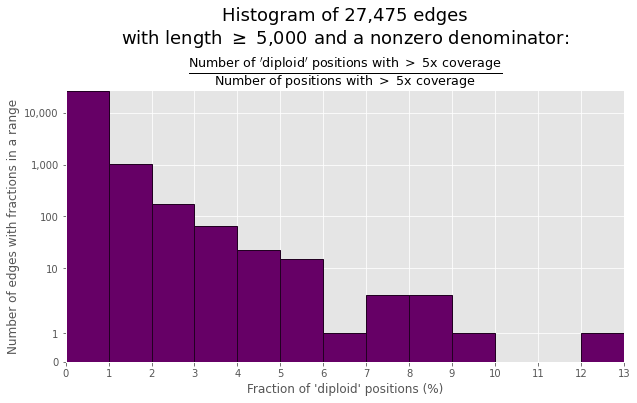

In [8]:
fracplot(
    edge2frac_diploid_to_mincov_positions,
    r"Number\ of\ positions\ with\ >\ 5x\ coverage",
    figfilename="prokeukfrac_den_mincov.png"
)

26,688 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78689); min frac: 0.0 (edge edge_5)
Top 10 edges: ['edge_69012', 'edge_69441', 'edge_71967', 'edge_72261', 'edge_72749', 'edge_73691', 'edge_77432', 'edge_78462', 'edge_78501', 'edge_78689']
Bottom 10 edges: ['edge_5', 'edge_8', 'edge_12', 'edge_14', 'edge_17', 'edge_19', 'edge_24', 'edge_31', 'edge_34', 'edge_37']


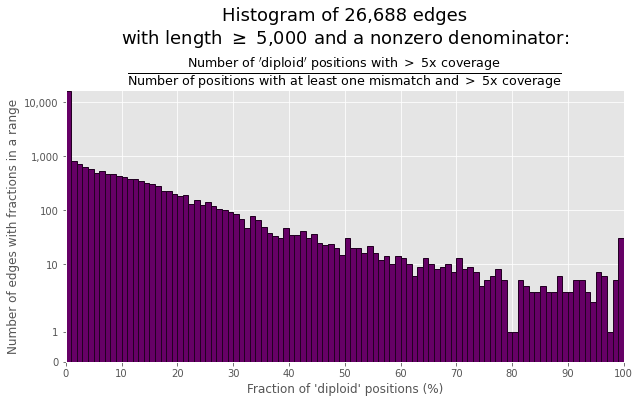

In [9]:
fracplot(
    edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch,
    r"Number\ of\ positions\ with\ at\ least\ one\ mismatch\ and\ >\ 5x\ coverage",
    figfilename="prokeukfrac_den_mincov_and_atleast_one_mm.png"
)

25,368 edges represented in this edge2frac object.
Max frac: 100.0 (edge edge_78689); min frac: 0.0 (edge edge_5)
Top 10 edges: ['edge_64859', 'edge_65510', 'edge_67407', 'edge_69012', 'edge_69441', 'edge_71967', 'edge_73691', 'edge_78462', 'edge_78501', 'edge_78689']
Bottom 10 edges: ['edge_5', 'edge_8', 'edge_12', 'edge_14', 'edge_17', 'edge_19', 'edge_24', 'edge_31', 'edge_34', 'edge_37']


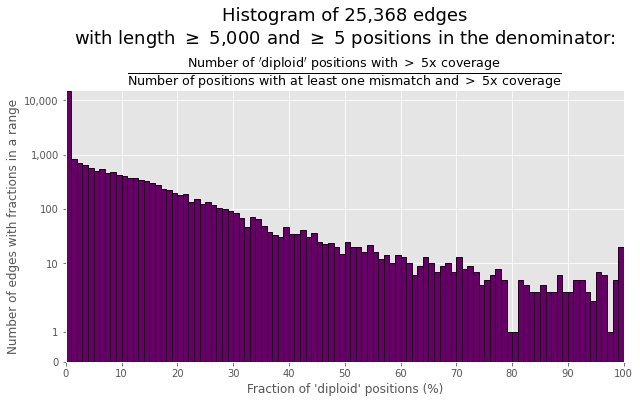

In [10]:
fracplot(
    edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5,
    r"Number\ of\ positions\ with\ at\ least\ one\ mismatch\ and\ >\ 5x\ coverage",
    denclause=" and $\geq$ 5 positions in the denominator",
    figfilename="prokeukfrac_den_mincov_and_atleast_one_mm_den_geq_5_pos.png"
)

In [11]:
def estats(e):
    num_dip = edge2num_mincov_putatively_diploid_positions[e]
    num_1mm = edge2num_mincov_positions_with_at_least_one_mismatch[e]
    num_mcp = edge2num_mincov_positions[e]
    print("=" * 79)
    print(f"Edge {e} ({edge2len[e]:,} bp long) has ...")
    print(f"{num_mcp:,} min-cov'd positions.")
    print(f"{num_1mm:,} min-cov'd positions with at least one mismatch.")
    print(f"{num_dip:,} 'diploid' min-cov'd positions.")
    try:
        print(f"Frac of mincov diploid to total mincov: {edge2frac_diploid_to_mincov_positions[e]}")
        print(f"Frac of mincov diploid to mincov'd with at least one mismatch: {edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch[e]}")
        print(f"Frac of mincov diploid to mincov'd with at least one mismatch,\n    limited to if there are >= 5 such denominator positions: {edge2frac_diploid_to_mincov_positions_with_at_least_one_mismatch_only_if_den_geq5[e]}")
    except KeyError:
        print(f"(Looks like this edge doesn't have all fractions defined for it.)")
        pass

In [18]:
estats("edge_17771")
estats("edge_71904")
estats("edge_66025")
estats("edge_78689")
estats("edge_78501")
# example of an edge where we probs shouldn't care much about it, since it only has 1 min-cov'd position
# with at least one mismatch (so although its fraction for the second plot is 100%, it's probs
# not super interesting)
estats("edge_2987")
# from BLASTing this, seems like it might be a bacteria?
estats("edge_4916")

Edge edge_17771 (14,607 bp long) has ...
3,914 min-cov'd positions.
14 min-cov'd positions with at least one mismatch.
14 'diploid' min-cov'd positions.
Frac of mincov diploid to total mincov: 0.0035769034236075624
Frac of mincov diploid to mincov'd with at least one mismatch: 1.0
Frac of mincov diploid to mincov'd with at least one mismatch,
    limited to if there are >= 5 such denominator positions: 1.0
Edge edge_71904 (34,872 bp long) has ...
2,993 min-cov'd positions.
362 min-cov'd positions with at least one mismatch.
281 'diploid' min-cov'd positions.
Frac of mincov diploid to total mincov: 0.09388573337788172
Frac of mincov diploid to mincov'd with at least one mismatch: 0.7762430939226519
Frac of mincov diploid to mincov'd with at least one mismatch,
    limited to if there are >= 5 such denominator positions: 0.7762430939226519
Edge edge_66025 (13,937 bp long) has ...
9,567 min-cov'd positions.
1,238 min-cov'd positions with at least one mismatch.
1,156 'diploid' min-cov'd po

## Go through some of the highest-fraction edges and retrieve their sequences in a FASTA file

So we can BLAST them, to get a sense for if they might actually correspond to sequences from eukaryotic organisms.

In [ ]:
# I just copied these lists from the "top N" output printed from the fracplot() function, but I could also
# totally things up so that these are automatically computed
edges_to_fetch = set(
    ['edge_44228', 'edge_61346', 'edge_56298', 'edge_28715', 'edge_38218', 'edge_72103', 'edge_71715', 'edge_4916', 'edge_71904', 'edge_66025'] +
    ['edge_64859', 'edge_65510', 'edge_67407', 'edge_69012', 'edge_69441', 'edge_71967', 'edge_73691', 'edge_78462', 'edge_78501', 'edge_78689']
)
print(f"Trying to fetch {len(edges_to_fetch)} edge sequences.")
out_fasta = ""
with open("../main-workflow/output/all_edges.fasta", "r") as fastafile:
    
    # Assumes that sequences are not split up over multiple lines (so a FASTA file with N sequences
    # should have only 2N lines, maybe 2N + 1 if there's an extra empty newline at the bottom of the file)
    for linenum, line in enumerate(fastafile):
    
        if line.startswith(">"):
            if linenum % 2 != 0:
                raise ValueError("something weird with > location in all_edges.fasta. Go yell at Marcus.")
            edgename = line.strip()[1:]
        else:
            if linenum % 2 != 1:
                raise ValueError("something weird with non > location in all_edges.fasta. Go yell at Marcus.")
            if edgename is None:
                raise ValueError("No sequence name set yet?")
            if edgename in edges_to_fetch:
                seq = line.strip()
                out_fasta += f">{edgename}\n{seq}\n"
            edgename = None

with open("misc-output/potentially_euk_edges.fasta", "w") as eukfile:
    eukfile.write(out_fasta)

print("Done!")